# Table of Contents

[<font size = "5">1. Data Preparation</font>](#ref1)

[<font size = "5">2. Model Construction and Evaluation</font>](#ref2)

[<font size = "5">3. Model Selection</font>](#ref3)

# <a id='ref1'>1. Data Preparation</a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from google.colab import drive
%matplotlib inline


drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/Electricity Price Forecasting in WESM'

df = pd.read_csv(path + '/data/wesm_dataset.csv', parse_dates=True, index_col='Date_Interval')

Mounted at /content/drive


In [3]:
df.head()

Effective GWAP  Rolling Average
Date_Interval                                       
2015-01-09 00:00:00     1822.506078        10.848250
2015-01-09 01:00:00     1752.397260        21.279187
2015-01-09 02:00:00     1539.379580        30.442160
2015-01-09 03:00:00     1815.911913        41.251160
2015-01-09 04:00:00     2884.785234        58.422500

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56640 entries, 2015-01-09 00:00:00 to 2021-06-25 23:00:00
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Effective GWAP   56640 non-null  float64
 1   Rolling Average  56640 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB


In [5]:
# check for NaN entries
df.isna().sum()

Effective GWAP     0
Rolling Average    0
dtype: int64

In [6]:
df.describe()

Effective GWAP  Rolling Average
count    56640.000000     56640.000000
mean      3353.702726      3342.884690
std       3288.258274      1653.120201
min     -98304.686290      -522.865510
25%       1859.164530      2243.987413
50%       2468.733487      2899.412221
75%       3439.152296      3998.538267
max      39155.138020     10339.032030

The minimum value in `Effective GWAP` column is suspicious. Therefore, it is necessary to check outliers using simple means.

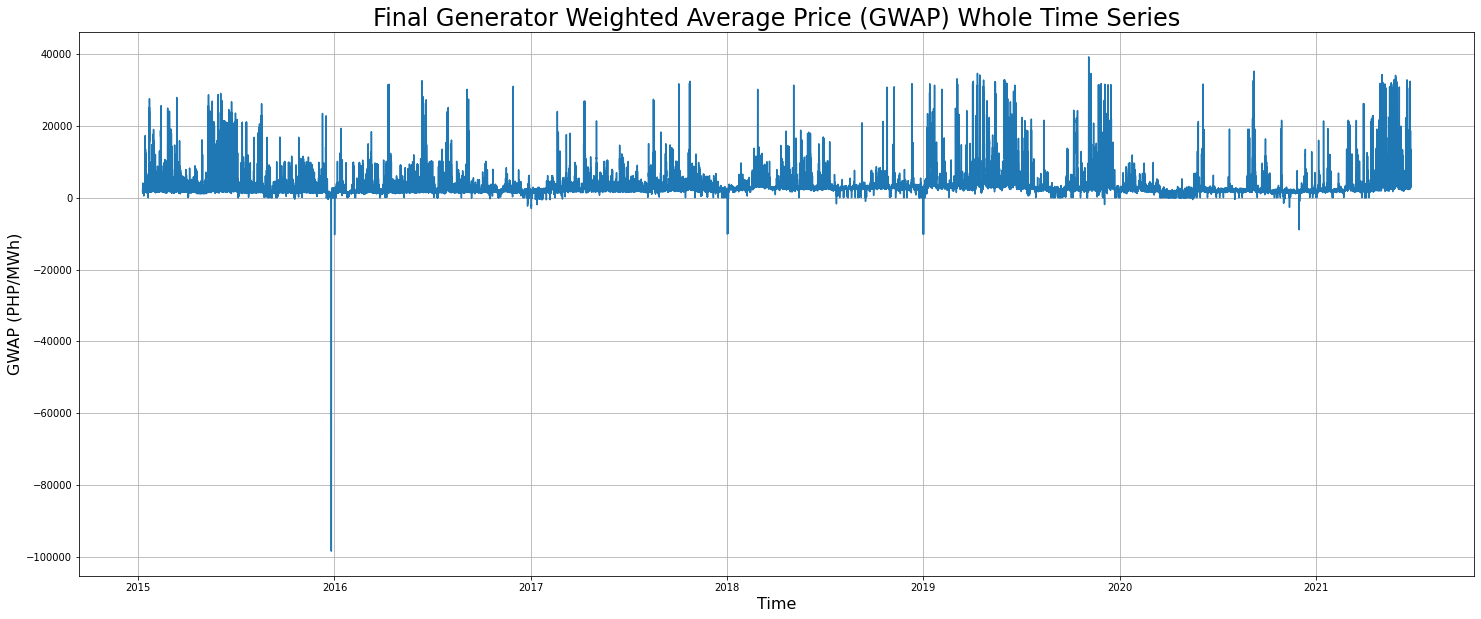

In [7]:
# Plot whole time series of Effective GWAP
plt.figure(figsize=(25,10))
plt.plot(df['Effective GWAP'])
plt.title('Final Generator Weighted Average Price (GWAP) Whole Time Series', fontsize=24)
plt.xlabel('Time', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.show()

The huge dip around December of 2015 is where the outlier is located.

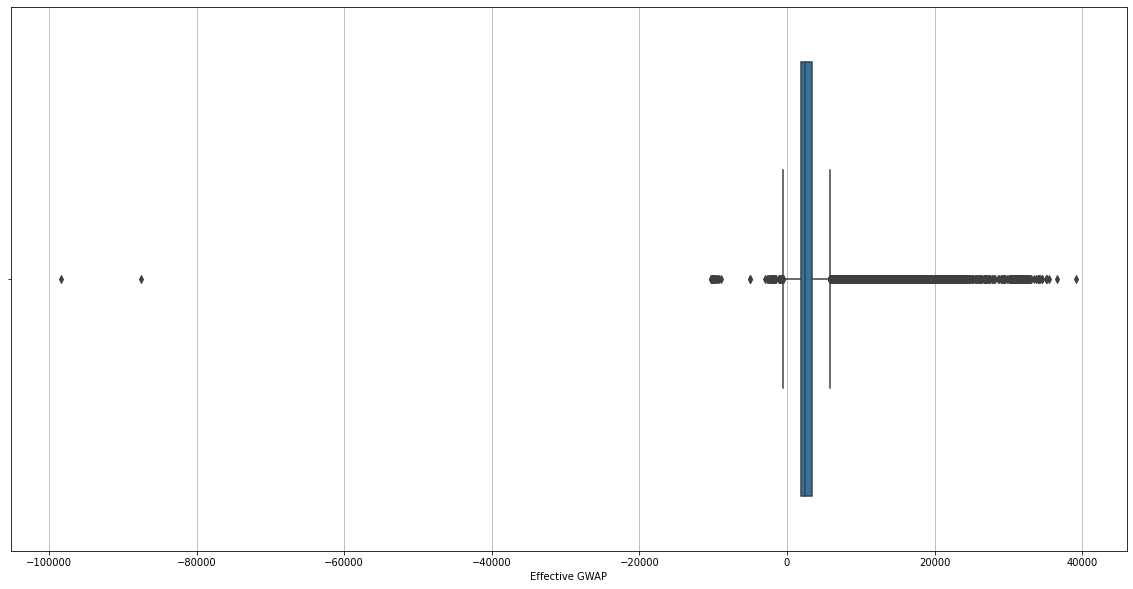

In [8]:
# Plot to check outliers
plt.figure(figsize=(20, 10))
plt.grid(True)
sns.boxplot(x=df['Effective GWAP'])
plt.show()

Simple observation tells that there are two outliers present.

In [9]:
# check two outliers
df['Effective GWAP'].nsmallest(2)

Date_Interval
2015-12-26 03:00:00   -98304.68629
2015-12-26 05:00:00   -87563.31061
Name: Effective GWAP, dtype: float64

The outliers are from 26th of December 2015.

***

Since the outlier might affect the performance of the model it is necessary to clean it out. One simple method is by using interpolation. First, the outliers are transformed into NaN and the values is then replaced using interpolation.

In [10]:
df_copy = df.copy()

In [11]:
# get outlier index
outlier_idx = df_copy['Effective GWAP'].nsmallest(2).index

# change outlier value to NaN
df_copy['Effective GWAP'].loc[outlier_idx] = np.nan
df_copy['Effective GWAP'].loc[outlier_idx]

Date_Interval
2015-12-26 03:00:00   NaN
2015-12-26 05:00:00   NaN
Name: Effective GWAP, dtype: float64

In [12]:
# interpolate
df_copy['Effective GWAP'].interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)
df_copy['Effective GWAP'].loc[outlier_idx]

Date_Interval
2015-12-26 03:00:00   -5367.604129
2015-12-26 05:00:00    -504.694475
Name: Effective GWAP, dtype: float64

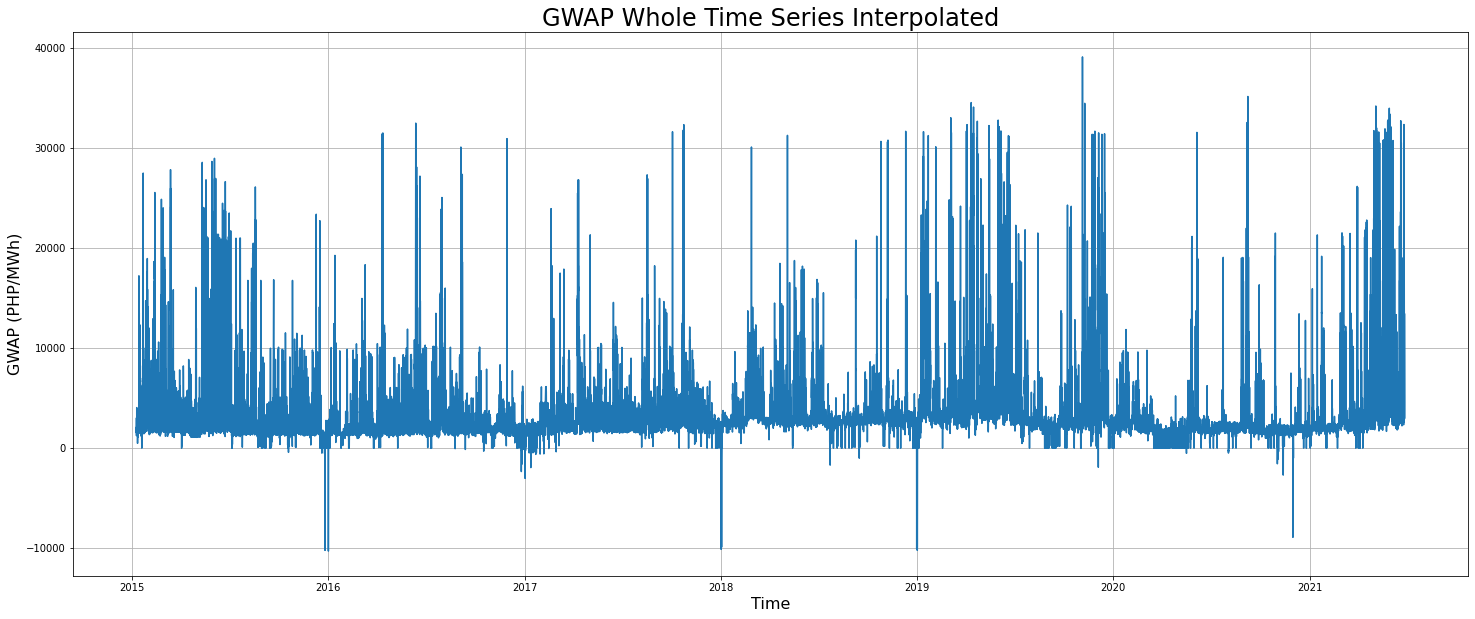

In [13]:
# plot interpolated Effective GWAP data
plt.figure(figsize=(25,10))
plt.plot(df_copy['Effective GWAP'])
plt.title('GWAP Whole Time Series Interpolated', fontsize=24)
plt.xlabel('Time', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.show()

The data now looks a lot better.

***

The `Rolling Average` is the average change of time series data over time. Checking how it varies along with the `Effective GWAP` gives information on how the data changes.

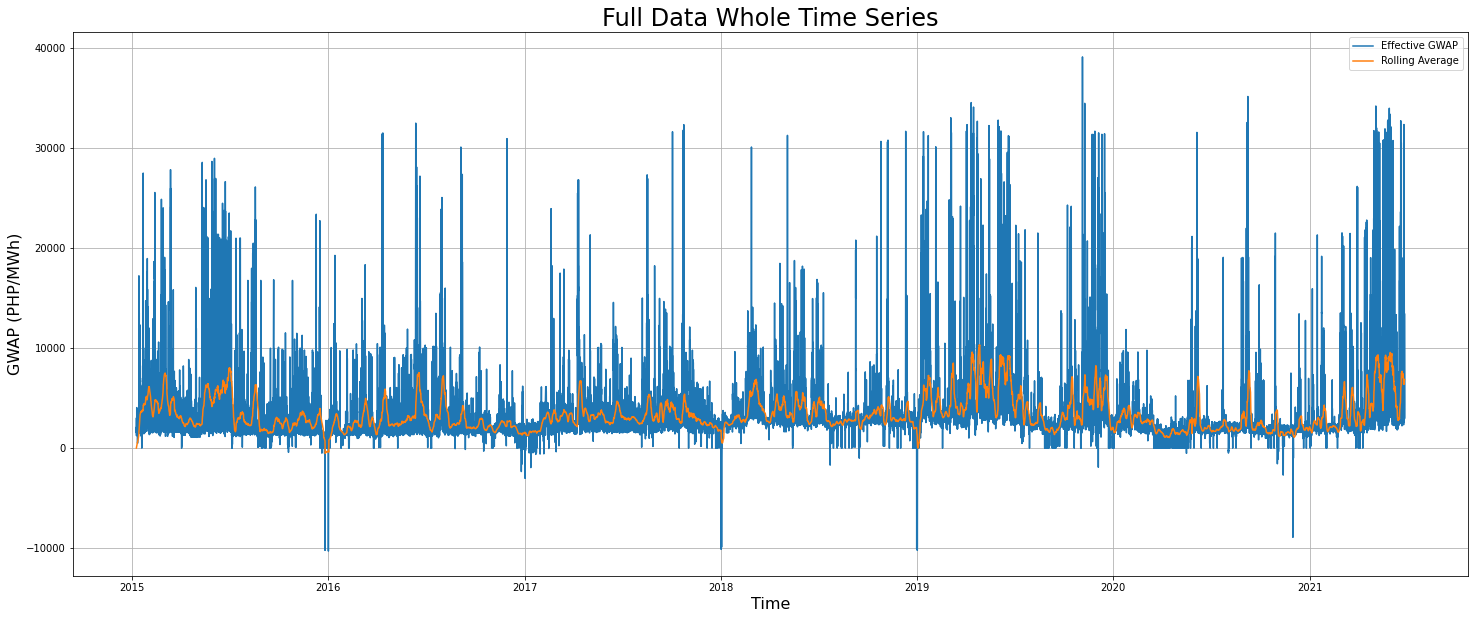

In [14]:
# plot whole time series with rolling average
plt.figure(figsize=(25,10))
plt.plot(df_copy['Effective GWAP'], label='Effective GWAP')
plt.plot(df_copy['Rolling Average'], label='Rolling Average')
plt.title('Full Data Whole Time Series', fontsize=24)
plt.xlabel('Time', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best')
plt.show()

The time series clearly shows a seasonal pattern although is looks a bit rough. It's easy to spot the drop of GWAP every end of each year and a spike in the middle of each year. To verify the seasonal pattern, a seasonal decomposition should show the seasonal pattern of the data. The Python __[statsmodel](https://www.statsmodels.org/stable/index.html)__ library offers an easy way to decompose a time series data.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


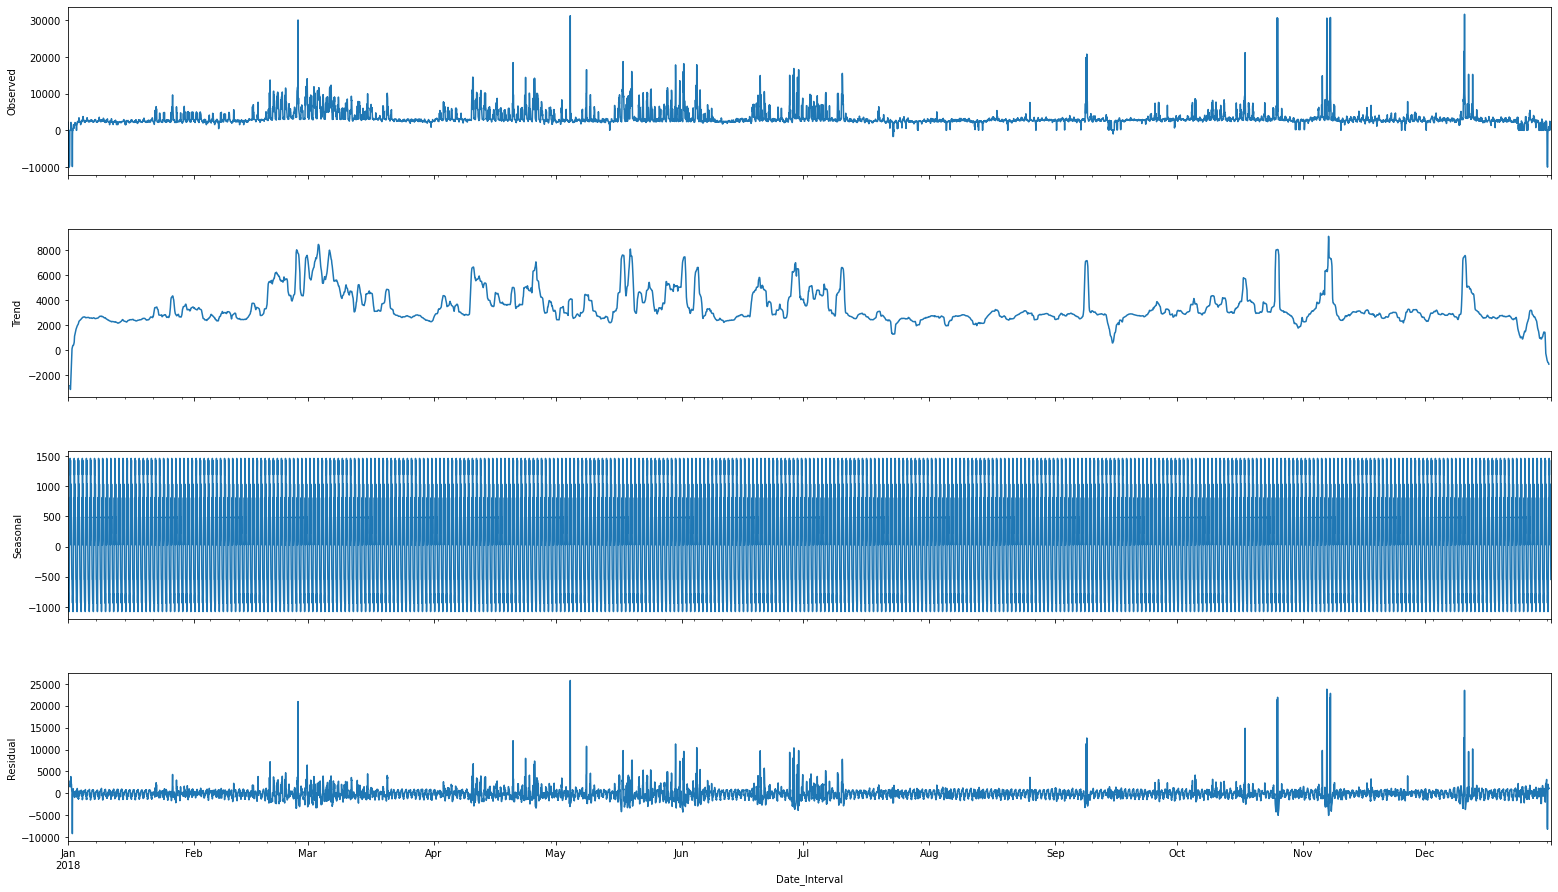

In [15]:
import statsmodels.api as sm

# seasonal decomposition of data
decomposition = sm.tsa.seasonal_decompose(df['Effective GWAP']['2018'], model = 'additive')
fig = decomposition.plot()
fig.set_size_inches(25, 15)
plt.show()

A seasonal pattern is clearly present on the data. To make use of this, adding a season feature should help the model learn more about the data. According to __[PAGASA](https://www.pagasa.dost.gov.ph/information/climate-philippines)__, Philippines has two major seasons: a rainy season, from June to November; and a dry season, from December to May.

In [16]:
# get dry season of each year
dry2015 = df_copy['Effective GWAP']['2015-01':'2015-05']
dry2016 = df_copy['Effective GWAP']['2015-12':'2016-05']
dry2017 = df_copy['Effective GWAP']['2016-12':'2017-05']
dry2018 = df_copy['Effective GWAP']['2017-12':'2018-05']
dry2019 = df_copy['Effective GWAP']['2018-12':'2019-05']
dry2020 = df_copy['Effective GWAP']['2019-12':'2020-05']

In [17]:
# get rainy season of each year
rainy2015 = df_copy['Effective GWAP']['2015-06':'2015-11']
rainy2016 = df_copy['Effective GWAP']['2016-06':'2016-11']
rainy2017 = df_copy['Effective GWAP']['2017-06':'2017-11']
rainy2018 = df_copy['Effective GWAP']['2018-06':'2018-11']
rainy2019 = df_copy['Effective GWAP']['2019-06':'2019-11']
rainy2020 = df_copy['Effective GWAP']['2020-06':'2020-11']

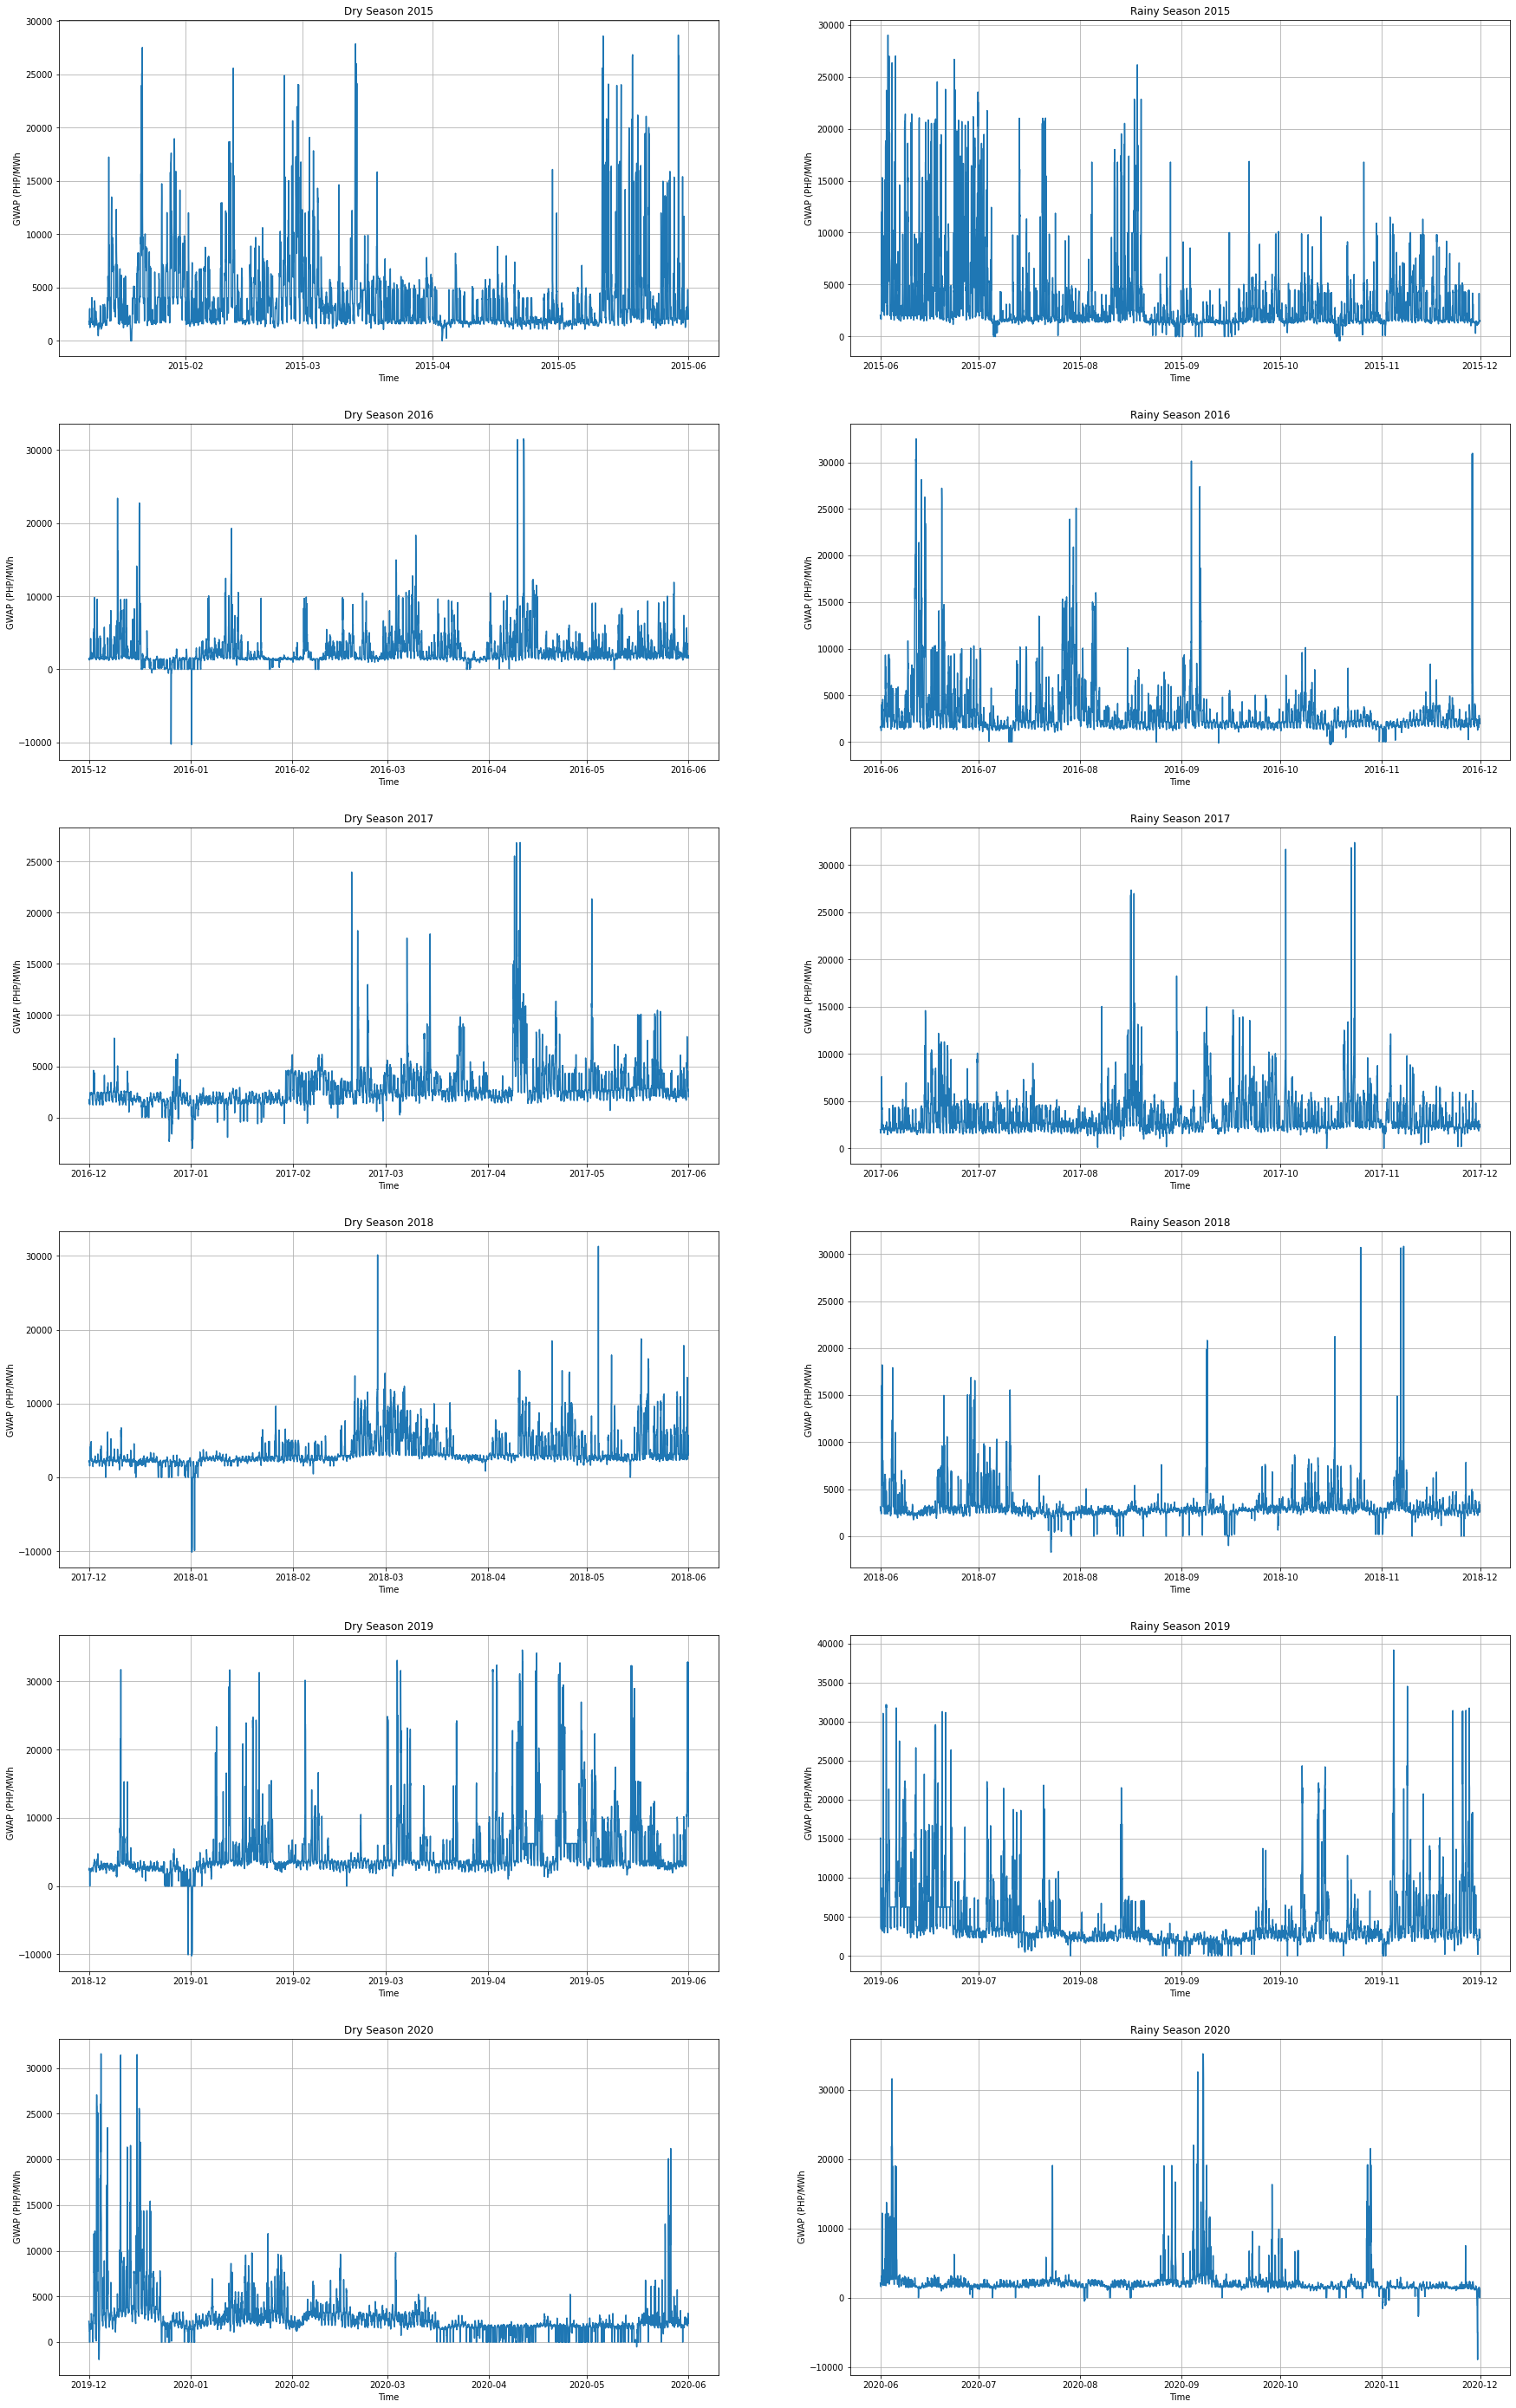

In [18]:
# plot each season of each year
fig, axs = plt.subplots(6, 2)

fig.set_size_inches(30, 50)
# 2015 Seasons
axs[0, 0].plot(dry2015)
axs[0, 0].set_title('Dry Season 2015')
axs[0, 1].plot(rainy2015)
axs[0, 1].set_title('Rainy Season 2015')
# 2016 Seasons
axs[1, 0].plot(dry2016)
axs[1, 0].set_title('Dry Season 2016')
axs[1, 1].plot(rainy2016)
axs[1, 1].set_title('Rainy Season 2016')
# 2017 Seasons
axs[2, 0].plot(dry2017)
axs[2, 0].set_title('Dry Season 2017')
axs[2, 1].plot(rainy2017)
axs[2, 1].set_title('Rainy Season 2017')
# 2018 Seasons
axs[3, 0].plot(dry2018)
axs[3, 0].set_title('Dry Season 2018')
axs[3, 1].plot(rainy2018)
axs[3, 1].set_title('Rainy Season 2018')
# 2019 Seasons
axs[4, 0].plot(dry2019)
axs[4, 0].set_title('Dry Season 2019')
axs[4, 1].plot(rainy2019)
axs[4, 1].set_title('Rainy Season 2019')
# 2020 Seasons
axs[5, 0].plot(dry2020)
axs[5, 0].set_title('Dry Season 2020')
axs[5, 1].plot(rainy2020)
axs[5, 1].set_title('Rainy Season 2020')

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='GWAP (PHP/MWh')
    ax.grid(True)
plt.show()

In [19]:
dry_seasons = [dry2015, dry2016, dry2017, dry2018, dry2019, dry2020]
dry_seasons_mean = 0
for dry_season in dry_seasons:
  dry_seasons_mean += dry_season.mean()

dry_seasons_mean / 6

3380.599385421412

In [20]:
rainy_seasons = [rainy2015, rainy2016, rainy2017, rainy2018, rainy2019, rainy2020]
rainy_seasons_mean = 0
for rainy_season in rainy_seasons:
  rainy_seasons_mean += rainy_season.mean()

rainy_seasons_mean / 6

3216.0507471167057

On average, dry seasons have higher GWAP than rainy seasons. This makes sense as demand is usually higher at times when the weather is hot.

***

###**Feature Engineering**

Since, the time series data varies a lot depending on the time, feature engineering will be done to ensure that the model will have enough features to learn from the data. Date time features such as hour, day, month, and etc. will be utilized. The seasonal data will also be added as a feature. Learning from past data is also important in time series forecasting. In this reason, lagged features and the `Rolling Average` will also utilized.

In [21]:
# Adding month, day, hour features
df_copy['month'] = df.index.month
df_copy['weekday'] = df.index.weekday
df_copy['hour'] = df.index.hour
df_copy.to_csv(path + '/data/dataset_with_datetime.csv', index=False)
df_copy

Effective GWAP  Rolling Average  month  weekday  hour
Date_Interval                                                             
2015-01-09 00:00:00     1822.506078        10.848250      1        4     0
2015-01-09 01:00:00     1752.397260        21.279187      1        4     1
2015-01-09 02:00:00     1539.379580        30.442160      1        4     2
2015-01-09 03:00:00     1815.911913        41.251160      1        4     3
2015-01-09 04:00:00     2884.785234        58.422500      1        4     4
...                             ...              ...    ...      ...   ...
2021-06-25 19:00:00     4582.463868      6823.492048      6        4    19
2021-06-25 20:00:00    13468.269470      6871.667956      6        4    20
2021-06-25 21:00:00     8069.676643      6866.547378      6        4    21
2021-06-25 22:00:00     3628.883036      6860.123532      6        4    22
2021-06-25 23:00:00     2975.500891      6856.019752      6        4    23

[56640 rows x 5 columns]

In [22]:
from random import randrange

def get_random_days(data, days):
  hours = days * 24
  start_day = randrange(0, len(data), 24)
  random_data = data[start_day:start_day + hours]

  return random_data

In [23]:
# get random day
random_day = get_random_days(df['Effective GWAP'], 1)
random_day

Date_Interval
2017-01-22 00:00:00    1456.450338
2017-01-22 01:00:00    1372.956141
2017-01-22 02:00:00    1367.228792
2017-01-22 03:00:00    1365.425895
2017-01-22 04:00:00    1285.144664
2017-01-22 05:00:00    1364.037304
2017-01-22 06:00:00    1041.210616
2017-01-22 07:00:00    -474.583835
2017-01-22 08:00:00    -477.875560
2017-01-22 09:00:00    -436.755856
2017-01-22 10:00:00    -400.819489
2017-01-22 11:00:00    -362.425234
2017-01-22 12:00:00    1472.072666
2017-01-22 13:00:00    1526.050010
2017-01-22 14:00:00    1514.410722
2017-01-22 15:00:00    1520.495102
2017-01-22 16:00:00    1743.408891
2017-01-22 17:00:00    2368.097399
2017-01-22 18:00:00    2363.870052
2017-01-22 19:00:00    2365.023526
2017-01-22 20:00:00    2057.852458
2017-01-22 21:00:00    1754.174077
2017-01-22 22:00:00    1726.694993
2017-01-22 23:00:00    1473.051984
Name: Effective GWAP, dtype: float64

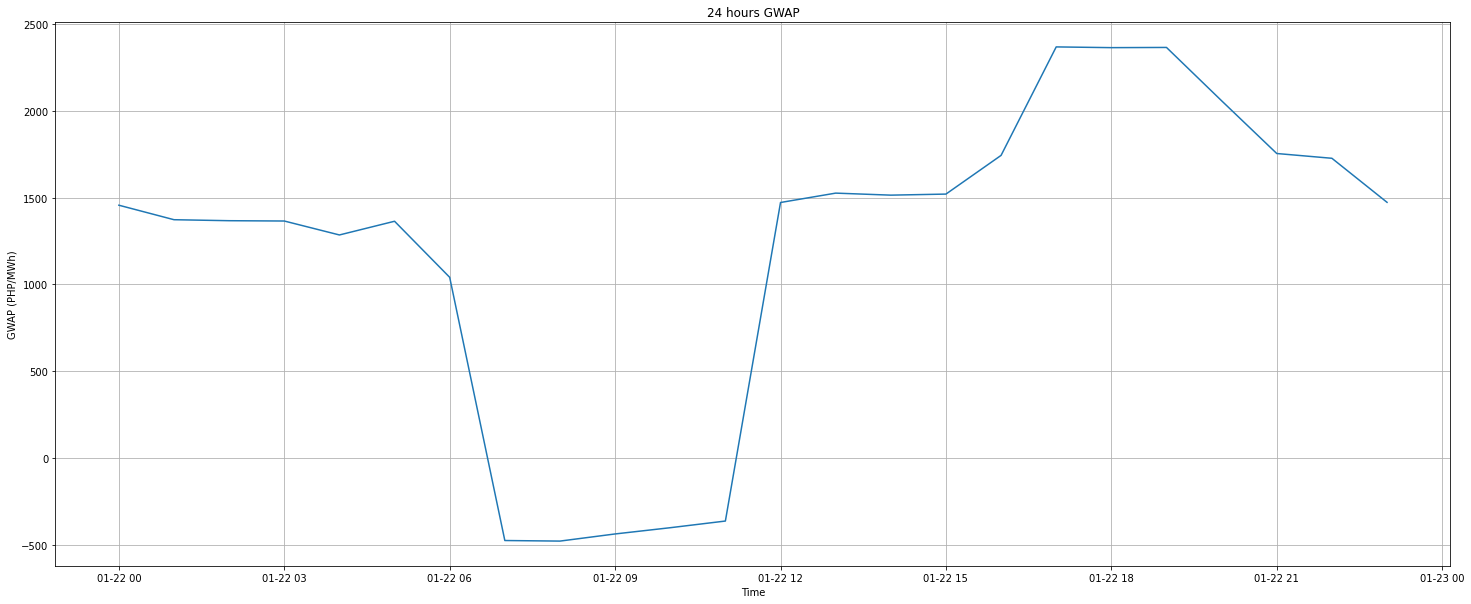

In [24]:
# Plot random day to know how the data changes 
plt.figure(figsize=(25, 10))
plt.plot(random_day)
plt.title('24 hours GWAP')
plt.xlabel('Time')
plt.ylabel('GWAP (PHP/MWh)')
plt.grid(True)
plt.show()

It should be useful to divide the day into 3 parts each part consists of 8 hours. The first one will be `morning`, then followed by `mid day` which is the business hour, and finally `evening`. It's only natural to assume that the data would fluctuate between these times since at the morning when everyone gets ready to go to work/school, there's a sudden demand of electricity. Then during business hours, the demand would vary depending on the productivity of the businesses. Finally, after business hours, people will get back from work and again, there would be a sudden surge of demand.

In [25]:
# one hot encoding of hour features
for i in range(len(df)):
  timestamp = df_copy.index[i]
  hour = timestamp.hour
  
  if hour < 8:
    df_copy.loc[timestamp, 'morning'] = 1
    df_copy.loc[timestamp, 'mid day'] = 0
    df_copy.loc[timestamp, 'evening'] = 0
  elif hour >= 8 and hour <= 15:
    df_copy.loc[timestamp, 'morning'] = 0
    df_copy.loc[timestamp, 'mid day'] = 1
    df_copy.loc[timestamp, 'evening'] = 0
  else:
    df_copy.loc[timestamp, 'morning'] = 0
    df_copy.loc[timestamp, 'mid day'] = 0
    df_copy.loc[timestamp, 'evening'] = 1

In [26]:
# get random week
random_week = get_random_days(df['Effective GWAP'], 7)
random_week

Date_Interval
2020-08-24 00:00:00    1782.13
2020-08-24 01:00:00    1775.08
2020-08-24 02:00:00    1746.31
2020-08-24 03:00:00    1732.50
2020-08-24 04:00:00    1727.01
                        ...   
2020-08-30 19:00:00    1891.06
2020-08-30 20:00:00    1942.91
2020-08-30 21:00:00    1766.71
2020-08-30 22:00:00    1779.59
2020-08-30 23:00:00    1635.64
Name: Effective GWAP, Length: 168, dtype: float64

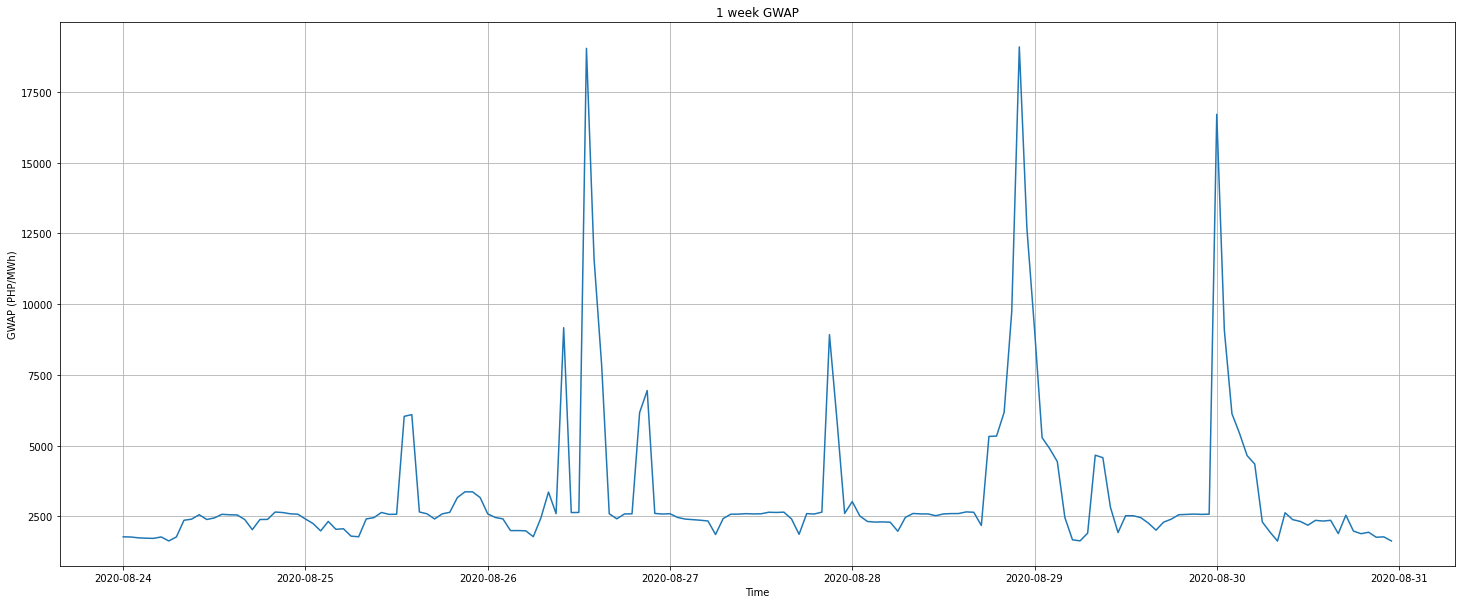

In [27]:
# plot random week
plt.figure(figsize=(25, 10))
plt.plot(random_week)
plt.title('1 week GWAP')
plt.xlabel('Time')
plt.ylabel('GWAP (PHP/MWh)')
plt.grid(True)
plt.show()

It's also safe to assume that data behaves differently during weekdays and weekdays. Adding this as a feature should help the model. The `weekend` feature would be 1 if the day is a weekend and 0 if not.

In [28]:
# create weekend feature
for i in range(len(df)):
  timestamp = df.index[i]
  weekday = timestamp.weekday()

  if weekday >= 5:
    df_copy.loc[timestamp, 'weekend'] = 1
  else:
    df_copy.loc[timestamp, 'weekend'] = 0 

Lastly, adding the `season` feature. 1 represents rainy season while 0 for dry.

In [29]:
# create season feature
for i in range(len(df)):
  timestamp = df.index[i]
  month = timestamp.month

  if month >= 6 and month <= 11:
    df_copy.loc[timestamp, 'season'] = 1
  else:
    df_copy.loc[timestamp, 'season'] = 0

In [30]:
# check current dataset with datetime features
df_copy.to_csv(path + '/data/data_full_datetime.csv', index=False)
df_copy

Effective GWAP  Rolling Average  month  weekday  hour  \
Date_Interval                                                                
2015-01-09 00:00:00     1822.506078        10.848250      1        4     0   
2015-01-09 01:00:00     1752.397260        21.279187      1        4     1   
2015-01-09 02:00:00     1539.379580        30.442160      1        4     2   
2015-01-09 03:00:00     1815.911913        41.251160      1        4     3   
2015-01-09 04:00:00     2884.785234        58.422500      1        4     4   
...                             ...              ...    ...      ...   ...   
2021-06-25 19:00:00     4582.463868      6823.492048      6        4    19   
2021-06-25 20:00:00    13468.269470      6871.667956      6        4    20   
2021-06-25 21:00:00     8069.676643      6866.547378      6        4    21   
2021-06-25 22:00:00     3628.883036      6860.123532      6        4    22   
2021-06-25 23:00:00     2975.500891      6856.019752      6        4    23   

                     morning  mid day  evening  weekend  season  
Date_Interval                                                    
2015-01-09 00:00:00      1.0      0.0      0.0      0.0     0.0  
2015-01-09 01:00:00      1.0      0.0      0.0      0.0     0.0  
2015-01-09 02:00:00      1.0      0.0      0.0      0.0     0.0  
2015-01-09 03:00:00      1.0      0.0      0.0      0.0     0.0  
2015-01-09 04:00:00      1.0      0.0      0.0      0.0     0.0  
...                      ...      ...      ...      ...     ...  
2021-06-25 19:00:00      0.0      0.0      1.0      0.0     1.0  
2021-06-25 20:00:00      0.0      0.0      1.0      0.0     1.0  
2021-06-25 21:00:00      0.0      0.0      1.0      0.0     1.0  
2021-06-25 22:00:00      0.0      0.0      1.0      0.0     1.0  
2021-06-25 23:00:00      0.0      0.0      1.0      0.0     1.0  

[56640 rows x 10 columns]

Adding lagged features will be useful to tell if past data is effective in creating forecasts. The lagged features that will be used are 1 hour, 23 hours, 24 hours, 48 hours, 72 hours, 168 hours, and 336 hours. The selection of these lagged features are referenced from __[Urgulu et al.](https://www.mdpi.com/1996-1073/11/5/1255)__

In [31]:
df_copy['lag_24_hours'] = df_copy['Effective GWAP'].shift(24)
df_copy['lag_168_hours'] = df_copy['Effective GWAP'].shift(168)
df_copy['lag_1_hour'] = df_copy['Effective GWAP'].shift(1)
df_copy['lag_48_hours'] = df_copy['Effective GWAP'].shift(48)
df_copy['lag_23_hours'] = df_copy['Effective GWAP'].shift(23)
df_copy['lag_72_hours'] = df_copy['Effective GWAP'].shift(72)
df_copy['lag_336_hours'] = df_copy['Effective GWAP'].shift(336)

In [32]:
df_copy = df_copy.dropna()

In [33]:
df_copy.shape

(56304, 17)

In [34]:
df_copy.to_csv(path + '/data/dataset_full_features.csv', index=False)
df_copy

Effective GWAP  Rolling Average  month  weekday  hour  \
Date_Interval                                                                
2015-01-23 00:00:00     1849.604375      4357.651316      1        4     0   
2015-01-23 01:00:00     1882.363158      4359.075739      1        4     1   
2015-01-23 02:00:00     1886.543140      4359.488924      1        4     2   
2015-01-23 03:00:00     1888.939469      4353.817912      1        4     3   
2015-01-23 04:00:00     4000.262110      4360.450629      1        4     4   
...                             ...              ...    ...      ...   ...   
2021-06-25 19:00:00     4582.463868      6823.492048      6        4    19   
2021-06-25 20:00:00    13468.269470      6871.667956      6        4    20   
2021-06-25 21:00:00     8069.676643      6866.547378      6        4    21   
2021-06-25 22:00:00     3628.883036      6860.123532      6        4    22   
2021-06-25 23:00:00     2975.500891      6856.019752      6        4    23   

                     morning  mid day  evening  weekend  season  lag_24_hours  \
Date_Interval                                                                   
2015-01-23 00:00:00      1.0      0.0      0.0      0.0     0.0   4038.461339   
2015-01-23 01:00:00      1.0      0.0      0.0      0.0     0.0   3506.938357   
2015-01-23 02:00:00      1.0      0.0      0.0      0.0     0.0   3865.155003   
2015-01-23 03:00:00      1.0      0.0      0.0      0.0     0.0   3555.473270   
2015-01-23 04:00:00      1.0      0.0      0.0      0.0     0.0   3500.074604   
...                      ...      ...      ...      ...     ...           ...   
2021-06-25 19:00:00      0.0      0.0      1.0      0.0     1.0  19126.570000   
2021-06-25 20:00:00      0.0      0.0      1.0      0.0     1.0  32390.800000   
2021-06-25 21:00:00      0.0      0.0      1.0      0.0     1.0  21516.500000   
2021-06-25 22:00:00      0.0      0.0      1.0      0.0     1.0   7862.060000   
2021-06-25 23:00:00      0.0      0.0      1.0      0.0     1.0   3424.130000   

                     lag_168_hours    lag_1_hour  lag_48_hours  lag_23_hours  \
Date_Interval                                                                  
2015-01-23 00:00:00    3008.675689   1436.897013   3994.478574   3506.938357   
2015-01-23 01:00:00    1643.060137   1849.604375   3616.561381   3865.155003   
2015-01-23 02:00:00    1817.127920   1882.363158   3909.627385   3555.473270   
2015-01-23 03:00:00    2841.669516   1886.543140   3976.082463   3500.074604   
2015-01-23 04:00:00    2885.965633   1888.939469   4104.101996   4030.370105   
...                            ...           ...           ...           ...   
2021-06-25 19:00:00   21446.290000   4578.853699   4527.210000  32390.800000   
2021-06-25 20:00:00   31957.030000   4582.463868   7986.910000  21516.500000   
2021-06-25 21:00:00   32769.440000  13468.269470   8097.570000   7862.060000   
2021-06-25 22:00:00   21886.270000   8069.676643   7615.450000   3424.130000   
2021-06-25 23:00:00   10441.410000   3628.883036   3404.990000   2983.963822   

                     lag_72_hours  lag_336_hours  
Date_Interval                                     
2015-01-23 00:00:00   1852.680439    1822.506078  
2015-01-23 01:00:00   1849.559571    1752.397260  
2015-01-23 02:00:00   1892.741375    1539.379580  
2015-01-23 03:00:00   1882.103641    1815.911913  
2015-01-23 04:00:00   1899.117471    2884.785234  
...                           ...            ...  
2021-06-25 19:00:00   8042.210000    2728.080000  
2021-06-25 20:00:00   7672.180000    2357.150000  
2021-06-25 21:00:00   4559.260000    2368.550000  
2021-06-25 22:00:00   4531.760000    2250.120000  
2021-06-25 23:00:00   2892.190000    2260.750000  

[56304 rows x 17 columns]

With all the features ready, the next thing to do is to split the dataset into 3 parts—train, validation, and test set. 

###**Splitting dataset**

Dataset needs to be splitted before forecasting can happen. The split will consist of 80% train set, 10% validation set, and 10% test set.



In [35]:
num_train_samples = int(0.8 * len(df_copy))
num_val_samples = int(0.1 * len(df_copy))
num_test_samples = len(df_copy) - (num_train_samples + num_val_samples)

train_end_idx = num_train_samples
val_end_idx = train_end_idx + num_val_samples
test_end_idx = val_end_idx + num_test_samples

train_end_idx, val_end_idx, test_end_idx

(45043, 50673, 56304)

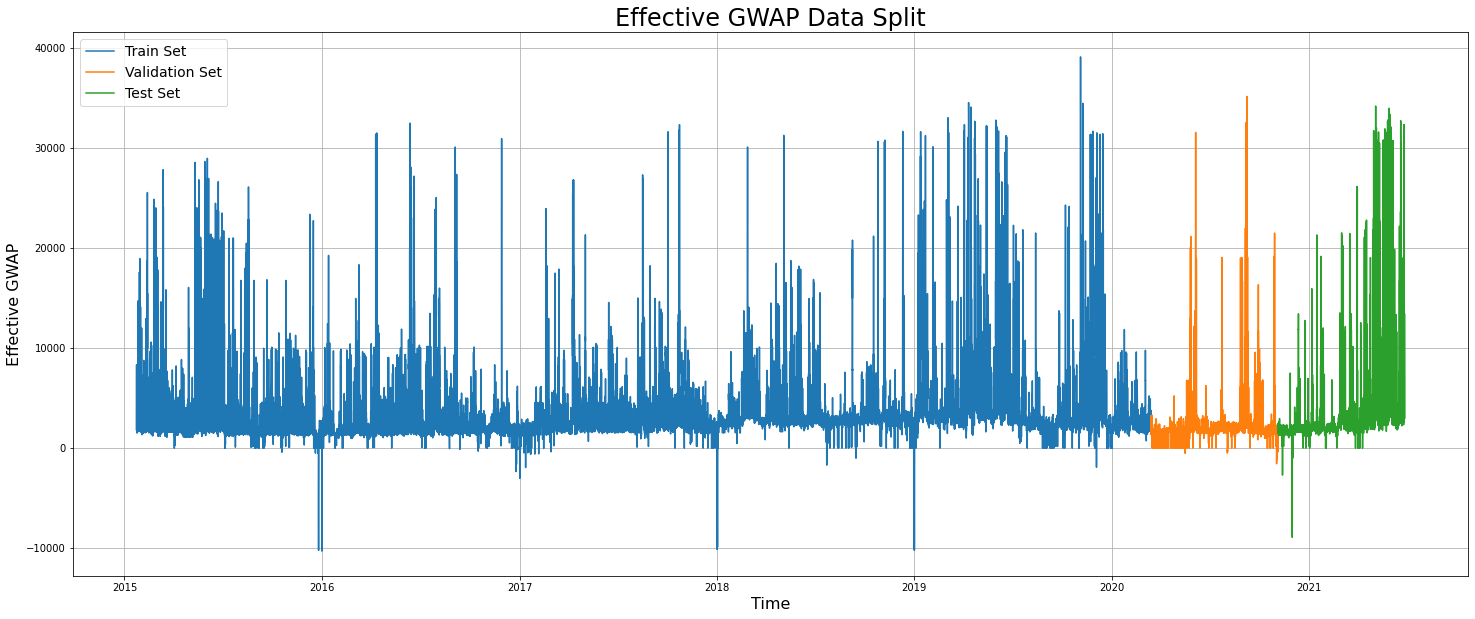

In [36]:
# Plot GWAP data split
data_gwap = df_copy['Effective GWAP']

train_set = data_gwap[:train_end_idx]
val_set = data_gwap[train_end_idx:val_end_idx]
test_set = data_gwap[val_end_idx:test_end_idx]

plt.figure(figsize=(25, 10))
plt.plot(train_set, label='Train Set')
plt.plot(val_set, label='Validation Set')
plt.plot(test_set, label='Test Set')
plt.title('Effective GWAP Data Split', fontsize=24)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Effective GWAP', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

###**Data Windowing**

Data windowing allows for the timeseries dataset to be treated as a supervised learning problem. `WindowGenerator` class in this part is borrowed and modified from TensorFlow's __[Time Series Forecasting Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing)__. This class 3 main parameters: `input_width`, `label_width`, and `shift`. This allows for creation of windows with varying lengths. This class will be useful in creating different models for different time frames.

In [37]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, 
               train_df=None, val_df=None, test_df=None,
               label_column=None):
    
    # Store data
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Get corresponding index from a given label column
    self.label_column = label_column
    self.column_idx = {name: i for i, name in enumerate(train_df.columns)}

    # Main parameters
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    # Get window parameters
    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.label_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.label_slice]

  def split_window(self, features):
    # Store inputs and labels from given features
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.label_slice]

    # Get labels
    labels = labels[:, :, self.column_idx[self.label_column]]
    
    # Set shape manually
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width])

    return inputs, labels

    self.split_window = split_window

  def make_dataset(self, data):
    # Create Dataset object
    data = np.array(data)
    ds = keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=self.shift,
        batch_size=32,
    )

    ds = ds.map(self.split_window)

    return ds

    self.make_dataset = make_dataset

  # Access for different dataset
  @property
  def train(self):
    return self.make_dataset(self.train_df)
    self.train = train

  @property
  def val(self):
    return self.make_dataset(self.val_df)
    self.val = val

  @property
  def test(self):
    return self.make_dataset(self.test_df)
    self.test = test

Everything is now ready, it's time to make and test some models.

# <a id='ref2'>2. Model Construction and Evaluation</a>

There will be a total of 8 experiments for this part varying depending on features used. These are:


1. Only `Effective GWAP`
2. `Effective GWAP` + `Rolling Average`
3. `Effective GWAP` + `Rolling Average` + datetime
4. `Effective GWAP` + `Rolling Average` + lagged
5. `Effective GWAP` + `Rolling Average` + datetime + lagged
6. `Effective GWAP` + datetime
7. `Effective GWAP` + lagged
8. `Effective GWAP` + datetime + lagged

The forecasting timeframes also varies. Specifically, all experiments' forecast 1 hour ahead, 12 hours ahead, and 24 hours ahead.



In [38]:
# Initiate hyperparamaters

reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.8, patience=3, min_delta=1e-10)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

learning_rate = 1e-3
epochs = 100

##**Experiment 1 - Only `Effective GWAP`**



In [ ]:
ex1_df = df_copy.drop(df_copy.columns[1:], axis=1)
ex1_df

Effective GWAP
Date_Interval                      
2015-01-23 00:00:00     1849.604375
2015-01-23 01:00:00     1882.363158
2015-01-23 02:00:00     1886.543140
2015-01-23 03:00:00     1888.939469
2015-01-23 04:00:00     4000.262110
...                             ...
2021-06-25 19:00:00     4582.463868
2021-06-25 20:00:00    13468.269470
2021-06-25 21:00:00     8069.676643
2021-06-25 22:00:00     3628.883036
2021-06-25 23:00:00     2975.500891

[56304 rows x 1 columns]

In [ ]:
ex1_train_df = ex1_df[0:train_end_idx]
ex1_val_df = ex1_df[train_end_idx:val_end_idx]
ex1_test_df = ex1_df[val_end_idx:test_end_idx]

###**Forecast 1 hour ahead**

In [ ]:
input_width = 24
label_width = 1
shift = 1

ex1_1hour_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex1_train_df, val_df=ex1_val_df, test_df=ex1_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex1_1hour_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 1)
(32, 1)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex1_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex1_1hour_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex1_df.shape[-1])
input_shape

(24, 1)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_lstm_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex1_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex1_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 38s 26ms/step - loss: 1459.7476 - val_loss: 1465.0107 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1857.1241 - val_loss: 741.3375 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1306.0464 - val_loss: 663.3790 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1604.5410 - val_loss: 938.1073 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1609.9592 - val_loss: 821.3632 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1243.0621 - val_loss: 735.0839 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1123.9388 - val_loss: 665.9600 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1118.2706 - val_loss: 650.0630 - lr: 8.0000e-04
Epoch 9

In [ ]:
lstm = keras.models.load_model(path + '/models/ex1_lstm_1hour_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1196.685

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex1_gru_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex1_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex1_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 35s 24ms/step - loss: 912.6137 - val_loss: 492.9774 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 34s 24ms/step - loss: 811.7312 - val_loss: 467.0228 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 33s 24ms/step - loss: 814.5793 - val_loss: 469.5214 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 34s 24ms/step - loss: 802.7995 - val_loss: 469.6653 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 804.9631 - val_loss: 469.4551 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 34s 24ms/step - loss: 797.5851 - val_loss: 464.8310 - lr: 8.0000e-04
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 794.2010 - val_loss: 467.4061 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 35s 25ms/step - loss: 792.3835 - val_loss: 458.9283 - lr: 8.0000e-04
Epoch 9/100


In [ ]:
gru = keras.models.load_model(path + '/models/ex1_gru_1hour_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1073.3667

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_rnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex1_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex1_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 20s 13ms/step - loss: 867.1350 - val_loss: 479.3957 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 19s 13ms/step - loss: 813.1718 - val_loss: 481.7914 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 19s 14ms/step - loss: 798.9574 - val_loss: 476.5780 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 19s 13ms/step - loss: 792.3648 - val_loss: 474.7520 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 19s 13ms/step - loss: 786.4041 - val_loss: 473.3548 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 18s 13ms/step - loss: 780.5119 - val_loss: 474.7211 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 20s 14ms/step - loss: 776.4214 - val_loss: 470.4836 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 18s 13ms/step - loss: 771.7808 - val_loss: 468.9911 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
rnn = keras.models.load_model(path + '/models/ex1_rnn_1hour_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

993.62164

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_cnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex1_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex1_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 10s 7ms/step - loss: 925.4611 - val_loss: 487.9397 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 831.3655 - val_loss: 473.2492 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 818.4961 - val_loss: 474.1288 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 799.3034 - val_loss: 473.1916 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 803.0856 - val_loss: 472.7544 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 800.8502 - val_loss: 470.8869 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 9s 7ms/step - loss: 812.0076 - val_loss: 473.4894 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 9s 7ms/step - loss: 799.7514 - val_loss: 471.0754 - lr: 0.0010
Epoch 9/100
1407/1407 [============

In [ ]:
cnn = keras.models.load_model(path + '/models/ex1_cnn_1hour_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1000.6599

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_ann_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex1_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex1_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 887.1830 - val_loss: 475.0121 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 831.7771 - val_loss: 471.9240 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 827.3387 - val_loss: 470.2569 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 8s 5ms/step - loss: 824.1345 - val_loss: 468.5908 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 821.2560 - val_loss: 466.4988 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 820.1559 - val_loss: 466.5011 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 819.9421 - val_loss: 468.8507 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 817.2579 - val_loss: 474.3657 - lr: 0.0010
Epoch 9/100
1407/1407 [=================

In [ ]:
ann = keras.models.load_model(path + '/models/ex1_ann_1hour_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1063.3999

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM          GRU         RNN          CNN          ANN
0  1104.352951  1196.685059  1073.366699  993.621643  1000.659912  1063.399902

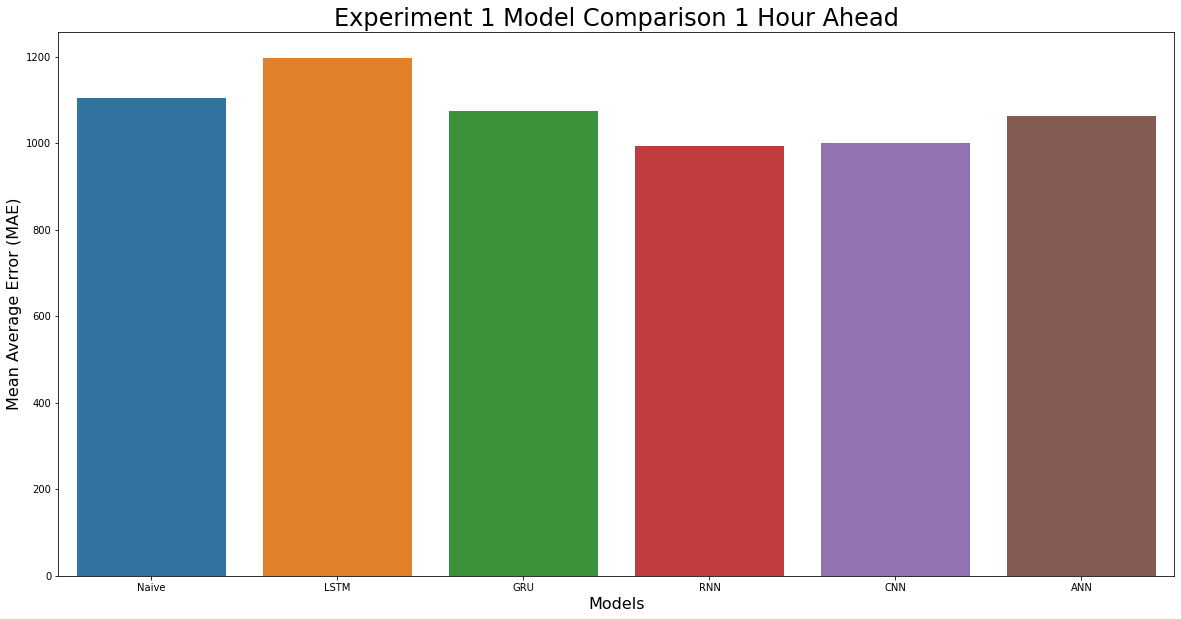

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 1 Model Comparison 1 Hour Ahead", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead**

In [ ]:
input_width = 24
label_width = 12
shift = 1

ex1_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex1_train_df, val_df=ex1_val_df, test_df=ex1_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex1_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 1)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex1_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex1_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex1_df.shape[-1])
input_shape

(24, 1)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1101.2762310150465

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_lstm_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex1_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex1_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 38s 26ms/step - loss: 1175.9106 - val_loss: 551.6195 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 37s 26ms/step - loss: 917.9767 - val_loss: 476.0990 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 37s 27ms/step - loss: 998.9412 - val_loss: 505.3617 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 37s 27ms/step - loss: 792.3778 - val_loss: 411.3100 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 36s 26ms/step - loss: 698.5793 - val_loss: 368.5228 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 36s 26ms/step - loss: 687.4641 - val_loss: 379.4788 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 36s 26ms/step - loss: 647.6582 - val_loss: 307.2811 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 36s 26ms/step - loss: 511.0392 - val_loss: 269.4565 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
lstm = keras.models.load_model(path + '/models/ex1_lstm_12hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

90.32133

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex1_gru_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex1_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 37s 24ms/step - loss: 331.8489 - val_loss: 61.5242 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 34s 24ms/step - loss: 107.8440 - val_loss: 56.4213 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 101.3226 - val_loss: 54.6895 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 99.8609 - val_loss: 54.2063 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 97.2232 - val_loss: 52.8835 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 36s 26ms/step - loss: 95.9708 - val_loss: 50.3303 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 91.8184 - val_loss: 49.9021 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 37s 26ms/step - loss: 91.6406 - val_loss: 51.5353 - lr: 0.0010
Epoch 9/100
1407/1407 [==============

In [ ]:
gru = keras.models.load_model(path + '/models/ex1_gru_12hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

89.33088

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_rnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex1_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 32s 22ms/step - loss: 232.5884 - val_loss: 66.6926 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 25s 17ms/step - loss: 118.2552 - val_loss: 57.1696 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 110.0151 - val_loss: 52.4191 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 17s 12ms/step - loss: 107.8406 - val_loss: 53.6016 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 18s 12ms/step - loss: 100.9841 - val_loss: 51.2866 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 100.2969 - val_loss: 49.8460 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 95.5761 - val_loss: 50.1265 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 16s 11ms/step - loss: 96.5906 - val_loss: 50.8481 - lr: 0.0010
Epoch 9/100
1407/1407 [===========

In [ ]:
rnn = keras.models.load_model(path + '/models/ex1_rnn_12hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

89.402885

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex1_cnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex1_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 15s 10ms/step - loss: 353.4094 - val_loss: 84.4511 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 151.9350 - val_loss: 70.5947 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 139.0201 - val_loss: 71.2758 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 132.7554 - val_loss: 71.9975 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 11s 8ms/step - loss: 127.5031 - val_loss: 62.2004 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 134.7123 - val_loss: 63.7783 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 126.0459 - val_loss: 64.5509 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 10s 7ms/step - loss: 126.8354 - val_loss: 62.4348 - lr: 0.0010
Epoch 9/100
1407/1407 [================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex1_cnn_12hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

86.78996

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_ann_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex1_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 8s 5ms/step - loss: 287.3753 - val_loss: 61.8596 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 123.5619 - val_loss: 53.2715 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 115.1177 - val_loss: 53.3230 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 115.6110 - val_loss: 60.7086 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 110.3185 - val_loss: 52.2570 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 106.9626 - val_loss: 55.6627 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 9s 6ms/step - loss: 104.2640 - val_loss: 55.5278 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 9s 6ms/step - loss: 103.3529 - val_loss: 52.4652 - lr: 0.0010
Epoch 9/100
1407/1407 [=========================

In [ ]:
ann = keras.models.load_model(path + '/models/ex1_ann_12hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

89.71214

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive       LSTM        GRU        RNN        CNN        ANN
0  1101.276231  90.321327  89.330879  89.402885  86.789963  89.712143

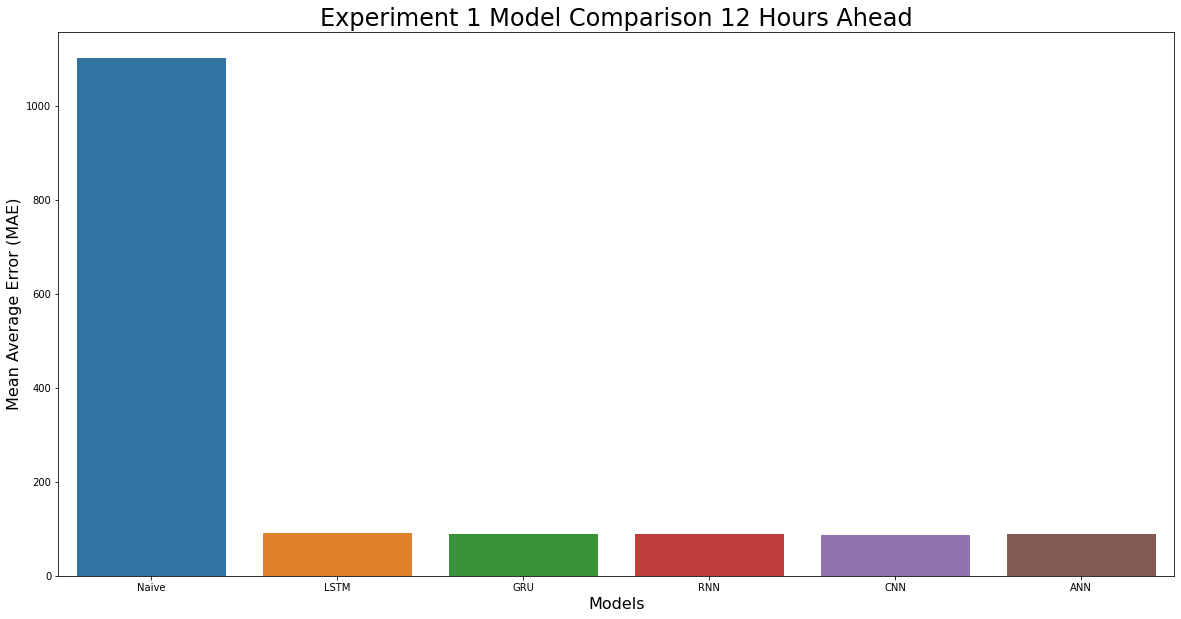

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 1 Model Comparison 12 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead 12 hour shift**

In [ ]:
input_width = 24
label_width = 12
shift = 12

ex1_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex1_train_df, val_df=ex1_val_df, test_df=ex1_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex1_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 1)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex1_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex1_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex1_df.shape[-1])
input_shape

(24, 1)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

2667.674529034868

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_lstm_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex1_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex1_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
118/118 [==============================] - 7s 42ms/step - loss: 1651.4828 - val_loss: 1156.4080 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 5s 46ms/step - loss: 1337.6952 - val_loss: 906.2493 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 5s 45ms/step - loss: 1281.6855 - val_loss: 867.8300 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 7s 55ms/step - loss: 1268.9128 - val_loss: 848.3063 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 6s 52ms/step - loss: 1288.0023 - val_loss: 968.5605 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 5s 40ms/step - loss: 1256.0522 - val_loss: 928.3021 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 5s 44ms/step - loss: 1230.1147 - val_loss: 828.8969 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 6s 49ms/step - loss: 1302.5610 - val_loss: 976.0137 - lr: 0.0010
Epoch 9/100
118/118 [==================

In [ ]:
lstm = keras.models.load_model(path + '/models/ex1_lstm_12hours_ahead_12hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1750.3817

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex1_gru_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex1_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
118/118 [==============================] - 7s 40ms/step - loss: 1403.1161 - val_loss: 821.5138 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 5s 40ms/step - loss: 1153.5981 - val_loss: 800.0819 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 7s 55ms/step - loss: 1114.8806 - val_loss: 807.0001 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 6s 49ms/step - loss: 1074.2118 - val_loss: 815.0173 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 5s 40ms/step - loss: 1060.2402 - val_loss: 813.2584 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 5s 38ms/step - loss: 1049.9967 - val_loss: 809.0914 - lr: 8.0000e-04
Epoch 7/100
118/118 [==============================] - 4s 35ms/step - loss: 1049.6786 - val_loss: 801.7475 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 4s 38ms/step - loss: 1042.3754 - val_loss: 811.5837 - lr: 8.0000e-04
Epoch 9/100
118/118 [=======

In [ ]:
gru = keras.models.load_model(path + '/models/ex1_gru_12hours_ahead_12hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1850.7677

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_rnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex1_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 4s 24ms/step - loss: 1301.9808 - val_loss: 834.6501 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 3s 25ms/step - loss: 1100.7118 - val_loss: 805.0512 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 3s 21ms/step - loss: 1068.1443 - val_loss: 788.8181 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 3s 23ms/step - loss: 1047.1560 - val_loss: 785.5394 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 3s 24ms/step - loss: 1027.8842 - val_loss: 810.1219 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 3s 23ms/step - loss: 1014.8182 - val_loss: 802.1461 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 3s 23ms/step - loss: 1011.5943 - val_loss: 843.6368 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 2s 19ms/step - loss: 1001.4254 - val_loss: 847.3331 - lr: 8.0000e-04
Epoch 9/100
118/118 [===============

In [ ]:
rnn = keras.models.load_model(path + '/models/ex1_rnn_12hours_ahead_12hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1851.9655

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex1_cnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex1_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 2s 13ms/step - loss: 1377.3217 - val_loss: 889.9292 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 9ms/step - loss: 1127.1505 - val_loss: 820.2300 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 11ms/step - loss: 1071.9192 - val_loss: 840.6152 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 10ms/step - loss: 1050.7615 - val_loss: 836.1425 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 11ms/step - loss: 1034.9565 - val_loss: 845.5109 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 11ms/step - loss: 1021.2977 - val_loss: 870.4612 - lr: 8.0000e-04
Epoch 7/100
118/118 [==============================] - 1s 10ms/step - loss: 1011.8527 - val_loss: 857.5363 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 1s 11ms/step - loss: 1005.4988 - val_loss: 864.2499 - lr: 8.0000e-04
Epoch 9/100
118/118 [========

In [ ]:
cnn = keras.models.load_model(path + '/models/ex1_cnn_12hours_ahead_12hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1806.0481

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_ann_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex1_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
118/118 [==============================] - 2s 11ms/step - loss: 1310.4650 - val_loss: 856.9009 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 10ms/step - loss: 1135.5330 - val_loss: 846.0524 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 10ms/step - loss: 1099.2780 - val_loss: 845.9510 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 10ms/step - loss: 1084.4650 - val_loss: 838.4436 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 11ms/step - loss: 1073.4758 - val_loss: 835.0356 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 10ms/step - loss: 1067.8577 - val_loss: 834.2918 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 8ms/step - loss: 1063.3654 - val_loss: 842.1934 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 1s 8ms/step - loss: 1056.1681 - val_loss: 836.2947 - lr: 0.0010
Epoch 9/100
118/118 [=====================

In [ ]:
ann = keras.models.load_model(path + '/models/ex1_ann_12hours_ahead_12hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1929.1869

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive         LSTM        GRU          RNN          CNN         ANN
0  2667.674529  1750.381714  1850.7677  1851.965454  1806.048096  1929.18689

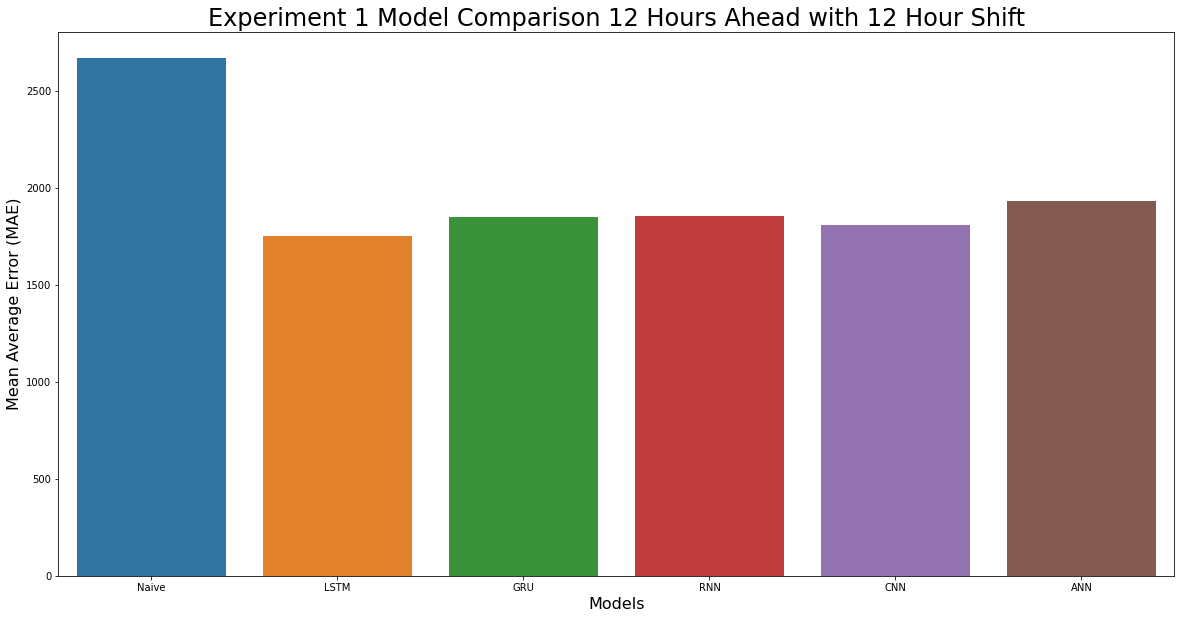

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 1 Model Comparison 12 Hours Ahead with 12 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead**

In [ ]:
input_width = 24
label_width = 24
shift = 1

ex1_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex1_train_df, val_df=ex1_val_df, test_df=ex1_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex1_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 1)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex1_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex1_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex1_df.shape[-1])
input_shape

(24, 1)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1098.3518162532384

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_lstm_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex1_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex1_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 53s 36ms/step - loss: 1367.3591 - val_loss: 600.6964 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 37s 26ms/step - loss: 819.0757 - val_loss: 397.6855 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 38s 27ms/step - loss: 577.2318 - val_loss: 301.7656 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 38s 27ms/step - loss: 792.2415 - val_loss: 285.5734 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 39s 28ms/step - loss: 436.7031 - val_loss: 187.0699 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 38s 27ms/step - loss: 312.3497 - val_loss: 132.5362 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 38s 27ms/step - loss: 210.7801 - val_loss: 77.0246 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 38s 27ms/step - loss: 150.7468 - val_loss: 73.6470 - lr: 0.0010
Epoch 9/100
1407/1407 [==

In [ ]:
lstm = keras.models.load_model(path + '/models/ex1_lstm_24hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

45.515923

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_gru_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex1_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 34s 23ms/step - loss: 297.6584 - val_loss: 45.0451 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 33s 24ms/step - loss: 81.4514 - val_loss: 37.8307 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 35s 25ms/step - loss: 70.3165 - val_loss: 36.5818 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 34s 24ms/step - loss: 66.8225 - val_loss: 37.9720 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 33s 23ms/step - loss: 63.8681 - val_loss: 32.0783 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 34s 24ms/step - loss: 62.6139 - val_loss: 32.8870 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 60.1786 - val_loss: 29.2423 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 32s 23ms/step - loss: 59.1360 - val_loss: 32.0214 - lr: 0.0010
Epoch 9/100
1407/1407 [================

In [ ]:
gru = keras.models.load_model(path + '/models/ex1_gru_24hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

45.278587

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_rnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex1_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 31s 21ms/step - loss: 202.7121 - val_loss: 47.8572 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 23s 16ms/step - loss: 86.5346 - val_loss: 41.4830 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 20s 14ms/step - loss: 76.6854 - val_loss: 36.8514 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 72.6443 - val_loss: 35.7827 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 20s 15ms/step - loss: 68.9884 - val_loss: 33.2446 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 19s 14ms/step - loss: 66.5758 - val_loss: 32.8203 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 21s 15ms/step - loss: 64.5655 - val_loss: 30.8608 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 20s 14ms/step - loss: 62.6617 - val_loss: 30.2898 - lr: 0.0010
Epoch 9/100
1407/1407 [================

In [ ]:
rnn = keras.models.load_model(path + '/models/ex1_rnn_24hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

45.14789

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_cnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex1_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 10s 7ms/step - loss: 277.2527 - val_loss: 65.4663 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 119.8413 - val_loss: 51.2503 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 104.9584 - val_loss: 51.9688 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 99.2508 - val_loss: 48.4997 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 97.1323 - val_loss: 49.9614 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 99.4799 - val_loss: 43.8354 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 92.3174 - val_loss: 42.3792 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 10s 7ms/step - loss: 92.9428 - val_loss: 44.0451 - lr: 0.0010
Epoch 9/100
1407/1407 [======================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex1_cnn_24hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

44.02198

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_ann_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex1_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 252.9782 - val_loss: 43.1719 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 8s 6ms/step - loss: 90.7969 - val_loss: 42.6662 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 85.2645 - val_loss: 40.4402 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 82.0789 - val_loss: 38.6267 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 75.9681 - val_loss: 35.9965 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 73.3392 - val_loss: 33.9092 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 9s 6ms/step - loss: 72.6399 - val_loss: 35.7315 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 9s 6ms/step - loss: 70.3921 - val_loss: 35.2033 - lr: 0.0010
Epoch 9/100
1407/1407 [==============================] 

In [ ]:
ann = keras.models.load_model(path + '/models/ex1_ann_24hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

45.245148

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive       LSTM        GRU        RNN       CNN        ANN
0  1098.351816  45.515923  45.278587  45.147888  44.02198  45.245148

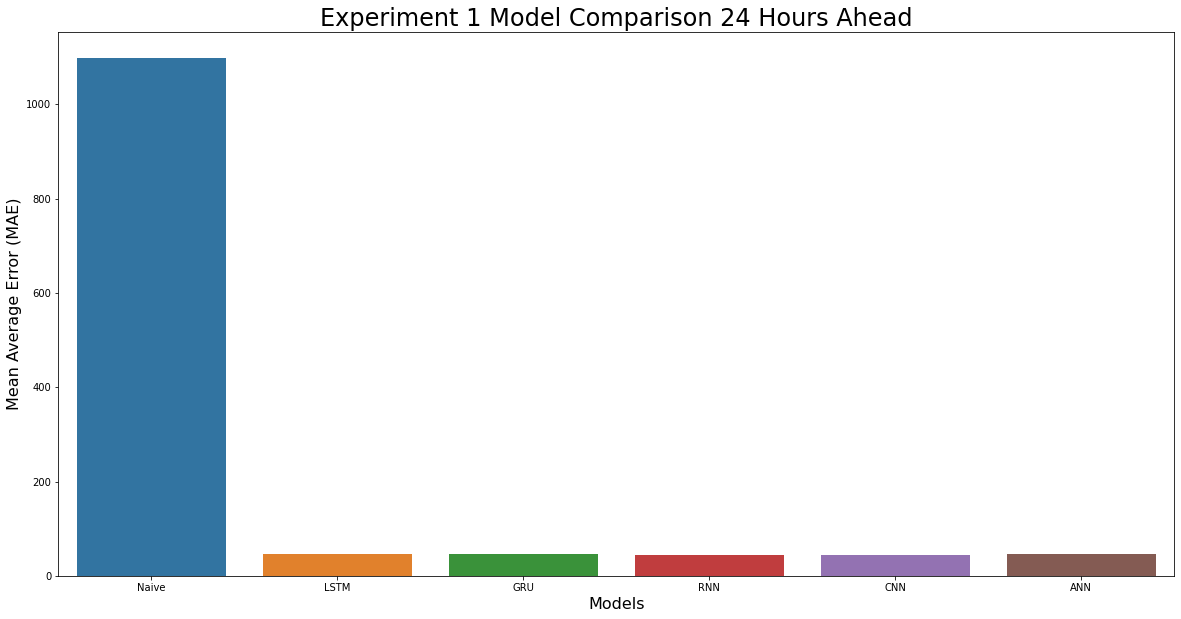

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 1 Model Comparison 24 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead 24 hour shift**

In [ ]:
input_width = 24
label_width = 24
shift = 24

ex1_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex1_train_df, val_df=ex1_val_df, test_df=ex1_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex1_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 1)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex1_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex1_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex1_df.shape[-1])
input_shape

(24, 1)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1722.1445946783263

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_lstm_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex1_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex1_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
59/59 [==============================] - 5s 47ms/step - loss: 1576.7849 - val_loss: 1000.1935 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 42ms/step - loss: 1341.2737 - val_loss: 968.6340 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 41ms/step - loss: 1328.7686 - val_loss: 955.0156 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 41ms/step - loss: 1252.2571 - val_loss: 997.2434 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 3s 43ms/step - loss: 1273.2936 - val_loss: 1077.8983 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 42ms/step - loss: 1388.8015 - val_loss: 989.8362 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 2s 42ms/step - loss: 1249.6993 - val_loss: 943.9655 - lr: 8.0000e-04
Epoch 8/100
59/59 [==============================] - 2s 41ms/step - loss: 1226.5436 - val_loss: 928.5517 - lr: 8.0000e-04
Epoch 9/100
59/59 [===========================

In [ ]:
lstm = keras.models.load_model(path + '/models/ex1_lstm_24hours_ahead_24hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

2518.9114

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex1_gru_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex1_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
59/59 [==============================] - 6s 48ms/step - loss: 1537.9387 - val_loss: 967.2297 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 40ms/step - loss: 1217.4133 - val_loss: 927.2886 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 38ms/step - loss: 1190.0312 - val_loss: 930.6211 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 29ms/step - loss: 1171.0472 - val_loss: 931.6852 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 27ms/step - loss: 1179.5304 - val_loss: 894.3793 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 27ms/step - loss: 1167.5822 - val_loss: 918.4739 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 2s 27ms/step - loss: 1152.7455 - val_loss: 875.1331 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 2s 27ms/step - loss: 1143.6832 - val_loss: 888.3375 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 2s 

In [ ]:
gru = keras.models.load_model(path + '/models/ex1_gru_24hours_ahead_24hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

2155.5156

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_rnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex1_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 2s 18ms/step - loss: 1390.3551 - val_loss: 949.0107 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 15ms/step - loss: 1180.7982 - val_loss: 953.6974 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 18ms/step - loss: 1158.8191 - val_loss: 929.9318 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 16ms/step - loss: 1147.8783 - val_loss: 923.7297 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 17ms/step - loss: 1138.6660 - val_loss: 923.1238 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 15ms/step - loss: 1133.2255 - val_loss: 909.8311 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 17ms/step - loss: 1128.9211 - val_loss: 896.7928 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 16ms/step - loss: 1122.1715 - val_loss: 909.8938 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1s 

In [ ]:
rnn = keras.models.load_model(path + '/models/ex1_rnn_24hours_ahead_24hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

2540.6384

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex1_cnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex1_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 12ms/step - loss: 1449.0566 - val_loss: 1135.1996 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 10ms/step - loss: 1217.6689 - val_loss: 1052.1506 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 11ms/step - loss: 1194.0999 - val_loss: 1022.7823 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 10ms/step - loss: 1177.3263 - val_loss: 1019.7006 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 11ms/step - loss: 1168.1456 - val_loss: 986.4459 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 9ms/step - loss: 1160.4232 - val_loss: 989.8853 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 9ms/step - loss: 1165.3436 - val_loss: 1004.4122 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 10ms/step - loss: 1168.1821 - val_loss: 995.0142 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 

In [ ]:
cnn = keras.models.load_model(path + '/models/ex1_cnn_24hours_ahead_24hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

2522.6775

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_ann_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex1_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex1_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 10ms/step - loss: 1417.8710 - val_loss: 868.7047 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 9ms/step - loss: 1197.1686 - val_loss: 914.9922 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 9ms/step - loss: 1174.5206 - val_loss: 918.7732 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 9ms/step - loss: 1168.1344 - val_loss: 912.2248 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 9ms/step - loss: 1157.6187 - val_loss: 896.8565 - lr: 8.0000e-04
Epoch 6/100
59/59 [==============================] - 1s 9ms/step - loss: 1152.5608 - val_loss: 898.6800 - lr: 8.0000e-04
Epoch 7/100
59/59 [==============================] - 1s 9ms/step - loss: 1149.6168 - val_loss: 891.9020 - lr: 8.0000e-04
Epoch 8/100
59/59 [==============================] - 1s 9ms/step - loss: 1147.9119 - val_loss: 883.9808 - lr: 6.4000e-04
Epoch 9/100
59/59 [============================

In [ ]:
ann = keras.models.load_model(path + '/models/ex1_ann_24hours_ahead_24hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

2390.4792

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive         LSTM          GRU          RNN         CNN          ANN
0  1722.144595  2518.911377  2155.515625  2540.638428  2522.67749  2390.479248

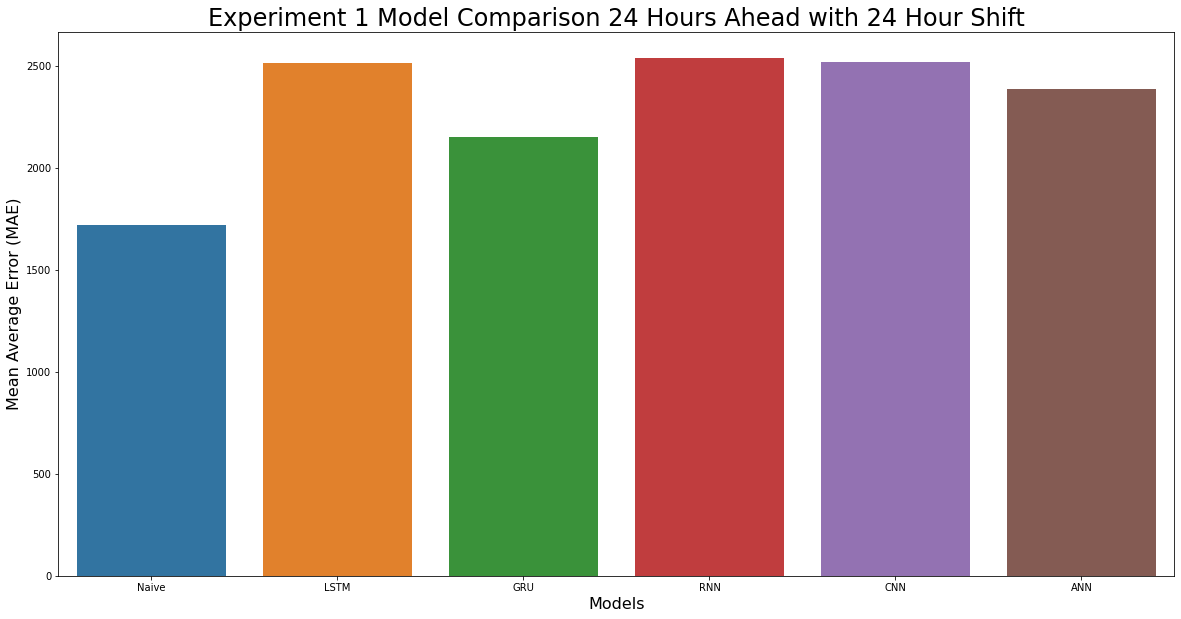

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 1 Model Comparison 24 Hours Ahead with 24 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Deeper Layers (1 hour ahead)** 

In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex1_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex1_1hour_ahead.test], axis=0)

input_shape = (input_width, ex1_df.shape[-1])
input_shape

(24, 1)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_lstm_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex1_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex1_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 120s 81ms/step - loss: 1515.9019 - val_loss: 799.1361 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 90s 64ms/step - loss: 1244.0983 - val_loss: 766.5992 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 90s 64ms/step - loss: 1522.3340 - val_loss: 1047.5884 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 89s 63ms/step - loss: 1294.0699 - val_loss: 771.2937 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 89s 63ms/step - loss: 1289.5001 - val_loss: 760.2266 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 89s 63ms/step - loss: 1223.8745 - val_loss: 739.2122 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 88s 63ms/step - loss: 1256.4589 - val_loss: 758.3531 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 89s 63ms/step - loss: 1255.5510 - val_loss: 748.5622 - lr: 0.0010
Epoch 9/100
14

In [ ]:
lstm = keras.models.load_model(path + '/models/ex1_lstm_3layers.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1589.3694

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex1_gru_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex1_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex1_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 86s 58ms/step - loss: 974.3394 - val_loss: 477.0984 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 83s 59ms/step - loss: 822.4631 - val_loss: 465.3432 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 83s 59ms/step - loss: 837.1418 - val_loss: 477.1787 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 83s 59ms/step - loss: 825.5076 - val_loss: 466.4844 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 82s 59ms/step - loss: 803.0165 - val_loss: 466.8126 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 83s 59ms/step - loss: 795.6863 - val_loss: 465.7931 - lr: 8.0000e-04
Epoch 7/100
1407/1407 [==============================] - 83s 59ms/step - loss: 795.6068 - val_loss: 465.2661 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 83s 59ms/step - loss: 787.5103 - val_loss: 463.5734 - lr: 8.0000e-04
Epoch 9/100


In [ ]:
gru = keras.models.load_model(path + '/models/ex1_gru_3layers.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1031.4252

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_rnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex1_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex1_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 39s 27ms/step - loss: 876.9228 - val_loss: 488.5192 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 37s 27ms/step - loss: 817.5521 - val_loss: 476.4121 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 804.8737 - val_loss: 480.0951 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 37s 26ms/step - loss: 799.1365 - val_loss: 470.8344 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 37s 27ms/step - loss: 785.6710 - val_loss: 476.7243 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 37s 26ms/step - loss: 778.0549 - val_loss: 468.2739 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 37s 26ms/step - loss: 776.3749 - val_loss: 464.1620 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 37s 26ms/step - loss: 768.9467 - val_loss: 465.1977 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
rnn = keras.models.load_model(path + '/models/ex1_rnn_3layers.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1016.36633

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_cnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex1_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex1_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 120s 85ms/step - loss: 1065.8247 - val_loss: 534.7620 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 121s 86ms/step - loss: 875.0085 - val_loss: 542.7708 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 123s 88ms/step - loss: 836.8459 - val_loss: 509.0418 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 125s 89ms/step - loss: 820.6934 - val_loss: 500.0553 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 121s 86ms/step - loss: 812.7545 - val_loss: 506.8240 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 122s 87ms/step - loss: 800.6857 - val_loss: 501.5596 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 123s 87ms/step - loss: 800.3923 - val_loss: 495.1028 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 123s 87ms/step - loss: 786.6912 - val_loss: 499.1063 - lr: 0.0010
Epoch 9/100
140

In [ ]:
cnn = keras.models.load_model(path + '/models/ex1_cnn_3layers.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1006.01086

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex1_ann_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex1_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex1_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 14s 10ms/step - loss: 893.8646 - val_loss: 475.9505 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 840.9315 - val_loss: 473.8503 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 831.7469 - val_loss: 473.2230 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 13s 10ms/step - loss: 826.7955 - val_loss: 471.1622 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 823.7130 - val_loss: 474.4510 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 13s 9ms/step - loss: 822.4713 - val_loss: 465.2884 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 823.0519 - val_loss: 464.2151 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 13s 9ms/step - loss: 820.0211 - val_loss: 463.3998 - lr: 0.0010
Epoch 9/100
1407/1407 [======

In [ ]:
ann = keras.models.load_model(path + '/models/ex1_ann_3layers.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1062.8595

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  1104.352951  1589.369385  1031.425171  1016.366333  1006.010864   

           ANN  
0  1062.859497

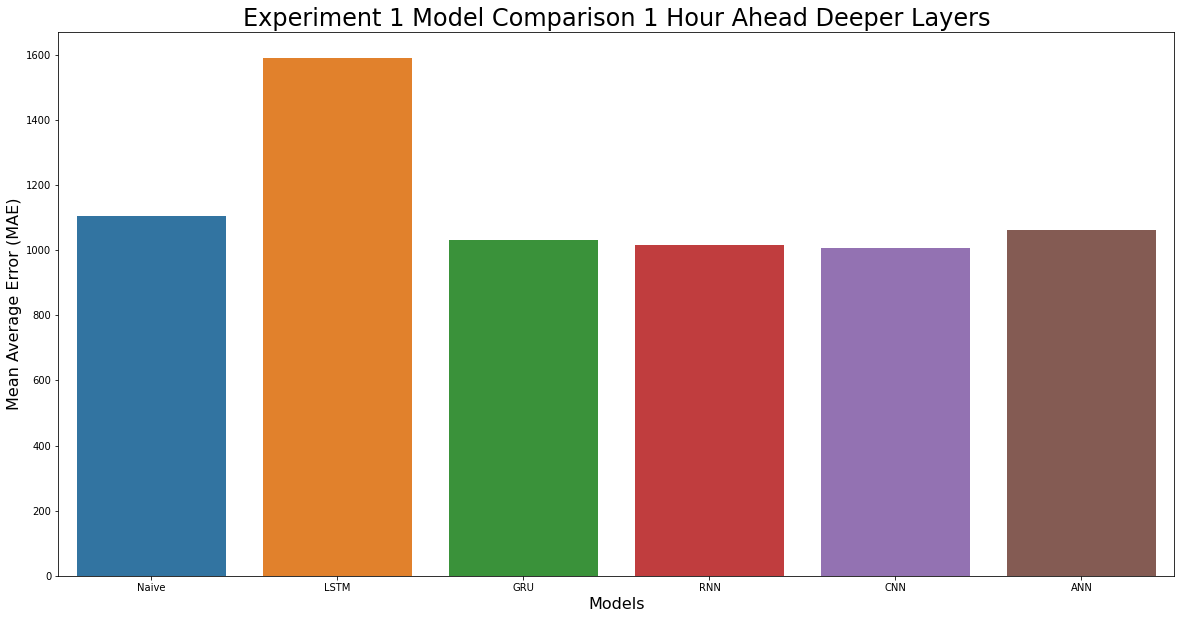

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 1 Model Comparison 1 Hour Ahead Deeper Layers", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

##**Experiment 2 - `Effective GWAP` + `Rolling Average`**



In [ ]:
ex2_df = df_copy.drop(df_copy.columns[2:], axis=1)
ex2_df

Effective GWAP  Rolling Average
Date_Interval                                       
2015-01-23 00:00:00     1849.604375      4357.651316
2015-01-23 01:00:00     1882.363158      4359.075739
2015-01-23 02:00:00     1886.543140      4359.488924
2015-01-23 03:00:00     1888.939469      4353.817912
2015-01-23 04:00:00     4000.262110      4360.450629
...                             ...              ...
2021-06-25 19:00:00     4582.463868      6823.492048
2021-06-25 20:00:00    13468.269470      6871.667956
2021-06-25 21:00:00     8069.676643      6866.547378
2021-06-25 22:00:00     3628.883036      6860.123532
2021-06-25 23:00:00     2975.500891      6856.019752

[56304 rows x 2 columns]

In [ ]:
ex2_train_df = ex2_df[0:train_end_idx]
ex2_val_df = ex2_df[train_end_idx:val_end_idx]
ex2_test_df = ex2_df[val_end_idx:test_end_idx]

###**Forecast 1 hour ahead**

In [ ]:
input_width = 24
label_width = 1
shift = 1

ex2_1hour_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex2_train_df, val_df=ex2_val_df, test_df=ex2_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex2_1hour_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 2)
(32, 1)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex2_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex2_1hour_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex2_df.shape[-1])
input_shape

(24, 2)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_lstm_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex2_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex2_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 36s 25ms/step - loss: 2059.4905 - val_loss: 786.8272 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1705.4580 - val_loss: 769.4166 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1561.8364 - val_loss: 814.5428 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1523.9004 - val_loss: 816.6493 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1496.9385 - val_loss: 726.8065 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1329.2928 - val_loss: 766.0125 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1275.5402 - val_loss: 784.6717 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1268.4030 - val_loss: 718.5557 - lr: 0.0010
Epoch 9/100
1407

In [ ]:
lstm = keras.models.load_model(path + '/models/ex2_lstm_1hour_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1067.4183

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex2_gru_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex2_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex2_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 35s 24ms/step - loss: 947.8459 - val_loss: 484.2160 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 34s 24ms/step - loss: 826.2814 - val_loss: 462.5532 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 812.5674 - val_loss: 468.8130 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 804.5161 - val_loss: 463.8969 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 803.8265 - val_loss: 465.2096 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 34s 24ms/step - loss: 796.0530 - val_loss: 459.4807 - lr: 8.0000e-04
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 795.6073 - val_loss: 466.5744 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 34s 24ms/step - loss: 792.4106 - val_loss: 463.5092 - lr: 8.0000e-04
Epoch 9/100


In [ ]:
gru = keras.models.load_model(path + '/models/ex2_gru_1hour_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1063.4906

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_rnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex2_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex2_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 19s 13ms/step - loss: 893.0574 - val_loss: 463.9888 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 18s 13ms/step - loss: 806.8455 - val_loss: 467.1718 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 799.7032 - val_loss: 472.3934 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 19s 13ms/step - loss: 789.7993 - val_loss: 471.1471 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 19s 13ms/step - loss: 776.0975 - val_loss: 466.7962 - lr: 8.0000e-04
Epoch 6/100
1407/1407 [==============================] - 18s 13ms/step - loss: 770.1252 - val_loss: 462.2558 - lr: 8.0000e-04
Epoch 7/100
1407/1407 [==============================] - 19s 14ms/step - loss: 762.4044 - val_loss: 462.1788 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 19s 13ms/step - loss: 758.6627 - val_loss: 464.8826 - lr: 8.0000e-04
Epoch 9/

In [ ]:
rnn = keras.models.load_model(path + '/models/ex2_rnn_1hour_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1035.3865

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_cnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex2_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex2_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1003.2350 - val_loss: 504.9797 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 9s 7ms/step - loss: 854.9603 - val_loss: 489.5359 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 825.4948 - val_loss: 471.5051 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 9s 7ms/step - loss: 830.4487 - val_loss: 470.0681 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 814.2304 - val_loss: 467.7187 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 833.4100 - val_loss: 473.6100 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 9s 6ms/step - loss: 824.0343 - val_loss: 469.1490 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 9s 6ms/step - loss: 839.2705 - val_loss: 468.3282 - lr: 0.0010
Epoch 9/100
1407/1407 [===============

In [ ]:
cnn = keras.models.load_model(path + '/models/ex2_cnn_1hour_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1004.15576

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_ann_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex2_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex2_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 7s 5ms/step - loss: 888.1033 - val_loss: 481.5130 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 7s 5ms/step - loss: 828.7545 - val_loss: 468.2131 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 8s 5ms/step - loss: 827.6750 - val_loss: 468.0873 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 828.3727 - val_loss: 473.5354 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 819.2269 - val_loss: 466.5164 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 813.5127 - val_loss: 466.0498 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 7s 5ms/step - loss: 813.1571 - val_loss: 466.6110 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 7s 5ms/step - loss: 810.7233 - val_loss: 467.7646 - lr: 0.0010
Epoch 9/100
1407/1407 [=================

In [ ]:
ann = keras.models.load_model(path + '/models/ex2_ann_1hour_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1051.8007

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  1104.352951  1067.418335  1063.490601  1035.386475  1004.155762   

           ANN  
0  1051.800659

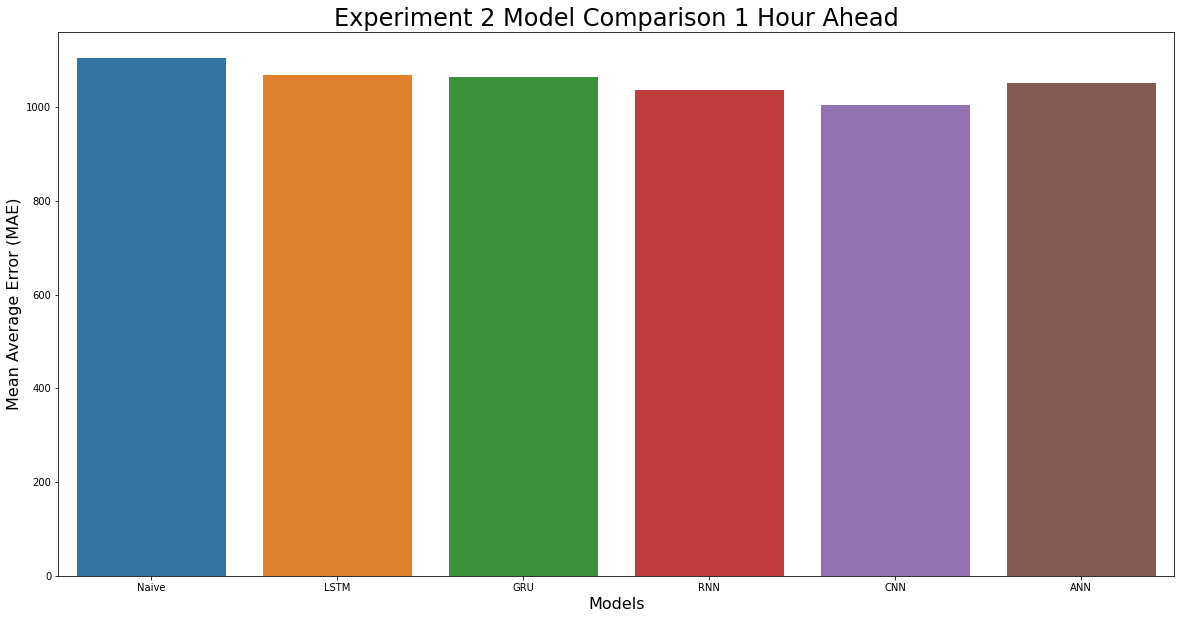

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 2 Model Comparison 1 Hour Ahead", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead**

In [ ]:
input_width = 24
label_width = 12
shift = 1

ex2_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex2_train_df, val_df=ex2_val_df, test_df=ex2_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex2_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 2)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex2_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex2_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex2_df.shape[-1])
input_shape

(24, 2)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1101.2762310150465

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_lstm_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex2_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex2_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 38s 26ms/step - loss: 1588.7734 - val_loss: 715.5001 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1896.7877 - val_loss: 1104.8597 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1111.3928 - val_loss: 556.0994 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1208.7626 - val_loss: 555.9643 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1261.5553 - val_loss: 1451.0598 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 36s 25ms/step - loss: 989.2296 - val_loss: 476.5542 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 37s 26ms/step - loss: 790.6473 - val_loss: 398.2909 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 38s 27ms/step - loss: 734.7276 - val_loss: 394.3930 - lr: 0.0010
Epoch 9/100
1407/

In [ ]:
lstm = keras.models.load_model(path + '/models/ex2_lstm_12hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

91.20635

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex2_gru_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex2_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 36s 25ms/step - loss: 428.1504 - val_loss: 91.0109 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 143.2047 - val_loss: 73.1340 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 129.9444 - val_loss: 60.0085 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 116.2458 - val_loss: 62.4805 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 35s 25ms/step - loss: 111.5004 - val_loss: 59.7436 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 36s 26ms/step - loss: 105.3513 - val_loss: 56.1649 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 36s 26ms/step - loss: 104.6321 - val_loss: 53.3761 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 35s 25ms/step - loss: 100.4069 - val_loss: 52.5195 - lr: 0.0010
Epoch 9/100
1407/1407 [=========

In [ ]:
gru = keras.models.load_model(path + '/models/ex2_gru_12hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

90.16971

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_rnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex2_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 20s 14ms/step - loss: 294.3984 - val_loss: 87.7043 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 19s 14ms/step - loss: 148.2529 - val_loss: 70.2112 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 20s 14ms/step - loss: 130.1609 - val_loss: 75.6573 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 19s 14ms/step - loss: 120.8589 - val_loss: 61.9931 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 20s 14ms/step - loss: 115.5759 - val_loss: 66.8093 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 18s 13ms/step - loss: 113.1012 - val_loss: 84.0489 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 19s 13ms/step - loss: 110.2547 - val_loss: 61.9481 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 20s 14ms/step - loss: 108.1572 - val_loss: 53.0128 - lr: 0.0010
Epoch 9/100
1407/1407 [=========

In [ ]:
rnn = keras.models.load_model(path + '/models/ex2_rnn_12hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

90.68793

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex2_cnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex2_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 11s 7ms/step - loss: 494.9412 - val_loss: 132.0879 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 9s 7ms/step - loss: 210.8853 - val_loss: 127.2220 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 194.3014 - val_loss: 100.4846 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 175.1868 - val_loss: 114.5746 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 158.0442 - val_loss: 102.2381 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 155.1660 - val_loss: 117.3596 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 131.4822 - val_loss: 76.2915 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 10s 7ms/step - loss: 139.4119 - val_loss: 78.8430 - lr: 8.0000e-04
Epoch 9/100
1407/1407 [====

In [ ]:
cnn = keras.models.load_model(path + '/models/ex2_cnn_12hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

87.97705

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_ann_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex2_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 8s 6ms/step - loss: 338.1393 - val_loss: 86.5290 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 7s 5ms/step - loss: 158.9626 - val_loss: 77.8442 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 145.8839 - val_loss: 84.3286 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 9s 7ms/step - loss: 136.6440 - val_loss: 65.6131 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 128.3985 - val_loss: 76.4052 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 128.2083 - val_loss: 66.5666 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 119.5903 - val_loss: 62.8060 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 121.6000 - val_loss: 69.1998 - lr: 0.0010
Epoch 9/100
1407/1407 [=========================

In [ ]:
ann = keras.models.load_model(path + '/models/ex2_ann_12hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

88.880875

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive       LSTM        GRU        RNN        CNN        ANN
0  1101.276231  91.206352  90.169708  90.687927  87.977051  88.880875

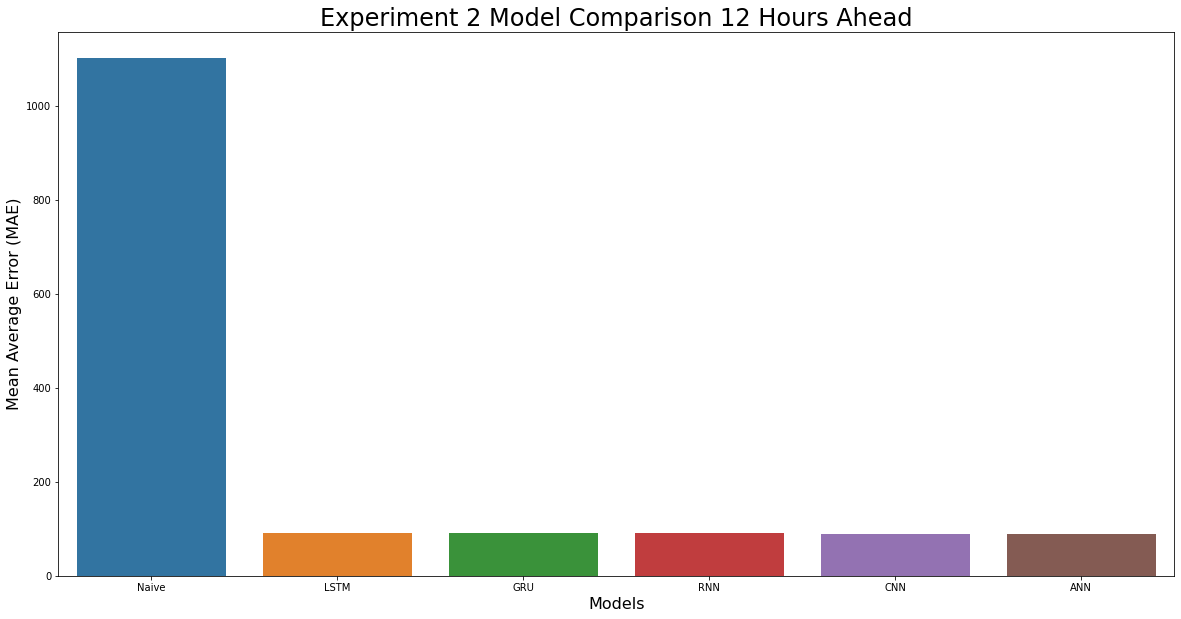

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 2 Model Comparison 12 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead 12 hour shift**

In [ ]:
input_width = 24
label_width = 12
shift = 12

ex2_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex2_train_df, val_df=ex2_val_df, test_df=ex2_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex2_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 2)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex2_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex2_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex2_df.shape[-1])
input_shape

(24, 2)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

2667.674529034868

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_lstm_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex2_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex2_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
118/118 [==============================] - 7s 41ms/step - loss: 1488.5371 - val_loss: 988.0891 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 5s 41ms/step - loss: 1622.4595 - val_loss: 936.3076 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 5s 39ms/step - loss: 1308.9281 - val_loss: 866.4405 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 5s 39ms/step - loss: 1285.0183 - val_loss: 970.7092 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 5s 42ms/step - loss: 1249.4099 - val_loss: 910.1947 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 5s 41ms/step - loss: 1422.4932 - val_loss: 931.6766 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 5s 40ms/step - loss: 1275.7231 - val_loss: 861.6554 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 5s 40ms/step - loss: 1239.2345 - val_loss: 906.4981 - lr: 8.0000e-04
Epoch 9/100
118/118 [===========

In [ ]:
lstm = keras.models.load_model(path + '/models/ex2_lstm_12hours_ahead_12hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1765.8779

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex2_gru_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex2_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
118/118 [==============================] - 7s 42ms/step - loss: 1341.3596 - val_loss: 809.9079 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 6s 47ms/step - loss: 1124.0483 - val_loss: 791.5076 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 6s 49ms/step - loss: 1080.6323 - val_loss: 813.7861 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 6s 48ms/step - loss: 1059.2654 - val_loss: 811.4470 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 6s 48ms/step - loss: 1040.3545 - val_loss: 792.0966 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 5s 40ms/step - loss: 1025.0566 - val_loss: 796.2596 - lr: 8.0000e-04
Epoch 7/100
118/118 [==============================] - 5s 40ms/step - loss: 1020.8580 - val_loss: 789.2220 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 5s 38ms/step - loss: 1010.7926 - val_loss: 795.1993 - lr: 8.0000e-04
Epoch 9/100
118/118 [=======

In [ ]:
gru = keras.models.load_model(path + '/models/ex2_gru_12hours_ahead_12hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1684.3225

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_rnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex2_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 4s 24ms/step - loss: 1280.5376 - val_loss: 835.4652 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 3s 24ms/step - loss: 1076.9893 - val_loss: 800.8991 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 3s 23ms/step - loss: 1045.2130 - val_loss: 794.9545 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 3s 23ms/step - loss: 1021.2820 - val_loss: 785.8611 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 3s 22ms/step - loss: 1004.3206 - val_loss: 797.5477 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 3s 22ms/step - loss: 994.9978 - val_loss: 798.5726 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 3s 22ms/step - loss: 986.6747 - val_loss: 798.6812 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 2s 21ms/step - loss: 975.8395 - val_loss: 804.6902 - lr: 8.0000e-04
Epoch 9/100
118/118 [==================

In [ ]:
rnn = keras.models.load_model(path + '/models/ex2_rnn_12hours_ahead_12hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1773.6213

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex2_cnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex2_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 1s 9ms/step - loss: 1414.2716 - val_loss: 858.1906 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 9ms/step - loss: 1193.0980 - val_loss: 840.5759 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 10ms/step - loss: 1112.7662 - val_loss: 808.5088 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 10ms/step - loss: 1077.5083 - val_loss: 813.9104 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 9ms/step - loss: 1053.0093 - val_loss: 824.1320 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 9ms/step - loss: 1033.8293 - val_loss: 817.3879 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 9ms/step - loss: 1018.8152 - val_loss: 826.3155 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 1s 8ms/step - loss: 1007.7756 - val_loss: 825.4485 - lr: 8.0000e-04
Epoch 9/100
118/118 [=================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex2_cnn_12hours_ahead_12hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1649.3953

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_ann_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex2_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
118/118 [==============================] - 2s 10ms/step - loss: 1305.9546 - val_loss: 842.4265 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 9ms/step - loss: 1084.7604 - val_loss: 833.6713 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 9ms/step - loss: 1060.5940 - val_loss: 800.4770 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 9ms/step - loss: 1051.0378 - val_loss: 801.0119 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 8ms/step - loss: 1042.3889 - val_loss: 803.4304 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 8ms/step - loss: 1027.7504 - val_loss: 797.8409 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 8ms/step - loss: 1020.6675 - val_loss: 809.6796 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 1s 9ms/step - loss: 1013.8625 - val_loss: 808.6400 - lr: 0.0010
Epoch 9/100
118/118 [==========================

In [ ]:
ann = keras.models.load_model(path + '/models/ex2_ann_12hours_ahead_12hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1724.4857

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive        LSTM         GRU          RNN          CNN          ANN
0  2667.674529  1765.87793  1684.32251  1773.621338  1649.395264  1724.485718

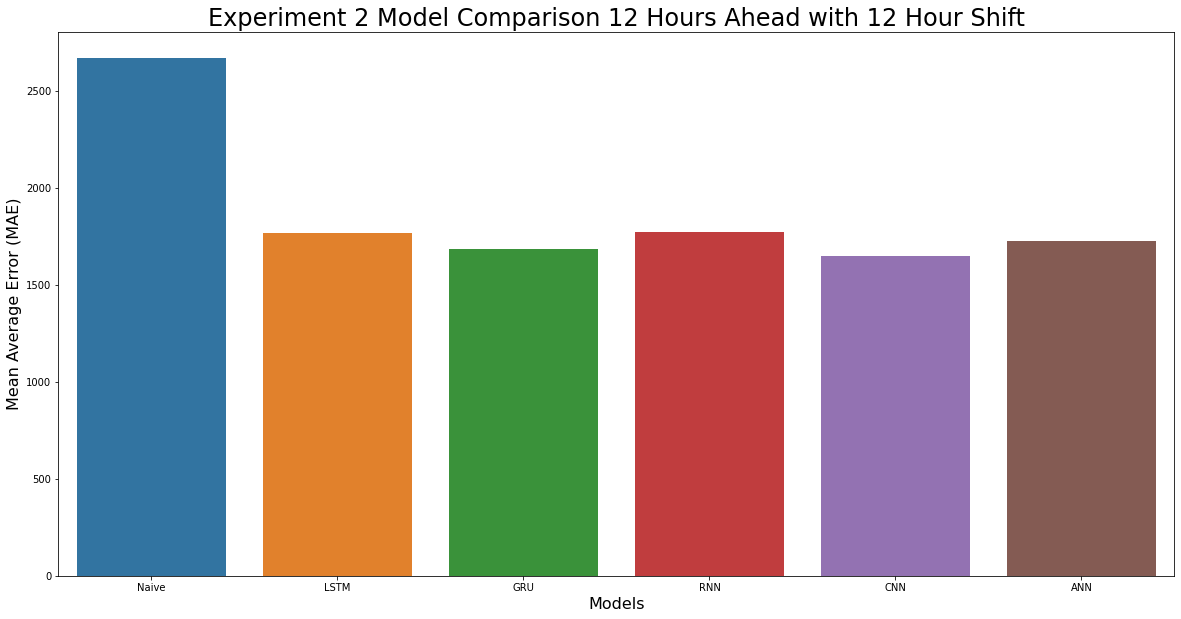

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 2 Model Comparison 12 Hours Ahead with 12 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead**

In [ ]:
input_width = 24
label_width = 24
shift = 1

ex2_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex2_train_df, val_df=ex2_val_df, test_df=ex2_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex2_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 2)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex2_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex2_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex2_df.shape[-1])
input_shape

(24, 2)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1098.3518162532384

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_lstm_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex2_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex2_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 35s 24ms/step - loss: 953.5657 - val_loss: 544.5518 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 766.3102 - val_loss: 339.1404 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 536.3414 - val_loss: 256.9297 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 422.9257 - val_loss: 175.3913 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 35s 25ms/step - loss: 242.9408 - val_loss: 100.0763 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 34s 24ms/step - loss: 156.9837 - val_loss: 82.9738 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 141.3986 - val_loss: 70.1714 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 36s 25ms/step - loss: 120.4560 - val_loss: 55.8262 - lr: 0.0010
Epoch 9/100
1407/1407 [====

In [ ]:
lstm = keras.models.load_model(path + '/models/ex2_lstm_24hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

45.449657

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_gru_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex2_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 33s 23ms/step - loss: 373.8221 - val_loss: 64.0413 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 32s 23ms/step - loss: 101.5208 - val_loss: 53.1771 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 32s 23ms/step - loss: 85.2562 - val_loss: 43.5578 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 34s 24ms/step - loss: 78.5151 - val_loss: 39.6266 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 32s 23ms/step - loss: 79.5588 - val_loss: 46.6117 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 32s 23ms/step - loss: 73.9072 - val_loss: 40.8491 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 32s 23ms/step - loss: 69.6361 - val_loss: 34.6185 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 34s 24ms/step - loss: 72.4243 - val_loss: 36.9940 - lr: 0.0010
Epoch 9/100
1407/1407 [===============

In [ ]:
gru = keras.models.load_model(path + '/models/ex2_gru_24hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

45.5782

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_rnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex2_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 16s 10ms/step - loss: 273.1754 - val_loss: 73.5962 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 15s 11ms/step - loss: 114.9675 - val_loss: 55.4023 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 15s 11ms/step - loss: 97.6058 - val_loss: 46.1922 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 86.5583 - val_loss: 40.2512 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 15s 10ms/step - loss: 80.9064 - val_loss: 42.3510 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 15s 11ms/step - loss: 75.7871 - val_loss: 47.1405 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 75.1077 - val_loss: 39.8458 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 15s 11ms/step - loss: 67.9415 - val_loss: 39.7168 - lr: 0.0010
Epoch 9/100
1407/1407 [===============

In [ ]:
rnn = keras.models.load_model(path + '/models/ex2_rnn_24hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

45.05126

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_cnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex2_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 8s 6ms/step - loss: 367.5509 - val_loss: 107.3206 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 163.7914 - val_loss: 104.0360 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 136.6510 - val_loss: 64.8476 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 125.2829 - val_loss: 68.1251 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 116.2125 - val_loss: 67.7973 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 116.4594 - val_loss: 63.7492 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 104.4796 - val_loss: 64.9416 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 109.0239 - val_loss: 67.1887 - lr: 0.0010
Epoch 9/100
1407/1407 [=======================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex2_cnn_24hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

46.553215

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_ann_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex2_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 7s 5ms/step - loss: 295.2099 - val_loss: 67.0965 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 7s 5ms/step - loss: 129.0100 - val_loss: 68.6562 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 111.3265 - val_loss: 57.1645 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 8s 5ms/step - loss: 104.8216 - val_loss: 47.6096 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 5ms/step - loss: 101.3222 - val_loss: 49.6182 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 95.6050 - val_loss: 44.3875 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 7s 5ms/step - loss: 90.6571 - val_loss: 46.0889 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 88.6979 - val_loss: 46.6380 - lr: 0.0010
Epoch 9/100
1407/1407 [============================

In [ ]:
ann = keras.models.load_model(path + '/models/ex2_ann_24hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

45.372543

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive       LSTM        GRU        RNN        CNN        ANN
0  1098.351816  45.449657  45.578201  45.051262  46.553215  45.372543

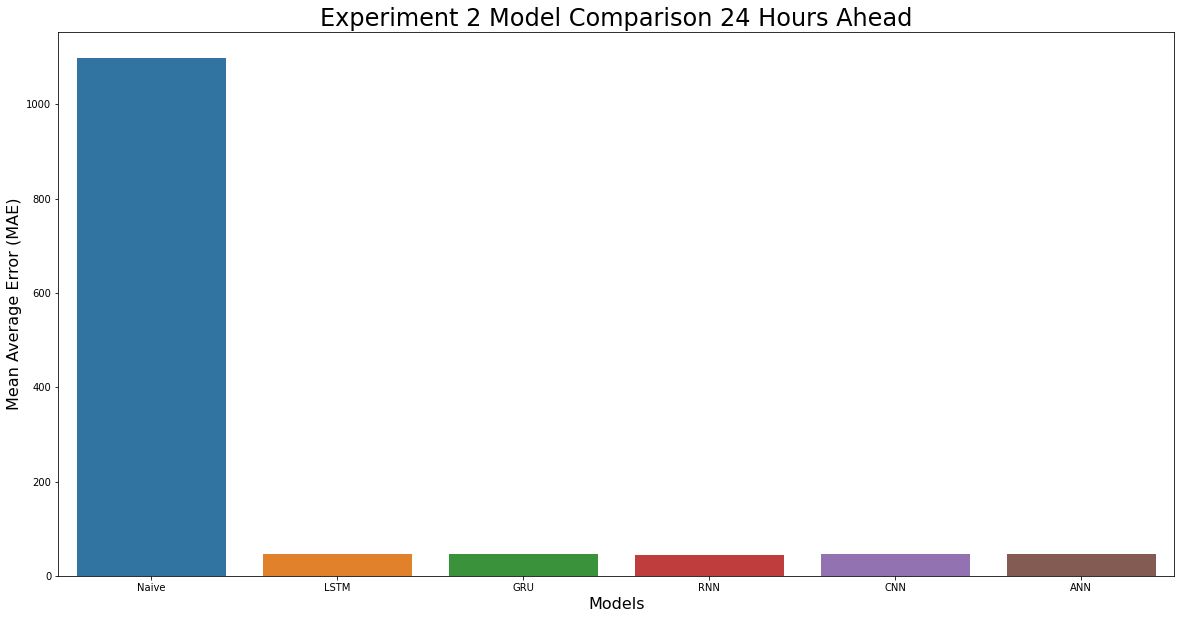

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 2 Model Comparison 24 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead 24 hour shift**

In [ ]:
input_width = 24
label_width = 24
shift = 24

ex2_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex2_train_df, val_df=ex2_val_df, test_df=ex2_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex2_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 2)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex2_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex2_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex2_df.shape[-1])
input_shape

(24, 2)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1722.1445946783263

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_lstm_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex2_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex2_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
59/59 [==============================] - 3s 31ms/step - loss: 1627.5939 - val_loss: 1063.8789 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 27ms/step - loss: 1426.6099 - val_loss: 1156.9878 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 30ms/step - loss: 1346.5785 - val_loss: 1058.4952 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 29ms/step - loss: 1296.1664 - val_loss: 968.8357 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 27ms/step - loss: 1269.2384 - val_loss: 954.7435 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 29ms/step - loss: 1254.7312 - val_loss: 877.7341 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 2s 28ms/step - loss: 1235.7832 - val_loss: 904.8342 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 2s 29ms/step - loss: 1228.2902 - val_loss: 872.9776 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 

In [ ]:
lstm = keras.models.load_model(path + '/models/ex2_lstm_24hours_ahead_24hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

2350.6138

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex2_gru_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex2_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
59/59 [==============================] - 3s 33ms/step - loss: 1485.6548 - val_loss: 966.1936 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 27ms/step - loss: 1204.3799 - val_loss: 875.3021 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 26ms/step - loss: 1178.1616 - val_loss: 858.0423 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 26ms/step - loss: 1151.4226 - val_loss: 847.7507 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 27ms/step - loss: 1146.4385 - val_loss: 840.2017 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 27ms/step - loss: 1138.5760 - val_loss: 832.3314 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 2s 26ms/step - loss: 1131.6586 - val_loss: 828.8823 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 2s 29ms/step - loss: 1126.1906 - val_loss: 829.7858 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 2s 

In [ ]:
gru = keras.models.load_model(path + '/models/ex2_gru_24hours_ahead_24hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1975.0623

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_rnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex2_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 2s 19ms/step - loss: 1388.3828 - val_loss: 943.7397 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 18ms/step - loss: 1181.6135 - val_loss: 826.5444 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 17ms/step - loss: 1144.6432 - val_loss: 814.4672 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 17ms/step - loss: 1124.9988 - val_loss: 804.8814 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 17ms/step - loss: 1110.2498 - val_loss: 791.5538 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 16ms/step - loss: 1104.7656 - val_loss: 792.0595 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 18ms/step - loss: 1097.2812 - val_loss: 791.1511 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 16ms/step - loss: 1093.1292 - val_loss: 798.9492 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1s 

In [ ]:
rnn = keras.models.load_model(path + '/models/ex2_rnn_24hours_ahead_24hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

2097.8538

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex2_cnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex2_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 12ms/step - loss: 1427.6490 - val_loss: 1075.8573 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 11ms/step - loss: 1229.5028 - val_loss: 969.5816 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 11ms/step - loss: 1195.1913 - val_loss: 947.1475 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 12ms/step - loss: 1183.7135 - val_loss: 919.6456 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 16ms/step - loss: 1170.3623 - val_loss: 920.9020 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 14ms/step - loss: 1161.1051 - val_loss: 889.8239 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 13ms/step - loss: 1149.6812 - val_loss: 932.8287 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 16ms/step - loss: 1154.9619 - val_loss: 888.5000 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1s

In [ ]:
cnn = keras.models.load_model(path + '/models/ex2_cnn_24hours_ahead_24hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

2319.217

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_ann_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex2_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex2_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 14ms/step - loss: 1413.1566 - val_loss: 868.7386 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 12ms/step - loss: 1184.5615 - val_loss: 858.4105 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 15ms/step - loss: 1148.0417 - val_loss: 825.1921 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 15ms/step - loss: 1129.6984 - val_loss: 813.3663 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 13ms/step - loss: 1121.6571 - val_loss: 792.6481 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 13ms/step - loss: 1112.3636 - val_loss: 799.0052 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 14ms/step - loss: 1108.3691 - val_loss: 804.7022 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 12ms/step - loss: 1101.1868 - val_loss: 796.4221 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1s 

In [ ]:
ann = keras.models.load_model(path + '/models/ex2_ann_24hours_ahead_24hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

2201.3682

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive        LSTM          GRU         RNN          CNN          ANN
0  1722.144595  2350.61377  1975.062256  2097.85376  2319.217041  2201.368164

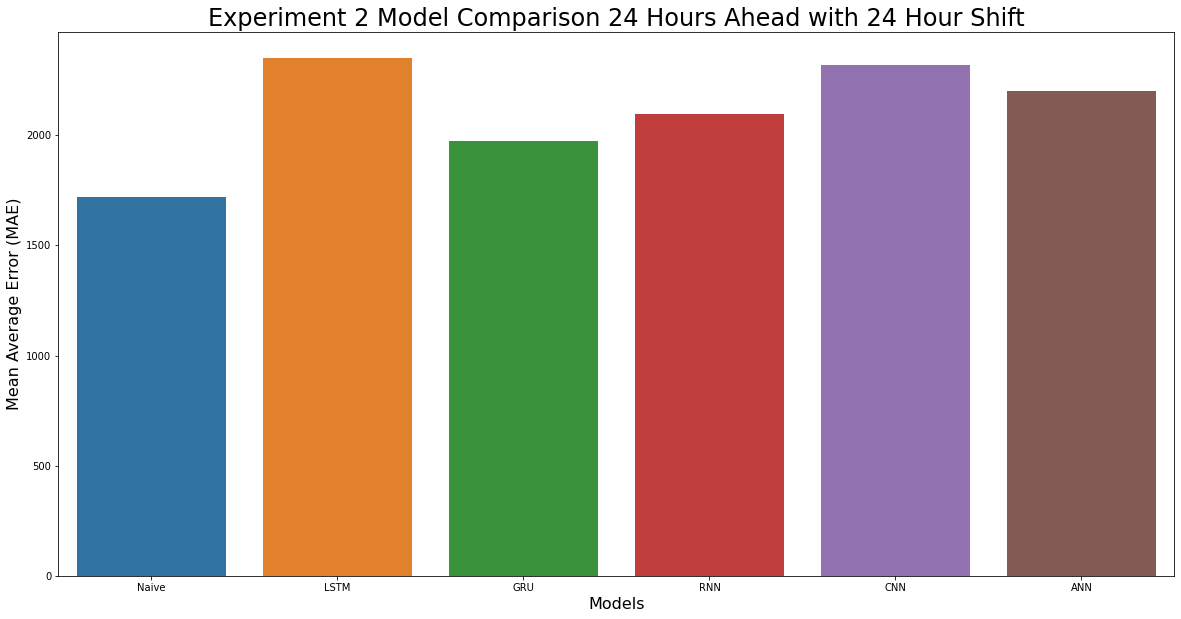

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 2 Model Comparison 24 Hours Ahead with 24 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Deeper Layers (1 hour ahead)** 

In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex2_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex2_1hour_ahead.test], axis=0)

input_shape = (input_width, ex2_df.shape[-1])
input_shape

(24, 2)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_lstm_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex2_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex2_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 93s 64ms/step - loss: 1870.0215 - val_loss: 949.0820 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 90s 64ms/step - loss: 1595.0325 - val_loss: 824.4847 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 150s 107ms/step - loss: 1318.0663 - val_loss: 755.7960 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 142s 101ms/step - loss: 1317.7400 - val_loss: 774.0634 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 143s 102ms/step - loss: 1288.6145 - val_loss: 810.7448 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 147s 105ms/step - loss: 1237.8174 - val_loss: 730.2529 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 139s 99ms/step - loss: 1221.9360 - val_loss: 723.2282 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 96s 68ms/step - loss: 1214.4242 - val_loss: 729.9786 - lr: 0.0010
Epoch 9

In [ ]:
lstm = keras.models.load_model(path + '/models/ex2_lstm_3layers.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1530.1097

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex2_gru_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex2_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex2_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 87s 59ms/step - loss: 1052.6680 - val_loss: 504.3470 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 82s 59ms/step - loss: 860.0290 - val_loss: 473.7128 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 83s 59ms/step - loss: 824.2866 - val_loss: 463.2284 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 83s 59ms/step - loss: 815.5624 - val_loss: 470.9133 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 83s 59ms/step - loss: 808.7659 - val_loss: 469.8019 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 82s 59ms/step - loss: 804.9000 - val_loss: 469.9916 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 83s 59ms/step - loss: 808.9482 - val_loss: 463.0819 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 84s 59ms/step - loss: 806.3606 - val_loss: 468.2763 - lr: 8.0000e-04
Epoch 9/100
140

In [ ]:
gru = keras.models.load_model(path + '/models/ex2_gru_3layers.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1057.3232

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_rnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex2_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex2_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 40s 27ms/step - loss: 907.6985 - val_loss: 473.4704 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 38s 27ms/step - loss: 819.5549 - val_loss: 464.0721 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 37s 27ms/step - loss: 803.0847 - val_loss: 472.9603 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 37s 26ms/step - loss: 788.0626 - val_loss: 468.0730 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 38s 27ms/step - loss: 779.5728 - val_loss: 472.7382 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 38s 27ms/step - loss: 764.6981 - val_loss: 465.8405 - lr: 8.0000e-04
Epoch 7/100
1407/1407 [==============================] - 37s 26ms/step - loss: 757.9609 - val_loss: 463.4002 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 37s 26ms/step - loss: 754.2866 - val_loss: 461.9320 - lr: 8.0000e-04
Epoch 9/100


In [ ]:
rnn = keras.models.load_model(path + '/models/ex2_rnn_3layers.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1035.4796

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_cnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex2_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex2_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 123s 87ms/step - loss: 1247.5559 - val_loss: 630.2018 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 121s 86ms/step - loss: 951.4806 - val_loss: 524.7538 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 124s 88ms/step - loss: 862.8045 - val_loss: 505.8693 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 124s 88ms/step - loss: 846.3359 - val_loss: 503.0942 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 124s 88ms/step - loss: 830.7403 - val_loss: 491.9121 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 123s 88ms/step - loss: 818.7581 - val_loss: 488.0051 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 124s 88ms/step - loss: 805.5369 - val_loss: 491.5078 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 124s 88ms/step - loss: 798.5571 - val_loss: 484.8216 - lr: 0.0010
Epoch 9/100
140

In [ ]:
cnn = keras.models.load_model(path + '/models/ex2_cnn_3layers.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

971.38605

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex2_ann_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex2_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex2_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 13s 9ms/step - loss: 905.4049 - val_loss: 463.7634 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 830.9539 - val_loss: 462.7159 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 824.2440 - val_loss: 462.0482 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 13s 9ms/step - loss: 822.5906 - val_loss: 464.6088 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 12s 9ms/step - loss: 816.2938 - val_loss: 460.3573 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 12s 9ms/step - loss: 812.2146 - val_loss: 458.0749 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 12s 8ms/step - loss: 810.6569 - val_loss: 459.2457 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 13s 9ms/step - loss: 808.7734 - val_loss: 456.7193 - lr: 0.0010
Epoch 9/100
1407/1407 [========

In [ ]:
ann = keras.models.load_model(path + '/models/ex2_ann_3layers.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1051.6769

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM          GRU          RNN         CNN         ANN
0  1104.352951  1530.109741  1057.323242  1035.479614  971.386047  1051.67688

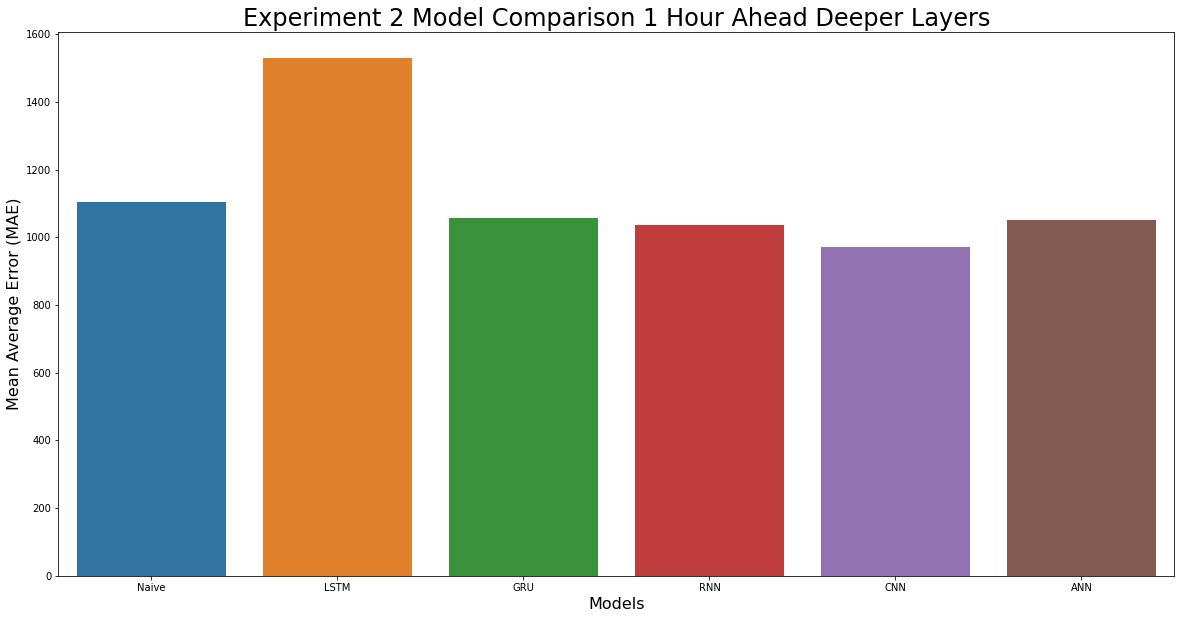

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 2 Model Comparison 1 Hour Ahead Deeper Layers", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

##**Experiment 3 - `Effective GWAP` + `Rolling Average` + datetime**



In [104]:
ex3_df = df_copy.drop(df_copy.columns[10:], axis=1)
ex3_df

Effective GWAP  Rolling Average  month  weekday  hour  \
Date_Interval                                                                
2015-01-23 00:00:00     1849.604375      4357.651316      1        4     0   
2015-01-23 01:00:00     1882.363158      4359.075739      1        4     1   
2015-01-23 02:00:00     1886.543140      4359.488924      1        4     2   
2015-01-23 03:00:00     1888.939469      4353.817912      1        4     3   
2015-01-23 04:00:00     4000.262110      4360.450629      1        4     4   
...                             ...              ...    ...      ...   ...   
2021-06-25 19:00:00     4582.463868      6823.492048      6        4    19   
2021-06-25 20:00:00    13468.269470      6871.667956      6        4    20   
2021-06-25 21:00:00     8069.676643      6866.547378      6        4    21   
2021-06-25 22:00:00     3628.883036      6860.123532      6        4    22   
2021-06-25 23:00:00     2975.500891      6856.019752      6        4    23   

                     morning  mid day  evening  weekend  season  
Date_Interval                                                    
2015-01-23 00:00:00      1.0      0.0      0.0      0.0     0.0  
2015-01-23 01:00:00      1.0      0.0      0.0      0.0     0.0  
2015-01-23 02:00:00      1.0      0.0      0.0      0.0     0.0  
2015-01-23 03:00:00      1.0      0.0      0.0      0.0     0.0  
2015-01-23 04:00:00      1.0      0.0      0.0      0.0     0.0  
...                      ...      ...      ...      ...     ...  
2021-06-25 19:00:00      0.0      0.0      1.0      0.0     1.0  
2021-06-25 20:00:00      0.0      0.0      1.0      0.0     1.0  
2021-06-25 21:00:00      0.0      0.0      1.0      0.0     1.0  
2021-06-25 22:00:00      0.0      0.0      1.0      0.0     1.0  
2021-06-25 23:00:00      0.0      0.0      1.0      0.0     1.0  

[56304 rows x 10 columns]

In [105]:
ex3_train_df = ex3_df[0:train_end_idx]
ex3_val_df = ex3_df[train_end_idx:val_end_idx]
ex3_test_df = ex3_df[val_end_idx:test_end_idx]

###**Forecast 1 hour ahead**

In [ ]:
input_width = 24
label_width = 1
shift = 1

ex3_1hour_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex3_train_df, val_df=ex3_val_df, test_df=ex3_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex3_1hour_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 10)
(32, 1)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex3_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex3_1hour_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex3_df.shape[-1])
input_shape

(24, 10)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_lstm_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex3_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex3_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 31s 21ms/step - loss: 1453.6549 - val_loss: 810.7268 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1384.2240 - val_loss: 697.7057 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1215.1597 - val_loss: 662.3893 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 29s 21ms/step - loss: 1304.6770 - val_loss: 667.6909 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1183.2893 - val_loss: 620.5398 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1053.9739 - val_loss: 575.8065 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 30s 21ms/step - loss: 1191.7164 - val_loss: 634.1373 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 30s 22ms/step - loss: 1059.8105 - val_loss: 804.9051 - lr: 0.0010
Epoch 9/100
1407

In [ ]:
lstm = keras.models.load_model(path + '/models/ex3_lstm_1hour_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1073.3016

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex3_gru_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex3_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex3_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 29s 20ms/step - loss: 946.9936 - val_loss: 476.1936 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 29s 21ms/step - loss: 827.1545 - val_loss: 465.5956 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 28s 20ms/step - loss: 814.5731 - val_loss: 460.5001 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 27s 19ms/step - loss: 806.7100 - val_loss: 462.9846 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 29s 21ms/step - loss: 805.5423 - val_loss: 457.3904 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 29s 20ms/step - loss: 803.0611 - val_loss: 465.8208 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 28s 20ms/step - loss: 813.4178 - val_loss: 463.1263 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 28s 20ms/step - loss: 797.4750 - val_loss: 466.3711 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
gru = keras.models.load_model(path + '/models/ex3_gru_1hour_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1063.4366

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_rnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex3_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex3_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 15s 10ms/step - loss: 885.9116 - val_loss: 466.0571 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 809.5134 - val_loss: 464.2025 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 15s 11ms/step - loss: 800.6301 - val_loss: 463.7182 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 790.5198 - val_loss: 470.5934 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 15s 11ms/step - loss: 786.3869 - val_loss: 462.6432 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 15s 11ms/step - loss: 779.7350 - val_loss: 462.1670 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 768.6871 - val_loss: 460.8354 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 15s 11ms/step - loss: 763.0400 - val_loss: 459.3030 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
rnn = keras.models.load_model(path + '/models/ex3_rnn_1hour_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

949.168

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_cnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex3_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex3_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 12s 8ms/step - loss: 986.1760 - val_loss: 493.6992 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 11s 8ms/step - loss: 836.5470 - val_loss: 474.3183 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 11s 8ms/step - loss: 823.3984 - val_loss: 470.4135 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 824.2349 - val_loss: 474.8798 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 11s 8ms/step - loss: 803.0921 - val_loss: 478.2602 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 11s 8ms/step - loss: 813.9482 - val_loss: 472.4288 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 786.4850 - val_loss: 471.6865 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 10s 7ms/step - loss: 781.9418 - val_loss: 471.1385 - lr: 8.0000e-04
Epoch 9/100
1407/1407 [=

In [ ]:
cnn = keras.models.load_model(path + '/models/ex3_cnn_1hour_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1022.7747

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_ann_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex3_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex3_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 8s 5ms/step - loss: 899.0012 - val_loss: 471.5104 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 7s 5ms/step - loss: 831.2056 - val_loss: 461.3226 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 818.3287 - val_loss: 464.6497 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 7s 5ms/step - loss: 816.7391 - val_loss: 459.9020 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 816.4934 - val_loss: 475.3663 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 809.5900 - val_loss: 467.6747 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 7s 5ms/step - loss: 808.2782 - val_loss: 465.5209 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 7s 5ms/step - loss: 799.0098 - val_loss: 463.1479 - lr: 8.0000e-04
Epoch 9/100
1407/1407 [=============

In [ ]:
ann = keras.models.load_model(path + '/models/ex3_ann_1hour_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1030.5427

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM          GRU        RNN          CNN          ANN
0  1104.352951  1073.301636  1063.436646  949.16803  1022.774719  1030.542725

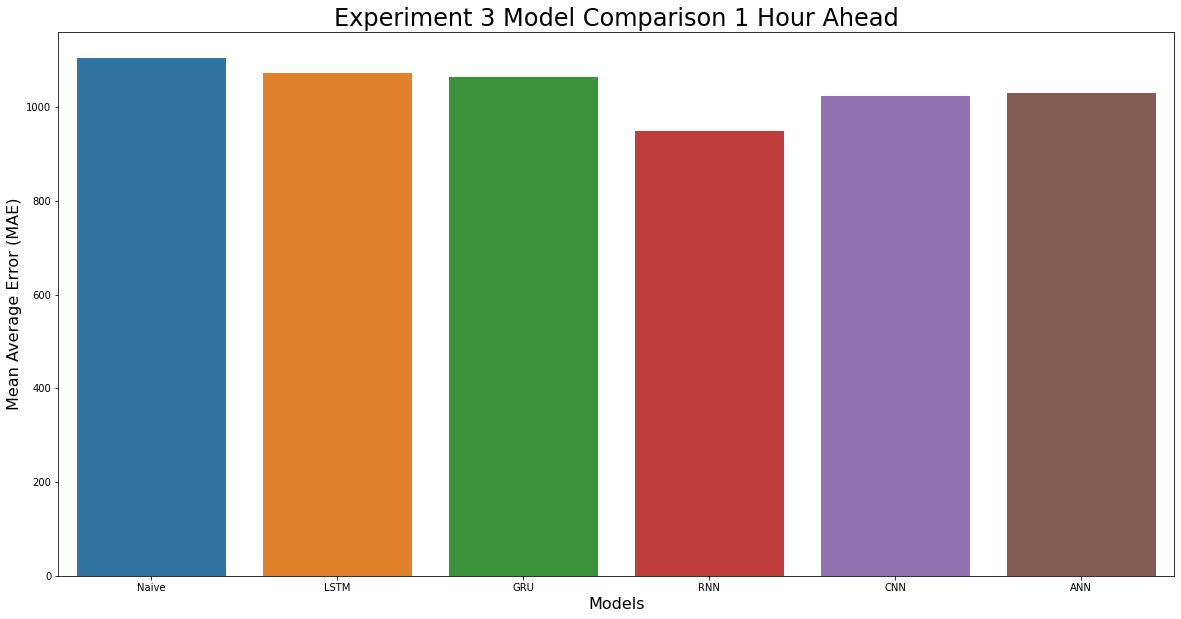

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 3 Model Comparison 1 Hour Ahead", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead**

In [ ]:
input_width = 24
label_width = 12
shift = 1

ex3_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex3_train_df, val_df=ex3_val_df, test_df=ex3_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex3_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 10)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex3_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex3_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex3_df.shape[-1])
input_shape

(24, 10)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1101.2762310150465

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_lstm_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex3_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex3_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 32s 22ms/step - loss: 1308.1947 - val_loss: 683.2294 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1084.0164 - val_loss: 718.6248 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1650.1328 - val_loss: 615.0109 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1014.0371 - val_loss: 546.9689 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 31s 22ms/step - loss: 955.9618 - val_loss: 424.6441 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 31s 22ms/step - loss: 613.7390 - val_loss: 323.4581 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 31s 22ms/step - loss: 529.8429 - val_loss: 1190.2740 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 32s 23ms/step - loss: 770.4415 - val_loss: 299.7704 - lr: 0.0010
Epoch 9/100
1407/14

In [ ]:
lstm = keras.models.load_model(path + '/models/ex3_lstm_12hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

93.099625

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex3_gru_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex3_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 31s 21ms/step - loss: 434.5311 - val_loss: 92.6609 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 29s 21ms/step - loss: 136.8240 - val_loss: 71.3554 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 29s 21ms/step - loss: 125.2099 - val_loss: 64.5805 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 30s 21ms/step - loss: 114.8668 - val_loss: 65.2173 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 29s 21ms/step - loss: 112.0662 - val_loss: 61.5341 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 30s 21ms/step - loss: 105.7039 - val_loss: 56.4892 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 30s 21ms/step - loss: 102.7536 - val_loss: 65.1494 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 29s 21ms/step - loss: 107.7423 - val_loss: 55.1854 - lr: 0.0010
Epoch 9/100
1407/1407 [=========

In [ ]:
gru = keras.models.load_model(path + '/models/ex3_gru_12hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

89.529106

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_rnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex3_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 18s 12ms/step - loss: 299.1643 - val_loss: 90.0123 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 144.7988 - val_loss: 69.8293 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 16s 12ms/step - loss: 136.4296 - val_loss: 64.7927 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 16s 12ms/step - loss: 118.8676 - val_loss: 61.5232 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 16s 12ms/step - loss: 114.1655 - val_loss: 57.4866 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 111.0212 - val_loss: 61.0320 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 16s 11ms/step - loss: 108.7372 - val_loss: 56.1794 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 16s 11ms/step - loss: 106.4673 - val_loss: 54.8572 - lr: 0.0010
Epoch 9/100
1407/1407 [=========

In [ ]:
rnn = keras.models.load_model(path + '/models/ex3_rnn_12hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

89.2676

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex3_cnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex3_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 12s 9ms/step - loss: 484.3333 - val_loss: 127.5900 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 12s 8ms/step - loss: 218.6584 - val_loss: 114.0660 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 11s 8ms/step - loss: 185.6231 - val_loss: 106.7996 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 12s 8ms/step - loss: 181.9682 - val_loss: 113.4200 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 11s 8ms/step - loss: 172.0646 - val_loss: 99.1449 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 11s 8ms/step - loss: 170.1403 - val_loss: 111.8806 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 12s 9ms/step - loss: 159.0596 - val_loss: 93.9447 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 12s 9ms/step - loss: 151.3201 - val_loss: 87.4416 - lr: 0.0010
Epoch 9/100
1407/1407 [============

In [ ]:
cnn = keras.models.load_model(path + '/models/ex3_cnn_12hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

90.31868

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_ann_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex3_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 8s 5ms/step - loss: 347.9852 - val_loss: 90.8132 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 8s 6ms/step - loss: 151.8963 - val_loss: 80.7196 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 144.3455 - val_loss: 76.2304 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 8s 5ms/step - loss: 133.9944 - val_loss: 71.4551 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 129.5907 - val_loss: 80.5192 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 131.8490 - val_loss: 67.3558 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 115.7918 - val_loss: 60.6082 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 121.2493 - val_loss: 62.8283 - lr: 0.0010
Epoch 9/100
1407/1407 [=========================

In [ ]:
ann = keras.models.load_model(path + '/models/ex3_ann_12hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

88.47265

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive       LSTM        GRU        RNN       CNN        ANN
0  1101.276231  93.099625  89.529106  89.267601  90.31868  88.472649

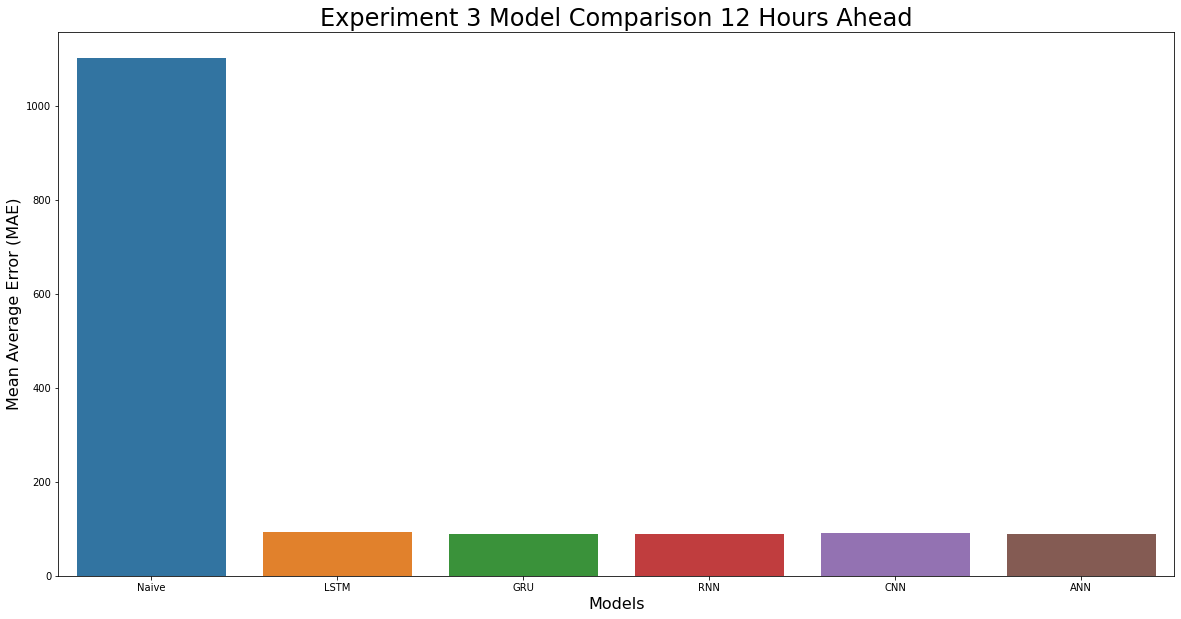

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 3 Model Comparison 12 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead 12 hour shift**

In [ ]:
input_width = 24
label_width = 12
shift = 12

ex3_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex3_train_df, val_df=ex3_val_df, test_df=ex3_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex3_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 10)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex3_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex3_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex3_df.shape[-1])
input_shape

(24, 10)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

2667.674529034868

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_lstm_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex3_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex3_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
118/118 [==============================] - 7s 45ms/step - loss: 1555.9874 - val_loss: 940.6794 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 5s 38ms/step - loss: 1485.9969 - val_loss: 950.5473 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 5s 40ms/step - loss: 1378.9707 - val_loss: 952.7792 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 5s 43ms/step - loss: 1321.5105 - val_loss: 921.7075 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 5s 41ms/step - loss: 1364.6187 - val_loss: 895.5847 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 6s 54ms/step - loss: 1293.0759 - val_loss: 900.0246 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 5s 41ms/step - loss: 1255.9637 - val_loss: 851.9010 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 5s 42ms/step - loss: 1224.4447 - val_loss: 919.1051 - lr: 0.0010
Epoch 9/100
118/118 [===================

In [ ]:
lstm = keras.models.load_model(path + '/models/ex3_lstm_12hours_ahead_12hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1727.3273

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex3_gru_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex3_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
118/118 [==============================] - 8s 46ms/step - loss: 1377.7267 - val_loss: 830.6141 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 5s 40ms/step - loss: 1140.8890 - val_loss: 788.5104 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 5s 41ms/step - loss: 1086.2207 - val_loss: 779.5186 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 5s 40ms/step - loss: 1051.9049 - val_loss: 788.2706 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 5s 43ms/step - loss: 1049.5002 - val_loss: 803.5029 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 5s 43ms/step - loss: 1045.0061 - val_loss: 796.7916 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 5s 41ms/step - loss: 1028.4663 - val_loss: 796.8870 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 5s 41ms/step - loss: 1017.1709 - val_loss: 805.0524 - lr: 8.0000e-04
Epoch 9/100
118/118 [===========

In [ ]:
gru = keras.models.load_model(path + '/models/ex3_gru_12hours_ahead_12hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1707.4458

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_rnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex3_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 4s 24ms/step - loss: 1303.3059 - val_loss: 847.6046 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 2s 20ms/step - loss: 1093.5535 - val_loss: 820.1044 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 2s 21ms/step - loss: 1052.8119 - val_loss: 806.6947 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 2s 20ms/step - loss: 1025.3770 - val_loss: 809.5153 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 3s 23ms/step - loss: 1008.2682 - val_loss: 810.9938 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 3s 25ms/step - loss: 1002.3843 - val_loss: 819.3822 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 3s 24ms/step - loss: 987.8926 - val_loss: 836.0500 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 2s 20ms/step - loss: 973.5413 - val_loss: 834.5349 - lr: 8.0000e-04
Epoch 9/100
118/118 [=============

In [ ]:
rnn = keras.models.load_model(path + '/models/ex3_rnn_12hours_ahead_12hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1734.7001

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex3_cnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex3_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 2s 15ms/step - loss: 1412.8729 - val_loss: 857.6644 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 2s 15ms/step - loss: 1194.0525 - val_loss: 839.6870 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 2s 14ms/step - loss: 1104.4038 - val_loss: 796.0409 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 2s 13ms/step - loss: 1068.2966 - val_loss: 811.0118 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 2s 13ms/step - loss: 1046.1367 - val_loss: 826.6219 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 2s 15ms/step - loss: 1030.9049 - val_loss: 813.3207 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 2s 15ms/step - loss: 1016.2684 - val_loss: 822.1318 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 2s 15ms/step - loss: 1010.0417 - val_loss: 817.7128 - lr: 8.0000e-04
Epoch 9/100
118/118 [===========

In [ ]:
cnn = keras.models.load_model(path + '/models/ex3_cnn_12hours_ahead_12hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1709.0059

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_ann_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex3_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
118/118 [==============================] - 2s 13ms/step - loss: 1342.2115 - val_loss: 864.4226 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 11ms/step - loss: 1095.3458 - val_loss: 851.5834 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 11ms/step - loss: 1065.9314 - val_loss: 835.9655 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 12ms/step - loss: 1053.2561 - val_loss: 804.8748 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 10ms/step - loss: 1045.9976 - val_loss: 808.1662 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 11ms/step - loss: 1037.8108 - val_loss: 802.5125 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 11ms/step - loss: 1028.2620 - val_loss: 796.7819 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 1s 11ms/step - loss: 1020.6317 - val_loss: 797.2106 - lr: 0.0010
Epoch 9/100
118/118 [===================

In [ ]:
ann = keras.models.load_model(path + '/models/ex3_ann_12hours_ahead_12hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1724.6057

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  2667.674529  1727.327271  1707.445801  1734.700073  1709.005859   

           ANN  
0  1724.605713

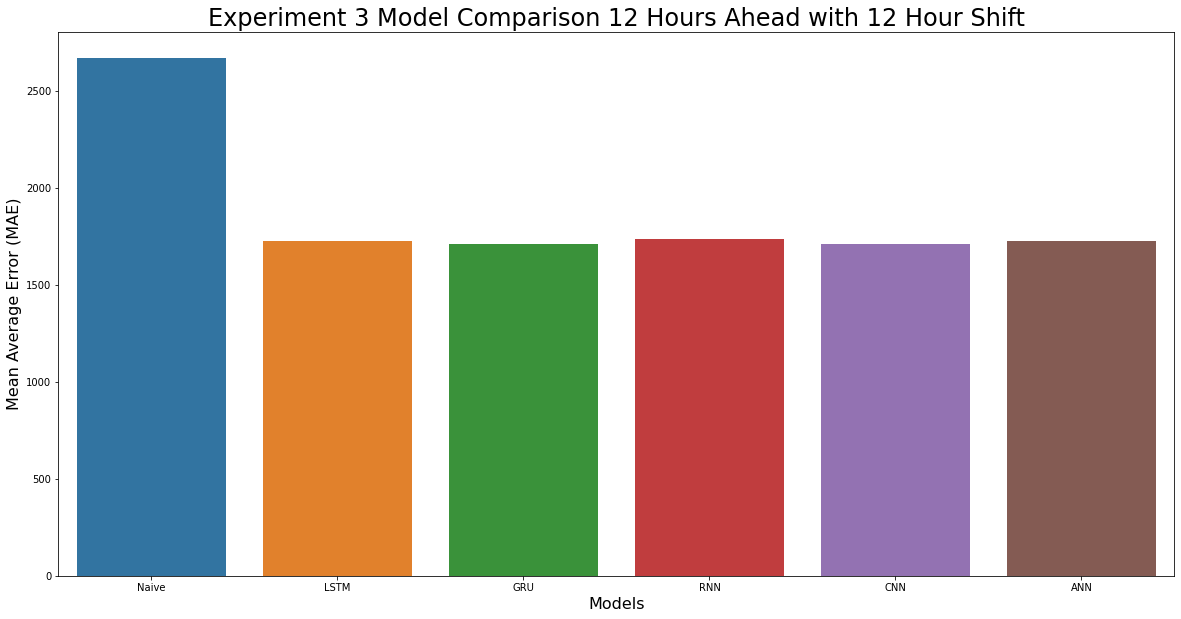

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 3 Model Comparison 12 Hours Ahead with 12 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead**

In [ ]:
input_width = 24
label_width = 24
shift = 1

ex3_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex3_train_df, val_df=ex3_val_df, test_df=ex3_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex3_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 10)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex3_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex3_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex3_df.shape[-1])
input_shape

(24, 10)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1098.3518162532384

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_lstm_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex3_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex3_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 34s 23ms/step - loss: 1261.4586 - val_loss: 535.8660 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 33s 23ms/step - loss: 893.3983 - val_loss: 468.0641 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 32s 23ms/step - loss: 791.3450 - val_loss: 404.0536 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 32s 23ms/step - loss: 773.0142 - val_loss: 265.9537 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 32s 23ms/step - loss: 394.4397 - val_loss: 174.2702 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 32s 22ms/step - loss: 283.8743 - val_loss: 133.0573 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 32s 23ms/step - loss: 193.5886 - val_loss: 92.1845 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 32s 23ms/step - loss: 155.2700 - val_loss: 77.4522 - lr: 0.0010
Epoch 9/100
1407/1407 [==

In [ ]:
lstm = keras.models.load_model(path + '/models/ex3_lstm_24hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

49.436295

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_gru_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex3_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 31s 21ms/step - loss: 380.8627 - val_loss: 65.5955 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 30s 22ms/step - loss: 102.7720 - val_loss: 47.2191 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 31s 22ms/step - loss: 89.0471 - val_loss: 39.1955 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 30s 21ms/step - loss: 82.7400 - val_loss: 43.6041 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 31s 22ms/step - loss: 77.5419 - val_loss: 43.8924 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 30s 21ms/step - loss: 72.6974 - val_loss: 37.7755 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 30s 22ms/step - loss: 71.4099 - val_loss: 39.0817 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 30s 21ms/step - loss: 70.0190 - val_loss: 35.5975 - lr: 0.0010
Epoch 9/100
1407/1407 [===============

In [ ]:
gru = keras.models.load_model(path + '/models/ex3_gru_24hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

46.081886

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_rnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex3_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 19s 13ms/step - loss: 266.3065 - val_loss: 106.7958 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 18s 12ms/step - loss: 113.6468 - val_loss: 59.1190 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 95.8220 - val_loss: 50.4244 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 17s 12ms/step - loss: 89.7197 - val_loss: 44.1389 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 17s 12ms/step - loss: 83.6504 - val_loss: 39.8169 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 18s 13ms/step - loss: 75.3252 - val_loss: 35.5565 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 18s 13ms/step - loss: 71.7392 - val_loss: 37.8702 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 16s 12ms/step - loss: 70.8863 - val_loss: 42.3726 - lr: 0.0010
Epoch 9/100
1407/1407 [==============

In [ ]:
rnn = keras.models.load_model(path + '/models/ex3_rnn_24hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

45.495632

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_cnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex3_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 12s 8ms/step - loss: 374.4917 - val_loss: 96.4425 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 12s 8ms/step - loss: 170.8150 - val_loss: 114.1822 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 12s 8ms/step - loss: 142.0285 - val_loss: 83.1615 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 12s 8ms/step - loss: 132.2737 - val_loss: 68.6594 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 12s 8ms/step - loss: 124.7904 - val_loss: 69.2994 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 11s 8ms/step - loss: 120.3386 - val_loss: 76.7993 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 12s 8ms/step - loss: 112.7923 - val_loss: 59.4692 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 12s 9ms/step - loss: 118.0778 - val_loss: 70.6010 - lr: 0.0010
Epoch 9/100
1407/1407 [================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex3_cnn_24hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

46.571392

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_ann_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex3_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 8s 6ms/step - loss: 307.9200 - val_loss: 64.9896 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 8s 6ms/step - loss: 122.6221 - val_loss: 62.9016 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 112.7179 - val_loss: 52.7218 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 97.1967 - val_loss: 54.0459 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 96.4530 - val_loss: 48.9229 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 89.2240 - val_loss: 46.8349 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 8s 5ms/step - loss: 89.7192 - val_loss: 42.9944 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 85.3110 - val_loss: 43.2483 - lr: 0.0010
Epoch 9/100
1407/1407 [==============================

In [ ]:
ann = keras.models.load_model(path + '/models/ex3_ann_24hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

45.75462

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive       LSTM        GRU        RNN        CNN       ANN
0  1098.351816  49.436295  46.081886  45.495632  46.571392  45.75462

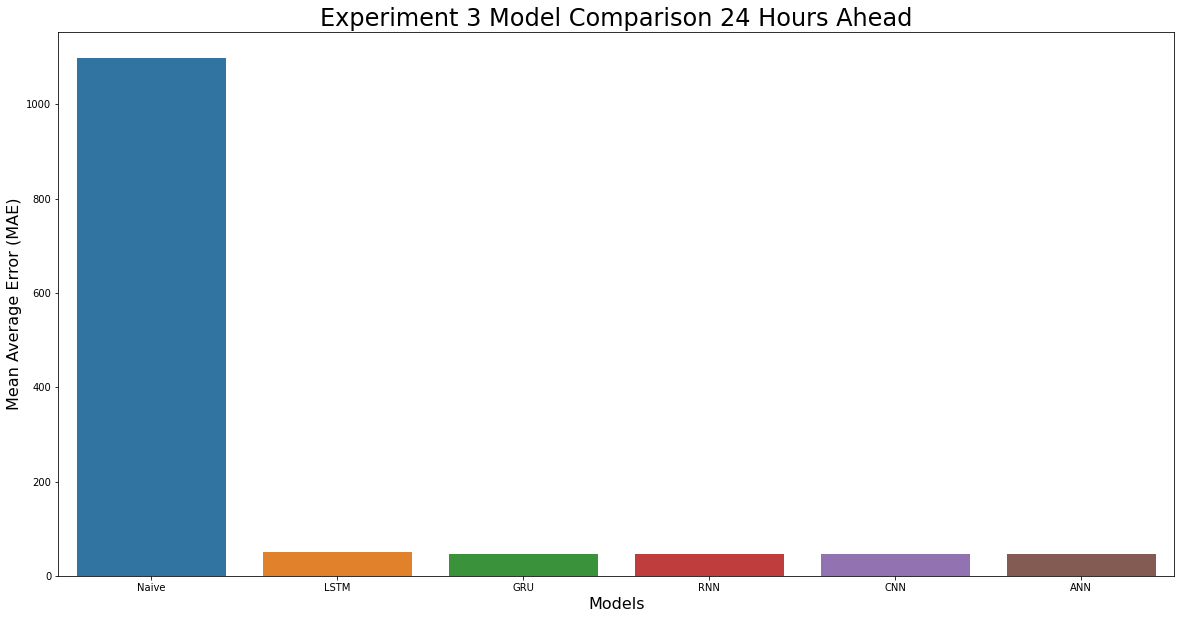

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 3 Model Comparison 24 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead 24 hour shift**

In [111]:
input_width = 24
label_width = 24
shift = 24

ex3_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex3_train_df, val_df=ex3_val_df, test_df=ex3_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [112]:
for samples, labels in ex3_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 10)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex3_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex3_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex3_df.shape[-1])
input_shape

(24, 10)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1722.1445946783263

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_lstm_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex3_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex3_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
59/59 [==============================] - 3s 33ms/step - loss: 1886.4955 - val_loss: 1293.4073 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 29ms/step - loss: 1465.0809 - val_loss: 1074.7319 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 30ms/step - loss: 1354.2611 - val_loss: 1132.7766 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 29ms/step - loss: 1339.4380 - val_loss: 979.3885 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 28ms/step - loss: 1332.7910 - val_loss: 1023.7842 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 30ms/step - loss: 1388.5963 - val_loss: 1024.8767 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 2s 30ms/step - loss: 1348.2386 - val_loss: 944.3458 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 2s 29ms/step - loss: 1273.7549 - val_loss: 900.3378 - lr: 0.0010
Epoch 9/100
59/59 [==============================] 

In [ ]:
lstm = keras.models.load_model(path + '/models/ex3_lstm_24hours_ahead_24hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

2039.5518

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex3_gru_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex3_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
59/59 [==============================] - 3s 31ms/step - loss: 1509.0388 - val_loss: 921.0046 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 28ms/step - loss: 1196.7882 - val_loss: 886.6886 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 29ms/step - loss: 1175.5878 - val_loss: 877.3979 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 30ms/step - loss: 1160.8248 - val_loss: 856.4496 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 28ms/step - loss: 1142.6277 - val_loss: 848.0347 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 29ms/step - loss: 1131.3472 - val_loss: 837.4373 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 2s 28ms/step - loss: 1132.6663 - val_loss: 832.3888 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 2s 28ms/step - loss: 1121.1460 - val_loss: 817.0859 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 2s 

In [ ]:
gru = keras.models.load_model(path + '/models/ex3_gru_24hours_ahead_24hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1925.6932

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_rnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex3_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 2s 20ms/step - loss: 1430.1577 - val_loss: 1027.5270 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 18ms/step - loss: 1193.4293 - val_loss: 859.8741 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 18ms/step - loss: 1146.7427 - val_loss: 817.9854 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 17ms/step - loss: 1123.2690 - val_loss: 808.4481 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 16ms/step - loss: 1112.6918 - val_loss: 798.4695 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 17ms/step - loss: 1100.7812 - val_loss: 794.5270 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 17ms/step - loss: 1094.3860 - val_loss: 799.7286 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 17ms/step - loss: 1090.0841 - val_loss: 795.3015 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1s

In [ ]:
rnn = keras.models.load_model(path + '/models/ex3_rnn_24hours_ahead_24hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

2151.3865

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex3_cnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex3_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 16ms/step - loss: 1414.7576 - val_loss: 1068.7000 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 13ms/step - loss: 1224.8103 - val_loss: 969.3613 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 14ms/step - loss: 1190.6392 - val_loss: 952.9182 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 13ms/step - loss: 1180.0808 - val_loss: 923.3978 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 13ms/step - loss: 1166.0242 - val_loss: 908.4934 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 14ms/step - loss: 1185.4395 - val_loss: 939.1408 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 14ms/step - loss: 1200.1306 - val_loss: 871.7316 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 12ms/step - loss: 1165.6288 - val_loss: 849.4539 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1s

In [ ]:
cnn = keras.models.load_model(path + '/models/ex3_cnn_24hours_ahead_24hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

2249.2346

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_ann_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex3_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex3_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 12ms/step - loss: 1413.7207 - val_loss: 904.5291 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 10ms/step - loss: 1193.9583 - val_loss: 868.0043 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 10ms/step - loss: 1150.7286 - val_loss: 841.4450 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 10ms/step - loss: 1133.9791 - val_loss: 816.1793 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 10ms/step - loss: 1124.3079 - val_loss: 811.8752 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 10ms/step - loss: 1116.3906 - val_loss: 803.3945 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 10ms/step - loss: 1107.2310 - val_loss: 813.2150 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 10ms/step - loss: 1104.2362 - val_loss: 800.9843 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1s 

In [ ]:
ann = keras.models.load_model(path + '/models/ex3_ann_24hours_ahead_24hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

2216.225

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  1722.144595  2039.551758  1925.693237  2151.386475  2249.234619   

           ANN  
0  2216.225098

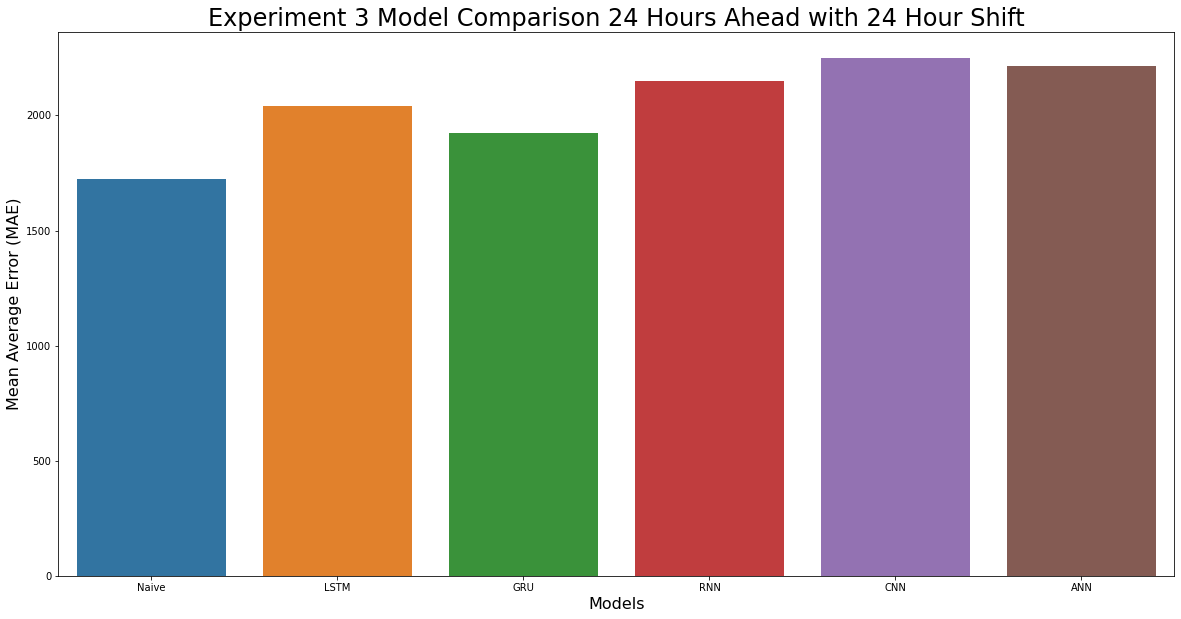

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 3 Model Comparison 24 Hours Ahead with 24 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Deeper Layers (1 hour ahead)** 

In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex3_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex3_1hour_ahead.test], axis=0)

input_shape = (input_width, ex3_df.shape[-1])
input_shape

(24, 10)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_lstm_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex3_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex3_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 106s 73ms/step - loss: 1913.4186 - val_loss: 1005.6394 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 100s 71ms/step - loss: 1340.8837 - val_loss: 774.9016 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 100s 71ms/step - loss: 1381.8475 - val_loss: 741.8300 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 99s 70ms/step - loss: 1300.4180 - val_loss: 766.2006 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 98s 70ms/step - loss: 1327.3492 - val_loss: 747.7934 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 99s 71ms/step - loss: 1271.9849 - val_loss: 777.1224 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 98s 70ms/step - loss: 1255.9919 - val_loss: 776.8885 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 98s 69ms/step - loss: 1398.1781 - val_loss: 891.1800 - lr: 8.0000e-04
Epoc

In [ ]:
lstm = keras.models.load_model(path + '/models/ex3_lstm_3layers.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1536.6394

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex3_gru_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex3_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex3_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 96s 65ms/step - loss: 986.9329 - val_loss: 483.4543 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 92s 66ms/step - loss: 830.0168 - val_loss: 464.4728 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 91s 65ms/step - loss: 815.0978 - val_loss: 458.7545 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 92s 65ms/step - loss: 812.9769 - val_loss: 460.9807 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 89s 64ms/step - loss: 805.2291 - val_loss: 460.5502 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 90s 64ms/step - loss: 805.2328 - val_loss: 466.0650 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 91s 65ms/step - loss: 791.5204 - val_loss: 456.5956 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 90s 64ms/step - loss: 786.6588 - val_loss: 462.2134 - lr: 8.0000e-04
Epoch 9/100
1407

In [ ]:
gru = keras.models.load_model(path + '/models/ex3_gru_3layers.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1042.252

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_rnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex3_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex3_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 44s 30ms/step - loss: 913.2219 - val_loss: 469.7126 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 46s 33ms/step - loss: 812.8466 - val_loss: 465.2280 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 43s 30ms/step - loss: 802.9798 - val_loss: 467.1151 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 43s 30ms/step - loss: 786.6278 - val_loss: 466.3960 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 43s 31ms/step - loss: 777.1603 - val_loss: 467.0993 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 43s 31ms/step - loss: 761.8546 - val_loss: 465.0566 - lr: 8.0000e-04
Epoch 7/100
1407/1407 [==============================] - 43s 31ms/step - loss: 758.4005 - val_loss: 466.4491 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 42s 30ms/step - loss: 748.1237 - val_loss: 465.6863 - lr: 8.0000e-04
Epoch 9/100


In [ ]:
rnn = keras.models.load_model(path + '/models/ex3_rnn_3layers.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1023.03564

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_cnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex3_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex3_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 136s 96ms/step - loss: 1195.5737 - val_loss: 595.9890 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 139s 99ms/step - loss: 909.2411 - val_loss: 527.1287 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 141s 100ms/step - loss: 848.1989 - val_loss: 516.6144 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 139s 98ms/step - loss: 816.3313 - val_loss: 509.8853 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 143s 102ms/step - loss: 817.9091 - val_loss: 523.1816 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 139s 99ms/step - loss: 809.7970 - val_loss: 510.1751 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 139s 99ms/step - loss: 790.7516 - val_loss: 528.2173 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 141s 100ms/step - loss: 779.8932 - val_loss: 504.9850 - lr: 8.0000e-04
Epoch 9/

In [ ]:
cnn = keras.models.load_model(path + '/models/ex3_cnn_3layers.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1053.6725

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex3_ann_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex3_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex3_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 14s 9ms/step - loss: 903.4344 - val_loss: 467.5081 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 830.3171 - val_loss: 459.9106 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 823.5620 - val_loss: 464.9363 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 822.0636 - val_loss: 460.3274 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 814.9109 - val_loss: 454.7834 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 13s 9ms/step - loss: 814.9359 - val_loss: 459.1588 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 810.3165 - val_loss: 453.8486 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 13s 9ms/step - loss: 809.9454 - val_loss: 454.8148 - lr: 0.0010
Epoch 9/100
1407/1407 [======

In [ ]:
ann = keras.models.load_model(path + '/models/ex3_ann_3layers.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1049.1167

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  1104.352951  1536.639404  1042.251953  1023.035645  1053.672485   

           ANN  
0  1049.116699

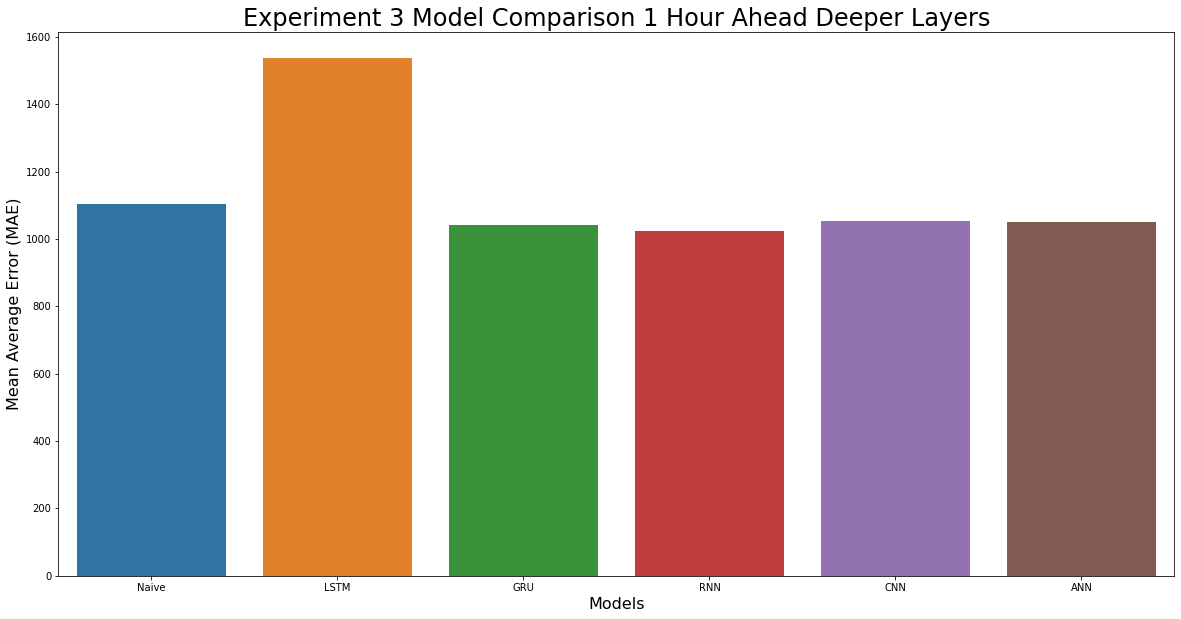

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 3 Model Comparison 1 Hour Ahead Deeper Layers", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

##**Experiment 4 - `Effective GWAP` + `Rolling Average` + lagged**



In [ ]:
ex4_df = df_copy.drop(df_copy.columns[2:10], axis=1)
ex4_df

Effective GWAP  Rolling Average  lag_24_hours  \
Date_Interval                                                        
2015-01-23 00:00:00     1849.604375      4357.651316   4038.461339   
2015-01-23 01:00:00     1882.363158      4359.075739   3506.938357   
2015-01-23 02:00:00     1886.543140      4359.488924   3865.155003   
2015-01-23 03:00:00     1888.939469      4353.817912   3555.473270   
2015-01-23 04:00:00     4000.262110      4360.450629   3500.074604   
...                             ...              ...           ...   
2021-06-25 19:00:00     4582.463868      6823.492048  19126.570000   
2021-06-25 20:00:00    13468.269470      6871.667956  32390.800000   
2021-06-25 21:00:00     8069.676643      6866.547378  21516.500000   
2021-06-25 22:00:00     3628.883036      6860.123532   7862.060000   
2021-06-25 23:00:00     2975.500891      6856.019752   3424.130000   

                     lag_168_hours    lag_1_hour  lag_48_hours  lag_23_hours  \
Date_Interval                                                                  
2015-01-23 00:00:00    3008.675689   1436.897013   3994.478574   3506.938357   
2015-01-23 01:00:00    1643.060137   1849.604375   3616.561381   3865.155003   
2015-01-23 02:00:00    1817.127920   1882.363158   3909.627385   3555.473270   
2015-01-23 03:00:00    2841.669516   1886.543140   3976.082463   3500.074604   
2015-01-23 04:00:00    2885.965633   1888.939469   4104.101996   4030.370105   
...                            ...           ...           ...           ...   
2021-06-25 19:00:00   21446.290000   4578.853699   4527.210000  32390.800000   
2021-06-25 20:00:00   31957.030000   4582.463868   7986.910000  21516.500000   
2021-06-25 21:00:00   32769.440000  13468.269470   8097.570000   7862.060000   
2021-06-25 22:00:00   21886.270000   8069.676643   7615.450000   3424.130000   
2021-06-25 23:00:00   10441.410000   3628.883036   3404.990000   2983.963822   

                     lag_72_hours  lag_336_hours  
Date_Interval                                     
2015-01-23 00:00:00   1852.680439    1822.506078  
2015-01-23 01:00:00   1849.559571    1752.397260  
2015-01-23 02:00:00   1892.741375    1539.379580  
2015-01-23 03:00:00   1882.103641    1815.911913  
2015-01-23 04:00:00   1899.117471    2884.785234  
...                           ...            ...  
2021-06-25 19:00:00   8042.210000    2728.080000  
2021-06-25 20:00:00   7672.180000    2357.150000  
2021-06-25 21:00:00   4559.260000    2368.550000  
2021-06-25 22:00:00   4531.760000    2250.120000  
2021-06-25 23:00:00   2892.190000    2260.750000  

[56304 rows x 9 columns]

In [ ]:
ex4_train_df = ex4_df[0:train_end_idx]
ex4_val_df = ex4_df[train_end_idx:val_end_idx]
ex4_test_df = ex4_df[val_end_idx:test_end_idx]

###**Forecast 1 hour ahead**

In [ ]:
input_width = 24
label_width = 1
shift = 1

ex4_1hour_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex4_train_df, val_df=ex4_val_df, test_df=ex4_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex4_1hour_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 9)
(32, 1)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex4_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex4_1hour_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex4_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_lstm_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex4_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex4_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 32s 22ms/step - loss: 1646.3456 - val_loss: 794.3726 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1556.0726 - val_loss: 857.7846 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1198.0846 - val_loss: 738.3541 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1961.7648 - val_loss: 862.8151 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 30s 22ms/step - loss: 1839.3759 - val_loss: 1068.8578 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 32s 22ms/step - loss: 1495.2990 - val_loss: 878.8888 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1333.0117 - val_loss: 697.7052 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1262.7373 - val_loss: 721.2480 - lr: 8.0000e-04
Epoch 9

In [ ]:
lstm = keras.models.load_model(path + '/models/ex4_lstm_1hour_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

992.90576

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex4_gru_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex4_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex4_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 31s 21ms/step - loss: 1194.5530 - val_loss: 625.3138 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 29s 21ms/step - loss: 993.6581 - val_loss: 579.3188 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 29s 21ms/step - loss: 904.1970 - val_loss: 610.7517 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 29s 21ms/step - loss: 846.4822 - val_loss: 535.8184 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 29s 20ms/step - loss: 826.2978 - val_loss: 495.9657 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 29s 21ms/step - loss: 824.2731 - val_loss: 517.8743 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 29s 21ms/step - loss: 801.7798 - val_loss: 455.7186 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 30s 21ms/step - loss: 803.9903 - val_loss: 451.0598 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
gru = keras.models.load_model(path + '/models/ex4_gru_1hour_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

976.90344

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_rnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex4_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex4_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1008.7145 - val_loss: 485.7450 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 826.0492 - val_loss: 468.9396 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 798.8302 - val_loss: 465.4591 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 16s 11ms/step - loss: 785.7363 - val_loss: 471.0411 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 15s 11ms/step - loss: 768.6844 - val_loss: 472.6285 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 15s 11ms/step - loss: 770.2505 - val_loss: 467.0574 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 16s 11ms/step - loss: 752.9737 - val_loss: 452.6057 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 16s 11ms/step - loss: 742.7676 - val_loss: 458.3203 - lr: 8.0000e-04
Epoch 9/100
140

In [ ]:
rnn = keras.models.load_model(path + '/models/ex4_rnn_1hour_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

984.86554

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_cnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex4_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex4_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 11s 7ms/step - loss: 1184.8125 - val_loss: 655.0275 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 990.4586 - val_loss: 573.1147 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 11s 8ms/step - loss: 924.2916 - val_loss: 512.7518 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 11s 8ms/step - loss: 904.0057 - val_loss: 535.8452 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 11s 7ms/step - loss: 881.6228 - val_loss: 498.0157 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 859.2015 - val_loss: 513.9272 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 854.3710 - val_loss: 533.0737 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 11s 7ms/step - loss: 836.8282 - val_loss: 502.8582 - lr: 0.0010
Epoch 9/100
1407/1407 [========

In [ ]:
cnn = keras.models.load_model(path + '/models/ex4_cnn_1hour_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1018.06616

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_ann_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex4_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex4_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1046.2667 - val_loss: 488.0932 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 7s 5ms/step - loss: 835.8914 - val_loss: 467.7767 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 810.3358 - val_loss: 472.4024 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 791.1355 - val_loss: 472.2048 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 5ms/step - loss: 780.6514 - val_loss: 455.7563 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 779.1069 - val_loss: 450.1256 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 7s 5ms/step - loss: 763.7651 - val_loss: 454.7123 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 7s 5ms/step - loss: 772.3529 - val_loss: 451.1688 - lr: 0.0010
Epoch 9/100
1407/1407 [================

In [ ]:
ann = keras.models.load_model(path + '/models/ex4_ann_1hour_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

988.81433

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive        LSTM         GRU        RNN          CNN         ANN
0  1104.352951  992.905762  976.903442  984.86554  1018.066162  988.814331

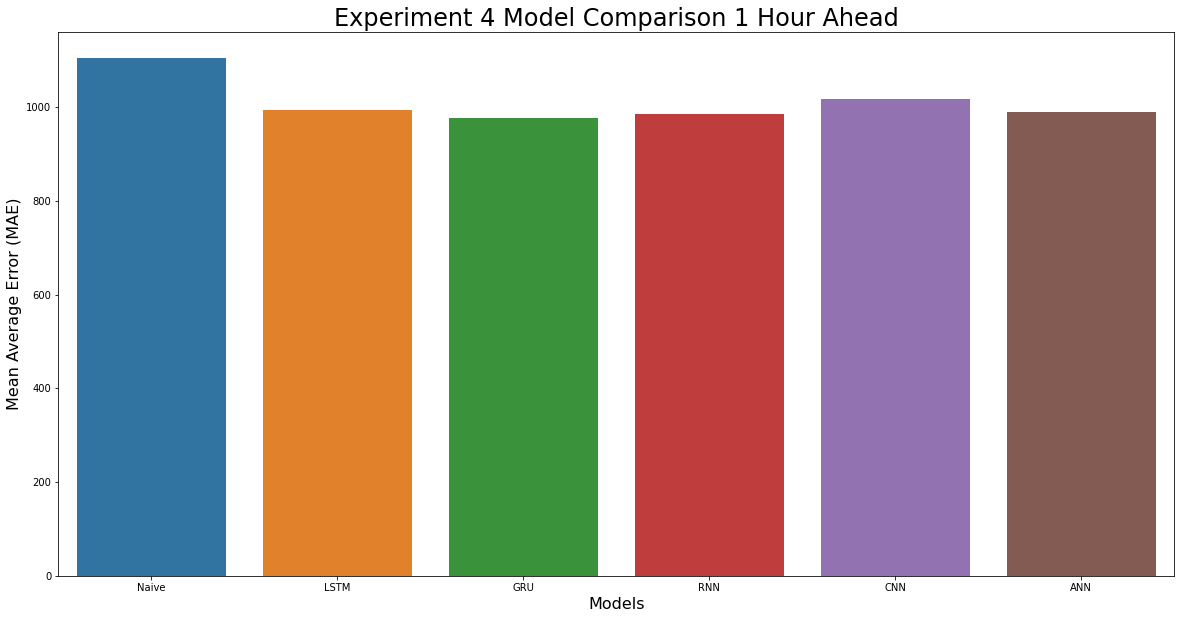

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 4 Model Comparison 1 Hour Ahead", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead**

In [ ]:
input_width = 24
label_width = 12
shift = 1

ex4_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex4_train_df, val_df=ex4_val_df, test_df=ex4_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex4_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 9)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex4_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex4_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex4_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1101.2762310150465

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_lstm_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex4_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex4_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 34s 23ms/step - loss: 1655.7772 - val_loss: 680.6923 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 32s 22ms/step - loss: 1379.0975 - val_loss: 675.1786 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1189.6803 - val_loss: 677.7746 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 31s 22ms/step - loss: 1204.2313 - val_loss: 590.4372 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 31s 22ms/step - loss: 743.9596 - val_loss: 416.9546 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 31s 22ms/step - loss: 617.6981 - val_loss: 324.4796 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 32s 23ms/step - loss: 611.9634 - val_loss: 295.3905 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 32s 23ms/step - loss: 497.3586 - val_loss: 260.9043 - lr: 0.0010
Epoch 9/100
1407/140

In [ ]:
lstm = keras.models.load_model(path + '/models/ex4_lstm_12hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

103.73298

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex4_gru_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex4_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 31s 21ms/step - loss: 674.6310 - val_loss: 179.2118 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 30s 21ms/step - loss: 267.4855 - val_loss: 123.0567 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 31s 22ms/step - loss: 197.3062 - val_loss: 93.7030 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 30s 21ms/step - loss: 171.9824 - val_loss: 106.3754 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 31s 22ms/step - loss: 147.6263 - val_loss: 83.0503 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 31s 22ms/step - loss: 129.8541 - val_loss: 74.2040 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 31s 22ms/step - loss: 126.3942 - val_loss: 68.7261 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 31s 22ms/step - loss: 121.6172 - val_loss: 76.5506 - lr: 0.0010
Epoch 9/100
1407/1407 [======

In [ ]:
gru = keras.models.load_model(path + '/models/ex4_gru_12hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

88.93763

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_rnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex4_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 27s 18ms/step - loss: 502.2137 - val_loss: 125.3003 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 18s 13ms/step - loss: 210.7825 - val_loss: 103.6042 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 19s 14ms/step - loss: 164.1497 - val_loss: 86.1901 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 156.0566 - val_loss: 76.2669 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 17s 12ms/step - loss: 130.5538 - val_loss: 80.6216 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 18s 13ms/step - loss: 128.4649 - val_loss: 64.2124 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 19s 13ms/step - loss: 124.3474 - val_loss: 61.1872 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 18s 12ms/step - loss: 118.2439 - val_loss: 65.7696 - lr: 0.0010
Epoch 9/100
1407/1407 [=======

In [ ]:
rnn = keras.models.load_model(path + '/models/ex4_rnn_12hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

85.54788

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex4_cnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex4_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 14s 9ms/step - loss: 779.4575 - val_loss: 249.8616 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 13s 10ms/step - loss: 358.0420 - val_loss: 165.2228 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 12s 9ms/step - loss: 280.5801 - val_loss: 108.1708 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 13s 9ms/step - loss: 248.6037 - val_loss: 161.2816 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 12s 8ms/step - loss: 223.5635 - val_loss: 123.4412 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 13s 9ms/step - loss: 223.5769 - val_loss: 100.9228 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 12s 9ms/step - loss: 193.5489 - val_loss: 109.1413 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 13s 9ms/step - loss: 202.1764 - val_loss: 152.9631 - lr: 0.0010
Epoch 9/100
1407/1407 [========

In [ ]:
cnn = keras.models.load_model(path + '/models/ex4_cnn_12hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

93.16068

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_ann_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex4_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 8s 6ms/step - loss: 489.1790 - val_loss: 163.7327 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 208.4951 - val_loss: 98.7919 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 181.3648 - val_loss: 90.3877 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 157.0859 - val_loss: 72.5333 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 146.0136 - val_loss: 89.7518 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 134.5958 - val_loss: 84.6616 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 138.1471 - val_loss: 80.4094 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 9s 6ms/step - loss: 116.7184 - val_loss: 57.8670 - lr: 8.0000e-04
Epoch 9/100
1407/1407 [====================

In [ ]:
ann = keras.models.load_model(path + '/models/ex4_ann_12hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

85.47774

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive        LSTM       GRU        RNN        CNN        ANN
0  1101.276231  103.732979  88.93763  85.547882  93.160683  85.477737

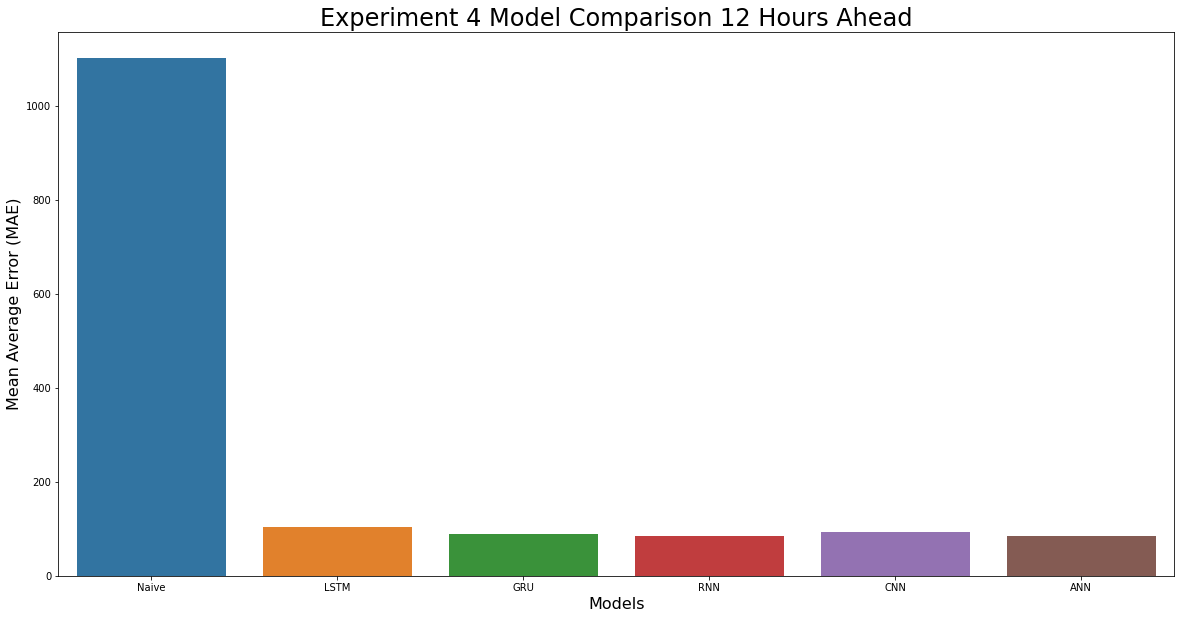

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 4 Model Comparison 12 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead 12 hour shift**

In [ ]:
input_width = 24
label_width = 12
shift = 12

ex4_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex4_train_df, val_df=ex4_val_df, test_df=ex4_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex4_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 9)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex4_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex4_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex4_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

2667.674529034868

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_lstm_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex4_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex4_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
118/118 [==============================] - 8s 45ms/step - loss: 2155.7891 - val_loss: 1216.3376 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 5s 39ms/step - loss: 1627.6624 - val_loss: 1125.6301 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 5s 41ms/step - loss: 1408.8020 - val_loss: 1088.4879 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 5s 40ms/step - loss: 1393.9641 - val_loss: 1100.6152 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 5s 40ms/step - loss: 1536.9512 - val_loss: 1432.7861 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 5s 42ms/step - loss: 1525.7501 - val_loss: 1012.6616 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 5s 40ms/step - loss: 1495.1489 - val_loss: 1172.2646 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 5s 44ms/step - loss: 1421.3967 - val_loss: 1032.8188 - lr: 0.0010
Epoch 9/100
118/118 [===========

In [ ]:
lstm = keras.models.load_model(path + '/models/ex4_lstm_12hours_ahead_12hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1775.7634

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex4_gru_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex4_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
118/118 [==============================] - 8s 43ms/step - loss: 1419.0522 - val_loss: 902.9472 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 5s 40ms/step - loss: 1160.4380 - val_loss: 829.0818 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 5s 43ms/step - loss: 1120.5853 - val_loss: 842.0095 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 5s 41ms/step - loss: 1099.1715 - val_loss: 842.9133 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 5s 41ms/step - loss: 1082.0502 - val_loss: 843.4788 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 5s 38ms/step - loss: 1085.9738 - val_loss: 839.9352 - lr: 8.0000e-04
Epoch 7/100
118/118 [==============================] - 4s 37ms/step - loss: 1037.8817 - val_loss: 831.1375 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 5s 39ms/step - loss: 1018.8572 - val_loss: 833.6918 - lr: 8.0000e-04
Epoch 9/100
118/118 [=======

In [ ]:
gru = keras.models.load_model(path + '/models/ex4_gru_12hours_ahead_12hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1780.8093

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_rnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex4_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 4s 25ms/step - loss: 1414.6893 - val_loss: 930.3991 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 2s 20ms/step - loss: 1213.6996 - val_loss: 865.0113 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 3s 22ms/step - loss: 1092.6970 - val_loss: 856.4180 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 2s 20ms/step - loss: 1040.8451 - val_loss: 851.9234 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 2s 21ms/step - loss: 1019.2778 - val_loss: 859.2274 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 3s 22ms/step - loss: 989.5643 - val_loss: 847.8683 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 2s 21ms/step - loss: 960.4144 - val_loss: 863.9061 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 3s 24ms/step - loss: 938.6039 - val_loss: 844.7404 - lr: 0.0010
Epoch 9/100
118/118 [======================

In [ ]:
rnn = keras.models.load_model(path + '/models/ex4_rnn_12hours_ahead_12hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1839.4569

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex4_cnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex4_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 2s 14ms/step - loss: 1364.8939 - val_loss: 1046.7465 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 2s 14ms/step - loss: 1207.1765 - val_loss: 864.8525 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 2s 15ms/step - loss: 1127.2600 - val_loss: 823.2640 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 2s 14ms/step - loss: 1086.5280 - val_loss: 820.7648 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 2s 13ms/step - loss: 1056.0503 - val_loss: 841.6743 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 12ms/step - loss: 1028.0275 - val_loss: 838.3217 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 2s 13ms/step - loss: 1017.8066 - val_loss: 828.8203 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 2s 16ms/step - loss: 1000.2043 - val_loss: 866.2093 - lr: 8.0000e-04
Epoch 9/100
118/118 [==============

In [ ]:
cnn = keras.models.load_model(path + '/models/ex4_cnn_12hours_ahead_12hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1925.4727

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_ann_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex4_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
118/118 [==============================] - 4s 17ms/step - loss: 1450.7130 - val_loss: 898.6140 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 10ms/step - loss: 1169.7278 - val_loss: 885.4576 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 11ms/step - loss: 1135.6416 - val_loss: 859.5001 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 11ms/step - loss: 1080.6843 - val_loss: 839.4127 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 10ms/step - loss: 1035.0211 - val_loss: 862.0009 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 10ms/step - loss: 1018.4180 - val_loss: 852.9805 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 11ms/step - loss: 1007.6575 - val_loss: 864.5796 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 1s 10ms/step - loss: 989.2256 - val_loss: 887.8900 - lr: 8.0000e-04
Epoch 9/100
118/118 [================

In [ ]:
ann = keras.models.load_model(path + '/models/ex4_ann_12hours_ahead_12hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1715.1759

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  2667.674529  1775.763428  1780.809326  1839.456909  1925.472656   

           ANN  
0  1715.175903

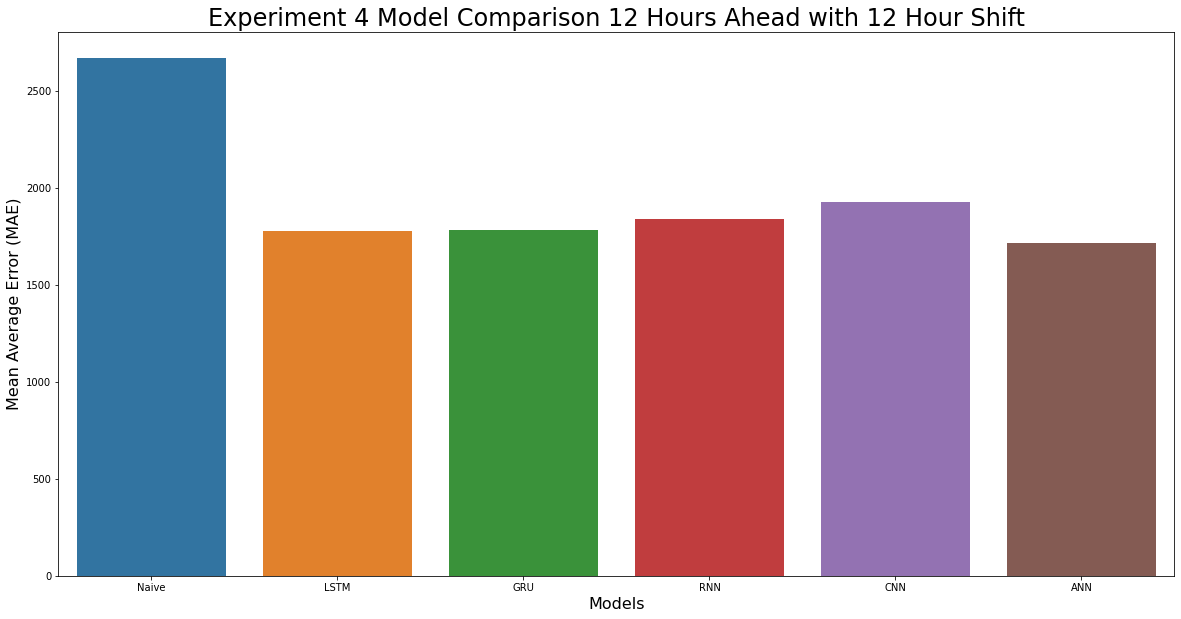

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 4 Model Comparison 12 Hours Ahead with 12 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead**

In [ ]:
input_width = 24
label_width = 24
shift = 1

ex4_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex4_train_df, val_df=ex4_val_df, test_df=ex4_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex4_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 9)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex4_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex4_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex4_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1098.3518162532384

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_lstm_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex4_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex4_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 51s 35ms/step - loss: 1587.2355 - val_loss: 870.4078 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1026.7334 - val_loss: 550.2736 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 835.0826 - val_loss: 776.8042 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 34s 24ms/step - loss: 878.2904 - val_loss: 581.9620 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 36s 25ms/step - loss: 877.7476 - val_loss: 456.5532 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 35s 25ms/step - loss: 692.6160 - val_loss: 382.7777 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 599.0261 - val_loss: 241.9104 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 35s 25ms/step - loss: 343.5186 - val_loss: 153.1680 - lr: 0.0010
Epoch 9/100
1407/1407 

In [ ]:
lstm = keras.models.load_model(path + '/models/ex4_lstm_24hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

47.477215

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_gru_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex4_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 36s 24ms/step - loss: 598.6882 - val_loss: 159.8612 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 244.2556 - val_loss: 113.6806 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 175.7645 - val_loss: 79.6936 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 34s 24ms/step - loss: 135.7894 - val_loss: 75.1460 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 33s 23ms/step - loss: 121.9419 - val_loss: 63.6655 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 33s 23ms/step - loss: 107.3090 - val_loss: 60.7725 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 33s 23ms/step - loss: 98.6717 - val_loss: 47.2344 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 34s 24ms/step - loss: 87.0675 - val_loss: 52.2188 - lr: 0.0010
Epoch 9/100
1407/1407 [=========

In [ ]:
gru = keras.models.load_model(path + '/models/ex4_gru_24hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

48.294853

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_rnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex4_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 20s 13ms/step - loss: 469.9485 - val_loss: 117.1655 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 19s 13ms/step - loss: 167.2107 - val_loss: 83.6082 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 19s 13ms/step - loss: 125.4010 - val_loss: 66.1291 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 19s 13ms/step - loss: 119.5805 - val_loss: 62.6050 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 19s 13ms/step - loss: 105.9769 - val_loss: 55.4175 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 19s 13ms/step - loss: 102.7999 - val_loss: 49.5395 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 21s 15ms/step - loss: 89.4264 - val_loss: 46.3285 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 19s 14ms/step - loss: 85.9587 - val_loss: 41.9144 - lr: 0.0010
Epoch 9/100
1407/1407 [==========

In [ ]:
rnn = keras.models.load_model(path + '/models/ex4_rnn_24hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

43.762814

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_cnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex4_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 13s 9ms/step - loss: 613.9291 - val_loss: 167.7223 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 13s 10ms/step - loss: 278.0057 - val_loss: 154.9071 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 216.5190 - val_loss: 126.8620 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 13s 9ms/step - loss: 198.6274 - val_loss: 122.5869 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 183.1675 - val_loss: 117.4031 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 13s 10ms/step - loss: 194.1819 - val_loss: 119.7777 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 173.1974 - val_loss: 135.8546 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 13s 9ms/step - loss: 190.7817 - val_loss: 112.5875 - lr: 0.0010
Epoch 9/100
1407/1407 [=======

In [ ]:
cnn = keras.models.load_model(path + '/models/ex4_cnn_24hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

47.125977

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_ann_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex4_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 472.6906 - val_loss: 120.5353 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 180.9519 - val_loss: 88.2314 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 149.9341 - val_loss: 69.6334 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 126.7576 - val_loss: 56.8178 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 108.8194 - val_loss: 43.6361 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 98.0930 - val_loss: 50.9496 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 9s 6ms/step - loss: 97.0287 - val_loss: 61.2449 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 9s 6ms/step - loss: 99.3898 - val_loss: 45.4585 - lr: 0.0010
Epoch 9/100
1407/1407 [===========================

In [ ]:
ann = keras.models.load_model(path + '/models/ex4_ann_24hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

50.077682

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive       LSTM        GRU        RNN        CNN        ANN
0  1098.351816  47.477215  48.294853  43.762814  47.125977  50.077682

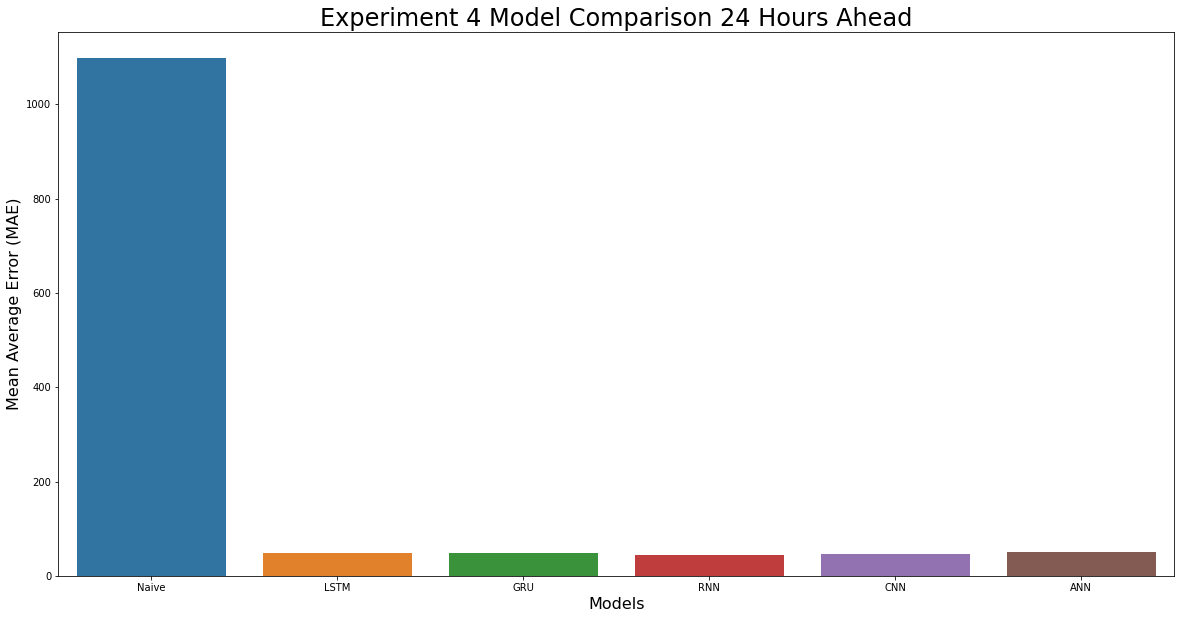

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 4 Model Comparison 24 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead 24 hour shift**

In [ ]:
input_width = 24
label_width = 24
shift = 24

ex4_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex4_train_df, val_df=ex4_val_df, test_df=ex4_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex4_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 9)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex4_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex4_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex4_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1722.1445946783263

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_lstm_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex4_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex4_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
59/59 [==============================] - 5s 49ms/step - loss: 2118.1226 - val_loss: 1286.9186 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 3s 42ms/step - loss: 1678.9788 - val_loss: 1179.4788 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 3s 43ms/step - loss: 1550.5576 - val_loss: 1127.7899 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 41ms/step - loss: 1448.4550 - val_loss: 1206.2654 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 3s 43ms/step - loss: 1438.9019 - val_loss: 1346.6609 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 3s 49ms/step - loss: 1454.9683 - val_loss: 1083.4298 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 3s 43ms/step - loss: 1785.1830 - val_loss: 1572.2644 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 3s 43ms/step - loss: 1988.8926 - val_loss: 1470.1927 - lr: 0.0010
Epoch 9/100
59/59 [=============================

In [ ]:
lstm = keras.models.load_model(path + '/models/ex4_lstm_24hours_ahead_24hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

2599.0127

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex4_gru_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex4_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
59/59 [==============================] - 5s 48ms/step - loss: 1535.8391 - val_loss: 984.8840 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 41ms/step - loss: 1263.0676 - val_loss: 960.8527 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 41ms/step - loss: 1197.8046 - val_loss: 953.3647 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 3s 42ms/step - loss: 1174.1477 - val_loss: 940.3092 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 41ms/step - loss: 1177.0702 - val_loss: 984.5129 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 41ms/step - loss: 1145.6940 - val_loss: 1003.7203 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 3s 42ms/step - loss: 1129.8041 - val_loss: 985.3007 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 2s 39ms/step - loss: 1142.8893 - val_loss: 970.7446 - lr: 8.0000e-04
Epoch 9/100
59/59 [==============================] 

In [ ]:
gru = keras.models.load_model(path + '/models/ex4_gru_24hours_ahead_24hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

2551.0881

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_rnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex4_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 3s 29ms/step - loss: 1539.9387 - val_loss: 1047.0989 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 23ms/step - loss: 1219.8629 - val_loss: 974.5079 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 24ms/step - loss: 1160.3986 - val_loss: 971.0503 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 24ms/step - loss: 1122.8420 - val_loss: 962.7542 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 25ms/step - loss: 1104.2250 - val_loss: 964.0156 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 24ms/step - loss: 1080.2897 - val_loss: 982.5108 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 24ms/step - loss: 1071.1561 - val_loss: 954.6316 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 2s 26ms/step - loss: 1084.4807 - val_loss: 955.2902 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 2s

In [ ]:
rnn = keras.models.load_model(path + '/models/ex4_rnn_24hours_ahead_24hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

2239.584

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex4_cnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex4_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 2s 18ms/step - loss: 1497.5748 - val_loss: 1160.4045 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 16ms/step - loss: 1246.8854 - val_loss: 1090.8898 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 15ms/step - loss: 1214.2419 - val_loss: 1090.0332 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 16ms/step - loss: 1182.1199 - val_loss: 1067.8046 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 17ms/step - loss: 1172.5928 - val_loss: 1058.1938 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 16ms/step - loss: 1157.9668 - val_loss: 1066.0774 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 16ms/step - loss: 1146.0128 - val_loss: 1076.1138 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 16ms/step - loss: 1137.6812 - val_loss: 1056.2645 - lr: 0.0010
Epoch 9/100
59/59 [=============================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex4_cnn_24hours_ahead_24hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

2397.3137

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_ann_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex4_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex4_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
59/59 [==============================] - 2s 19ms/step - loss: 1614.5603 - val_loss: 1024.0741 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 11ms/step - loss: 1255.7614 - val_loss: 1016.6835 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 13ms/step - loss: 1187.8232 - val_loss: 970.2616 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 12ms/step - loss: 1156.0713 - val_loss: 946.1797 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 12ms/step - loss: 1125.5000 - val_loss: 997.8834 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 13ms/step - loss: 1103.1606 - val_loss: 951.9553 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 13ms/step - loss: 1099.4937 - val_loss: 952.3984 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 11ms/step - loss: 1086.7112 - val_loss: 1012.6313 - lr: 8.0000e-04
Epoch 9/100
59/59 [==============================

In [ ]:
ann = keras.models.load_model(path + '/models/ex4_ann_24hours_ahead_24hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

2611.536

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  1722.144595  2599.012695  2551.088135  2239.583984  2397.313721   

           ANN  
0  2611.535889

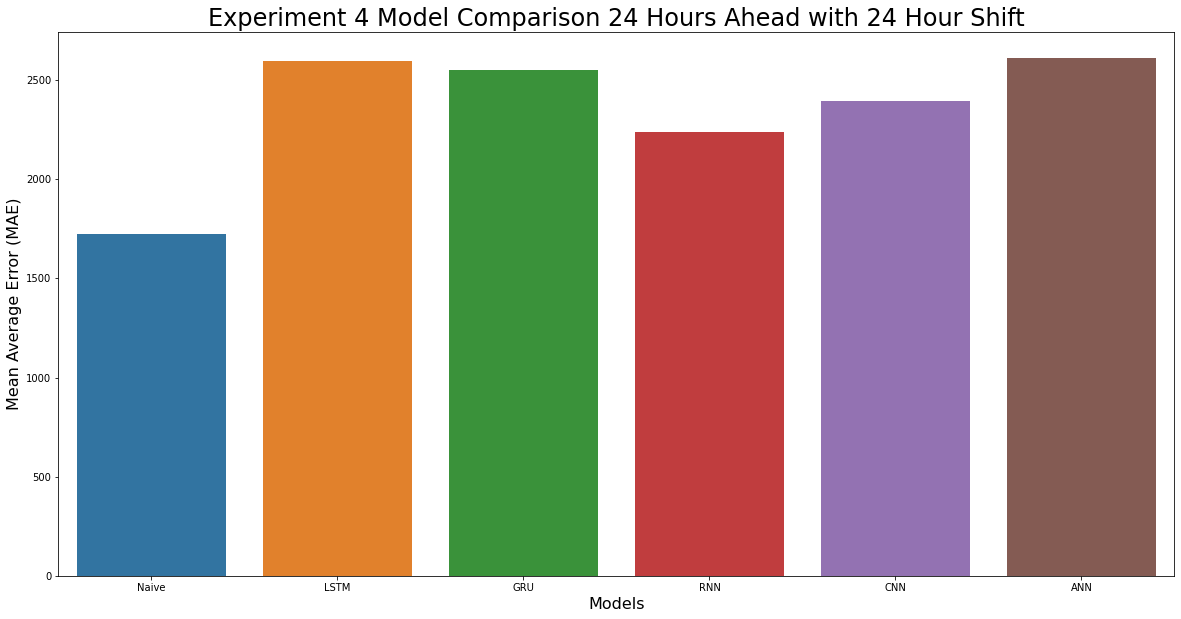

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 4 Model Comparison 24 Hours Ahead with 24 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Deeper Layers (1 hour ahead)** 

In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex4_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex4_1hour_ahead.test], axis=0)

input_shape = (input_width, ex4_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_lstm_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex4_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex4_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 100s 69ms/step - loss: 1939.7480 - val_loss: 987.3000 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 96s 68ms/step - loss: 1710.3542 - val_loss: 1105.0989 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 96s 68ms/step - loss: 1651.3213 - val_loss: 834.5663 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 96s 68ms/step - loss: 1361.1528 - val_loss: 805.9474 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 96s 68ms/step - loss: 1319.7242 - val_loss: 784.8502 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 97s 69ms/step - loss: 1327.9247 - val_loss: 790.2701 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 96s 69ms/step - loss: 1379.7307 - val_loss: 801.7256 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 96s 68ms/step - loss: 1258.1110 - val_loss: 761.5978 - lr: 0.0010
Epoch 9/100
14

In [ ]:
lstm = keras.models.load_model(path + '/models/ex4_lstm_3layers.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1589.9756

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex4_gru_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex4_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex4_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 95s 65ms/step - loss: 1309.2518 - val_loss: 703.2068 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 89s 63ms/step - loss: 1061.5176 - val_loss: 607.1843 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 87s 62ms/step - loss: 876.6565 - val_loss: 486.5020 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 88s 63ms/step - loss: 819.5384 - val_loss: 485.5250 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 88s 63ms/step - loss: 803.7173 - val_loss: 475.7482 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 88s 62ms/step - loss: 838.2274 - val_loss: 507.8672 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 88s 63ms/step - loss: 813.1594 - val_loss: 464.3223 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 89s 63ms/step - loss: 786.6838 - val_loss: 453.8493 - lr: 0.0010
Epoch 9/100
1407/1407 

In [ ]:
gru = keras.models.load_model(path + '/models/ex4_gru_3layers.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

943.9395

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_rnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex4_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex4_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 42s 29ms/step - loss: 985.4816 - val_loss: 471.1197 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 41s 29ms/step - loss: 798.3857 - val_loss: 481.4103 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 40s 29ms/step - loss: 780.9316 - val_loss: 459.5838 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 40s 29ms/step - loss: 767.1513 - val_loss: 462.0520 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 41s 29ms/step - loss: 758.2180 - val_loss: 443.8868 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 42s 30ms/step - loss: 750.2245 - val_loss: 443.6753 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 40s 29ms/step - loss: 744.1456 - val_loss: 443.6091 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 40s 29ms/step - loss: 734.7312 - val_loss: 440.4474 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
rnn = keras.models.load_model(path + '/models/ex4_rnn_3layers.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

987.16846

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_cnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex4_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex4_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 138s 97ms/step - loss: 1350.2070 - val_loss: 725.7783 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 133s 94ms/step - loss: 1198.0352 - val_loss: 711.3713 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 134s 95ms/step - loss: 1058.5665 - val_loss: 653.8551 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 135s 96ms/step - loss: 945.3343 - val_loss: 616.6846 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 134s 96ms/step - loss: 874.8394 - val_loss: 550.2007 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 133s 95ms/step - loss: 842.6577 - val_loss: 530.1764 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 134s 95ms/step - loss: 832.9487 - val_loss: 519.8549 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 134s 95ms/step - loss: 799.9827 - val_loss: 508.2120 - lr: 0.0010
Epoch 9/100
1

In [ ]:
cnn = keras.models.load_model(path + '/models/ex4_cnn_3layers.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1009.74097

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex4_ann_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex4_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex4_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 15s 10ms/step - loss: 940.2024 - val_loss: 470.1068 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 15s 10ms/step - loss: 804.0041 - val_loss: 463.7653 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 15s 11ms/step - loss: 793.0790 - val_loss: 458.9271 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 771.0278 - val_loss: 473.8380 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 767.3358 - val_loss: 464.6869 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 15s 11ms/step - loss: 766.7709 - val_loss: 453.8841 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 15s 10ms/step - loss: 763.6830 - val_loss: 450.1428 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 14s 10ms/step - loss: 754.6405 - val_loss: 448.8667 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
ann = keras.models.load_model(path + '/models/ex4_ann_3layers.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

987.847

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM         GRU         RNN          CNN         ANN
0  1104.352951  1589.975586  943.939514  987.168457  1009.740967  987.846985

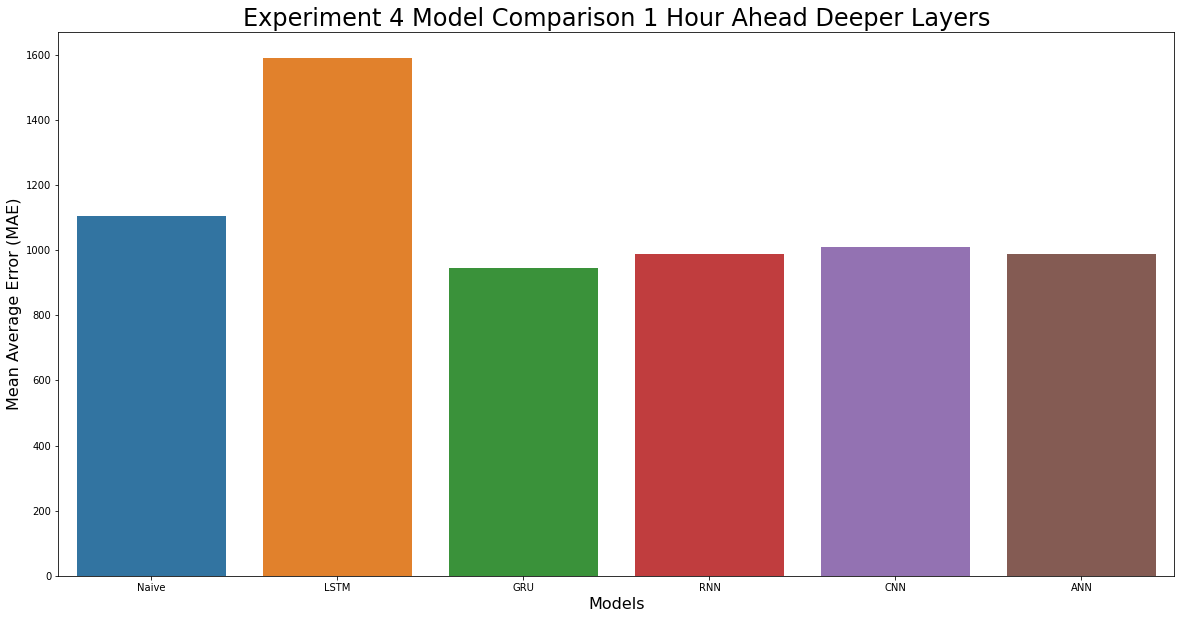

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 4 Model Comparison 1 Hour Ahead Deeper Layers", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

##**Experiment 5 - `Effective GWAP` + `Rolling Average` + datetime + lagged**



In [77]:
ex5_df = df_copy
ex5_df

Effective GWAP  Rolling Average  month  weekday  hour  \
Date_Interval                                                                
2015-01-23 00:00:00     1849.604375      4357.651316      1        4     0   
2015-01-23 01:00:00     1882.363158      4359.075739      1        4     1   
2015-01-23 02:00:00     1886.543140      4359.488924      1        4     2   
2015-01-23 03:00:00     1888.939469      4353.817912      1        4     3   
2015-01-23 04:00:00     4000.262110      4360.450629      1        4     4   
...                             ...              ...    ...      ...   ...   
2021-06-25 19:00:00     4582.463868      6823.492048      6        4    19   
2021-06-25 20:00:00    13468.269470      6871.667956      6        4    20   
2021-06-25 21:00:00     8069.676643      6866.547378      6        4    21   
2021-06-25 22:00:00     3628.883036      6860.123532      6        4    22   
2021-06-25 23:00:00     2975.500891      6856.019752      6        4    23   

                     morning  mid day  evening  weekend  season  lag_24_hours  \
Date_Interval                                                                   
2015-01-23 00:00:00      1.0      0.0      0.0      0.0     0.0   4038.461339   
2015-01-23 01:00:00      1.0      0.0      0.0      0.0     0.0   3506.938357   
2015-01-23 02:00:00      1.0      0.0      0.0      0.0     0.0   3865.155003   
2015-01-23 03:00:00      1.0      0.0      0.0      0.0     0.0   3555.473270   
2015-01-23 04:00:00      1.0      0.0      0.0      0.0     0.0   3500.074604   
...                      ...      ...      ...      ...     ...           ...   
2021-06-25 19:00:00      0.0      0.0      1.0      0.0     1.0  19126.570000   
2021-06-25 20:00:00      0.0      0.0      1.0      0.0     1.0  32390.800000   
2021-06-25 21:00:00      0.0      0.0      1.0      0.0     1.0  21516.500000   
2021-06-25 22:00:00      0.0      0.0      1.0      0.0     1.0   7862.060000   
2021-06-25 23:00:00      0.0      0.0      1.0      0.0     1.0   3424.130000   

                     lag_168_hours    lag_1_hour  lag_48_hours  lag_23_hours  \
Date_Interval                                                                  
2015-01-23 00:00:00    3008.675689   1436.897013   3994.478574   3506.938357   
2015-01-23 01:00:00    1643.060137   1849.604375   3616.561381   3865.155003   
2015-01-23 02:00:00    1817.127920   1882.363158   3909.627385   3555.473270   
2015-01-23 03:00:00    2841.669516   1886.543140   3976.082463   3500.074604   
2015-01-23 04:00:00    2885.965633   1888.939469   4104.101996   4030.370105   
...                            ...           ...           ...           ...   
2021-06-25 19:00:00   21446.290000   4578.853699   4527.210000  32390.800000   
2021-06-25 20:00:00   31957.030000   4582.463868   7986.910000  21516.500000   
2021-06-25 21:00:00   32769.440000  13468.269470   8097.570000   7862.060000   
2021-06-25 22:00:00   21886.270000   8069.676643   7615.450000   3424.130000   
2021-06-25 23:00:00   10441.410000   3628.883036   3404.990000   2983.963822   

                     lag_72_hours  lag_336_hours  
Date_Interval                                     
2015-01-23 00:00:00   1852.680439    1822.506078  
2015-01-23 01:00:00   1849.559571    1752.397260  
2015-01-23 02:00:00   1892.741375    1539.379580  
2015-01-23 03:00:00   1882.103641    1815.911913  
2015-01-23 04:00:00   1899.117471    2884.785234  
...                           ...            ...  
2021-06-25 19:00:00   8042.210000    2728.080000  
2021-06-25 20:00:00   7672.180000    2357.150000  
2021-06-25 21:00:00   4559.260000    2368.550000  
2021-06-25 22:00:00   4531.760000    2250.120000  
2021-06-25 23:00:00   2892.190000    2260.750000  

[56304 rows x 17 columns]

In [78]:
ex5_train_df = ex5_df[0:train_end_idx]
ex5_val_df = ex5_df[train_end_idx:val_end_idx]
ex5_test_df = ex5_df[val_end_idx:test_end_idx]

###**Forecast 1 hour ahead**

In [81]:
input_width = 24
label_width = 1
shift = 1

ex5_1hour_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex5_train_df, val_df=ex5_val_df, test_df=ex5_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [82]:
for samples, labels in ex5_1hour_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 17)
(32, 1)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex5_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex5_1hour_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex5_df.shape[-1])
input_shape

(24, 17)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_lstm_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex5_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex5_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 37s 25ms/step - loss: 1762.5658 - val_loss: 847.8030 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1528.0515 - val_loss: 859.6779 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 3200.9617 - val_loss: 1098.8152 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1584.8070 - val_loss: 852.9041 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1435.7736 - val_loss: 829.6517 - lr: 8.0000e-04
Epoch 6/100
1407/1407 [==============================] - 37s 27ms/step - loss: 1424.3032 - val_loss: 765.1226 - lr: 8.0000e-04
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1292.2837 - val_loss: 783.9418 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1229.9761 - val_loss: 741.0979 - lr: 8.0000e-04

In [ ]:
lstm = keras.models.load_model(path + '/models/ex5_lstm_1hour_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1025.5266

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex5_gru_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex5_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex5_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 35s 24ms/step - loss: 1120.2380 - val_loss: 615.4552 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 921.6442 - val_loss: 514.8042 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 853.8030 - val_loss: 514.7933 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 34s 24ms/step - loss: 834.4865 - val_loss: 531.9754 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 825.2994 - val_loss: 464.0968 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 34s 24ms/step - loss: 801.1417 - val_loss: 464.3333 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 791.3867 - val_loss: 455.3545 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 34s 24ms/step - loss: 787.1642 - val_loss: 449.4199 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
gru = keras.models.load_model(path + '/models/ex5_gru_1hour_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

998.47253

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_rnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex5_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex5_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 19s 12ms/step - loss: 1065.8521 - val_loss: 522.3074 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 19s 14ms/step - loss: 824.6916 - val_loss: 462.8632 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 798.0980 - val_loss: 457.7284 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 19s 13ms/step - loss: 776.6923 - val_loss: 462.1926 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 19s 14ms/step - loss: 771.0453 - val_loss: 461.6422 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 19s 14ms/step - loss: 768.0236 - val_loss: 460.1210 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 19s 13ms/step - loss: 746.7107 - val_loss: 451.9444 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 19s 13ms/step - loss: 743.5045 - val_loss: 456.2286 - lr: 8.0000e-04
Epoch 9/100
140

In [ ]:
rnn = keras.models.load_model(path + '/models/ex5_rnn_1hour_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

986.08954

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_cnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex5_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex5_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1185.5797 - val_loss: 651.1077 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 15s 11ms/step - loss: 965.4737 - val_loss: 578.0285 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 905.1512 - val_loss: 535.5946 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 16s 11ms/step - loss: 866.0782 - val_loss: 520.8968 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 15s 11ms/step - loss: 855.5450 - val_loss: 492.0789 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 15s 11ms/step - loss: 826.7994 - val_loss: 495.7972 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 830.9258 - val_loss: 493.5094 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 15s 11ms/step - loss: 827.7731 - val_loss: 496.4580 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
cnn = keras.models.load_model(path + '/models/ex5_cnn_1hour_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1039.1309

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_ann_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex5_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex5_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1059.6805 - val_loss: 489.3349 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 832.6305 - val_loss: 481.2187 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 807.7661 - val_loss: 459.9768 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 784.5950 - val_loss: 452.5901 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 771.2463 - val_loss: 453.8372 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 767.7785 - val_loss: 450.6309 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 762.7764 - val_loss: 450.3691 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 10s 7ms/step - loss: 760.3300 - val_loss: 446.0202 - lr: 0.0010
Epoch 9/100
1407/1407 [========

In [ ]:
ann = keras.models.load_model(path + '/models/ex5_ann_1hour_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

980.0239

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM         GRU         RNN          CNN         ANN
0  1104.352951  1025.526611  998.472534  986.089539  1039.130859  980.023926

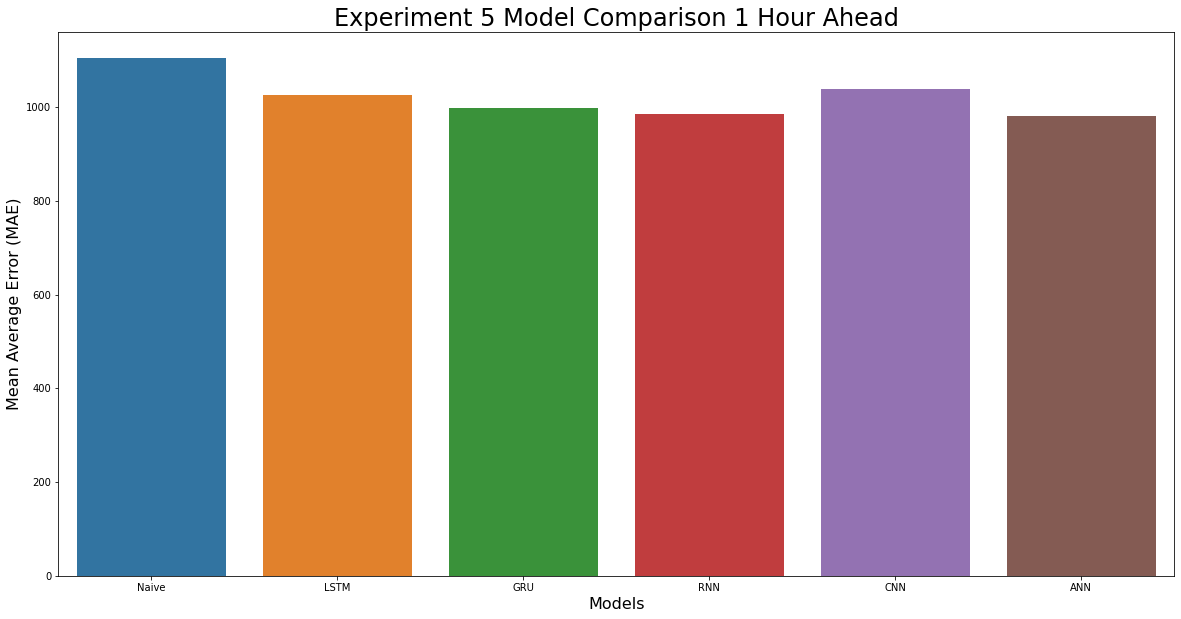

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 5 Model Comparison 1 Hour Ahead", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead**

In [ ]:
input_width = 24
label_width = 12
shift = 1

ex5_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex5_train_df, val_df=ex5_val_df, test_df=ex5_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex5_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 17)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex5_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex5_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex5_df.shape[-1])
input_shape

(24, 17)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1101.2762310150465

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_lstm_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex5_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex5_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 40s 27ms/step - loss: 1572.4409 - val_loss: 892.7867 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1491.1724 - val_loss: 935.2200 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1738.2234 - val_loss: 982.9376 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 39s 28ms/step - loss: 1437.6268 - val_loss: 813.7339 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1292.2300 - val_loss: 708.3359 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1179.5219 - val_loss: 789.6144 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1153.8436 - val_loss: 656.2349 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 39s 27ms/step - loss: 843.9567 - val_loss: 432.4755 - lr: 0.0010
Epoch 9/100
1407/

In [ ]:
lstm = keras.models.load_model(path + '/models/ex5_lstm_12hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

88.87284

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex5_gru_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex5_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 36s 25ms/step - loss: 726.5425 - val_loss: 247.4816 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 331.5627 - val_loss: 149.3607 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 250.7063 - val_loss: 131.3855 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 209.1311 - val_loss: 102.3894 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 196.9875 - val_loss: 82.5750 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 34s 24ms/step - loss: 148.3373 - val_loss: 76.4744 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 144.3529 - val_loss: 70.2591 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 34s 24ms/step - loss: 133.2682 - val_loss: 79.3668 - lr: 0.0010
Epoch 9/100
1407/1407 [=====

In [ ]:
gru = keras.models.load_model(path + '/models/ex5_gru_12hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

87.76191

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_rnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex5_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 20s 14ms/step - loss: 482.7581 - val_loss: 148.5036 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 19s 14ms/step - loss: 201.9536 - val_loss: 108.8213 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 19s 14ms/step - loss: 162.9442 - val_loss: 89.9943 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 19s 13ms/step - loss: 148.3247 - val_loss: 72.5227 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 19s 13ms/step - loss: 140.8398 - val_loss: 64.6329 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 19s 13ms/step - loss: 127.8745 - val_loss: 64.7923 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 18s 13ms/step - loss: 126.6755 - val_loss: 71.8729 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 20s 14ms/step - loss: 124.5884 - val_loss: 62.5144 - lr: 0.0010
Epoch 9/100
1407/1407 [=======

In [ ]:
rnn = keras.models.load_model(path + '/models/ex5_rnn_12hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

84.32208

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex5_cnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex5_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 16s 11ms/step - loss: 825.6426 - val_loss: 232.1196 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 15s 11ms/step - loss: 371.5050 - val_loss: 176.2634 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 15s 11ms/step - loss: 301.7442 - val_loss: 198.6944 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 295.5903 - val_loss: 140.0503 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 15s 11ms/step - loss: 281.2318 - val_loss: 127.8789 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 264.1459 - val_loss: 116.8593 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 254.0873 - val_loss: 137.6273 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 15s 11ms/step - loss: 235.3548 - val_loss: 149.0298 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
cnn = keras.models.load_model(path + '/models/ex5_cnn_12hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

98.13597

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_ann_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex5_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 11s 8ms/step - loss: 483.5356 - val_loss: 143.7637 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 209.5749 - val_loss: 106.7074 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 11s 8ms/step - loss: 179.0278 - val_loss: 89.3085 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 157.6454 - val_loss: 99.3837 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 11s 7ms/step - loss: 141.9952 - val_loss: 73.3423 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 11s 8ms/step - loss: 139.4010 - val_loss: 71.6111 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 132.5549 - val_loss: 73.4003 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 11s 8ms/step - loss: 123.0897 - val_loss: 61.5614 - lr: 0.0010
Epoch 9/100
1407/1407 [===============

In [ ]:
ann = keras.models.load_model(path + '/models/ex5_ann_12hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

84.779816

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive       LSTM        GRU        RNN        CNN        ANN
0  1101.276231  88.872841  87.761909  84.322083  98.135971  84.779816

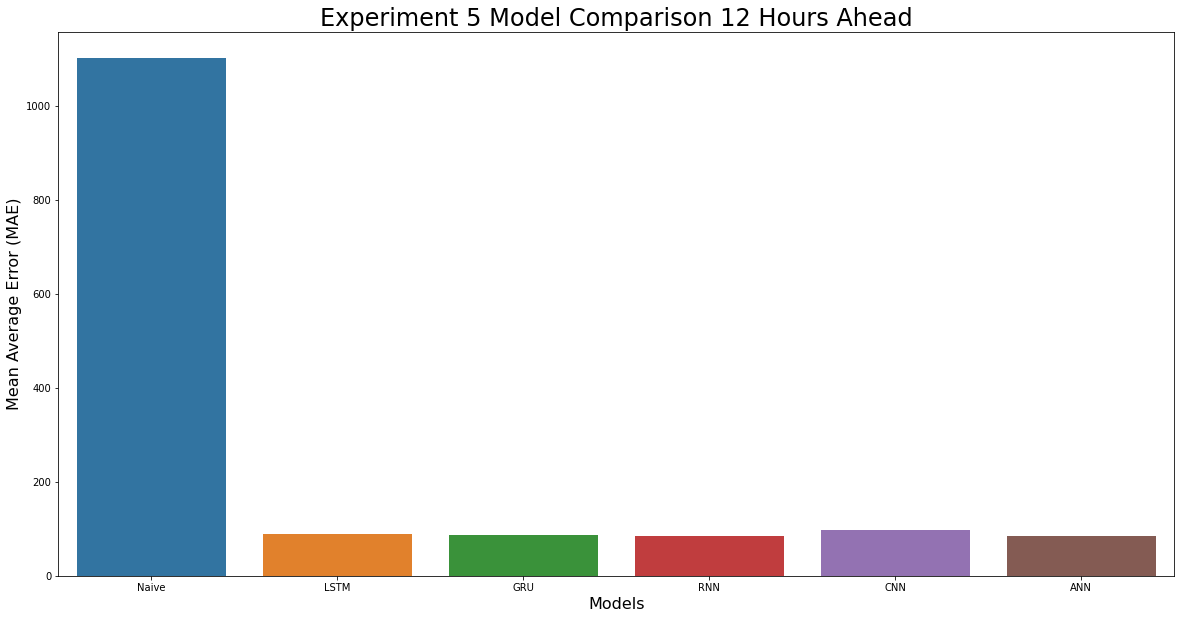

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 5 Model Comparison 12 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead 12 hour shift**

In [ ]:
input_width = 24
label_width = 12
shift = 12

ex5_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex5_train_df, val_df=ex5_val_df, test_df=ex5_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex5_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 17)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex5_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex5_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex5_df.shape[-1])
input_shape

(24, 17)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

2667.674529034868

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_lstm_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex5_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex5_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
118/118 [==============================] - 8s 52ms/step - loss: 2323.6704 - val_loss: 1304.1184 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 5s 43ms/step - loss: 1807.8524 - val_loss: 1200.4954 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 5s 40ms/step - loss: 1626.3301 - val_loss: 1132.6034 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 5s 40ms/step - loss: 1449.3231 - val_loss: 1043.7235 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 5s 42ms/step - loss: 1389.3331 - val_loss: 922.5850 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 5s 42ms/step - loss: 1458.0278 - val_loss: 1116.8344 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 5s 41ms/step - loss: 1469.5421 - val_loss: 1026.3414 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 5s 40ms/step - loss: 1542.7046 - val_loss: 1135.2258 - lr: 0.0010
Epoch 9/100
118/118 [============

In [ ]:
lstm = keras.models.load_model(path + '/models/ex5_lstm_12hours_ahead_12hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1924.4307

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex5_gru_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex5_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
118/118 [==============================] - 8s 42ms/step - loss: 1421.4886 - val_loss: 919.3520 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 5s 40ms/step - loss: 1190.3472 - val_loss: 853.3016 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 5s 40ms/step - loss: 1139.9738 - val_loss: 878.9115 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 4s 37ms/step - loss: 1129.1788 - val_loss: 897.6375 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 6s 48ms/step - loss: 1165.9736 - val_loss: 910.9730 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 5s 40ms/step - loss: 1123.7742 - val_loss: 838.8442 - lr: 8.0000e-04
Epoch 7/100
118/118 [==============================] - 5s 40ms/step - loss: 1083.7614 - val_loss: 822.7084 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 5s 40ms/step - loss: 1052.5989 - val_loss: 826.7784 - lr: 8.0000e-04
Epoch 9/100
118/118 [=======

In [ ]:
gru = keras.models.load_model(path + '/models/ex5_gru_12hours_ahead_12hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1779.0916

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_rnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex5_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 5s 28ms/step - loss: 1412.0815 - val_loss: 893.5750 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 3s 25ms/step - loss: 1162.1481 - val_loss: 856.4956 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 3s 24ms/step - loss: 1084.7430 - val_loss: 836.9870 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 3s 24ms/step - loss: 1041.2083 - val_loss: 855.4257 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 3s 22ms/step - loss: 1013.3137 - val_loss: 838.7750 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 3s 23ms/step - loss: 999.3329 - val_loss: 858.1864 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 3s 24ms/step - loss: 1007.8209 - val_loss: 861.2814 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 3s 23ms/step - loss: 1011.3370 - val_loss: 903.8931 - lr: 8.0000e-04
Epoch 9/100
118/118 [============

In [ ]:
rnn = keras.models.load_model(path + '/models/ex5_rnn_12hours_ahead_12hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1878.4526

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex5_cnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex5_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 3s 18ms/step - loss: 1368.4263 - val_loss: 1072.6130 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 2s 17ms/step - loss: 1186.9447 - val_loss: 863.4316 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 2s 17ms/step - loss: 1115.0505 - val_loss: 866.4437 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 2s 17ms/step - loss: 1085.1176 - val_loss: 879.0385 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 2s 19ms/step - loss: 1070.3463 - val_loss: 839.0248 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 2s 17ms/step - loss: 1052.0785 - val_loss: 850.0724 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 2s 18ms/step - loss: 1033.6967 - val_loss: 838.2679 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 2s 17ms/step - loss: 1009.8952 - val_loss: 847.2311 - lr: 0.0010
Epoch 9/100
118/118 [==================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex5_cnn_12hours_ahead_12hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1698.3358

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_ann_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex5_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
118/118 [==============================] - 2s 12ms/step - loss: 1422.5043 - val_loss: 919.4606 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 10ms/step - loss: 1196.8022 - val_loss: 873.6855 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 11ms/step - loss: 1105.9742 - val_loss: 845.0812 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 11ms/step - loss: 1049.6677 - val_loss: 825.7744 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 12ms/step - loss: 1015.3947 - val_loss: 817.5373 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 11ms/step - loss: 1006.7700 - val_loss: 825.1242 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 11ms/step - loss: 987.6463 - val_loss: 825.0529 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 1s 11ms/step - loss: 971.7153 - val_loss: 830.7715 - lr: 0.0010
Epoch 9/100
118/118 [=====================

In [ ]:
ann = keras.models.load_model(path + '/models/ex5_ann_12hours_ahead_12hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1729.9574

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  2667.674529  1924.430664  1779.091553  1878.452637  1698.335815   

           ANN  
0  1729.957397

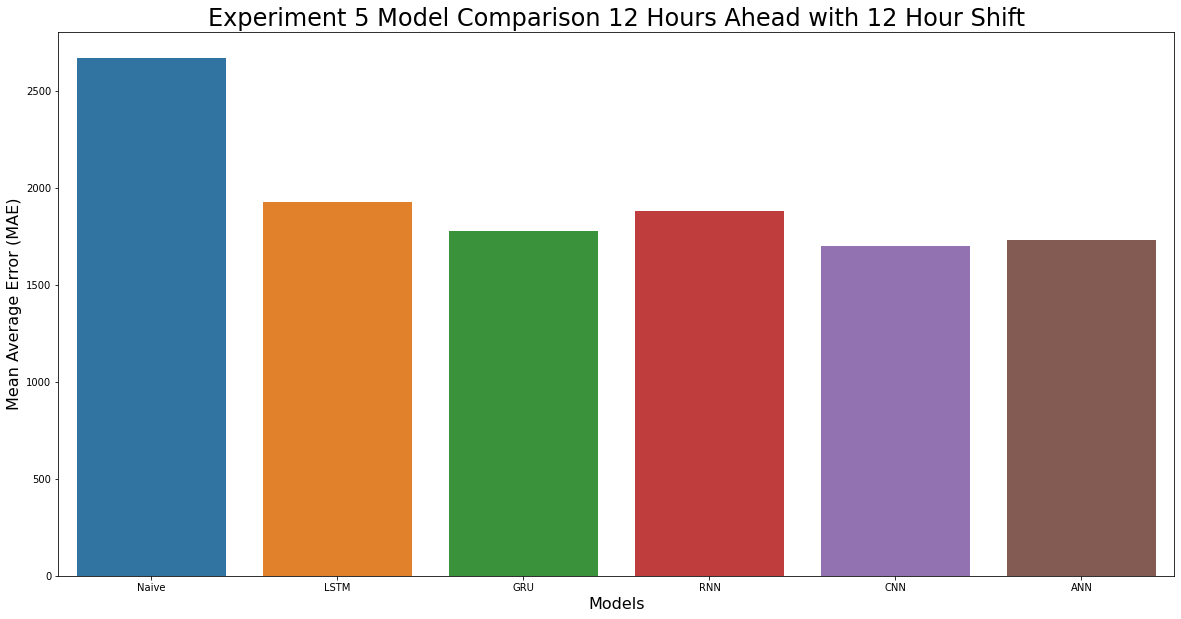

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 5 Model Comparison 12 Hours Ahead with 12 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead**

In [ ]:
input_width = 24
label_width = 24
shift = 1

ex5_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex5_train_df, val_df=ex5_val_df, test_df=ex5_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex5_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 17)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex5_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex5_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex5_df.shape[-1])
input_shape

(24, 17)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1098.3518162532384

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_lstm_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex5_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex5_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 38s 26ms/step - loss: 1409.9491 - val_loss: 688.1741 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1209.0250 - val_loss: 662.1753 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 38s 27ms/step - loss: 919.2515 - val_loss: 511.0424 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 38s 27ms/step - loss: 637.2939 - val_loss: 292.5815 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 37s 26ms/step - loss: 419.3093 - val_loss: 210.7464 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 37s 26ms/step - loss: 279.9987 - val_loss: 131.8721 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 37s 27ms/step - loss: 204.8332 - val_loss: 94.4059 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 37s 26ms/step - loss: 159.5651 - val_loss: 79.1870 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
lstm = keras.models.load_model(path + '/models/ex5_lstm_24hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

56.27378

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_gru_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex5_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 34s 23ms/step - loss: 647.1469 - val_loss: 165.9449 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 34s 24ms/step - loss: 218.0243 - val_loss: 94.6621 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 154.8872 - val_loss: 72.4563 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 34s 24ms/step - loss: 116.2202 - val_loss: 58.0648 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 105.5012 - val_loss: 53.1336 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 34s 24ms/step - loss: 94.6125 - val_loss: 56.6572 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 87.4082 - val_loss: 44.4804 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 34s 24ms/step - loss: 82.3930 - val_loss: 59.4642 - lr: 0.0010
Epoch 9/100
1407/1407 [===========

In [ ]:
gru = keras.models.load_model(path + '/models/ex5_gru_24hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

45.029755

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_rnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex5_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 20s 13ms/step - loss: 449.4233 - val_loss: 131.1951 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 19s 14ms/step - loss: 200.6368 - val_loss: 91.2158 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 19s 13ms/step - loss: 136.0935 - val_loss: 61.0816 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 19s 14ms/step - loss: 114.8978 - val_loss: 52.1876 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 19s 13ms/step - loss: 105.8248 - val_loss: 53.8569 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 95.9518 - val_loss: 51.6775 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 19s 14ms/step - loss: 88.8555 - val_loss: 48.4827 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 19s 13ms/step - loss: 84.8366 - val_loss: 44.7589 - lr: 0.0010
Epoch 9/100
1407/1407 [===========

In [ ]:
rnn = keras.models.load_model(path + '/models/ex5_rnn_24hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

45.09904

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_cnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex5_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 15s 10ms/step - loss: 622.8250 - val_loss: 221.2892 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 260.5940 - val_loss: 141.4717 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 15s 10ms/step - loss: 206.1306 - val_loss: 118.0134 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 181.2349 - val_loss: 107.7025 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 167.2909 - val_loss: 99.6439 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 163.0381 - val_loss: 108.3748 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 151.6105 - val_loss: 101.0947 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 14s 10ms/step - loss: 155.7385 - val_loss: 113.0159 - lr: 0.0010
Epoch 9/100
1407/1407 [==

In [ ]:
cnn = keras.models.load_model(path + '/models/ex5_cnn_24hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

47.74319

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_ann_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex5_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 11s 7ms/step - loss: 446.8669 - val_loss: 116.9074 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 210.2988 - val_loss: 80.1016 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 11s 7ms/step - loss: 138.8152 - val_loss: 64.7019 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 131.3504 - val_loss: 61.8629 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 117.7208 - val_loss: 50.1951 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 11s 8ms/step - loss: 103.6115 - val_loss: 54.6617 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 11s 8ms/step - loss: 101.4929 - val_loss: 57.9896 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 11s 8ms/step - loss: 103.4409 - val_loss: 43.0155 - lr: 0.0010
Epoch 9/100
1407/1407 [================

In [ ]:
ann = keras.models.load_model(path + '/models/ex5_ann_24hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

43.48293

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive       LSTM        GRU        RNN        CNN        ANN
0  1098.351816  56.273781  45.029755  45.099041  47.743191  43.482929

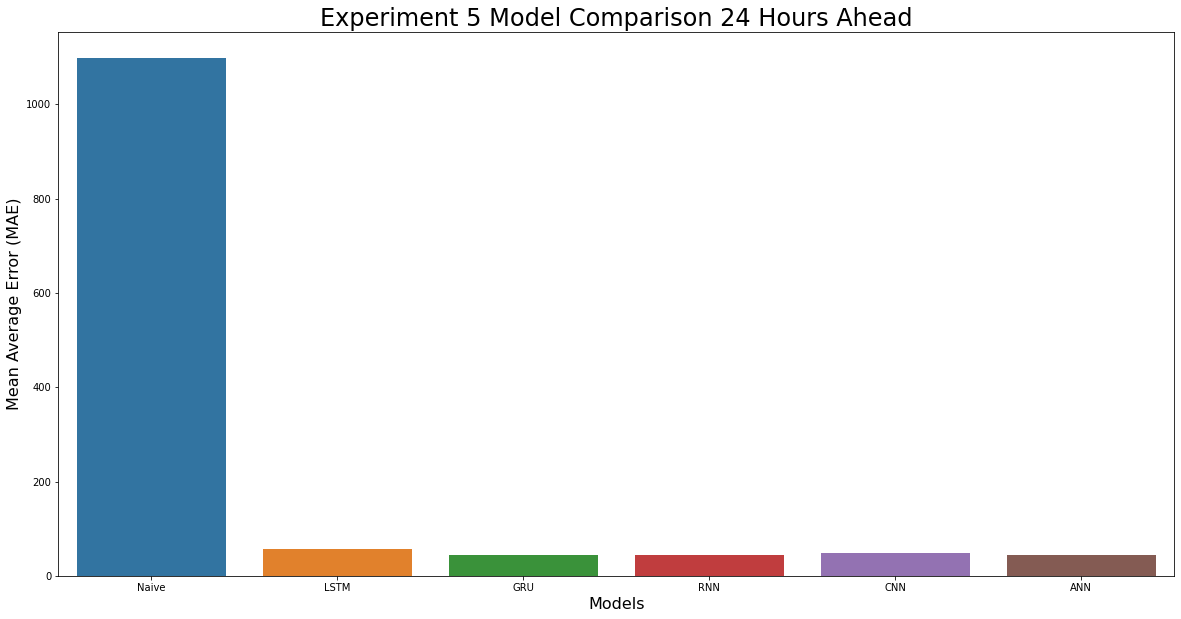

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 5 Model Comparison 24 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead 24 hour shift**

In [ ]:
input_width = 24
label_width = 24
shift = 24

ex5_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex5_train_df, val_df=ex5_val_df, test_df=ex5_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex5_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 17)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex5_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex5_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex5_df.shape[-1])
input_shape

(24, 17)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1722.1445946783263

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_lstm_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex5_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex5_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
59/59 [==============================] - 5s 50ms/step - loss: 1776.6740 - val_loss: 1104.5822 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 3s 43ms/step - loss: 1512.5907 - val_loss: 1204.2125 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 3s 45ms/step - loss: 1461.8268 - val_loss: 1131.0818 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 3s 48ms/step - loss: 1463.7407 - val_loss: 1077.5767 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 3s 43ms/step - loss: 1358.7852 - val_loss: 1157.9462 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 42ms/step - loss: 1328.8895 - val_loss: 1084.1208 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 2s 42ms/step - loss: 1302.3231 - val_loss: 1096.2938 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 2s 41ms/step - loss: 1287.1920 - val_loss: 1098.4874 - lr: 8.0000e-04
Epoch 9/100
59/59 [=========================

In [ ]:
lstm = keras.models.load_model(path + '/models/ex5_lstm_24hours_ahead_24hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

2164.8457

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex5_gru_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex5_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
59/59 [==============================] - 5s 48ms/step - loss: 1527.2483 - val_loss: 974.6004 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 39ms/step - loss: 1243.1725 - val_loss: 899.4099 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 41ms/step - loss: 1187.6151 - val_loss: 921.5331 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 41ms/step - loss: 1159.5610 - val_loss: 958.1827 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 41ms/step - loss: 1149.1212 - val_loss: 979.9381 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 3s 43ms/step - loss: 1128.5818 - val_loss: 935.0030 - lr: 8.0000e-04
Epoch 7/100
59/59 [==============================] - 2s 40ms/step - loss: 1115.2476 - val_loss: 926.6242 - lr: 8.0000e-04
Epoch 8/100
59/59 [==============================] - 2s 41ms/step - loss: 1105.8695 - val_loss: 914.3478 - lr: 8.0000e-04
Epoch 9/100
59/59 [=========================

In [ ]:
gru = keras.models.load_model(path + '/models/ex5_gru_24hours_ahead_24hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

2429.6812

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_rnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex5_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 4s 41ms/step - loss: 1632.9242 - val_loss: 1102.3168 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 26ms/step - loss: 1248.3430 - val_loss: 993.4356 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 23ms/step - loss: 1168.8550 - val_loss: 1002.6965 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 26ms/step - loss: 1124.7524 - val_loss: 949.8453 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 27ms/step - loss: 1101.4983 - val_loss: 939.8569 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 22ms/step - loss: 1081.4506 - val_loss: 942.6082 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 24ms/step - loss: 1073.5334 - val_loss: 967.8524 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 25ms/step - loss: 1056.2092 - val_loss: 976.3011 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1

In [ ]:
rnn = keras.models.load_model(path + '/models/ex5_rnn_24hours_ahead_24hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

2343.5354

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex5_cnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex5_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 2s 22ms/step - loss: 1494.0627 - val_loss: 1141.7515 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 17ms/step - loss: 1254.7313 - val_loss: 1149.8558 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 20ms/step - loss: 1209.2178 - val_loss: 1097.2953 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 19ms/step - loss: 1181.7061 - val_loss: 1068.2340 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 20ms/step - loss: 1162.4742 - val_loss: 1054.1885 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 18ms/step - loss: 1154.3464 - val_loss: 1069.4886 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 19ms/step - loss: 1150.6630 - val_loss: 1103.9125 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 19ms/step - loss: 1138.3427 - val_loss: 1108.1172 - lr: 0.0010
Epoch 9/100
59/59 [=============================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex5_cnn_24hours_ahead_24hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

2452.786

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_ann_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex5_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex5_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
59/59 [==============================] - 2s 16ms/step - loss: 1524.7278 - val_loss: 1077.7919 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 14ms/step - loss: 1223.2834 - val_loss: 1030.4889 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 11ms/step - loss: 1170.9384 - val_loss: 987.4719 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 12ms/step - loss: 1141.4395 - val_loss: 990.5541 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 11ms/step - loss: 1124.5721 - val_loss: 992.1537 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 13ms/step - loss: 1097.7209 - val_loss: 962.2449 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 21ms/step - loss: 1091.7716 - val_loss: 939.7413 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 14ms/step - loss: 1082.0476 - val_loss: 948.5287 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1

In [ ]:
ann = keras.models.load_model(path + '/models/ex5_ann_24hours_ahead_24hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

2385.412

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive         LSTM          GRU        RNN          CNN          ANN
0  1722.144595  2164.845703  2429.681152  2343.5354  2452.785889  2385.412109

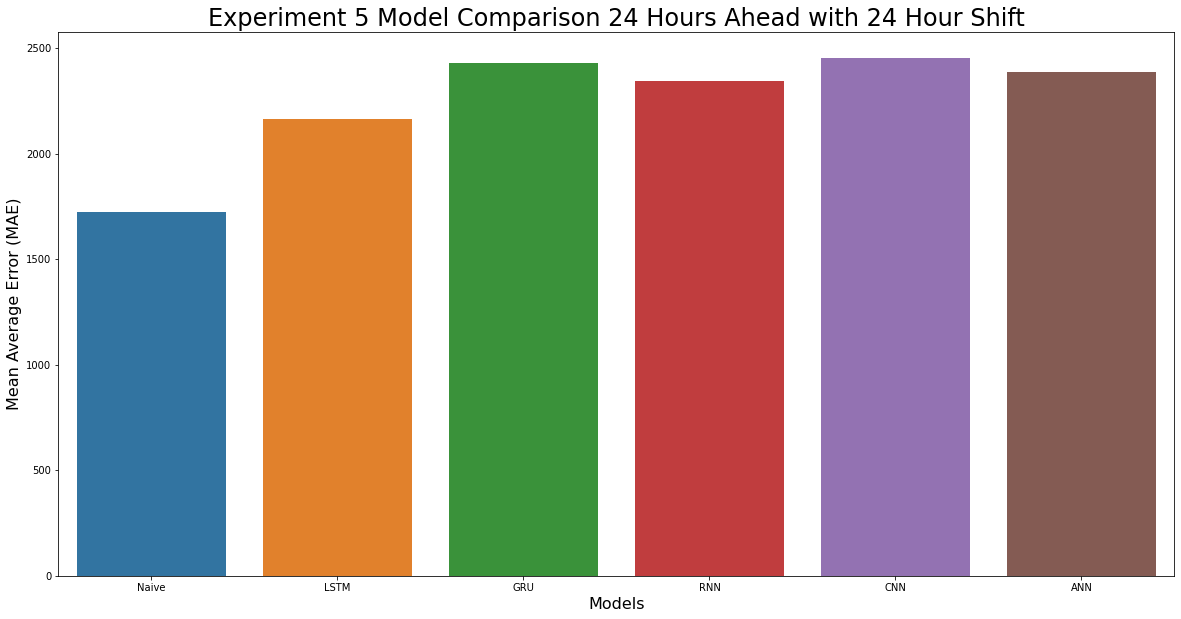

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 5 Model Comparison 24 Hours Ahead with 24 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Deeper Layers (1 hour ahead)** 

In [83]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex5_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex5_1hour_ahead.test], axis=0)

input_shape = (input_width, ex5_df.shape[-1])
input_shape

(24, 17)

Naive

In [80]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

2190.2994938200713

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_lstm_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex5_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex5_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 99s 68ms/step - loss: 2950.8125 - val_loss: 1175.8237 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 96s 68ms/step - loss: 2601.3167 - val_loss: 1244.8964 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 96s 69ms/step - loss: 1711.6661 - val_loss: 937.0402 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 95s 67ms/step - loss: 1513.1102 - val_loss: 1004.6205 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 96s 68ms/step - loss: 1657.1101 - val_loss: 889.5479 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 97s 69ms/step - loss: 1522.2344 - val_loss: 1003.5997 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 96s 68ms/step - loss: 1772.6796 - val_loss: 1172.1877 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 97s 69ms/step - loss: 1595.6207 - val_loss: 959.1230 - lr: 0.0010
Epoch 9/100

In [ ]:
lstm = keras.models.load_model(path + '/models/ex5_lstm_3layers.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1554.0375

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex5_gru_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex5_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex5_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 93s 63ms/step - loss: 1226.0249 - val_loss: 643.2557 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 89s 63ms/step - loss: 973.3423 - val_loss: 520.8192 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 89s 64ms/step - loss: 858.6699 - val_loss: 480.4215 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 89s 63ms/step - loss: 830.0510 - val_loss: 474.8514 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 89s 63ms/step - loss: 812.6406 - val_loss: 458.3924 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 88s 62ms/step - loss: 789.6183 - val_loss: 463.9608 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 90s 64ms/step - loss: 800.3718 - val_loss: 458.1244 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 89s 63ms/step - loss: 776.9321 - val_loss: 452.8387 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
gru = keras.models.load_model(path + '/models/ex5_gru_3layers.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

940.3708

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_rnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex5_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex5_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 43s 29ms/step - loss: 1011.0461 - val_loss: 508.8285 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 42s 30ms/step - loss: 811.0246 - val_loss: 461.6512 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 42s 30ms/step - loss: 779.5982 - val_loss: 471.4692 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 42s 30ms/step - loss: 770.3333 - val_loss: 465.1040 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 42s 30ms/step - loss: 755.4636 - val_loss: 447.0695 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 42s 30ms/step - loss: 745.7724 - val_loss: 445.2602 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 41s 29ms/step - loss: 737.4839 - val_loss: 445.6808 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 42s 29ms/step - loss: 730.5313 - val_loss: 444.3901 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
rnn = keras.models.load_model(path + '/models/ex5_rnn_3layers.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

980.1017

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_cnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex5_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex5_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 135s 96ms/step - loss: 1346.1747 - val_loss: 710.5057 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 136s 96ms/step - loss: 1131.7043 - val_loss: 668.5516 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 136s 97ms/step - loss: 987.2301 - val_loss: 620.2112 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 136s 97ms/step - loss: 913.4423 - val_loss: 576.8787 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 137s 97ms/step - loss: 870.1253 - val_loss: 541.1946 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 139s 99ms/step - loss: 830.1645 - val_loss: 536.3749 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 138s 98ms/step - loss: 810.4312 - val_loss: 526.5471 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 139s 99ms/step - loss: 797.1220 - val_loss: 531.1758 - lr: 0.0010
Epoch 9/100
14

In [ ]:
cnn = keras.models.load_model(path + '/models/ex5_cnn_3layers.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1028.0333

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex5_ann_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex5_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex5_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 14s 10ms/step - loss: 971.4277 - val_loss: 466.0025 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 13s 10ms/step - loss: 811.4477 - val_loss: 484.0874 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 798.4058 - val_loss: 460.0705 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 778.7047 - val_loss: 450.6151 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 767.8623 - val_loss: 477.6245 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 15s 10ms/step - loss: 761.6031 - val_loss: 447.9366 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 758.6425 - val_loss: 472.8037 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 13s 9ms/step - loss: 759.5284 - val_loss: 451.2083 - lr: 0.0010
Epoch 9/100
1407/1407 [==

In [ ]:
ann = keras.models.load_model(path + '/models/ex5_ann_3layers.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

997.02826

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM         GRU         RNN          CNN         ANN
0  1104.352951  1554.037476  940.370789  980.101685  1028.033325  997.028259

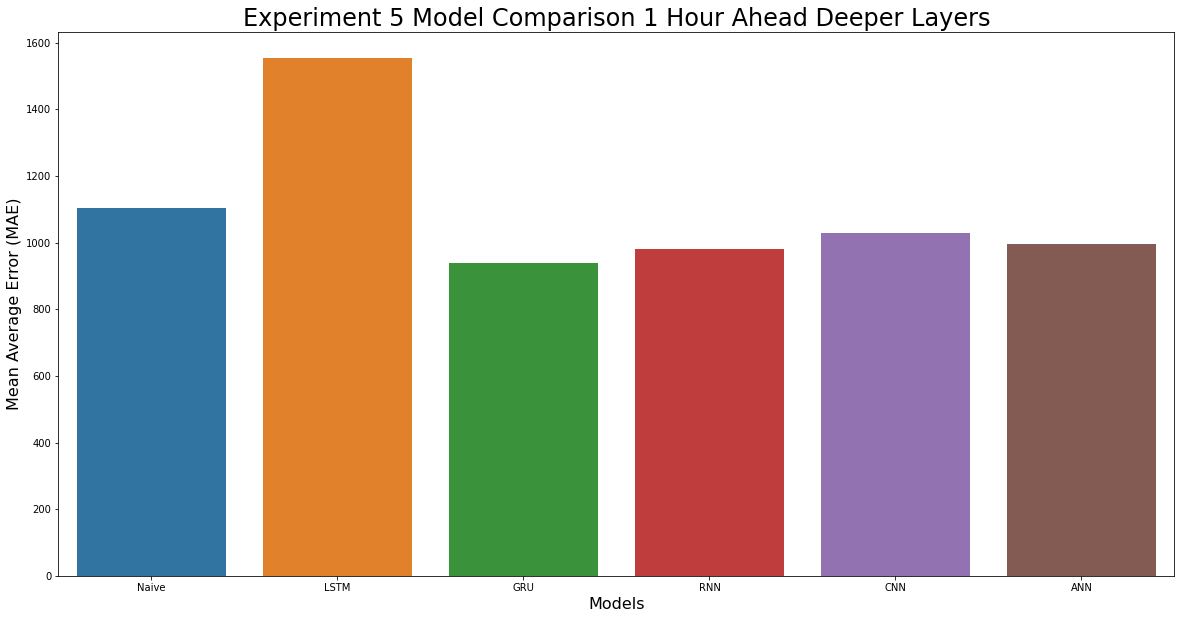

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 5 Model Comparison 1 Hour Ahead Deeper Layers", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

##**Experiment 6 - `Effective GWAP` + datetime**



In [41]:
ex6_df = df_copy.drop('Rolling Average', axis=1)
ex6_df = ex6_df.drop(ex6_df.columns[9:], axis=1)
ex6_df

Effective GWAP  month  weekday  hour  morning  mid day  \
Date_Interval                                                                 
2015-01-23 00:00:00     1849.604375      1        4     0      1.0      0.0   
2015-01-23 01:00:00     1882.363158      1        4     1      1.0      0.0   
2015-01-23 02:00:00     1886.543140      1        4     2      1.0      0.0   
2015-01-23 03:00:00     1888.939469      1        4     3      1.0      0.0   
2015-01-23 04:00:00     4000.262110      1        4     4      1.0      0.0   
...                             ...    ...      ...   ...      ...      ...   
2021-06-25 19:00:00     4582.463868      6        4    19      0.0      0.0   
2021-06-25 20:00:00    13468.269470      6        4    20      0.0      0.0   
2021-06-25 21:00:00     8069.676643      6        4    21      0.0      0.0   
2021-06-25 22:00:00     3628.883036      6        4    22      0.0      0.0   
2021-06-25 23:00:00     2975.500891      6        4    23      0.0      0.0   

                     evening  weekend  season  
Date_Interval                                  
2015-01-23 00:00:00      0.0      0.0     0.0  
2015-01-23 01:00:00      0.0      0.0     0.0  
2015-01-23 02:00:00      0.0      0.0     0.0  
2015-01-23 03:00:00      0.0      0.0     0.0  
2015-01-23 04:00:00      0.0      0.0     0.0  
...                      ...      ...     ...  
2021-06-25 19:00:00      1.0      0.0     1.0  
2021-06-25 20:00:00      1.0      0.0     1.0  
2021-06-25 21:00:00      1.0      0.0     1.0  
2021-06-25 22:00:00      1.0      0.0     1.0  
2021-06-25 23:00:00      1.0      0.0     1.0  

[56304 rows x 9 columns]

In [42]:
ex6_train_df = ex6_df[0:train_end_idx]
ex6_val_df = ex6_df[train_end_idx:val_end_idx]
ex6_test_df = ex6_df[val_end_idx:test_end_idx]

###**Forecast 1 hour ahead**

In [43]:
input_width = 24
label_width = 1
shift = 1

ex6_1hour_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex6_train_df, val_df=ex6_val_df, test_df=ex6_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [44]:
for samples, labels in ex6_1hour_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 9)
(32, 1)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex6_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex6_1hour_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex6_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_lstm_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex6_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex6_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 50s 34ms/step - loss: 1427.1041 - val_loss: 880.0553 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1267.4677 - val_loss: 636.2479 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1103.3047 - val_loss: 586.8784 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1276.9283 - val_loss: 637.3574 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1037.4211 - val_loss: 563.6160 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 34s 24ms/step - loss: 941.6420 - val_loss: 547.9988 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 906.7368 - val_loss: 526.2719 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 35s 25ms/step - loss: 896.9376 - val_loss: 530.8641 - lr: 0.0010
Epoch 9/100
1407/14

In [ ]:
lstm = keras.models.load_model(path + '/models/ex6_lstm_1hour_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1064.0306

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex6_gru_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex6_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex6_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 33s 22ms/step - loss: 944.7377 - val_loss: 479.9636 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 32s 23ms/step - loss: 815.3541 - val_loss: 472.0656 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 32s 22ms/step - loss: 811.1445 - val_loss: 473.2973 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 31s 22ms/step - loss: 807.0191 - val_loss: 469.6140 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 31s 22ms/step - loss: 804.7126 - val_loss: 469.9081 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 31s 22ms/step - loss: 801.1694 - val_loss: 474.3842 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 31s 22ms/step - loss: 818.3119 - val_loss: 469.1231 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 32s 23ms/step - loss: 800.7206 - val_loss: 464.6346 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
gru = keras.models.load_model(path + '/models/ex6_gru_1hour_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1027.6858

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_rnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex6_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex6_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 18s 12ms/step - loss: 865.7465 - val_loss: 473.6851 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 17s 12ms/step - loss: 807.6021 - val_loss: 468.6598 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 17s 12ms/step - loss: 793.6061 - val_loss: 474.4967 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 17s 12ms/step - loss: 783.4245 - val_loss: 467.4373 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 17s 12ms/step - loss: 775.0488 - val_loss: 465.7017 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 771.8950 - val_loss: 465.0461 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 758.8864 - val_loss: 453.5271 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 17s 12ms/step - loss: 754.5984 - val_loss: 457.6349 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
rnn = keras.models.load_model(path + '/models/ex6_rnn_1hour_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

929.6334

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_cnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex6_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex6_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 13s 9ms/step - loss: 941.1844 - val_loss: 481.3733 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 830.3063 - val_loss: 468.4048 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 11s 8ms/step - loss: 815.2974 - val_loss: 465.1266 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 11s 8ms/step - loss: 809.0425 - val_loss: 461.0351 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 12s 9ms/step - loss: 801.6416 - val_loss: 464.1602 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 11s 8ms/step - loss: 796.1461 - val_loss: 487.5150 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 12s 9ms/step - loss: 789.3154 - val_loss: 465.1200 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 12s 8ms/step - loss: 775.6956 - val_loss: 459.1971 - lr: 8.0000e-04
Epoch 9/100
1407/1407 [=====

In [ ]:
cnn = keras.models.load_model(path + '/models/ex6_cnn_1hour_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

976.5327

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_ann_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex6_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex6_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 10s 7ms/step - loss: 897.4193 - val_loss: 471.7807 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 830.4214 - val_loss: 466.1321 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 9s 7ms/step - loss: 822.6030 - val_loss: 458.8171 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 813.5275 - val_loss: 459.5932 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 9s 7ms/step - loss: 808.6671 - val_loss: 467.7887 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 804.4726 - val_loss: 480.4391 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 9s 7ms/step - loss: 797.5016 - val_loss: 477.5031 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 9s 7ms/step - loss: 794.7242 - val_loss: 478.1156 - lr: 8.0000e-04
Epoch 9/100
1407/1407 [=======

In [ ]:
ann = keras.models.load_model(path + '/models/ex6_ann_1hour_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1040.2953

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive        LSTM          GRU         RNN         CNN          ANN
0  1104.352951  1064.03064  1027.685791  929.633423  976.532715  1040.295288

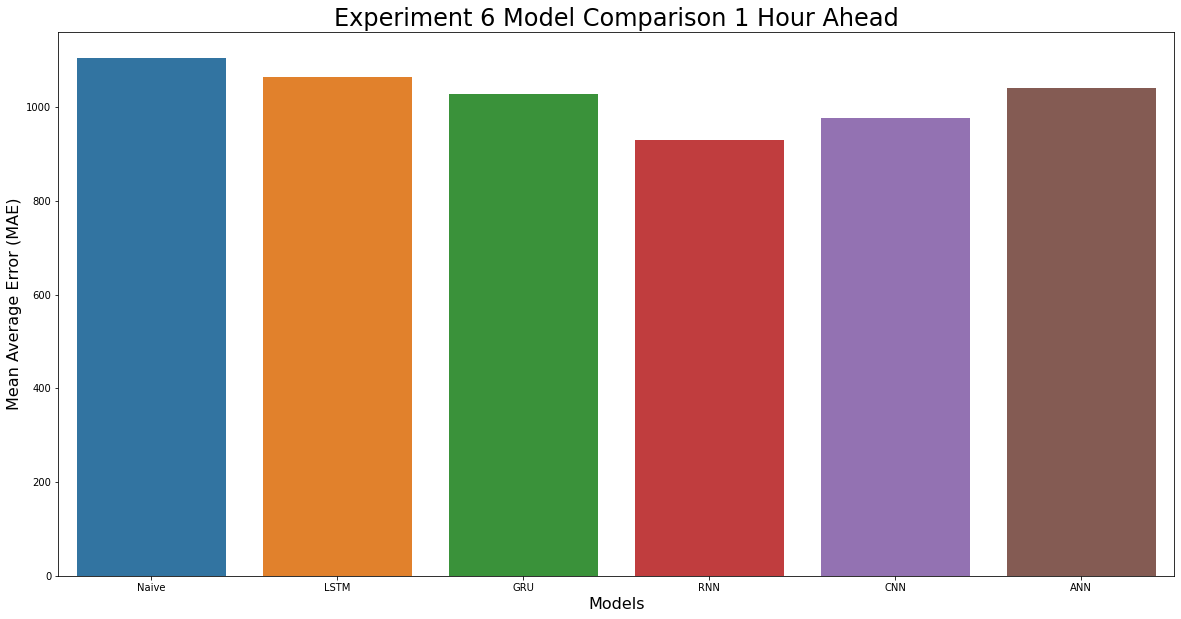

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 6 Model Comparison 1 Hour Ahead", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead**

In [ ]:
input_width = 24
label_width = 12
shift = 1

ex6_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex6_train_df, val_df=ex6_val_df, test_df=ex6_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex6_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 9)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex6_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex6_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex6_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1101.2762310150465

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_lstm_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex6_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex6_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1262.9781 - val_loss: 1137.5071 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1342.3917 - val_loss: 960.4681 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1097.8750 - val_loss: 586.7086 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 34s 24ms/step - loss: 962.8281 - val_loss: 489.4524 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 938.5162 - val_loss: 771.6313 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 35s 25ms/step - loss: 882.4017 - val_loss: 440.1470 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 823.4919 - val_loss: 606.1168 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 34s 24ms/step - loss: 760.6652 - val_loss: 396.4905 - lr: 0.0010
Epoch 9/100
1407/140

In [ ]:
lstm = keras.models.load_model(path + '/models/ex6_lstm_12hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

91.27778

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex6_gru_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex6_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 33s 22ms/step - loss: 363.8008 - val_loss: 68.6834 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 32s 23ms/step - loss: 115.4618 - val_loss: 58.2047 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 32s 23ms/step - loss: 107.8624 - val_loss: 61.4432 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 33s 23ms/step - loss: 102.6897 - val_loss: 55.8477 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 33s 23ms/step - loss: 99.7237 - val_loss: 53.4733 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 35s 25ms/step - loss: 97.7861 - val_loss: 52.4913 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 32s 23ms/step - loss: 93.2838 - val_loss: 50.9016 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 32s 23ms/step - loss: 93.0052 - val_loss: 50.4640 - lr: 0.0010
Epoch 9/100
1407/1407 [=============

In [ ]:
gru = keras.models.load_model(path + '/models/ex6_gru_12hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

89.65215

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_rnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex6_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 18s 12ms/step - loss: 226.2883 - val_loss: 67.1428 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 18s 12ms/step - loss: 122.2464 - val_loss: 60.5442 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 17s 12ms/step - loss: 112.8217 - val_loss: 56.2620 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 17s 12ms/step - loss: 106.7051 - val_loss: 56.7784 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 17s 12ms/step - loss: 104.1184 - val_loss: 54.5296 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 99.3435 - val_loss: 53.1341 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 101.4538 - val_loss: 48.8374 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 17s 12ms/step - loss: 96.1051 - val_loss: 50.5948 - lr: 0.0010
Epoch 9/100
1407/1407 [===========

In [ ]:
rnn = keras.models.load_model(path + '/models/ex6_rnn_12hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

84.7616

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex6_cnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex6_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 13s 9ms/step - loss: 343.7419 - val_loss: 92.1301 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 165.0456 - val_loss: 76.0465 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 13s 10ms/step - loss: 155.5249 - val_loss: 73.0205 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 13s 9ms/step - loss: 140.4762 - val_loss: 71.6496 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 139.2698 - val_loss: 66.4945 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 13s 9ms/step - loss: 132.6746 - val_loss: 77.6057 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 133.7135 - val_loss: 80.9896 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 13s 9ms/step - loss: 132.7789 - val_loss: 84.5755 - lr: 0.0010
Epoch 9/100
1407/1407 [================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex6_cnn_12hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

86.30781

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_ann_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex6_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 265.5099 - val_loss: 79.0237 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 8s 6ms/step - loss: 132.7841 - val_loss: 64.7981 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 122.7629 - val_loss: 68.2613 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 117.2139 - val_loss: 65.7978 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 116.0387 - val_loss: 54.1389 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 109.6740 - val_loss: 57.0203 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 108.7919 - val_loss: 56.5999 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 9s 6ms/step - loss: 105.9262 - val_loss: 50.9132 - lr: 0.0010
Epoch 9/100
1407/1407 [========================

In [ ]:
ann = keras.models.load_model(path + '/models/ex6_ann_12hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

87.04325

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive       LSTM        GRU        RNN        CNN        ANN
0  1101.276231  91.277779  89.652153  84.761597  86.307808  87.043251

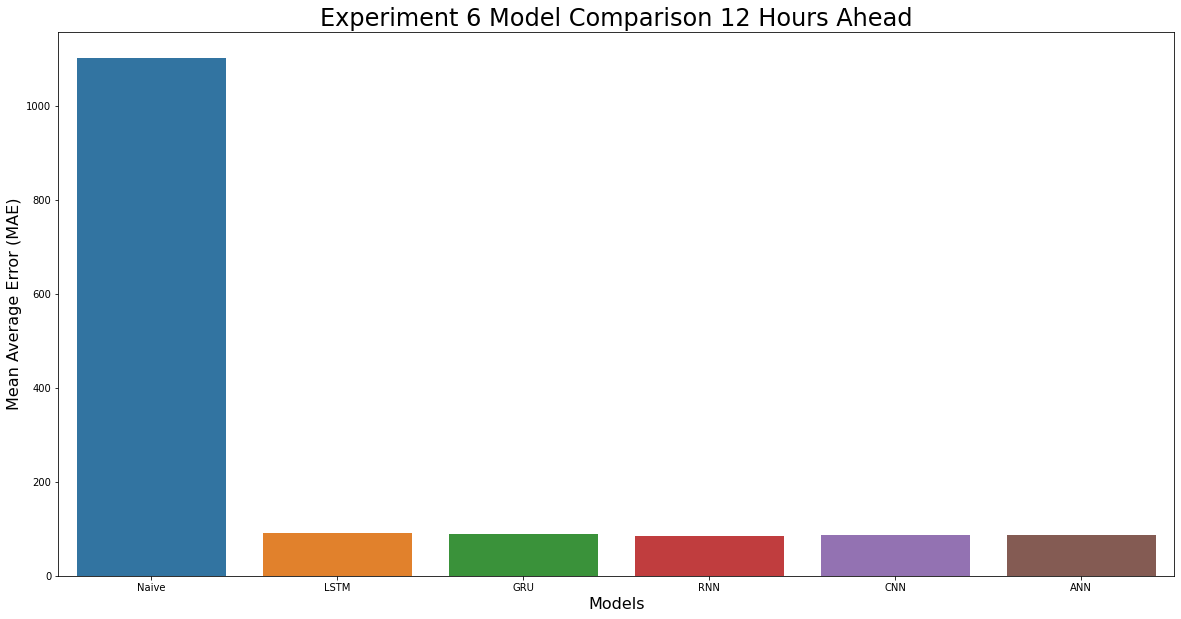

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 6 Model Comparison 12 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead 12 hour shift**

In [91]:
input_width = 24
label_width = 12
shift = 12

ex6_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex6_train_df, val_df=ex6_val_df, test_df=ex6_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [92]:
for samples, labels in ex6_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 9)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex6_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex6_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex6_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

2667.674529034868

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_lstm_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex6_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex6_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
118/118 [==============================] - 7s 41ms/step - loss: 1502.3390 - val_loss: 877.1127 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 5s 40ms/step - loss: 1269.3513 - val_loss: 845.7217 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 5s 42ms/step - loss: 1195.3528 - val_loss: 817.8019 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 5s 40ms/step - loss: 1138.8528 - val_loss: 809.0805 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 5s 40ms/step - loss: 1133.7379 - val_loss: 820.5876 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 5s 40ms/step - loss: 1156.2638 - val_loss: 834.6215 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 5s 40ms/step - loss: 1133.6942 - val_loss: 816.1015 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 5s 40ms/step - loss: 1102.1410 - val_loss: 813.7162 - lr: 8.0000e-04
Epoch 9/100
118/118 [===============

In [ ]:
lstm = keras.models.load_model(path + '/models/ex6_lstm_12hours_ahead_12hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1724.753

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex6_gru_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex6_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
118/118 [==============================] - 5s 28ms/step - loss: 1390.7589 - val_loss: 820.1957 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 3s 26ms/step - loss: 1139.9076 - val_loss: 799.5040 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 3s 26ms/step - loss: 1111.8287 - val_loss: 824.5343 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 3s 28ms/step - loss: 1089.2946 - val_loss: 798.5458 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 3s 25ms/step - loss: 1089.4950 - val_loss: 833.8574 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 3s 25ms/step - loss: 1072.4397 - val_loss: 812.3350 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 3s 27ms/step - loss: 1053.2391 - val_loss: 817.0152 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 3s 25ms/step - loss: 1033.3698 - val_loss: 807.0539 - lr: 8.0000e-04
Epoch 9/100
118/118 [===============

In [ ]:
gru = keras.models.load_model(path + '/models/ex6_gru_12hours_ahead_12hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1738.0048

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_rnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex6_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 3s 17ms/step - loss: 1285.4224 - val_loss: 841.0366 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 2s 15ms/step - loss: 1101.4916 - val_loss: 817.6319 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 2s 16ms/step - loss: 1064.8534 - val_loss: 797.8701 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 2s 14ms/step - loss: 1044.4185 - val_loss: 808.1034 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 2s 16ms/step - loss: 1028.6613 - val_loss: 800.1701 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 2s 15ms/step - loss: 1022.8203 - val_loss: 812.9536 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 2s 15ms/step - loss: 1004.0608 - val_loss: 826.0834 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 2s 15ms/step - loss: 991.0713 - val_loss: 827.3176 - lr: 8.0000e-04
Epoch 9/100
118/118 [============

In [ ]:
rnn = keras.models.load_model(path + '/models/ex6_rnn_12hours_ahead_12hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1856.064

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex6_cnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex6_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 2s 12ms/step - loss: 1373.8159 - val_loss: 921.8510 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 11ms/step - loss: 1123.4905 - val_loss: 817.5919 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 11ms/step - loss: 1074.5298 - val_loss: 826.8088 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 11ms/step - loss: 1051.9241 - val_loss: 849.1881 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 11ms/step - loss: 1034.9233 - val_loss: 835.7704 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 11ms/step - loss: 1027.3064 - val_loss: 879.8011 - lr: 8.0000e-04
Epoch 7/100
118/118 [==============================] - 1s 11ms/step - loss: 1014.7853 - val_loss: 872.2908 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 1s 11ms/step - loss: 1006.4051 - val_loss: 861.9919 - lr: 8.0000e-04
Epoch 9/100
118/118 [=======

In [ ]:
cnn = keras.models.load_model(path + '/models/ex6_cnn_12hours_ahead_12hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1615.192

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_ann_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex6_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
118/118 [==============================] - 2s 9ms/step - loss: 1306.5388 - val_loss: 867.2947 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 9ms/step - loss: 1132.3741 - val_loss: 849.9095 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 8ms/step - loss: 1099.3060 - val_loss: 850.9008 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 8ms/step - loss: 1083.8795 - val_loss: 834.6484 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 9ms/step - loss: 1069.9900 - val_loss: 841.1130 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 9ms/step - loss: 1061.7251 - val_loss: 842.6764 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 9ms/step - loss: 1055.9388 - val_loss: 830.7117 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 1s 8ms/step - loss: 1050.1981 - val_loss: 831.6440 - lr: 0.0010
Epoch 9/100
118/118 [===========================

In [ ]:
ann = keras.models.load_model(path + '/models/ex6_ann_12hours_ahead_12hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1787.6346

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  2667.674529  1724.753052  1738.004761  1856.063965  1615.192017   

           ANN  
0  1787.634644

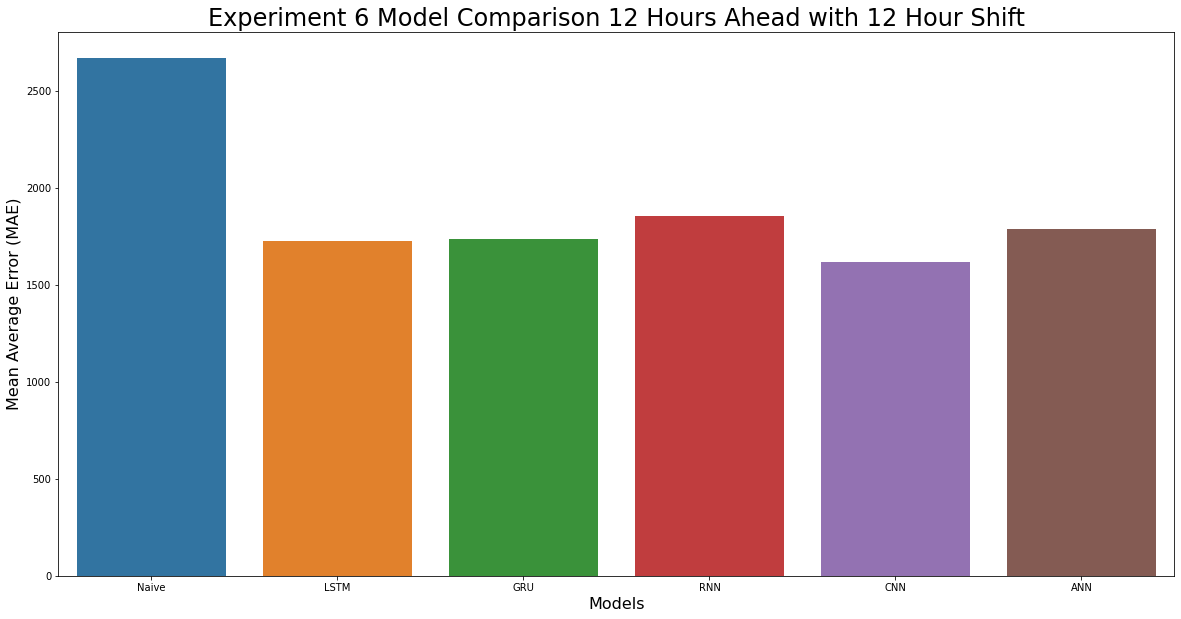

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 6 Model Comparison 12 Hours Ahead with 12 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead**

In [67]:
input_width = 24
label_width = 24
shift = 1

ex6_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex6_train_df, val_df=ex6_val_df, test_df=ex6_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [68]:
for samples, labels in ex6_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 9)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex6_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex6_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex6_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1098.3518162532384

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_lstm_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex6_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex6_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 37s 25ms/step - loss: 823.8953 - val_loss: 368.2326 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 709.3639 - val_loss: 699.9385 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 35s 25ms/step - loss: 884.6100 - val_loss: 391.5141 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 596.4896 - val_loss: 296.9585 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 35s 25ms/step - loss: 508.1459 - val_loss: 272.4785 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 36s 25ms/step - loss: 478.0612 - val_loss: 245.4467 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 439.1555 - val_loss: 236.9166 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 35s 25ms/step - loss: 346.4460 - val_loss: 178.4395 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
lstm = keras.models.load_model(path + '/models/ex6_lstm_24hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

44.60672

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_gru_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex6_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 34s 24ms/step - loss: 320.1003 - val_loss: 47.7735 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 77.7303 - val_loss: 37.3604 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 33s 24ms/step - loss: 72.5395 - val_loss: 36.3635 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 33s 23ms/step - loss: 65.9063 - val_loss: 37.0010 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 63.3411 - val_loss: 36.6047 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 33s 24ms/step - loss: 61.9465 - val_loss: 32.6565 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 33s 24ms/step - loss: 60.9966 - val_loss: 32.3252 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 33s 24ms/step - loss: 59.0853 - val_loss: 28.7288 - lr: 0.0010
Epoch 9/100
1407/1407 [================

In [ ]:
gru = keras.models.load_model(path + '/models/ex6_gru_24hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

44.676865

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_rnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex6_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 19s 13ms/step - loss: 188.9106 - val_loss: 52.3919 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 19s 14ms/step - loss: 91.4455 - val_loss: 47.6544 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 19s 13ms/step - loss: 81.9883 - val_loss: 37.5254 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 20s 14ms/step - loss: 73.8795 - val_loss: 37.6286 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 18s 13ms/step - loss: 72.9457 - val_loss: 34.0821 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 70.3910 - val_loss: 32.8567 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 19s 13ms/step - loss: 66.9202 - val_loss: 34.1931 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 19s 13ms/step - loss: 63.6228 - val_loss: 29.8179 - lr: 0.0010
Epoch 9/100
1407/1407 [================

In [ ]:
rnn = keras.models.load_model(path + '/models/ex6_rnn_24hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

44.354294

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_cnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex6_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 13s 9ms/step - loss: 275.6550 - val_loss: 77.0859 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 113.7960 - val_loss: 57.1009 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 108.5174 - val_loss: 59.7680 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 13s 9ms/step - loss: 101.9214 - val_loss: 46.1915 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 101.3635 - val_loss: 50.2139 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 12s 9ms/step - loss: 95.1445 - val_loss: 48.6395 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 93.6044 - val_loss: 45.5854 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 12s 9ms/step - loss: 93.0664 - val_loss: 52.8737 - lr: 0.0010
Epoch 9/100
1407/1407 [====================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex6_cnn_24hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

43.149265

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_ann_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex6_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 244.6658 - val_loss: 44.5637 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 92.9937 - val_loss: 42.2509 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 88.5657 - val_loss: 44.3295 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 82.0857 - val_loss: 35.8886 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 78.5793 - val_loss: 34.2690 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 76.7682 - val_loss: 33.5531 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 74.3256 - val_loss: 34.6638 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 9s 6ms/step - loss: 73.2744 - val_loss: 35.2224 - lr: 0.0010
Epoch 9/100
1407/1407 [==============================] 

In [ ]:
ann = keras.models.load_model(path + '/models/ex6_ann_24hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

44.31343

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive      LSTM        GRU        RNN        CNN        ANN
0  1098.351816  44.60672  44.676865  44.354294  43.149265  44.313431

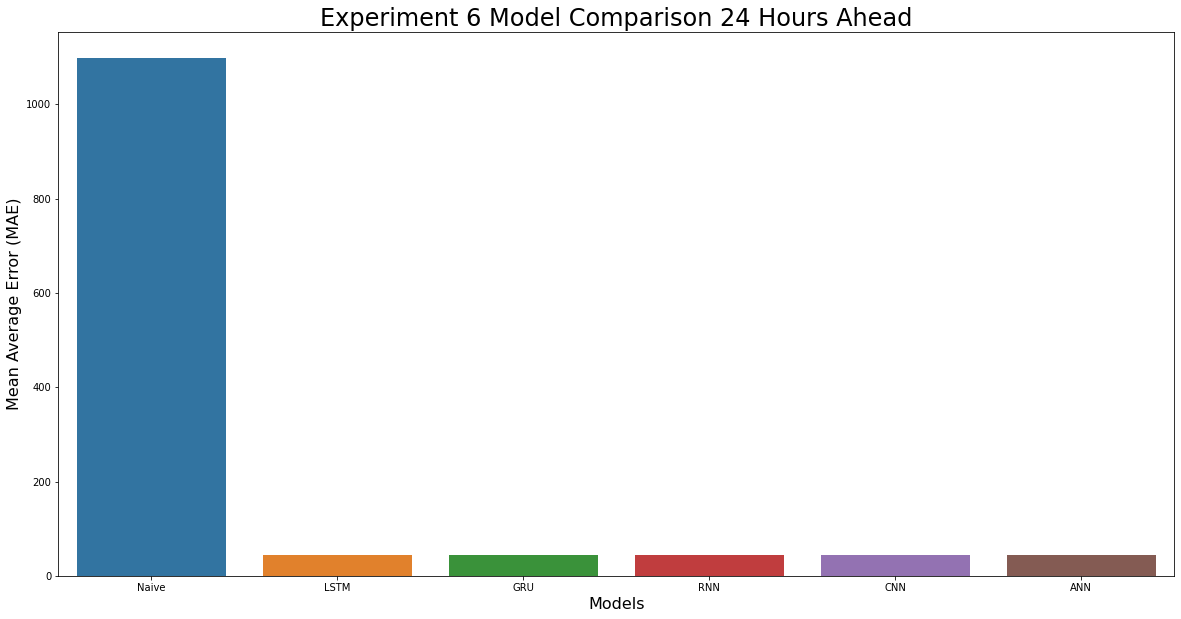

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 6 Model Comparison 24 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead 24 hour shift**

In [ ]:
input_width = 24
label_width = 24
shift = 24

ex6_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex6_train_df, val_df=ex6_val_df, test_df=ex6_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex6_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 9)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex6_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex6_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex6_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1722.1445946783263

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_lstm_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex6_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex6_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
59/59 [==============================] - 4s 34ms/step - loss: 1703.8795 - val_loss: 1266.7185 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 29ms/step - loss: 1411.3534 - val_loss: 1093.0607 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 29ms/step - loss: 1356.4550 - val_loss: 951.7495 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 30ms/step - loss: 1308.8540 - val_loss: 923.9841 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 31ms/step - loss: 1242.0061 - val_loss: 989.8992 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 29ms/step - loss: 1246.2374 - val_loss: 862.4241 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 2s 30ms/step - loss: 1247.2650 - val_loss: 855.2942 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 2s 29ms/step - loss: 1222.7275 - val_loss: 866.7363 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 2

In [ ]:
lstm = keras.models.load_model(path + '/models/ex6_lstm_24hours_ahead_24hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

2316.1382

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex6_gru_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex6_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
59/59 [==============================] - 3s 32ms/step - loss: 1556.4103 - val_loss: 963.4042 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 28ms/step - loss: 1207.4297 - val_loss: 919.8284 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 28ms/step - loss: 1185.0193 - val_loss: 912.7807 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 27ms/step - loss: 1168.0613 - val_loss: 921.5360 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 28ms/step - loss: 1164.9296 - val_loss: 883.2616 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 27ms/step - loss: 1196.2448 - val_loss: 921.8233 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 2s 26ms/step - loss: 1158.2720 - val_loss: 901.4732 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 2s 28ms/step - loss: 1148.5627 - val_loss: 884.0789 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 2s 

In [ ]:
gru = keras.models.load_model(path + '/models/ex6_gru_24hours_ahead_24hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

2322.1099

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_rnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex6_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 2s 21ms/step - loss: 1391.0958 - val_loss: 927.0496 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 16ms/step - loss: 1179.4976 - val_loss: 932.0831 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 16ms/step - loss: 1159.3617 - val_loss: 914.8213 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 18ms/step - loss: 1148.6127 - val_loss: 912.6290 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 16ms/step - loss: 1142.3142 - val_loss: 922.3362 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 18ms/step - loss: 1134.4592 - val_loss: 918.6555 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 17ms/step - loss: 1130.9521 - val_loss: 911.7233 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 16ms/step - loss: 1122.5261 - val_loss: 920.1670 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1s 

In [ ]:
rnn = keras.models.load_model(path + '/models/ex6_rnn_24hours_ahead_24hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

2485.0334

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex6_cnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex6_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 14ms/step - loss: 1423.2098 - val_loss: 1073.9659 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 13ms/step - loss: 1217.5363 - val_loss: 1054.0023 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 13ms/step - loss: 1198.9413 - val_loss: 1052.9850 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 13ms/step - loss: 1200.4998 - val_loss: 987.8870 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 13ms/step - loss: 1195.8774 - val_loss: 979.0872 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 12ms/step - loss: 1168.5958 - val_loss: 1014.1846 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 12ms/step - loss: 1155.9701 - val_loss: 1030.7808 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 12ms/step - loss: 1151.5736 - val_loss: 1031.8751 - lr: 0.0010
Epoch 9/100
59/59 [==============================]

In [ ]:
cnn = keras.models.load_model(path + '/models/ex6_cnn_24hours_ahead_24hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

2530.3875

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_ann_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex6_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex6_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 12ms/step - loss: 1420.3229 - val_loss: 868.6094 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 9ms/step - loss: 1193.0865 - val_loss: 909.4858 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 9ms/step - loss: 1170.1913 - val_loss: 917.2292 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 9ms/step - loss: 1163.6089 - val_loss: 907.3875 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 10ms/step - loss: 1154.5560 - val_loss: 909.5823 - lr: 8.0000e-04
Epoch 6/100
59/59 [==============================] - 1s 10ms/step - loss: 1152.1832 - val_loss: 903.7074 - lr: 8.0000e-04
Epoch 7/100
59/59 [==============================] - 1s 9ms/step - loss: 1148.8030 - val_loss: 899.3098 - lr: 8.0000e-04
Epoch 8/100
59/59 [==============================] - 1s 9ms/step - loss: 1144.8253 - val_loss: 890.7066 - lr: 6.4000e-04
Epoch 9/100
59/59 [==========================

In [ ]:
ann = keras.models.load_model(path + '/models/ex6_ann_24hours_ahead_24hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

2373.1213

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  1722.144595  2316.138184  2322.109863  2485.033447  2530.387451   

           ANN  
0  2373.121338

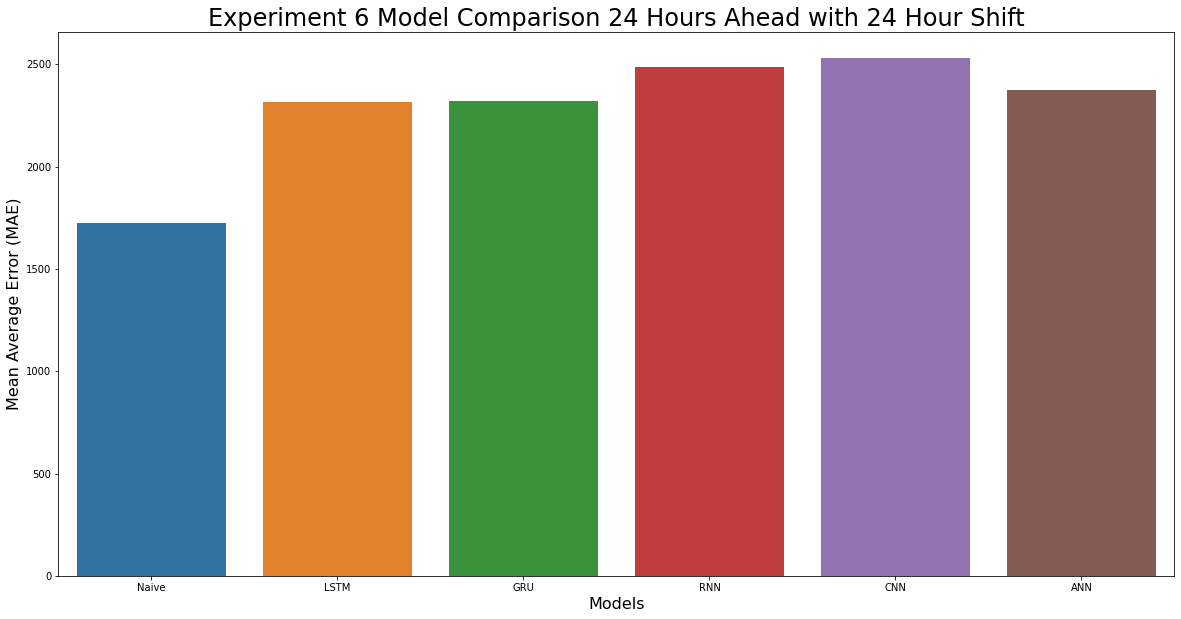

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 6 Model Comparison 24 Hours Ahead with 24 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Deeper Layers (1 hour ahead)** 

In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex6_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex6_1hour_ahead.test], axis=0)

input_shape = (input_width, ex6_df.shape[-1])
input_shape

(24, 9)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_lstm_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex6_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex6_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 97s 66ms/step - loss: 1470.5129 - val_loss: 817.3235 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 96s 68ms/step - loss: 1619.5042 - val_loss: 822.9136 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 93s 66ms/step - loss: 1400.4923 - val_loss: 769.8592 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 126s 90ms/step - loss: 1292.1707 - val_loss: 762.1901 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 143s 102ms/step - loss: 1274.3207 - val_loss: 764.5238 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 149s 106ms/step - loss: 1796.3933 - val_loss: 801.2728 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 146s 104ms/step - loss: 1285.1785 - val_loss: 773.5943 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 157s 112ms/step - loss: 1252.0724 - val_loss: 765.0205 - lr: 8.0000e-04
Epo

In [ ]:
lstm = keras.models.load_model(path + '/models/ex6_lstm_3layers.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1542.5436

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex6_gru_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex6_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex6_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 90s 61ms/step - loss: 975.1415 - val_loss: 472.2991 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 85s 61ms/step - loss: 821.7554 - val_loss: 464.1942 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 86s 61ms/step - loss: 811.1725 - val_loss: 467.9636 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 87s 62ms/step - loss: 811.9247 - val_loss: 467.5438 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 86s 61ms/step - loss: 821.8885 - val_loss: 459.3085 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 86s 61ms/step - loss: 808.8337 - val_loss: 466.8597 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 86s 61ms/step - loss: 802.4368 - val_loss: 467.3383 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 86s 61ms/step - loss: 811.6315 - val_loss: 468.2269 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
gru = keras.models.load_model(path + '/models/ex6_gru_3layers.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1083.5303

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_rnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex6_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex6_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 41s 28ms/step - loss: 880.2936 - val_loss: 478.1654 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 39s 28ms/step - loss: 815.2116 - val_loss: 478.2269 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 39s 27ms/step - loss: 800.6449 - val_loss: 468.6282 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 39s 28ms/step - loss: 786.1447 - val_loss: 466.1572 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 40s 28ms/step - loss: 778.2169 - val_loss: 462.7482 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 38s 27ms/step - loss: 771.3219 - val_loss: 463.4135 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 39s 28ms/step - loss: 762.2175 - val_loss: 450.6555 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 40s 28ms/step - loss: 754.9291 - val_loss: 457.3463 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
rnn = keras.models.load_model(path + '/models/ex6_rnn_3layers.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

997.725

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_cnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex6_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex6_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 126s 89ms/step - loss: 1064.5348 - val_loss: 625.4229 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 125s 89ms/step - loss: 871.2040 - val_loss: 548.6282 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 125s 89ms/step - loss: 831.9576 - val_loss: 525.8887 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 126s 90ms/step - loss: 819.5791 - val_loss: 517.1660 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 126s 90ms/step - loss: 806.7251 - val_loss: 500.4108 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 126s 89ms/step - loss: 795.3044 - val_loss: 487.4557 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 125s 89ms/step - loss: 786.5417 - val_loss: 494.5400 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 125s 89ms/step - loss: 783.6120 - val_loss: 486.9941 - lr: 0.0010
Epoch 9/100
140

In [ ]:
cnn = keras.models.load_model(path + '/models/ex6_cnn_3layers.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

997.97156

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex6_ann_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex6_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex6_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 17s 12ms/step - loss: 888.6198 - val_loss: 473.5721 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 839.4698 - val_loss: 466.2495 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 15s 11ms/step - loss: 830.0806 - val_loss: 463.4578 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 16s 12ms/step - loss: 823.7488 - val_loss: 462.1563 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 821.4296 - val_loss: 463.3180 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 816.6750 - val_loss: 466.1014 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 16s 11ms/step - loss: 811.9283 - val_loss: 468.8764 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 16s 11ms/step - loss: 796.5073 - val_loss: 493.7231 - lr: 8.0000e-04
Epoch 9/100
1407/140

In [ ]:
ann = keras.models.load_model(path + '/models/ex6_ann_3layers.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1084.5956

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM          GRU         RNN         CNN          ANN
0  1104.352951  1542.543579  1083.530273  997.724976  997.971558  1084.595581

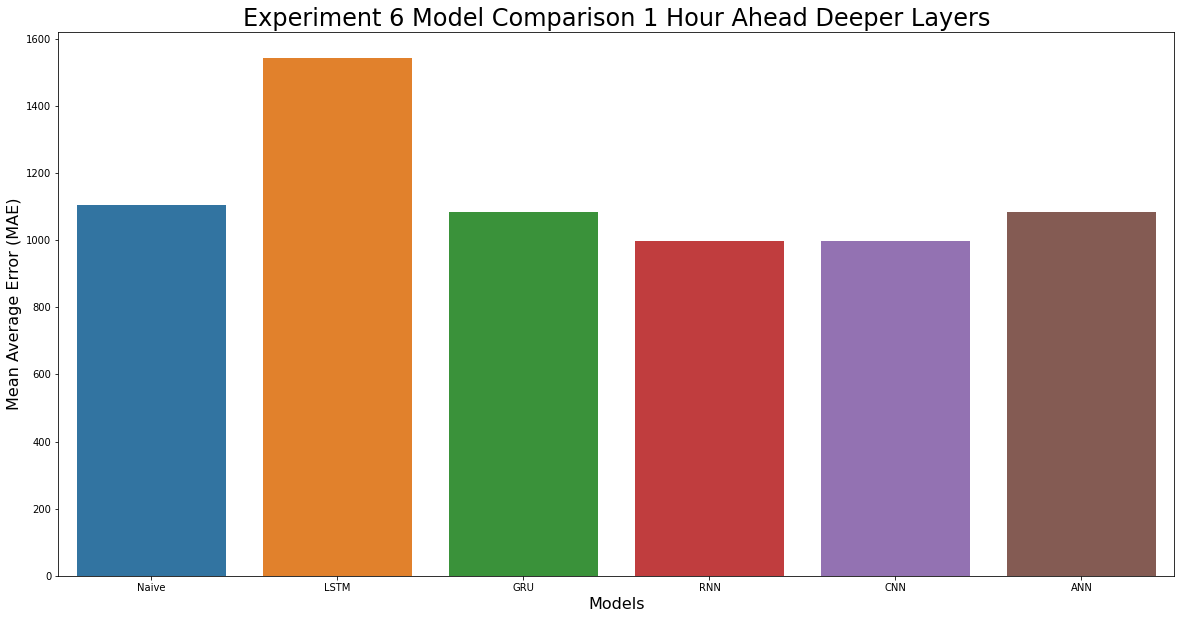

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 6 Model Comparison 1 Hour Ahead Deeper Layers", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

##**Experiment 7 - `Effective GWAP` + lagged**



In [46]:
ex7_df = df_copy.drop(df_copy.columns[1:10], axis=1)
ex7_df

Effective GWAP  lag_24_hours  lag_168_hours  \
Date_Interval                                                      
2015-01-23 00:00:00     1849.604375   4038.461339    3008.675689   
2015-01-23 01:00:00     1882.363158   3506.938357    1643.060137   
2015-01-23 02:00:00     1886.543140   3865.155003    1817.127920   
2015-01-23 03:00:00     1888.939469   3555.473270    2841.669516   
2015-01-23 04:00:00     4000.262110   3500.074604    2885.965633   
...                             ...           ...            ...   
2021-06-25 19:00:00     4582.463868  19126.570000   21446.290000   
2021-06-25 20:00:00    13468.269470  32390.800000   31957.030000   
2021-06-25 21:00:00     8069.676643  21516.500000   32769.440000   
2021-06-25 22:00:00     3628.883036   7862.060000   21886.270000   
2021-06-25 23:00:00     2975.500891   3424.130000   10441.410000   

                       lag_1_hour  lag_48_hours  lag_23_hours  lag_72_hours  \
Date_Interval                                                                 
2015-01-23 00:00:00   1436.897013   3994.478574   3506.938357   1852.680439   
2015-01-23 01:00:00   1849.604375   3616.561381   3865.155003   1849.559571   
2015-01-23 02:00:00   1882.363158   3909.627385   3555.473270   1892.741375   
2015-01-23 03:00:00   1886.543140   3976.082463   3500.074604   1882.103641   
2015-01-23 04:00:00   1888.939469   4104.101996   4030.370105   1899.117471   
...                           ...           ...           ...           ...   
2021-06-25 19:00:00   4578.853699   4527.210000  32390.800000   8042.210000   
2021-06-25 20:00:00   4582.463868   7986.910000  21516.500000   7672.180000   
2021-06-25 21:00:00  13468.269470   8097.570000   7862.060000   4559.260000   
2021-06-25 22:00:00   8069.676643   7615.450000   3424.130000   4531.760000   
2021-06-25 23:00:00   3628.883036   3404.990000   2983.963822   2892.190000   

                     lag_336_hours  
Date_Interval                       
2015-01-23 00:00:00    1822.506078  
2015-01-23 01:00:00    1752.397260  
2015-01-23 02:00:00    1539.379580  
2015-01-23 03:00:00    1815.911913  
2015-01-23 04:00:00    2884.785234  
...                            ...  
2021-06-25 19:00:00    2728.080000  
2021-06-25 20:00:00    2357.150000  
2021-06-25 21:00:00    2368.550000  
2021-06-25 22:00:00    2250.120000  
2021-06-25 23:00:00    2260.750000  

[56304 rows x 8 columns]

In [47]:
ex7_train_df = ex7_df[0:train_end_idx]
ex7_val_df = ex7_df[train_end_idx:val_end_idx]
ex7_test_df = ex7_df[val_end_idx:test_end_idx]

###**Forecast 1 hour ahead**

In [48]:
input_width = 24
label_width = 1
shift = 1

ex7_1hour_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex7_train_df, val_df=ex7_val_df, test_df=ex7_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex7_1hour_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 8)
(32, 1)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex7_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex7_1hour_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex7_df.shape[-1])
input_shape

(24, 8)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_lstm_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex7_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex7_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1800.7163 - val_loss: 1182.9163 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1731.9370 - val_loss: 923.4298 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1580.8749 - val_loss: 897.8735 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1483.1466 - val_loss: 784.2892 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1371.7789 - val_loss: 790.7490 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1184.4473 - val_loss: 725.0754 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1032.0073 - val_loss: 652.3165 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 35s 25ms/step - loss: 972.5469 - val_loss: 570.9870 - lr: 0.0010
Epoch 9/100
1407

In [ ]:
lstm = keras.models.load_model(path + '/models/ex7_lstm_1hour_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

999.7511

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex7_gru_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex7_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex7_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 35s 24ms/step - loss: 1150.1383 - val_loss: 630.0868 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 34s 24ms/step - loss: 939.2207 - val_loss: 871.2130 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 903.4938 - val_loss: 484.9656 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 33s 24ms/step - loss: 827.7614 - val_loss: 472.1735 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 809.6665 - val_loss: 480.4651 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 36s 25ms/step - loss: 810.7889 - val_loss: 464.1187 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 783.2075 - val_loss: 464.2566 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 34s 24ms/step - loss: 781.0729 - val_loss: 453.3762 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
gru = keras.models.load_model(path + '/models/ex7_gru_1hour_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

981.7091

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_rnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex7_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex7_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 20s 13ms/step - loss: 1028.5216 - val_loss: 501.3116 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 18s 13ms/step - loss: 812.1338 - val_loss: 459.2917 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 19s 13ms/step - loss: 789.5375 - val_loss: 470.1276 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 784.3217 - val_loss: 457.6962 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 18s 13ms/step - loss: 771.4881 - val_loss: 458.1157 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 18s 13ms/step - loss: 763.5864 - val_loss: 450.8155 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 18s 13ms/step - loss: 762.0453 - val_loss: 449.3059 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 18s 13ms/step - loss: 758.9642 - val_loss: 447.4738 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
rnn = keras.models.load_model(path + '/models/ex7_rnn_1hour_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

994.45746

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_cnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex7_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex7_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 13s 9ms/step - loss: 1197.4574 - val_loss: 674.4326 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 12s 9ms/step - loss: 970.7565 - val_loss: 590.4512 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 895.4131 - val_loss: 549.3469 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 12s 9ms/step - loss: 870.7307 - val_loss: 522.3111 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 12s 9ms/step - loss: 860.2440 - val_loss: 535.0412 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 13s 9ms/step - loss: 849.3359 - val_loss: 506.8888 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 12s 8ms/step - loss: 844.7686 - val_loss: 507.8487 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 13s 9ms/step - loss: 813.0182 - val_loss: 496.5872 - lr: 0.0010
Epoch 9/100
1407/1407 [========

In [ ]:
cnn = keras.models.load_model(path + '/models/ex7_cnn_1hour_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

978.9934

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_ann_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex7_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex7_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1040.2280 - val_loss: 490.7299 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 8s 6ms/step - loss: 834.5474 - val_loss: 468.1897 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 809.1412 - val_loss: 460.9453 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 8s 6ms/step - loss: 791.0889 - val_loss: 456.4336 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 6ms/step - loss: 785.5330 - val_loss: 451.1809 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 8s 6ms/step - loss: 774.2137 - val_loss: 455.5874 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 765.0287 - val_loss: 448.2310 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 8s 5ms/step - loss: 771.0428 - val_loss: 451.0363 - lr: 0.0010
Epoch 9/100
1407/1407 [================

In [ ]:
ann = keras.models.load_model(path + '/models/ex7_ann_1hour_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

980.84296

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive        LSTM         GRU         RNN         CNN         ANN
0  1104.352951  999.751099  981.709106  994.457458  978.993408  980.842957

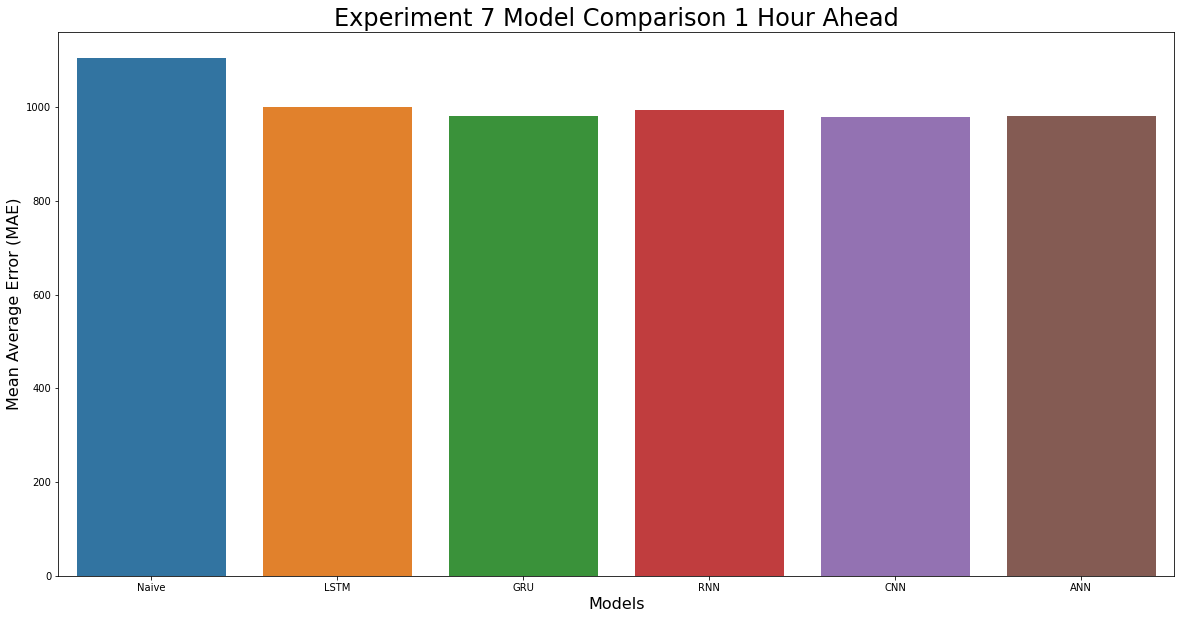

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 7 Model Comparison 1 Hour Ahead", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead**

In [ ]:
input_width = 24
label_width = 12
shift = 1

ex7_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex7_train_df, val_df=ex7_val_df, test_df=ex7_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex7_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 8)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex7_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex7_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex7_df.shape[-1])
input_shape

(24, 8)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1101.2762310150465

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_lstm_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex7_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex7_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 37s 25ms/step - loss: 1623.3815 - val_loss: 813.1245 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1367.9104 - val_loss: 872.9627 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1227.5028 - val_loss: 661.8467 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 36s 26ms/step - loss: 980.4712 - val_loss: 528.2940 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 36s 26ms/step - loss: 827.5977 - val_loss: 462.7947 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 36s 26ms/step - loss: 781.6500 - val_loss: 418.6593 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 36s 25ms/step - loss: 626.6094 - val_loss: 367.5538 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 35s 25ms/step - loss: 625.4186 - val_loss: 461.7877 - lr: 0.0010
Epoch 9/100
1407/1407

In [ ]:
lstm = keras.models.load_model(path + '/models/ex7_lstm_12hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

87.59635

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex7_gru_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex7_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 36s 25ms/step - loss: 771.8721 - val_loss: 277.7966 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 327.9185 - val_loss: 147.5722 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 233.4631 - val_loss: 118.3056 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 184.6727 - val_loss: 103.1612 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 163.7393 - val_loss: 85.4345 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 35s 25ms/step - loss: 134.0014 - val_loss: 65.8637 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 123.8023 - val_loss: 72.2685 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 35s 25ms/step - loss: 116.9168 - val_loss: 55.7633 - lr: 0.0010
Epoch 9/100
1407/1407 [=====

In [ ]:
gru = keras.models.load_model(path + '/models/ex7_gru_12hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

86.527145

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_rnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex7_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 21s 14ms/step - loss: 476.2049 - val_loss: 134.7865 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 19s 14ms/step - loss: 188.7454 - val_loss: 85.1478 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 19s 14ms/step - loss: 153.7959 - val_loss: 85.7804 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 20s 15ms/step - loss: 136.2045 - val_loss: 72.6060 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 19s 14ms/step - loss: 129.3583 - val_loss: 68.9280 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 124.9337 - val_loss: 65.2477 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 20s 14ms/step - loss: 116.9594 - val_loss: 59.0861 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 19s 14ms/step - loss: 120.4055 - val_loss: 60.3980 - lr: 0.0010
Epoch 9/100
1407/1407 [========

In [ ]:
rnn = keras.models.load_model(path + '/models/ex7_rnn_12hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

86.289955

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex7_cnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex7_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 13s 9ms/step - loss: 812.9677 - val_loss: 247.6871 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 338.6120 - val_loss: 159.5806 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 274.8512 - val_loss: 129.3290 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 13s 9ms/step - loss: 241.2749 - val_loss: 127.1072 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 222.6408 - val_loss: 117.4442 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 13s 9ms/step - loss: 209.1900 - val_loss: 115.7154 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 191.5746 - val_loss: 112.4635 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 13s 9ms/step - loss: 190.3699 - val_loss: 113.0758 - lr: 0.0010
Epoch 9/100
1407/1407 [=========

In [ ]:
cnn = keras.models.load_model(path + '/models/ex7_cnn_12hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

86.62029

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_ann_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex7_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 10s 7ms/step - loss: 492.7639 - val_loss: 129.3453 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 208.6574 - val_loss: 105.7738 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 9s 7ms/step - loss: 169.3973 - val_loss: 78.1140 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 150.8239 - val_loss: 77.0906 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 9s 7ms/step - loss: 135.9284 - val_loss: 81.3317 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 139.5071 - val_loss: 67.5157 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 9s 6ms/step - loss: 140.4992 - val_loss: 62.6664 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 9s 7ms/step - loss: 130.4691 - val_loss: 52.1507 - lr: 0.0010
Epoch 9/100
1407/1407 [====================

In [ ]:
ann = keras.models.load_model(path + '/models/ex7_ann_12hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

85.44793

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive       LSTM        GRU        RNN        CNN        ANN
0  1101.276231  87.596352  86.527145  86.289955  86.620293  85.447929

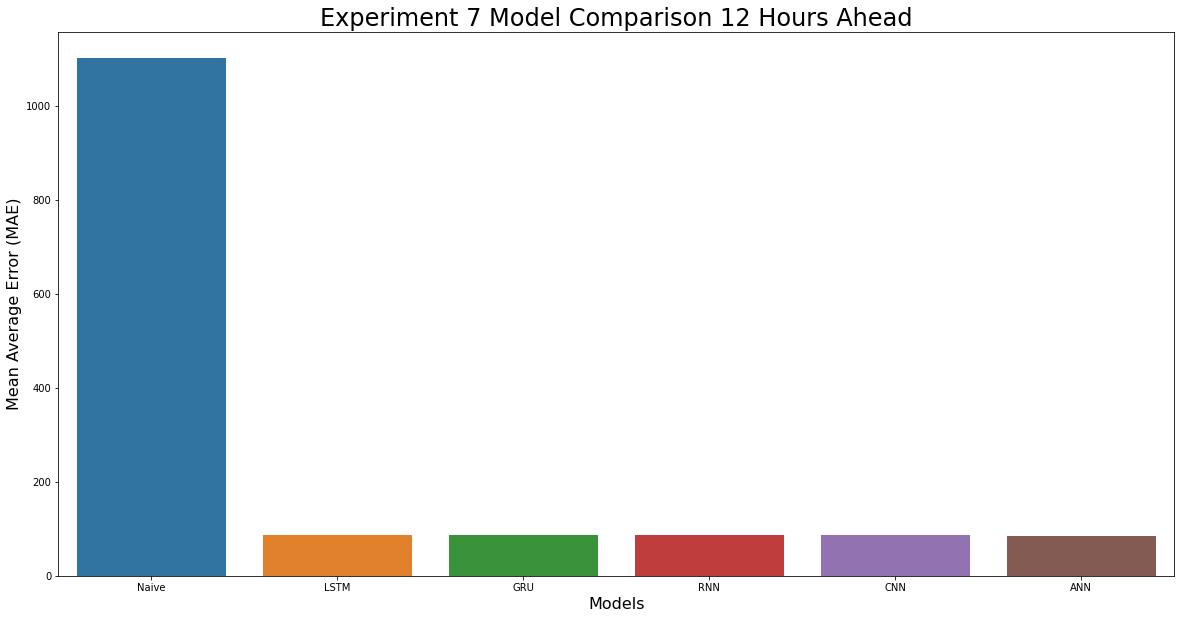

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 7 Model Comparison 12 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead 12 hour shift**

In [ ]:
input_width = 24
label_width = 12
shift = 12

ex7_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex7_train_df, val_df=ex7_val_df, test_df=ex7_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex7_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 8)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex7_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex7_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex7_df.shape[-1])
input_shape

(24, 8)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

2667.674529034868

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_lstm_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex7_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex7_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
118/118 [==============================] - 5s 30ms/step - loss: 1971.5068 - val_loss: 1239.2008 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 3s 29ms/step - loss: 1733.7319 - val_loss: 1107.0736 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 3s 29ms/step - loss: 1626.8081 - val_loss: 1233.5786 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 3s 28ms/step - loss: 1706.6665 - val_loss: 1163.0892 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 4s 31ms/step - loss: 1550.3922 - val_loss: 1053.2983 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 3s 29ms/step - loss: 1404.3011 - val_loss: 970.6903 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 3s 29ms/step - loss: 1400.7321 - val_loss: 1059.5090 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 3s 29ms/step - loss: 1445.0610 - val_loss: 1087.2438 - lr: 0.0010
Epoch 9/100
118/118 [============

In [ ]:
lstm = keras.models.load_model(path + '/models/ex7_lstm_12hours_ahead_12hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1938.4666

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex7_gru_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex7_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
118/118 [==============================] - 5s 29ms/step - loss: 1463.4346 - val_loss: 926.0547 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 3s 27ms/step - loss: 1207.4102 - val_loss: 865.3564 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 3s 28ms/step - loss: 1136.8103 - val_loss: 907.7074 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 3s 28ms/step - loss: 1132.9402 - val_loss: 898.5731 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 4s 30ms/step - loss: 1135.1539 - val_loss: 845.7388 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 3s 27ms/step - loss: 1117.8109 - val_loss: 842.7424 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 3s 25ms/step - loss: 1091.6010 - val_loss: 828.0646 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 3s 27ms/step - loss: 1066.5303 - val_loss: 859.0905 - lr: 0.0010
Epoch 9/100
118/118 [===================

In [ ]:
gru = keras.models.load_model(path + '/models/ex7_gru_12hours_ahead_12hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1783.3586

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_rnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex7_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 3s 17ms/step - loss: 1410.3170 - val_loss: 876.9528 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 2s 16ms/step - loss: 1144.0638 - val_loss: 844.7497 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 2s 20ms/step - loss: 1073.3400 - val_loss: 847.8864 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 3s 24ms/step - loss: 1042.6772 - val_loss: 835.1472 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 2s 14ms/step - loss: 1011.7729 - val_loss: 841.1539 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 2s 15ms/step - loss: 990.8837 - val_loss: 857.3105 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 2s 16ms/step - loss: 969.3650 - val_loss: 848.2910 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 2s 16ms/step - loss: 943.9030 - val_loss: 861.1782 - lr: 8.0000e-04
Epoch 9/100
118/118 [==================

In [ ]:
rnn = keras.models.load_model(path + '/models/ex7_rnn_12hours_ahead_12hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1986.4519

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex7_cnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex7_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 2s 11ms/step - loss: 1359.5050 - val_loss: 936.6653 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 11ms/step - loss: 1207.4193 - val_loss: 855.8158 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 10ms/step - loss: 1121.9858 - val_loss: 817.3657 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 11ms/step - loss: 1079.8246 - val_loss: 826.7754 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 11ms/step - loss: 1051.7672 - val_loss: 827.3199 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 11ms/step - loss: 1029.4888 - val_loss: 838.9051 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 10ms/step - loss: 1010.7060 - val_loss: 836.6911 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 1s 10ms/step - loss: 1005.5278 - val_loss: 836.8384 - lr: 8.0000e-04
Epoch 9/100
118/118 [===========

In [ ]:
cnn = keras.models.load_model(path + '/models/ex7_cnn_12hours_ahead_12hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1873.6895

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_ann_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex7_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
118/118 [==============================] - 1s 9ms/step - loss: 1452.6161 - val_loss: 909.4563 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 8ms/step - loss: 1179.4021 - val_loss: 861.0620 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 9ms/step - loss: 1118.7476 - val_loss: 843.3673 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 9ms/step - loss: 1052.7289 - val_loss: 837.9848 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 9ms/step - loss: 1022.4393 - val_loss: 855.8797 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 8ms/step - loss: 1008.8030 - val_loss: 846.5651 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 8ms/step - loss: 997.3657 - val_loss: 857.4796 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 1s 8ms/step - loss: 985.0332 - val_loss: 902.0215 - lr: 8.0000e-04
Epoch 9/100
118/118 [=========================

In [ ]:
ann = keras.models.load_model(path + '/models/ex7_ann_12hours_ahead_12hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1757.4749

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  2667.674529  1938.466553  1783.358643  1986.451904  1873.689453   

           ANN  
0  1757.474854

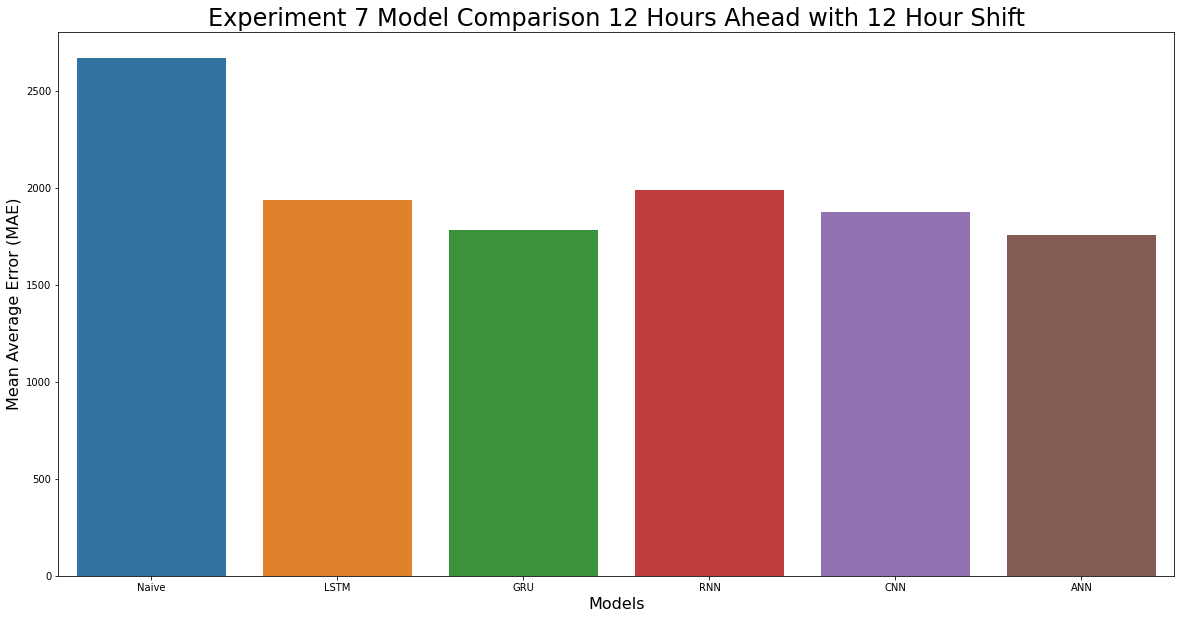

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 7 Model Comparison 12 Hours Ahead with 12 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead**

In [ ]:
input_width = 24
label_width = 24
shift = 1

ex7_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex7_train_df, val_df=ex7_val_df, test_df=ex7_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex7_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 8)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex7_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex7_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex7_df.shape[-1])
input_shape

(24, 8)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1098.3518162532384

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_lstm_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex7_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex7_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 39s 26ms/step - loss: 1636.1873 - val_loss: 683.1541 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1038.3983 - val_loss: 761.7299 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 38s 27ms/step - loss: 857.4932 - val_loss: 443.6540 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 36s 26ms/step - loss: 653.9533 - val_loss: 279.2206 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 38s 27ms/step - loss: 344.5997 - val_loss: 170.7751 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 38s 27ms/step - loss: 259.6768 - val_loss: 131.8237 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 37s 26ms/step - loss: 215.3365 - val_loss: 127.7102 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 38s 27ms/step - loss: 169.9318 - val_loss: 89.3658 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
lstm = keras.models.load_model(path + '/models/ex7_lstm_24hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

46.265297

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_gru_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex7_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 37s 25ms/step - loss: 636.6060 - val_loss: 226.0153 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 36s 26ms/step - loss: 259.3754 - val_loss: 123.5195 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 35s 25ms/step - loss: 161.9447 - val_loss: 96.9352 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 37s 26ms/step - loss: 139.5582 - val_loss: 75.9010 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 35s 25ms/step - loss: 113.9598 - val_loss: 66.4168 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 36s 25ms/step - loss: 99.7243 - val_loss: 56.8072 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 35s 25ms/step - loss: 97.8924 - val_loss: 54.7791 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 37s 26ms/step - loss: 81.1460 - val_loss: 49.8345 - lr: 0.0010
Epoch 9/100
1407/1407 [==========

In [ ]:
gru = keras.models.load_model(path + '/models/ex7_gru_24hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

53.254578

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_rnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex7_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 21s 14ms/step - loss: 435.0390 - val_loss: 119.3027 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 21s 15ms/step - loss: 159.4597 - val_loss: 75.7369 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 19s 14ms/step - loss: 120.5485 - val_loss: 59.1119 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 20s 14ms/step - loss: 100.0405 - val_loss: 56.7268 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 20s 14ms/step - loss: 94.9773 - val_loss: 48.8595 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 91.7971 - val_loss: 49.3223 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 19s 14ms/step - loss: 85.9602 - val_loss: 50.0344 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 20s 14ms/step - loss: 84.7844 - val_loss: 43.4851 - lr: 0.0010
Epoch 9/100
1407/1407 [============

In [ ]:
rnn = keras.models.load_model(path + '/models/ex7_rnn_24hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

43.585938

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_cnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex7_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 13s 9ms/step - loss: 563.6817 - val_loss: 164.1252 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 13s 10ms/step - loss: 230.4566 - val_loss: 116.5288 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 186.8175 - val_loss: 128.9553 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 13s 9ms/step - loss: 186.1704 - val_loss: 89.4947 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 171.3906 - val_loss: 104.9276 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 159.7134 - val_loss: 90.9541 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 155.6650 - val_loss: 84.7683 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 14s 10ms/step - loss: 148.3292 - val_loss: 78.2557 - lr: 0.0010
Epoch 9/100
1407/1407 [========

In [ ]:
cnn = keras.models.load_model(path + '/models/ex7_cnn_24hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

47.971207

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_ann_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex7_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 10s 7ms/step - loss: 464.5720 - val_loss: 127.5539 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 9s 7ms/step - loss: 157.8116 - val_loss: 71.2423 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 121.4388 - val_loss: 73.9751 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 104.1875 - val_loss: 48.5285 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 9s 7ms/step - loss: 97.0431 - val_loss: 44.0048 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 105.6426 - val_loss: 55.7347 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 96.0988 - val_loss: 37.9179 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 10s 7ms/step - loss: 95.5111 - val_loss: 44.0481 - lr: 0.0010
Epoch 9/100
1407/1407 [=====================

In [ ]:
ann = keras.models.load_model(path + '/models/ex7_ann_24hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

58.36801

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive       LSTM        GRU        RNN        CNN        ANN
0  1098.351816  46.265297  53.254578  43.585938  47.971207  58.368011

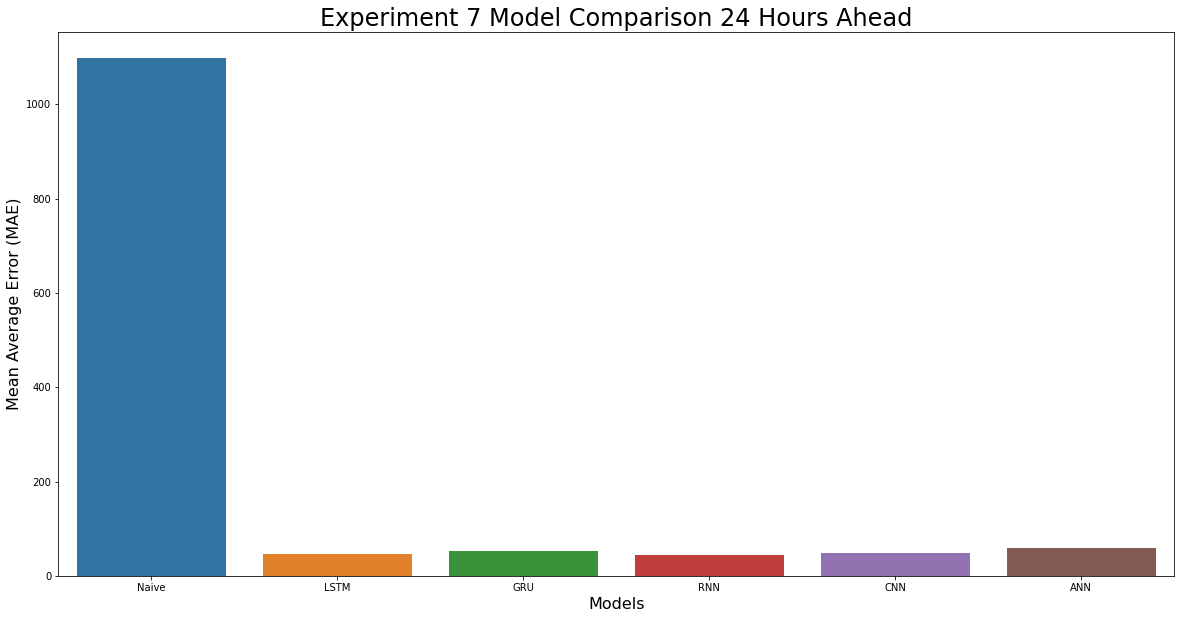

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 7 Model Comparison 24 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead 24 hour shift**

In [ ]:
input_width = 24
label_width = 24
shift = 24

ex7_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex7_train_df, val_df=ex7_val_df, test_df=ex7_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex7_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 8)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex7_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex7_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex7_df.shape[-1])
input_shape

(24, 8)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1722.1445946783263

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_lstm_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex7_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex7_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
59/59 [==============================] - 3s 32ms/step - loss: 1976.6342 - val_loss: 1238.1221 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 30ms/step - loss: 1599.4012 - val_loss: 1135.5697 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 29ms/step - loss: 1521.0305 - val_loss: 1297.3484 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 29ms/step - loss: 1836.6593 - val_loss: 1474.8058 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 29ms/step - loss: 1657.7236 - val_loss: 1188.8673 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 30ms/step - loss: 1448.2679 - val_loss: 1089.3168 - lr: 8.0000e-04
Epoch 7/100
59/59 [==============================] - 2s 30ms/step - loss: 1436.4583 - val_loss: 1135.0024 - lr: 8.0000e-04
Epoch 8/100
59/59 [==============================] - 2s 30ms/step - loss: 1407.3120 - val_loss: 1117.2848 - lr: 8.0000e-04
Epoch 9/100
59/59 [=================

In [ ]:
lstm = keras.models.load_model(path + '/models/ex7_lstm_24hours_ahead_24hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

2568.0605

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex7_gru_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex7_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
59/59 [==============================] - 3s 31ms/step - loss: 1498.1803 - val_loss: 941.8854 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 28ms/step - loss: 1228.1429 - val_loss: 959.1589 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 28ms/step - loss: 1188.1410 - val_loss: 966.0508 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 26ms/step - loss: 1160.0608 - val_loss: 962.3939 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 27ms/step - loss: 1136.4250 - val_loss: 980.1793 - lr: 8.0000e-04
Epoch 6/100
59/59 [==============================] - 2s 28ms/step - loss: 1118.2136 - val_loss: 981.9212 - lr: 8.0000e-04
Epoch 7/100
59/59 [==============================] - 2s 29ms/step - loss: 1116.8560 - val_loss: 976.7963 - lr: 8.0000e-04
Epoch 8/100
59/59 [==============================] - 2s 27ms/step - loss: 1100.8673 - val_loss: 965.6141 - lr: 6.4000e-04
Epoch 9/100
59/59 [=====================

In [ ]:
gru = keras.models.load_model(path + '/models/ex7_gru_24hours_ahead_24hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

2418.0732

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_rnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex7_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 2s 20ms/step - loss: 1557.0760 - val_loss: 968.0184 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 16ms/step - loss: 1246.8120 - val_loss: 979.6638 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 18ms/step - loss: 1172.5638 - val_loss: 966.9918 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 16ms/step - loss: 1133.6896 - val_loss: 961.1598 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 17ms/step - loss: 1102.8478 - val_loss: 947.4866 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 17ms/step - loss: 1082.5415 - val_loss: 957.1887 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 18ms/step - loss: 1066.3467 - val_loss: 1015.4144 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 19ms/step - loss: 1050.3000 - val_loss: 1044.5311 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1

In [ ]:
rnn = keras.models.load_model(path + '/models/ex7_rnn_24hours_ahead_24hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

2484.4485

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex7_cnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex7_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 13ms/step - loss: 1510.0560 - val_loss: 1263.8373 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 13ms/step - loss: 1248.4236 - val_loss: 1120.0045 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 12ms/step - loss: 1203.5795 - val_loss: 1119.6748 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 12ms/step - loss: 1179.1877 - val_loss: 1112.6113 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 12ms/step - loss: 1166.7291 - val_loss: 1160.1796 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 12ms/step - loss: 1152.5100 - val_loss: 1119.0062 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 11ms/step - loss: 1139.9321 - val_loss: 1179.0884 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 11ms/step - loss: 1137.6836 - val_loss: 1214.9026 - lr: 8.0000e-04
Epoch 9/100
59/59 [=========================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex7_cnn_24hours_ahead_24hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

2856.6836

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_ann_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex7_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex7_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 11ms/step - loss: 1516.9635 - val_loss: 1035.8534 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 10ms/step - loss: 1245.6488 - val_loss: 1005.5520 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 10ms/step - loss: 1173.1055 - val_loss: 967.3431 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 9ms/step - loss: 1161.3206 - val_loss: 994.6571 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 9ms/step - loss: 1120.5405 - val_loss: 985.1591 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 10ms/step - loss: 1098.6898 - val_loss: 982.9124 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 9ms/step - loss: 1078.3790 - val_loss: 1007.3519 - lr: 8.0000e-04
Epoch 8/100
59/59 [==============================] - 1s 10ms/step - loss: 1069.6960 - val_loss: 998.0227 - lr: 8.0000e-04
Epoch 9/100
59/59 [=============================

In [ ]:
ann = keras.models.load_model(path + '/models/ex7_ann_24hours_ahead_24hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

2519.2944

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  1722.144595  2568.060547  2418.073242  2484.448486  2856.683594   

           ANN  
0  2519.294434

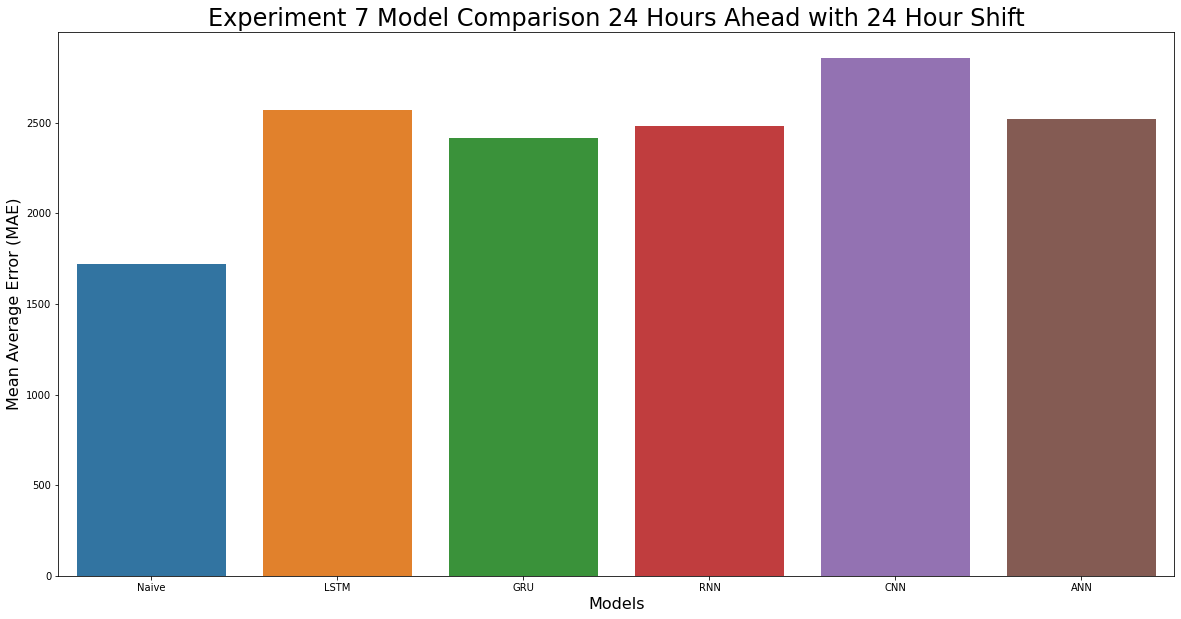

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 7 Model Comparison 24 Hours Ahead with 24 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Deeper Layers (1 hour ahead)** 

In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex7_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex7_1hour_ahead.test], axis=0)

input_shape = (input_width, ex7_df.shape[-1])
input_shape

(24, 8)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_lstm_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex7_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex7_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 98s 67ms/step - loss: 3898.9834 - val_loss: 900.9561 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 92s 65ms/step - loss: 1710.4757 - val_loss: 933.1508 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 93s 66ms/step - loss: 1455.9503 - val_loss: 859.5754 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 93s 66ms/step - loss: 1562.7208 - val_loss: 844.9163 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 93s 66ms/step - loss: 1544.8901 - val_loss: 892.9385 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 93s 66ms/step - loss: 1819.4227 - val_loss: 897.9184 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 92s 66ms/step - loss: 1408.7668 - val_loss: 1114.4106 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 93s 66ms/step - loss: 1275.5930 - val_loss: 764.3577 - lr: 8.0000e-04
Epoch 9/100

In [ ]:
lstm = keras.models.load_model(path + '/models/ex7_lstm_3layers.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1594.0223

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex7_gru_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex7_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex7_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 92s 62ms/step - loss: 1285.8712 - val_loss: 777.1160 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 87s 62ms/step - loss: 1086.1686 - val_loss: 597.4662 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 87s 62ms/step - loss: 930.1938 - val_loss: 513.2207 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 87s 62ms/step - loss: 848.6259 - val_loss: 523.3775 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 87s 62ms/step - loss: 821.3502 - val_loss: 466.3223 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 85s 61ms/step - loss: 817.5436 - val_loss: 482.2080 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 87s 62ms/step - loss: 799.0162 - val_loss: 464.3492 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 86s 61ms/step - loss: 816.5726 - val_loss: 470.7057 - lr: 0.0010
Epoch 9/100
1407/1407 

In [ ]:
gru = keras.models.load_model(path + '/models/ex7_gru_3layers.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

968.2685

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_rnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex7_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex7_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 41s 27ms/step - loss: 970.7710 - val_loss: 466.6911 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 39s 28ms/step - loss: 804.0733 - val_loss: 463.0245 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 39s 28ms/step - loss: 782.6991 - val_loss: 460.0255 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 40s 28ms/step - loss: 765.7402 - val_loss: 454.2572 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 39s 27ms/step - loss: 760.5509 - val_loss: 453.4252 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 39s 28ms/step - loss: 753.4585 - val_loss: 452.2997 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 40s 28ms/step - loss: 750.8794 - val_loss: 448.1800 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 39s 28ms/step - loss: 744.0466 - val_loss: 461.9600 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
rnn = keras.models.load_model(path + '/models/ex7_rnn_3layers.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1002.8284

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_cnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex7_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex7_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 125s 89ms/step - loss: 1336.5139 - val_loss: 722.0001 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 126s 89ms/step - loss: 1160.8051 - val_loss: 634.0421 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 125s 89ms/step - loss: 989.1025 - val_loss: 624.2125 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 126s 89ms/step - loss: 898.6278 - val_loss: 557.1772 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 128s 91ms/step - loss: 865.0156 - val_loss: 522.2907 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 128s 91ms/step - loss: 829.8159 - val_loss: 499.4091 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 126s 89ms/step - loss: 814.7793 - val_loss: 495.2391 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 126s 90ms/step - loss: 801.2269 - val_loss: 502.0788 - lr: 0.0010
Epoch 9/100
14

In [ ]:
cnn = keras.models.load_model(path + '/models/ex7_cnn_3layers.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1021.45123

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex7_ann_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex7_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex7_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 13s 9ms/step - loss: 936.4414 - val_loss: 470.3573 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 811.5016 - val_loss: 457.3991 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 790.6263 - val_loss: 458.5214 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 782.5840 - val_loss: 458.2845 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 770.9737 - val_loss: 450.4540 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 765.5604 - val_loss: 469.7918 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 760.4952 - val_loss: 457.4024 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 14s 10ms/step - loss: 761.1838 - val_loss: 448.7928 - lr: 0.0010
Epoch 9/100
1407/1407 [=====

In [ ]:
ann = keras.models.load_model(path + '/models/ex7_ann_3layers.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

982.8229

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM         GRU         RNN          CNN         ANN
0  1104.352951  1594.022339  968.268494  1002.82843  1021.451233  982.822876

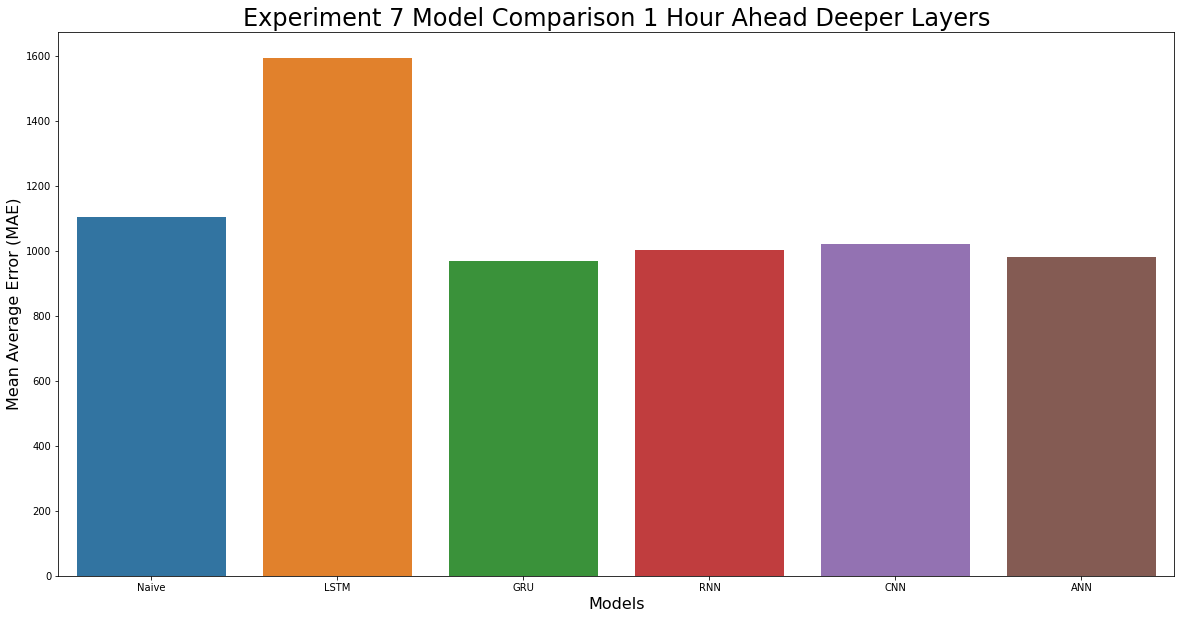

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 7 Model Comparison 1 Hour Ahead Deeper Layers", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

##**Experiment 8 - `Effective GWAP` + datetime + lagged**



In [55]:
ex8_df = df_copy.drop('Rolling Average', axis=1)
ex8_df

Effective GWAP  month  weekday  hour  morning  mid day  \
Date_Interval                                                                 
2015-01-23 00:00:00     1849.604375      1        4     0      1.0      0.0   
2015-01-23 01:00:00     1882.363158      1        4     1      1.0      0.0   
2015-01-23 02:00:00     1886.543140      1        4     2      1.0      0.0   
2015-01-23 03:00:00     1888.939469      1        4     3      1.0      0.0   
2015-01-23 04:00:00     4000.262110      1        4     4      1.0      0.0   
...                             ...    ...      ...   ...      ...      ...   
2021-06-25 19:00:00     4582.463868      6        4    19      0.0      0.0   
2021-06-25 20:00:00    13468.269470      6        4    20      0.0      0.0   
2021-06-25 21:00:00     8069.676643      6        4    21      0.0      0.0   
2021-06-25 22:00:00     3628.883036      6        4    22      0.0      0.0   
2021-06-25 23:00:00     2975.500891      6        4    23      0.0      0.0   

                     evening  weekend  season  lag_24_hours  lag_168_hours  \
Date_Interval                                                                
2015-01-23 00:00:00      0.0      0.0     0.0   4038.461339    3008.675689   
2015-01-23 01:00:00      0.0      0.0     0.0   3506.938357    1643.060137   
2015-01-23 02:00:00      0.0      0.0     0.0   3865.155003    1817.127920   
2015-01-23 03:00:00      0.0      0.0     0.0   3555.473270    2841.669516   
2015-01-23 04:00:00      0.0      0.0     0.0   3500.074604    2885.965633   
...                      ...      ...     ...           ...            ...   
2021-06-25 19:00:00      1.0      0.0     1.0  19126.570000   21446.290000   
2021-06-25 20:00:00      1.0      0.0     1.0  32390.800000   31957.030000   
2021-06-25 21:00:00      1.0      0.0     1.0  21516.500000   32769.440000   
2021-06-25 22:00:00      1.0      0.0     1.0   7862.060000   21886.270000   
2021-06-25 23:00:00      1.0      0.0     1.0   3424.130000   10441.410000   

                       lag_1_hour  lag_48_hours  lag_23_hours  lag_72_hours  \
Date_Interval                                                                 
2015-01-23 00:00:00   1436.897013   3994.478574   3506.938357   1852.680439   
2015-01-23 01:00:00   1849.604375   3616.561381   3865.155003   1849.559571   
2015-01-23 02:00:00   1882.363158   3909.627385   3555.473270   1892.741375   
2015-01-23 03:00:00   1886.543140   3976.082463   3500.074604   1882.103641   
2015-01-23 04:00:00   1888.939469   4104.101996   4030.370105   1899.117471   
...                           ...           ...           ...           ...   
2021-06-25 19:00:00   4578.853699   4527.210000  32390.800000   8042.210000   
2021-06-25 20:00:00   4582.463868   7986.910000  21516.500000   7672.180000   
2021-06-25 21:00:00  13468.269470   8097.570000   7862.060000   4559.260000   
2021-06-25 22:00:00   8069.676643   7615.450000   3424.130000   4531.760000   
2021-06-25 23:00:00   3628.883036   3404.990000   2983.963822   2892.190000   

                     lag_336_hours  
Date_Interval                       
2015-01-23 00:00:00    1822.506078  
2015-01-23 01:00:00    1752.397260  
2015-01-23 02:00:00    1539.379580  
2015-01-23 03:00:00    1815.911913  
2015-01-23 04:00:00    2884.785234  
...                            ...  
2021-06-25 19:00:00    2728.080000  
2021-06-25 20:00:00    2357.150000  
2021-06-25 21:00:00    2368.550000  
2021-06-25 22:00:00    2250.120000  
2021-06-25 23:00:00    2260.750000  

[56304 rows x 16 columns]

In [56]:
ex8_train_df = ex8_df[0:train_end_idx]
ex8_val_df = ex8_df[train_end_idx:val_end_idx]
ex8_test_df = ex8_df[val_end_idx:test_end_idx]

###**Forecast 1 hour ahead**

In [ ]:
input_width = 24
label_width = 1
shift = 1

ex8_1hour_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex8_train_df, val_df=ex8_val_df, test_df=ex8_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex8_1hour_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 16)
(32, 1)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex8_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex8_1hour_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex8_df.shape[-1])
input_shape

(24, 16)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_lstm_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex8_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex8_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 39s 26ms/step - loss: 1516.2592 - val_loss: 869.9246 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1772.5957 - val_loss: 813.6545 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1239.4449 - val_loss: 842.5789 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1165.4205 - val_loss: 670.4332 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1106.8629 - val_loss: 670.9771 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1060.4440 - val_loss: 640.1670 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 36s 26ms/step - loss: 1042.0363 - val_loss: 595.1791 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1476.1952 - val_loss: 1044.6387 - lr: 0.0010
Epoch 9/100
140

In [ ]:
lstm = keras.models.load_model(path + '/models/ex8_lstm_1hour_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1026.3356

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex8_gru_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex8_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex8_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 35s 24ms/step - loss: 1178.6216 - val_loss: 667.7969 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 34s 24ms/step - loss: 950.8466 - val_loss: 582.9787 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 33s 24ms/step - loss: 893.9785 - val_loss: 475.0208 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 32s 23ms/step - loss: 831.6506 - val_loss: 506.8283 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 32s 23ms/step - loss: 846.7198 - val_loss: 481.9107 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 33s 24ms/step - loss: 801.4983 - val_loss: 462.7852 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 803.0926 - val_loss: 464.0480 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 33s 23ms/step - loss: 783.3291 - val_loss: 484.3953 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
gru = keras.models.load_model(path + '/models/ex8_gru_1hour_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

979.1614

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_rnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex8_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex8_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 19s 13ms/step - loss: 1031.8464 - val_loss: 475.5924 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 18s 13ms/step - loss: 818.2911 - val_loss: 461.4195 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 791.8620 - val_loss: 462.5649 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 782.1545 - val_loss: 463.4041 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 17s 12ms/step - loss: 772.4224 - val_loss: 459.1192 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 19s 13ms/step - loss: 761.2668 - val_loss: 453.8890 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 18s 12ms/step - loss: 757.7947 - val_loss: 447.1898 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 18s 13ms/step - loss: 754.6750 - val_loss: 445.8889 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
rnn = keras.models.load_model(path + '/models/ex8_rnn_1hour_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1001.36115

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_cnn_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex8_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex8_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1217.4087 - val_loss: 645.6398 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 15s 10ms/step - loss: 974.9874 - val_loss: 562.3142 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 894.3382 - val_loss: 532.6163 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 860.1057 - val_loss: 507.7729 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 857.5478 - val_loss: 502.7218 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 15s 11ms/step - loss: 831.8611 - val_loss: 485.6901 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 15s 10ms/step - loss: 820.7636 - val_loss: 491.4955 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 14s 10ms/step - loss: 819.5599 - val_loss: 489.7677 - lr: 0.0010
Epoch 9/100
1407/1407 [

In [ ]:
cnn = keras.models.load_model(path + '/models/ex8_cnn_1hour_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

986.27277

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_ann_1hour_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex8_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex8_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1023.6559 - val_loss: 486.1526 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 8s 5ms/step - loss: 841.6396 - val_loss: 474.9788 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 808.1111 - val_loss: 473.4616 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 799.5167 - val_loss: 462.5456 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 8s 5ms/step - loss: 786.4567 - val_loss: 457.9724 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 779.0018 - val_loss: 450.7028 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 9s 6ms/step - loss: 769.3779 - val_loss: 450.0385 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 9s 6ms/step - loss: 770.1945 - val_loss: 451.3061 - lr: 0.0010
Epoch 9/100
1407/1407 [================

In [ ]:
ann = keras.models.load_model(path + '/models/ex8_ann_1hour_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

982.50555

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM         GRU          RNN         CNN         ANN
0  1104.352951  1026.335571  979.161377  1001.361145  986.272766  982.505554

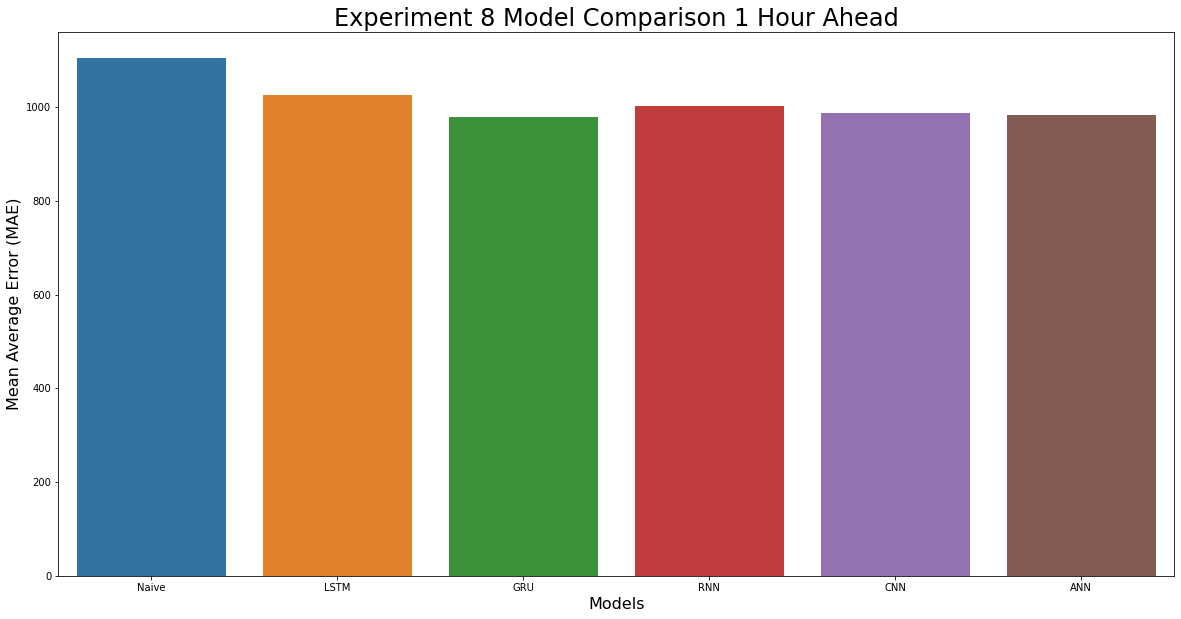

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 8 Model Comparison 1 Hour Ahead", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead**

In [57]:
input_width = 24
label_width = 12
shift = 1

ex8_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex8_train_df, val_df=ex8_val_df, test_df=ex8_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [58]:
for samples, labels in ex8_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 16)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex8_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex8_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex8_df.shape[-1])
input_shape

(24, 16)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1101.2762310150465

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_lstm_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex8_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex8_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 37s 25ms/step - loss: 1556.8121 - val_loss: 981.2262 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1220.4506 - val_loss: 726.6141 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 778.4994 - val_loss: 443.0521 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 37s 26ms/step - loss: 711.0059 - val_loss: 370.9444 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 36s 25ms/step - loss: 543.5969 - val_loss: 298.3072 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 36s 25ms/step - loss: 406.5576 - val_loss: 207.4980 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 36s 26ms/step - loss: 267.2991 - val_loss: 172.1118 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 37s 26ms/step - loss: 206.3447 - val_loss: 100.5160 - lr: 0.0010
Epoch 9/100
1407/1407 

In [ ]:
lstm = keras.models.load_model(path + '/models/ex8_lstm_12hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

88.53085

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex8_gru_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex8_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 35s 24ms/step - loss: 797.7229 - val_loss: 284.2431 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 33s 23ms/step - loss: 369.5016 - val_loss: 237.3514 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 281.9043 - val_loss: 142.2458 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 33s 23ms/step - loss: 222.5611 - val_loss: 144.2586 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 215.0555 - val_loss: 102.4970 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 32s 23ms/step - loss: 168.0095 - val_loss: 111.2719 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 162.9992 - val_loss: 90.8877 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 35s 25ms/step - loss: 148.8434 - val_loss: 79.3867 - lr: 0.0010
Epoch 9/100
1407/1407 [===

In [ ]:
gru = keras.models.load_model(path + '/models/ex8_gru_12hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

92.81706

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_rnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex8_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 19s 13ms/step - loss: 470.0385 - val_loss: 125.3267 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 20s 14ms/step - loss: 182.5794 - val_loss: 103.5362 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 19s 14ms/step - loss: 138.6687 - val_loss: 70.3225 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 19s 14ms/step - loss: 126.6775 - val_loss: 94.0084 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 18s 13ms/step - loss: 123.5160 - val_loss: 69.8127 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 112.1868 - val_loss: 60.6516 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 19s 14ms/step - loss: 111.9148 - val_loss: 65.2755 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 20s 14ms/step - loss: 113.1967 - val_loss: 64.2334 - lr: 0.0010
Epoch 9/100
1407/1407 [=======

In [ ]:
rnn = keras.models.load_model(path + '/models/ex8_rnn_12hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

83.26625

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex8_cnn_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex8_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 15s 11ms/step - loss: 763.4816 - val_loss: 214.6696 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 385.5892 - val_loss: 215.8896 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 263.2868 - val_loss: 123.2781 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 226.8393 - val_loss: 133.2206 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 215.6933 - val_loss: 98.8840 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 15s 11ms/step - loss: 199.9502 - val_loss: 143.0819 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 214.0061 - val_loss: 98.9086 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 15s 10ms/step - loss: 192.6622 - val_loss: 98.9507 - lr: 0.0010
Epoch 9/100
1407/1407 [====

In [ ]:
cnn = keras.models.load_model(path + '/models/ex8_cnn_12hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

91.74858

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_ann_12hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex8_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 454.5551 - val_loss: 131.7640 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 189.6757 - val_loss: 84.6596 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 159.7466 - val_loss: 91.7282 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 148.6344 - val_loss: 69.7102 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 9s 7ms/step - loss: 140.3329 - val_loss: 72.9841 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 138.1846 - val_loss: 65.0099 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 9s 6ms/step - loss: 148.8408 - val_loss: 71.4355 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 128.5048 - val_loss: 74.4685 - lr: 0.0010
Epoch 9/100
1407/1407 [========================

In [ ]:
ann = keras.models.load_model(path + '/models/ex8_ann_12hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

86.54945

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive       LSTM        GRU        RNN        CNN        ANN
0  1101.276231  88.530853  92.817062  83.266251  91.748581  86.549454

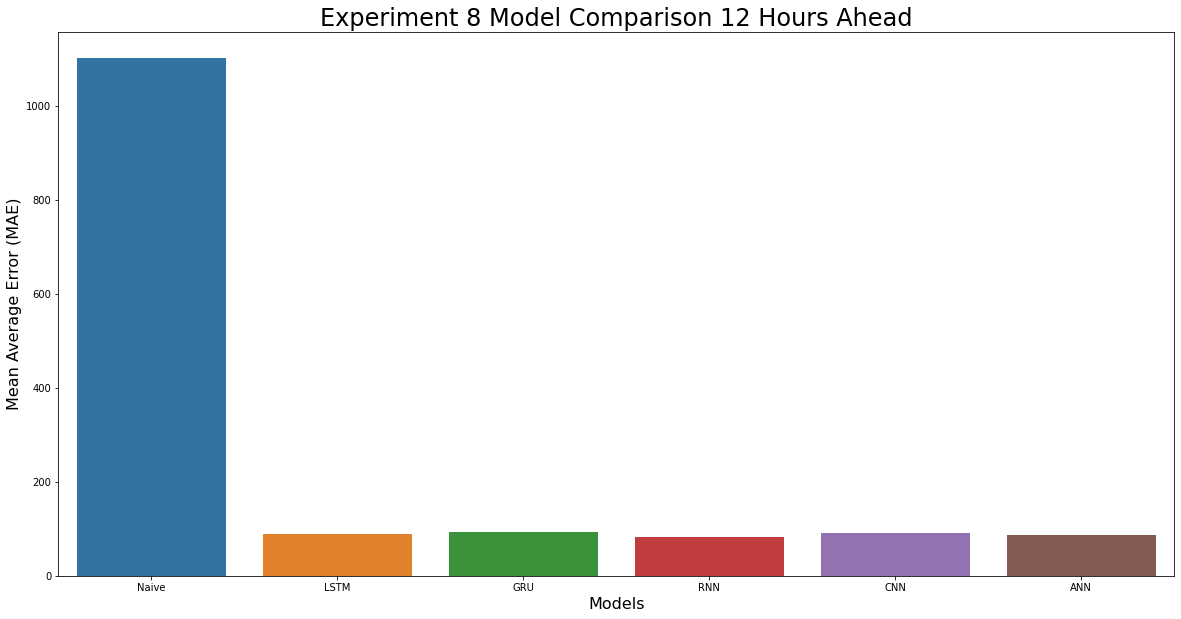

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 8 Model Comparison 12 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 12 hours ahead 12 hour shift**

In [ ]:
input_width = 24
label_width = 12
shift = 12

ex8_12hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex8_train_df, val_df=ex8_val_df, test_df=ex8_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex8_12hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 16)
(32, 12)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex8_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex8_12hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex8_df.shape[-1])
input_shape

(24, 16)

Naive

In [ ]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

2667.674529034868

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_lstm_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex8_12hours_ahead.train, epochs=epochs, 
                   validation_data=ex8_12hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
118/118 [==============================] - 5s 30ms/step - loss: 1613.3525 - val_loss: 973.4485 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 3s 28ms/step - loss: 1386.4415 - val_loss: 960.4888 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 3s 29ms/step - loss: 1344.0023 - val_loss: 992.7140 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 4s 30ms/step - loss: 1267.2100 - val_loss: 896.8483 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 4s 30ms/step - loss: 1271.8315 - val_loss: 988.9376 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 3s 29ms/step - loss: 1267.2323 - val_loss: 948.7035 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 3s 29ms/step - loss: 1258.5291 - val_loss: 933.8548 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 3s 27ms/step - loss: 1723.1793 - val_loss: 1106.3947 - lr: 8.0000e-04
Epoch 9/100
118/118 [==============

In [ ]:
lstm = keras.models.load_model(path + '/models/ex8_lstm_12hours_ahead_12hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1963.4518

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex8_gru_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex8_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
118/118 [==============================] - 5s 28ms/step - loss: 1433.2960 - val_loss: 890.8473 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 3s 26ms/step - loss: 1191.9465 - val_loss: 865.8781 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 3s 27ms/step - loss: 1150.4508 - val_loss: 830.4438 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 3s 26ms/step - loss: 1116.7988 - val_loss: 836.7386 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 3s 28ms/step - loss: 1088.9202 - val_loss: 834.9932 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 3s 27ms/step - loss: 1066.1951 - val_loss: 864.4354 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 3s 26ms/step - loss: 1052.2549 - val_loss: 888.1282 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 3s 26ms/step - loss: 1032.5277 - val_loss: 852.9124 - lr: 8.0000e-04
Epoch 9/100
118/118 [===========

In [ ]:
gru = keras.models.load_model(path + '/models/ex8_gru_12hours_ahead_12hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1804.9019

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_rnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex8_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 3s 17ms/step - loss: 1384.6809 - val_loss: 929.3942 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 2s 15ms/step - loss: 1179.3168 - val_loss: 874.6481 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 2s 16ms/step - loss: 1089.2688 - val_loss: 851.7315 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 2s 16ms/step - loss: 1030.9895 - val_loss: 858.1818 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 2s 15ms/step - loss: 1006.3488 - val_loss: 858.4266 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 2s 16ms/step - loss: 989.9382 - val_loss: 853.3727 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 2s 15ms/step - loss: 984.3506 - val_loss: 860.6263 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 2s 15ms/step - loss: 1003.1194 - val_loss: 928.9232 - lr: 8.0000e-04
Epoch 9/100
118/118 [=============

In [ ]:
rnn = keras.models.load_model(path + '/models/ex8_rnn_12hours_ahead_12hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

1832.0942

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex8_cnn_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex8_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
118/118 [==============================] - 2s 14ms/step - loss: 1347.4475 - val_loss: 993.9183 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 12ms/step - loss: 1207.4857 - val_loss: 844.6616 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 13ms/step - loss: 1142.5336 - val_loss: 823.0342 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 2s 13ms/step - loss: 1100.9399 - val_loss: 848.9892 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 2s 13ms/step - loss: 1060.5420 - val_loss: 842.2979 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 12ms/step - loss: 1032.3932 - val_loss: 832.2995 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 12ms/step - loss: 1017.1498 - val_loss: 830.6928 - lr: 8.0000e-04
Epoch 8/100
118/118 [==============================] - 1s 13ms/step - loss: 1004.7762 - val_loss: 837.5375 - lr: 8.0000e-04
Epoch 9/100
118/118 [===========

In [ ]:
cnn = keras.models.load_model(path + '/models/ex8_cnn_12hours_ahead_12hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1814.4926

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_ann_12hours_ahead_12hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex8_12hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_12hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
118/118 [==============================] - 1s 9ms/step - loss: 1422.8092 - val_loss: 962.7042 - lr: 0.0010
Epoch 2/100
118/118 [==============================] - 1s 9ms/step - loss: 1195.5562 - val_loss: 894.9250 - lr: 0.0010
Epoch 3/100
118/118 [==============================] - 1s 8ms/step - loss: 1108.7606 - val_loss: 866.3912 - lr: 0.0010
Epoch 4/100
118/118 [==============================] - 1s 9ms/step - loss: 1059.2847 - val_loss: 851.9842 - lr: 0.0010
Epoch 5/100
118/118 [==============================] - 1s 8ms/step - loss: 1038.7233 - val_loss: 862.1937 - lr: 0.0010
Epoch 6/100
118/118 [==============================] - 1s 8ms/step - loss: 1015.8793 - val_loss: 850.8348 - lr: 0.0010
Epoch 7/100
118/118 [==============================] - 1s 9ms/step - loss: 996.5733 - val_loss: 838.6478 - lr: 0.0010
Epoch 8/100
118/118 [==============================] - 1s 8ms/step - loss: 981.4191 - val_loss: 849.3282 - lr: 0.0010
Epoch 9/100
118/118 [=============================

In [ ]:
ann = keras.models.load_model(path + '/models/ex8_ann_12hours_ahead_12hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

1797.0203

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_12hours_ahead = pd.DataFrame(errors, index=[0])
maes_12hours_ahead

Naive         LSTM          GRU          RNN          CNN  \
0  2667.674529  1963.451782  1804.901855  1832.094238  1814.492554   

           ANN  
0  1797.020264

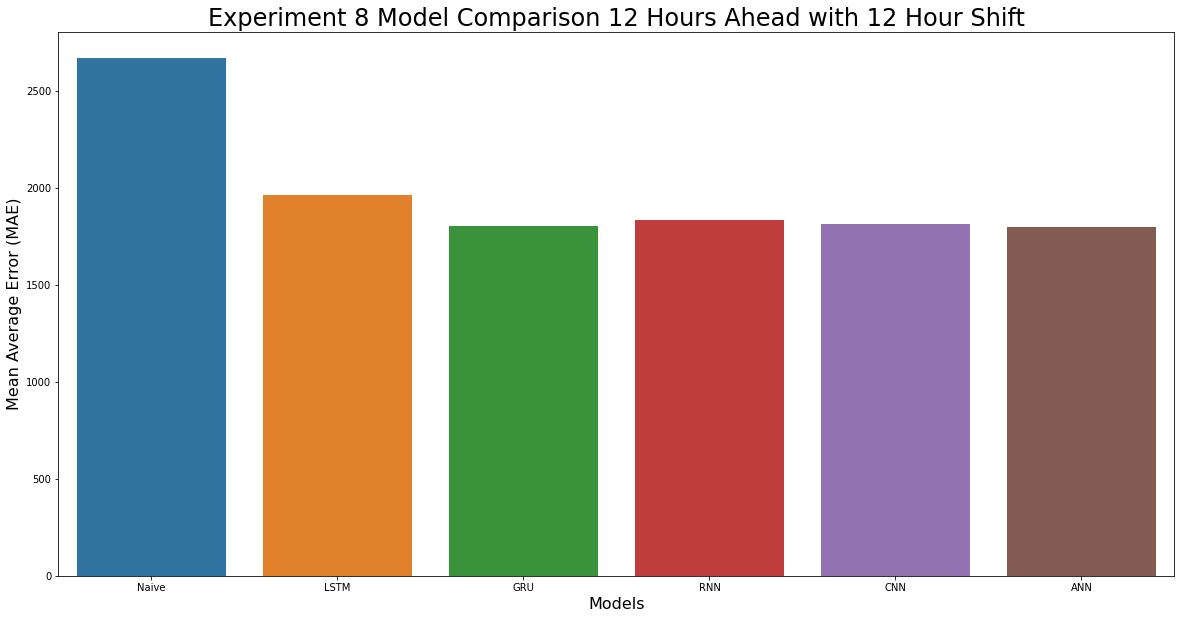

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_12hours_ahead)
plt.title("Experiment 8 Model Comparison 12 Hours Ahead with 12 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead**

In [ ]:
input_width = 24
label_width = 24
shift = 1

ex8_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex8_train_df, val_df=ex8_val_df, test_df=ex8_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex8_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 16)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex8_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex8_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex8_df.shape[-1])
input_shape

(24, 16)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1098.3518162532384

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_lstm_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex8_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex8_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1328.2576 - val_loss: 646.1769 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 33s 24ms/step - loss: 1249.8055 - val_loss: 651.1554 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1144.1455 - val_loss: 651.9200 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 940.4724 - val_loss: 646.0107 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 34s 24ms/step - loss: 717.5463 - val_loss: 316.0395 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 33s 24ms/step - loss: 418.7784 - val_loss: 195.3776 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 34s 24ms/step - loss: 317.8678 - val_loss: 179.8988 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 34s 24ms/step - loss: 290.4243 - val_loss: 156.9853 - lr: 0.0010
Epoch 9/100
1407/1407

In [ ]:
lstm = keras.models.load_model(path + '/models/ex8_lstm_24hours_ahead.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

46.587955

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_gru_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex8_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 34s 23ms/step - loss: 733.9346 - val_loss: 240.5327 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 273.4291 - val_loss: 163.4518 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 34s 24ms/step - loss: 191.7449 - val_loss: 111.5485 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 35s 25ms/step - loss: 145.2662 - val_loss: 73.0771 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 33s 24ms/step - loss: 117.5962 - val_loss: 68.7509 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 33s 23ms/step - loss: 97.6974 - val_loss: 58.6099 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 33s 23ms/step - loss: 92.2346 - val_loss: 49.4878 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 34s 24ms/step - loss: 87.8634 - val_loss: 50.7126 - lr: 0.0010
Epoch 9/100
1407/1407 [=========

In [ ]:
gru = keras.models.load_model(path + '/models/ex8_gru_24hours_ahead.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

44.018646

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_rnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex8_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 21s 14ms/step - loss: 431.0914 - val_loss: 135.0442 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 20s 14ms/step - loss: 165.6315 - val_loss: 80.3496 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 19s 14ms/step - loss: 116.7186 - val_loss: 59.0405 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 19s 14ms/step - loss: 110.5650 - val_loss: 48.2515 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 20s 14ms/step - loss: 96.6016 - val_loss: 51.4656 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 20s 14ms/step - loss: 91.0745 - val_loss: 68.5512 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 20s 14ms/step - loss: 84.2676 - val_loss: 51.1157 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 19s 14ms/step - loss: 77.3499 - val_loss: 38.8931 - lr: 8.0000e-04
Epoch 9/100
1407/1407 [========

In [ ]:
rnn = keras.models.load_model(path + '/models/ex8_rnn_24hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

43.793747

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_cnn_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex8_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 15s 10ms/step - loss: 595.3341 - val_loss: 163.1952 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 15s 10ms/step - loss: 251.0598 - val_loss: 141.1259 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 15s 10ms/step - loss: 203.7183 - val_loss: 127.6267 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 193.3335 - val_loss: 132.6147 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 15s 10ms/step - loss: 178.2374 - val_loss: 129.5731 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 15s 10ms/step - loss: 169.3945 - val_loss: 100.9400 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 155.4771 - val_loss: 121.7126 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 15s 11ms/step - loss: 143.7960 - val_loss: 100.7912 - lr: 0.0010
Epoch 9/100
1407/1407 [=

In [ ]:
cnn = keras.models.load_model(path + '/models/ex8_cnn_24hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

47.691166

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_ann_24hours_ahead.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex8_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 9s 6ms/step - loss: 425.4685 - val_loss: 103.0007 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 154.6376 - val_loss: 68.9485 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 133.1582 - val_loss: 58.9570 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 111.6095 - val_loss: 50.1947 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 100.4580 - val_loss: 52.2926 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 109.0460 - val_loss: 52.2439 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 8s 6ms/step - loss: 93.1730 - val_loss: 36.3924 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 8s 6ms/step - loss: 92.7940 - val_loss: 40.2240 - lr: 0.0010
Epoch 9/100
1407/1407 [==========================

In [ ]:
ann = keras.models.load_model(path + '/models/ex8_ann_24hours_ahead.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

43.946915

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive       LSTM        GRU        RNN        CNN        ANN
0  1098.351816  46.587955  44.018646  43.793747  47.691166  43.946915

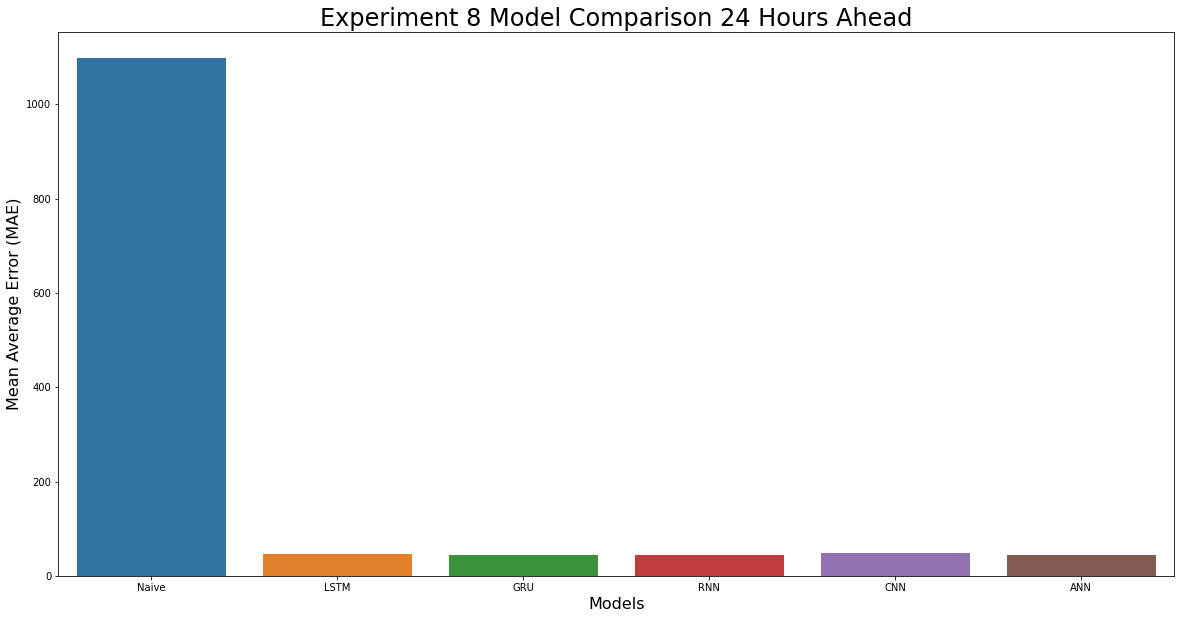

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 8 Model Comparison 24 Hours Ahead", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Forecast 24 hours ahead 24 hour shift**

In [ ]:
input_width = 24
label_width = 24
shift = 24

ex8_24hours_ahead = WindowGenerator(input_width=input_width, label_width=label_width, 
                                  train_df=ex8_train_df, val_df=ex8_val_df, test_df=ex8_test_df,
                                  shift=shift, label_column='Effective GWAP')

In [ ]:
for samples, labels in ex8_24hours_ahead.train:
  print(samples.shape)
  print(labels.shape)
  break

(32, 24, 16)
(32, 24)


In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex8_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex8_24hours_ahead.test], axis=0)

In [ ]:
input_shape = (input_width, ex8_df.shape[-1])
input_shape

(24, 16)

Naive

In [ ]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1722.1445946783263

LSTM

In [ ]:
lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_lstm_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex8_24hours_ahead.train, epochs=epochs, 
                   validation_data=ex8_24hours_ahead.val,
                   callbacks=[reduce_lr, early_stopping, 
                              lstm_checkpoint])

Epoch 1/100
59/59 [==============================] - 3s 31ms/step - loss: 1744.4802 - val_loss: 1134.0728 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 29ms/step - loss: 1433.9081 - val_loss: 1099.7855 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 28ms/step - loss: 1427.4789 - val_loss: 1221.7826 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 29ms/step - loss: 1399.1643 - val_loss: 1028.7693 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 28ms/step - loss: 1441.2804 - val_loss: 1221.2205 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 27ms/step - loss: 1377.9143 - val_loss: 1372.6082 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 2s 28ms/step - loss: 1728.1523 - val_loss: 1242.3867 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 2s 29ms/step - loss: 1491.9987 - val_loss: 1219.4537 - lr: 8.0000e-04
Epoch 9/100
59/59 [=========================

In [ ]:
lstm = keras.models.load_model(path + '/models/ex8_lstm_24hours_ahead_24hour_shift.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

2340.7075

GRU

In [ ]:
gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex8_gru_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex8_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
59/59 [==============================] - 4s 31ms/step - loss: 1486.1606 - val_loss: 1015.5562 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 2s 28ms/step - loss: 1249.5613 - val_loss: 978.2664 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 2s 28ms/step - loss: 1191.2352 - val_loss: 975.6327 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 2s 28ms/step - loss: 1163.1179 - val_loss: 981.1415 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 2s 27ms/step - loss: 1142.5752 - val_loss: 1025.8969 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 2s 27ms/step - loss: 1132.9847 - val_loss: 1001.5159 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 2s 26ms/step - loss: 1103.7417 - val_loss: 989.9651 - lr: 8.0000e-04
Epoch 8/100
59/59 [==============================] - 2s 27ms/step - loss: 1097.0767 - val_loss: 995.1344 - lr: 8.0000e-04
Epoch 9/100
59/59 [==========================

In [ ]:
gru = keras.models.load_model(path + '/models/ex8_gru_24hours_ahead_24hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

2550.4678

RNN

In [ ]:
rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_rnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex8_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 2s 19ms/step - loss: 1582.0209 - val_loss: 1038.1068 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 17ms/step - loss: 1233.8691 - val_loss: 999.5327 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 16ms/step - loss: 1164.5858 - val_loss: 979.3362 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 17ms/step - loss: 1130.0957 - val_loss: 972.9580 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 17ms/step - loss: 1098.4659 - val_loss: 969.8286 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 18ms/step - loss: 1084.0132 - val_loss: 943.6574 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 18ms/step - loss: 1072.4652 - val_loss: 967.2868 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 17ms/step - loss: 1059.1882 - val_loss: 997.3226 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1s

In [ ]:
rnn = keras.models.load_model(path + '/models/ex8_rnn_24hours_ahead_24hour_shift.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

2466.3813

CNN

In [ ]:
cnn_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex8_cnn_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex8_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 16ms/step - loss: 1468.0023 - val_loss: 1245.3041 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 14ms/step - loss: 1238.4528 - val_loss: 1179.0957 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 15ms/step - loss: 1199.1780 - val_loss: 1162.6808 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 15ms/step - loss: 1177.5149 - val_loss: 1132.2717 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 14ms/step - loss: 1166.4623 - val_loss: 1135.3750 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 13ms/step - loss: 1164.8580 - val_loss: 1166.7896 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 13ms/step - loss: 1163.7159 - val_loss: 1218.9338 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 14ms/step - loss: 1170.1122 - val_loss: 1119.9169 - lr: 8.0000e-04
Epoch 9/100
59/59 [=========================

In [ ]:
cnn = keras.models.load_model(path + '/models/ex8_cnn_24hours_ahead_24hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

2468.9329

ANN

In [ ]:
ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_ann_24hours_ahead_24hour_shift.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex8_24hours_ahead.train, epochs=epochs, 
                  validation_data=ex8_24hours_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
59/59 [==============================] - 1s 11ms/step - loss: 1522.5189 - val_loss: 1051.6919 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 1s 9ms/step - loss: 1249.3082 - val_loss: 1067.0068 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 1s 9ms/step - loss: 1175.1836 - val_loss: 1019.1871 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 1s 9ms/step - loss: 1154.6068 - val_loss: 1011.8063 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 1s 9ms/step - loss: 1118.2681 - val_loss: 1015.5408 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 1s 9ms/step - loss: 1101.7627 - val_loss: 979.0120 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 1s 9ms/step - loss: 1083.7417 - val_loss: 984.9200 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 1s 10ms/step - loss: 1084.5774 - val_loss: 954.7426 - lr: 0.0010
Epoch 9/100
59/59 [==============================] - 1s 1

In [ ]:
ann = keras.models.load_model(path + '/models/ex8_ann_24hours_ahead_24hour_shift.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

2577.344

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_24hours_ahead = pd.DataFrame(errors, index=[0])
maes_24hours_ahead

Naive        LSTM          GRU          RNN          CNN          ANN
0  1722.144595  2340.70752  2550.467773  2466.381348  2468.932861  2577.343994

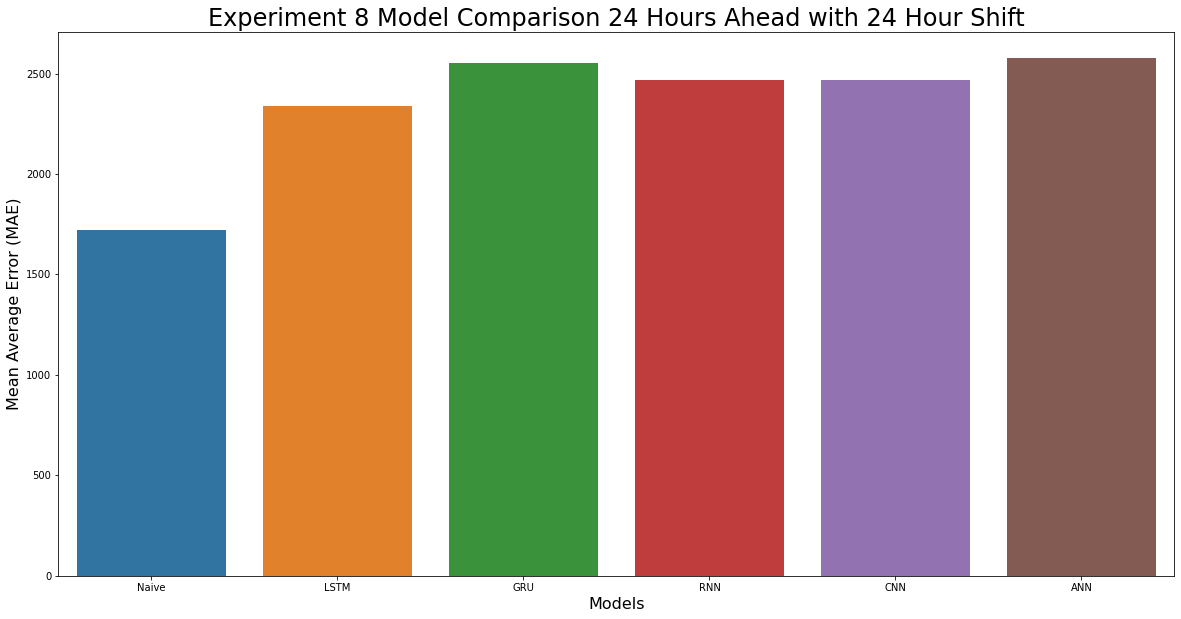

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_24hours_ahead)
plt.title("Experiment 8 Model Comparison 24 Hours Ahead with 24 Hour Shift", fontsize=24)
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

###**Deeper Layers (1 hour ahead)** 

In [ ]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex8_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex8_1hour_ahead.test], axis=0)

input_shape = (input_width, ex8_df.shape[-1])
input_shape

(24, 16)

Naive

In [ ]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

LSTM

In [ ]:
# lstm_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_lstm_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

lstm = keras.models.Sequential([
    keras.layers.LSTM(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.LSTM(100, return_sequences=True, 
                      activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

lstm.compile(loss='mae', optimizer=optimizer)

history = lstm.fit(ex8_1hour_ahead.train, epochs=epochs, 
                   validation_data=ex8_1hour_ahead.val,
                   callbacks=[reduce_lr, early_stopping,
                              lstm_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 96s 66ms/step - loss: 2201.3413 - val_loss: 1517.8661 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 92s 66ms/step - loss: 1641.6809 - val_loss: 1488.4216 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 92s 66ms/step - loss: 1421.1586 - val_loss: 803.7196 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 93s 66ms/step - loss: 1316.1641 - val_loss: 800.6009 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 92s 66ms/step - loss: 1326.3102 - val_loss: 925.8635 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 92s 65ms/step - loss: 1462.8245 - val_loss: 864.1682 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 93s 66ms/step - loss: 1436.2809 - val_loss: 815.2712 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 93s 66ms/step - loss: 1299.7958 - val_loss: 793.9553 - lr: 8.0000e-04
Epoch 9/10

In [ ]:
lstm = keras.models.load_model(path + '/models/ex8_lstm_3layers.h5')
lstm_forecast = lstm.predict(X_test)

mae_lstm = np.mean(keras.losses.mean_absolute_error(y_test, lstm_forecast))
mae_lstm

1513.5032

GRU

In [ ]:
# gru_checkpoint = keras.callbacks.ModelCheckpoint(path + 
    '/models/ex8_gru_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

gru = keras.models.Sequential([
    keras.layers.GRU(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.GRU(100, return_sequences=True,
                     activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

gru.compile(loss='mae', optimizer=optimizer)

history = gru.fit(ex8_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex8_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              gru_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 93s 63ms/step - loss: 1248.0299 - val_loss: 686.0370 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 90s 64ms/step - loss: 1003.6427 - val_loss: 538.2686 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 87s 62ms/step - loss: 865.5817 - val_loss: 488.3026 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 88s 62ms/step - loss: 864.0068 - val_loss: 485.4490 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 87s 62ms/step - loss: 838.8831 - val_loss: 496.7602 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 88s 62ms/step - loss: 822.1047 - val_loss: 464.8082 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 88s 63ms/step - loss: 788.5379 - val_loss: 460.5715 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 87s 62ms/step - loss: 782.1454 - val_loss: 468.3041 - lr: 0.0010
Epoch 9/100
1407/1407 

In [ ]:
gru = keras.models.load_model(path + '/models/ex8_gru_3layers.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

945.9497

RNN

In [ ]:
# rnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_rnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, input_shape=input_shape, 
        return_sequences=True, activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.SimpleRNN(100, return_sequences=True, 
                           activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])  

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

rnn.compile(loss='mae', optimizer=optimizer)

history = rnn.fit(ex8_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex8_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              rnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 42s 28ms/step - loss: 986.4403 - val_loss: 480.1350 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 40s 29ms/step - loss: 800.1096 - val_loss: 474.9360 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 41s 29ms/step - loss: 781.4575 - val_loss: 474.2862 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 40s 28ms/step - loss: 764.4804 - val_loss: 451.1440 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 41s 29ms/step - loss: 758.0607 - val_loss: 463.4767 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 40s 29ms/step - loss: 751.6721 - val_loss: 461.1570 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 40s 28ms/step - loss: 746.7050 - val_loss: 457.8158 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 40s 29ms/step - loss: 735.5593 - val_loss: 454.1883 - lr: 8.0000e-04
Epoch 9/100
1407/140

In [ ]:
rnn = keras.models.load_model(path + '/models/ex8_rnn_3layers.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

985.74646

CNN

In [ ]:
# cnn_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_cnn_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

cnn = tf.keras.models.Sequential([
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu', 
           input_shape=input_shape),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Conv1D(100, kernel_size=input_width,
           padding='causal', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width)
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

cnn.compile(loss='mae', optimizer=optimizer)

history = cnn.fit(ex8_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex8_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping,
                              cnn_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 124s 88ms/step - loss: 1309.2141 - val_loss: 721.7130 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 123s 87ms/step - loss: 1072.6658 - val_loss: 639.8532 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 123s 87ms/step - loss: 952.1250 - val_loss: 599.2645 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 123s 87ms/step - loss: 881.8810 - val_loss: 569.9326 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 122s 87ms/step - loss: 843.3750 - val_loss: 558.0102 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 122s 86ms/step - loss: 822.1586 - val_loss: 573.6909 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 123s 88ms/step - loss: 808.8209 - val_loss: 528.1723 - lr: 0.0010
Epoch 8/100
1407/1407 [==============================] - 122s 87ms/step - loss: 795.5430 - val_loss: 558.0055 - lr: 0.0010
Epoch 9/100
14

In [ ]:
cnn = keras.models.load_model(path + '/models/ex8_cnn_3layers.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1024.7289

ANN

In [ ]:
# ann_checkpoint = keras.callbacks.ModelCheckpoint(path +
    '/models/ex8_ann_3layers.h5', monitor=('val_loss'), save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()

ann = keras.models.Sequential([
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu'),
        input_shape=input_shape),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.TimeDistributed(
        keras.layers.Dense(100, activation='relu')),
    keras.layers.Flatten(),
    keras.layers.Dense(label_width),
])

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

ann.compile(loss='mae', optimizer=optimizer)

history = ann.fit(ex8_1hour_ahead.train, epochs=epochs, 
                  validation_data=ex8_1hour_ahead.val,
                  callbacks=[reduce_lr, early_stopping, 
                              ann_checkpoint])

Epoch 1/100
1407/1407 [==============================] - 12s 8ms/step - loss: 943.4405 - val_loss: 499.3193 - lr: 0.0010
Epoch 2/100
1407/1407 [==============================] - 12s 8ms/step - loss: 808.9131 - val_loss: 458.5681 - lr: 0.0010
Epoch 3/100
1407/1407 [==============================] - 12s 9ms/step - loss: 798.5819 - val_loss: 454.9902 - lr: 0.0010
Epoch 4/100
1407/1407 [==============================] - 12s 9ms/step - loss: 788.0051 - val_loss: 461.0115 - lr: 0.0010
Epoch 5/100
1407/1407 [==============================] - 12s 9ms/step - loss: 777.5591 - val_loss: 467.3994 - lr: 0.0010
Epoch 6/100
1407/1407 [==============================] - 12s 8ms/step - loss: 768.2646 - val_loss: 469.3024 - lr: 0.0010
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 754.9501 - val_loss: 456.9604 - lr: 8.0000e-04
Epoch 8/100
1407/1407 [==============================] - 12s 9ms/step - loss: 754.4598 - val_loss: 465.0922 - lr: 8.0000e-04
Epoch 9/100
1407/1407 [=

In [ ]:
ann = keras.models.load_model(path + '/models/ex8_ann_3layers.h5')
ann_forecast = ann.predict(X_test)

mae_ann = np.mean(keras.losses.mean_absolute_error(y_test, ann_forecast))
mae_ann

981.9811

Model Comparison

In [ ]:
errors = {'Naive': mae_naive, 'LSTM': mae_lstm, 'GRU': mae_gru,
          'RNN': mae_rnn, 'CNN': mae_cnn, 'ANN': mae_ann}

maes_1hour_ahead = pd.DataFrame(errors, index=[0])
maes_1hour_ahead

Naive         LSTM         GRU        RNN          CNN         ANN
0  1104.352951  1513.503174  945.949707  985.74646  1024.728882  981.981079

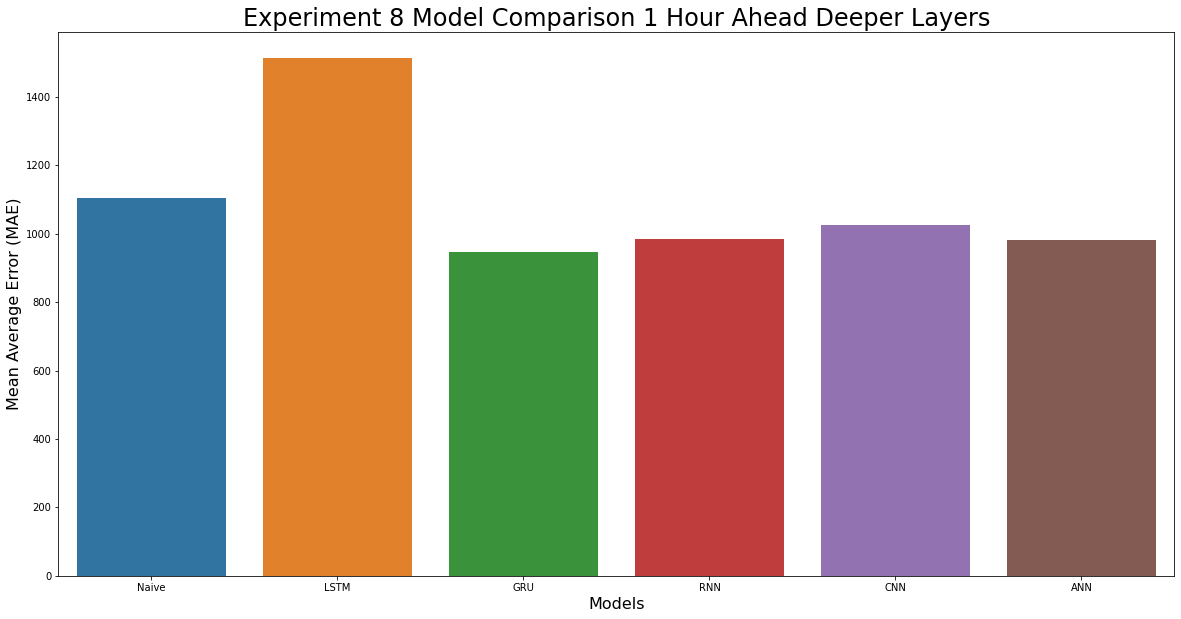

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(data=maes_1hour_ahead)
plt.title("Experiment 8 Model Comparison 1 Hour Ahead Deeper Layers", fontsize=24) 
plt.ylabel("Mean Average Error (MAE)", fontsize=16)
plt.xlabel("Models", fontsize=16)
plt.show()

# <a id='ref3'>3. Model Selection</a>

Since all the experiments are done training, the performance of each model is now available. Model with the lowest MAE of each hour-ahead are selected as a final model for each hour ahead.

###**1 Hour Ahead Model**
The lowest MAE among the models in 1 hour ahead category is the RNN at experiment 6. Experiment 6 has `Effective GWAP` and `datetime` as features

In [121]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex6_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex6_1hour_ahead.test], axis=0)

In [122]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

In [123]:
rnn = keras.models.load_model(path + '/models/ex6_rnn_1hour_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

929.6334

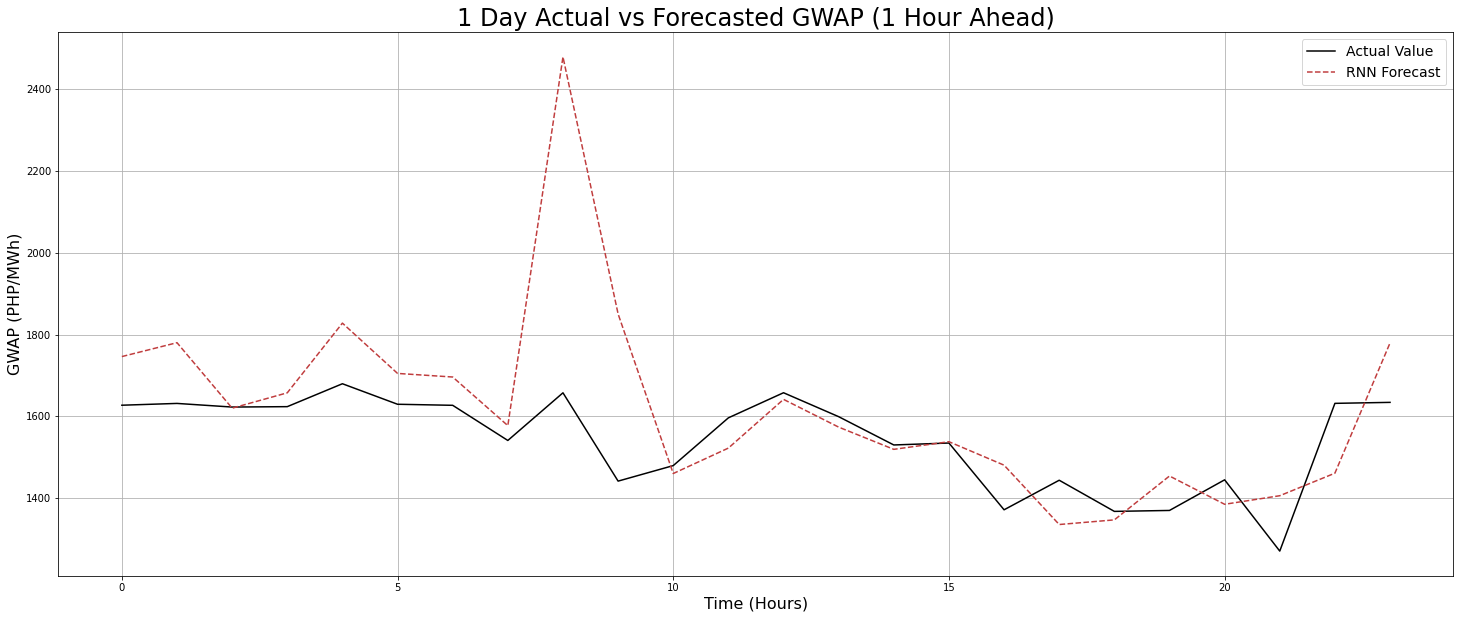

In [124]:
plt.figure(figsize=(25, 10))
plt.plot(y_test[:24], 'k-', label='Actual Value')
# plt.plot(naive_forecast[:24], '-', color='#3274a1', label='Naive Forecast')
plt.plot(rnn_forecast[:24], '--', color='#c03d3e', label='RNN Forecast')
plt.title('1 Day Actual vs Forecasted GWAP (1 Hour Ahead)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

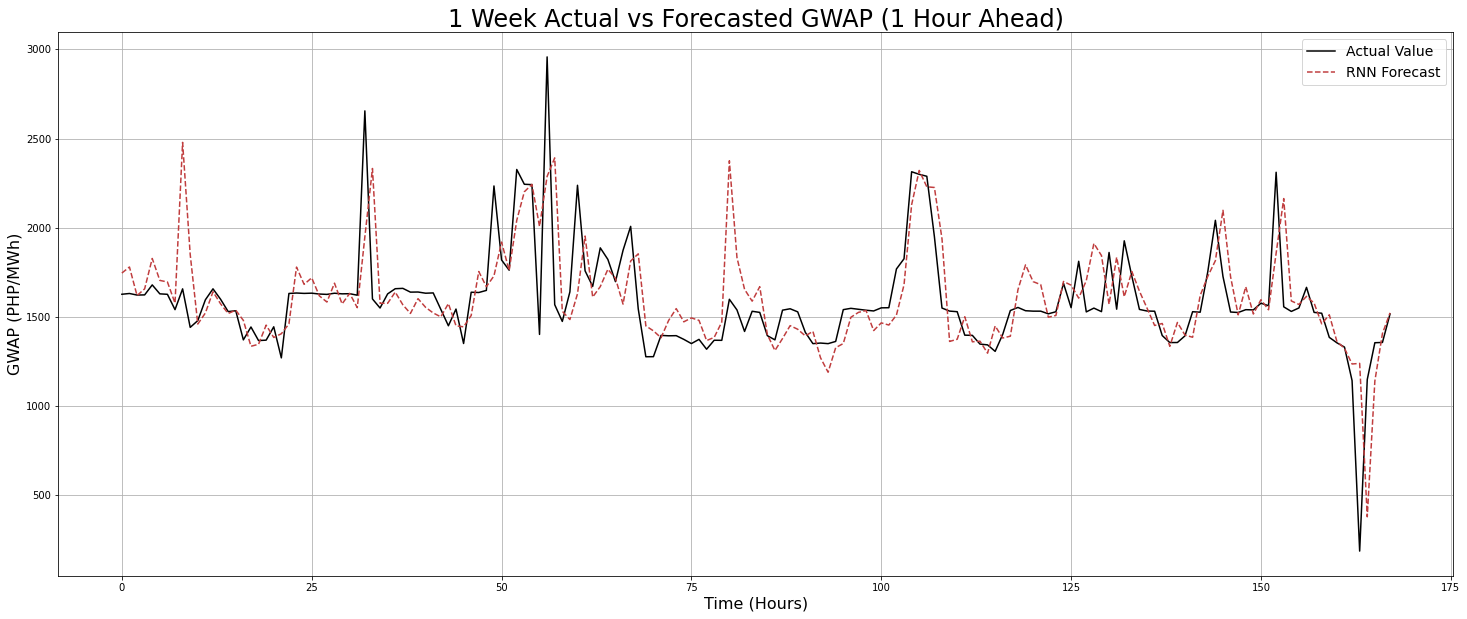

In [125]:
plt.figure(figsize=(25, 10))
plt.plot(y_test[:168], 'k-', label='Actual Value')
# plt.plot(naive_forecast[:168], '-', color='#3274a1', label='Naive Forecast')
plt.plot(rnn_forecast[:168], '--', color='#c03d3e', label='RNN Forecast')
plt.title('1 Week Actual vs Forecasted GWAP (1 Hour Ahead)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

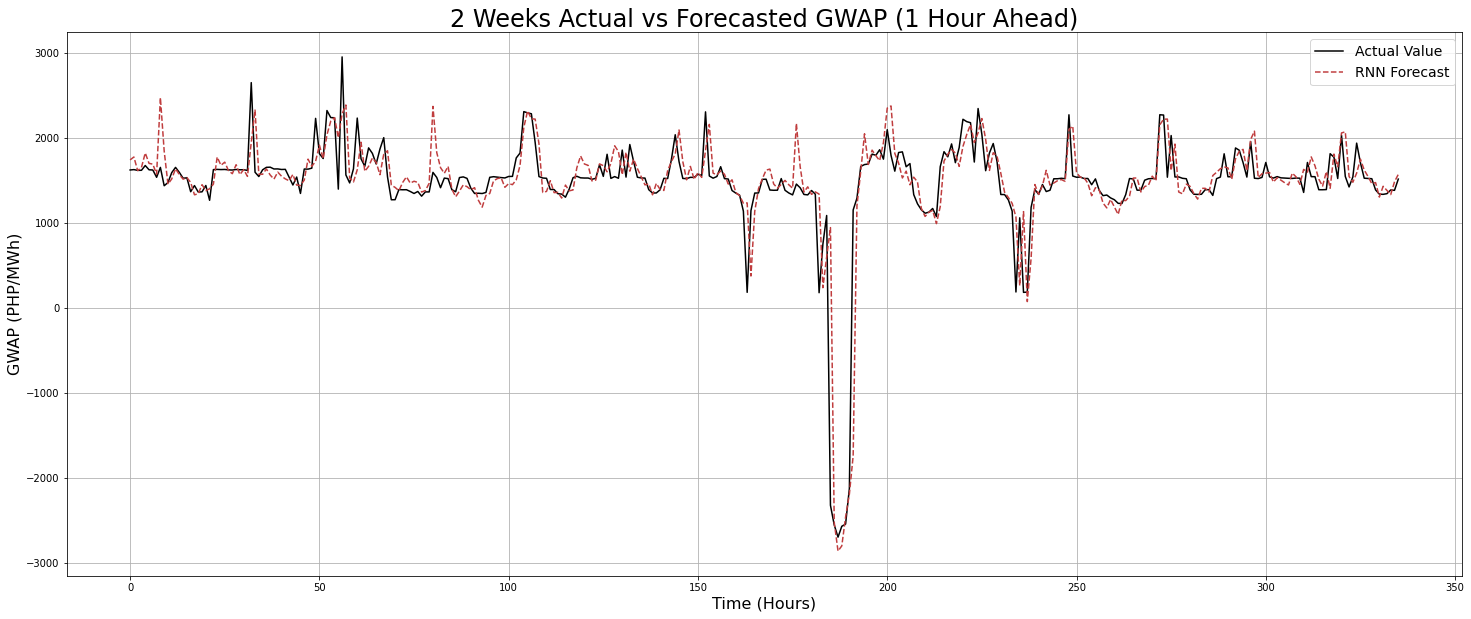

In [126]:
plt.figure(figsize=(25, 10))
plt.plot(y_test[:336], 'k-', label='Actual Value')
# plt.plot(naive_forecast[:336], '-', color='#3274a1', label='Naive Forecast')
plt.plot(rnn_forecast[:336], '--', color='#c03d3e', label='RNN Forecast')
plt.title('2 Weeks Actual vs Forecasted GWAP (1 Hour Ahead)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

###**12 Hours Ahead Model**
The lowest MAE among the models in 12 hours ahead category is the RNN at experiment 8. Experiment 8 has `Effective GWAP`, `datetime`, and `lagged` as a feature

In [127]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex8_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex8_12hours_ahead.test], axis=0)

In [128]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1101.2762310150465

In [129]:
rnn = keras.models.load_model(path + '/models/ex8_rnn_12hours_ahead.h5')
rnn_forecast = rnn.predict(X_test)

mae_rnn = np.mean(keras.losses.mean_absolute_error(y_test, rnn_forecast))
mae_rnn

83.26625

In [130]:
# Flatten values for plotting

y_test_flat = y_test.reshape(-1, 1)
naive_forecast_flat = naive_forecast.reshape(-1, 1)
rnn_forecast_flat = rnn_forecast.reshape(-1, 1)

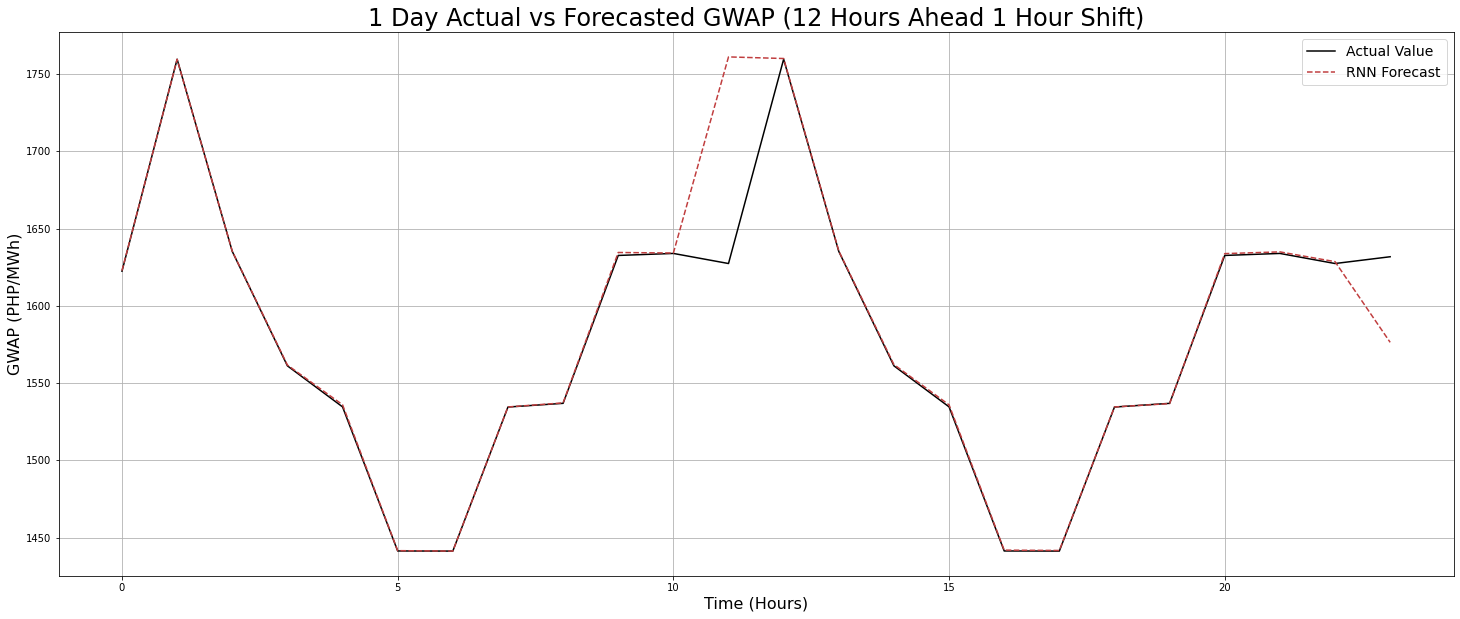

In [131]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:24], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:24], '-', color='#3274a1', label='Naive Forecast')
plt.plot(rnn_forecast_flat[:24], '--', color='#c03d3e', label='RNN Forecast')
plt.title('1 Day Actual vs Forecasted GWAP (12 Hours Ahead 1 Hour Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

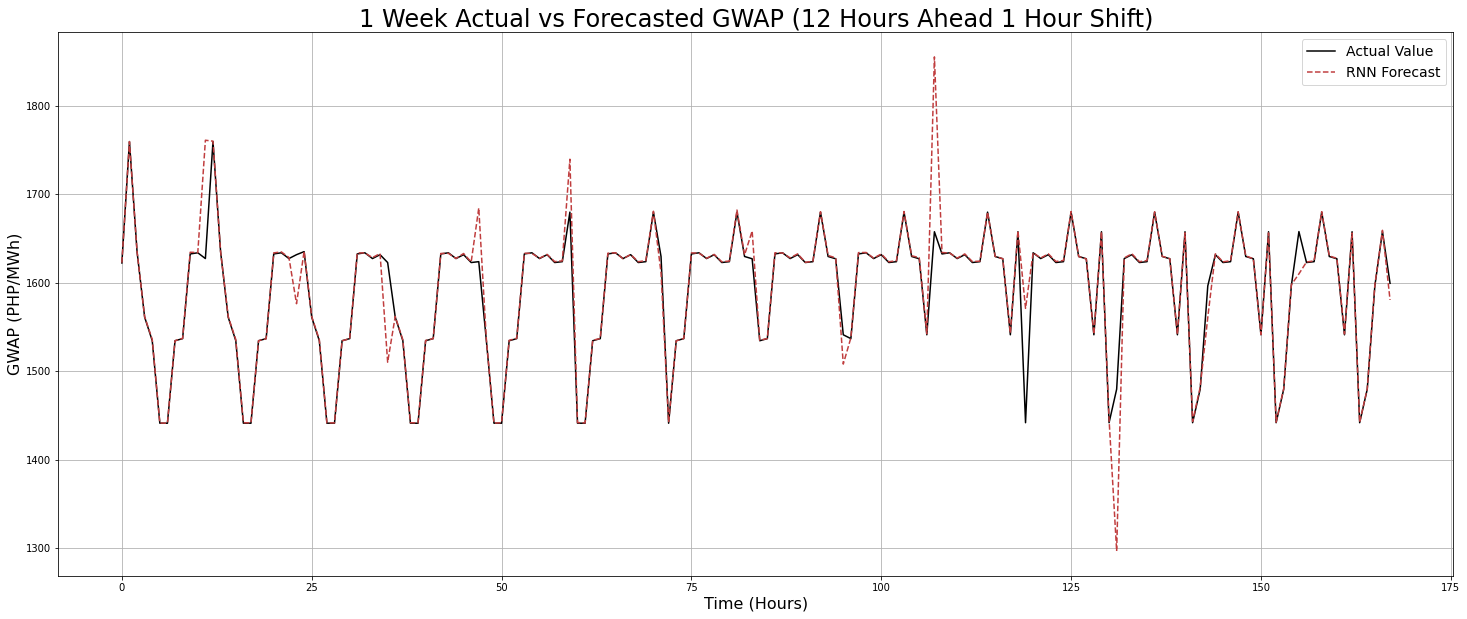

In [132]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:168], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:168], '-', color='#3274a1', label='Naive Forecast')
plt.plot(rnn_forecast_flat[:168], '--', color='#c03d3e', label='RNN Forecast')
plt.title('1 Week Actual vs Forecasted GWAP (12 Hours Ahead 1 Hour Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

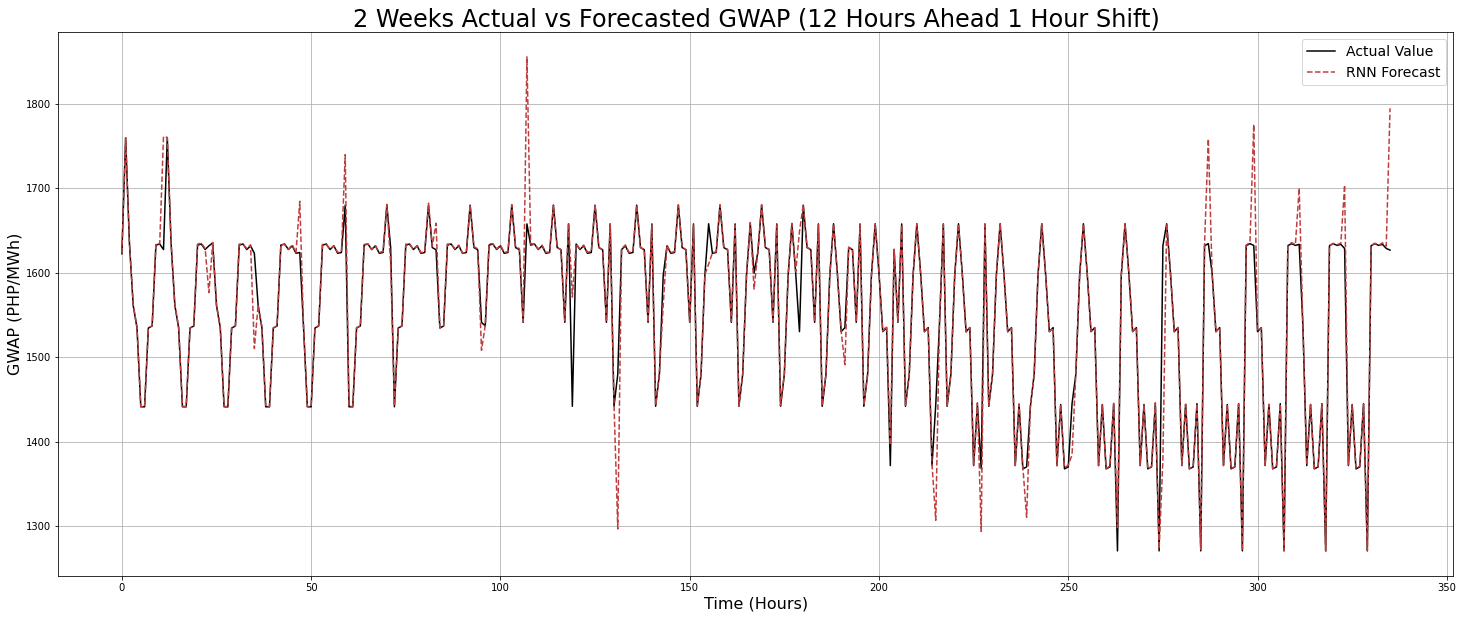

In [133]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:336], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:336], '-', color='#3274a1', label='Naive Forecast')
plt.plot(rnn_forecast_flat[:336], '--', color='#c03d3e', label='RNN Forecast')
plt.title('2 Weeks Actual vs Forecasted GWAP (12 Hours Ahead 1 Hour Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

###**12 Hours Ahead Model 12 Hours Shift**
The lowest MAE among the models in 12 hours ahead with 12 hours shift category is the CNN at experiment 6. Experiment 6 has `Effective GWAP` and `datetime` as a feature

In [134]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex6_12hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex6_12hours_ahead.test], axis=0)

In [135]:
naive_forecast = X_test[:, -12:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

2667.674529034868

In [136]:
cnn = keras.models.load_model(path + '/models/ex6_cnn_12hours_ahead_12hour_shift.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

1615.192

In [137]:
# Flatten values for plotting

y_test_flat = y_test.reshape(-1, 1)
naive_forecast_flat = naive_forecast.reshape(-1, 1)
cnn_forecast_flat = cnn_forecast.reshape(-1, 1)

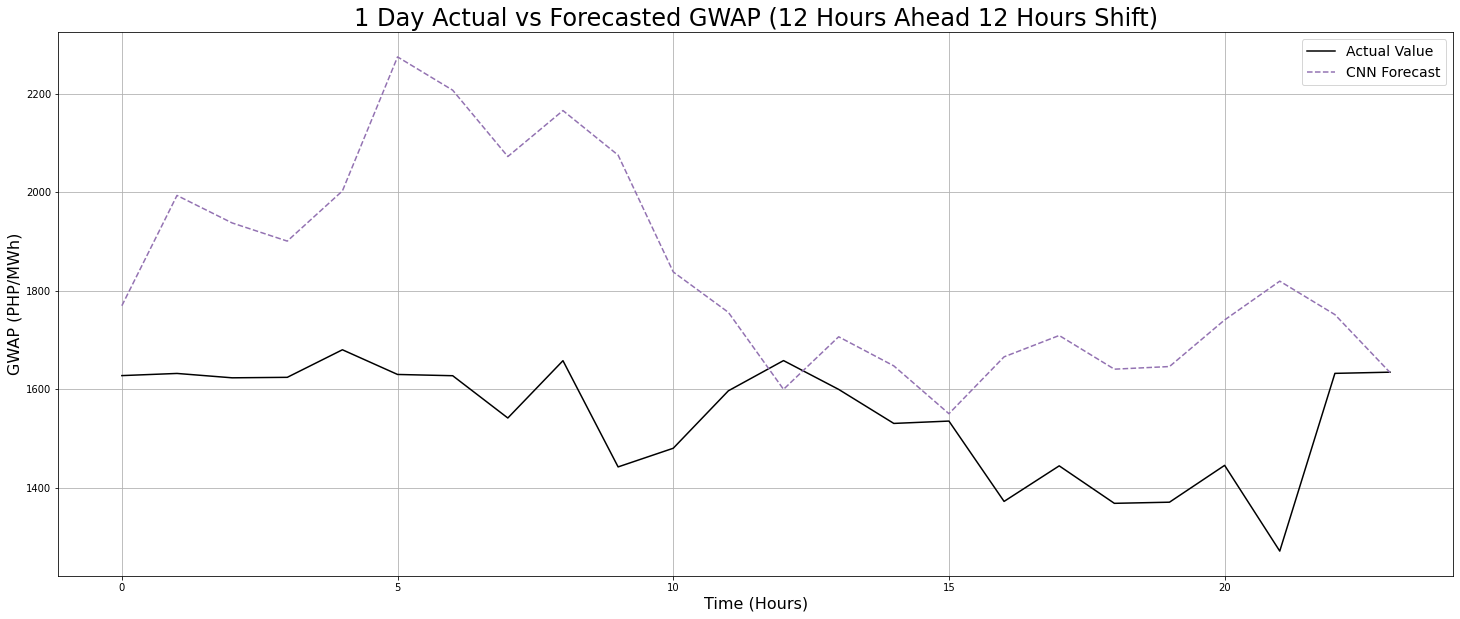

In [138]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:24], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:24], '-', color='#3274a1', label='Naive Forecast')
plt.plot(cnn_forecast_flat[:24], '--', color='#9372b2', label='CNN Forecast')
plt.title('1 Day Actual vs Forecasted GWAP (12 Hours Ahead 12 Hours Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

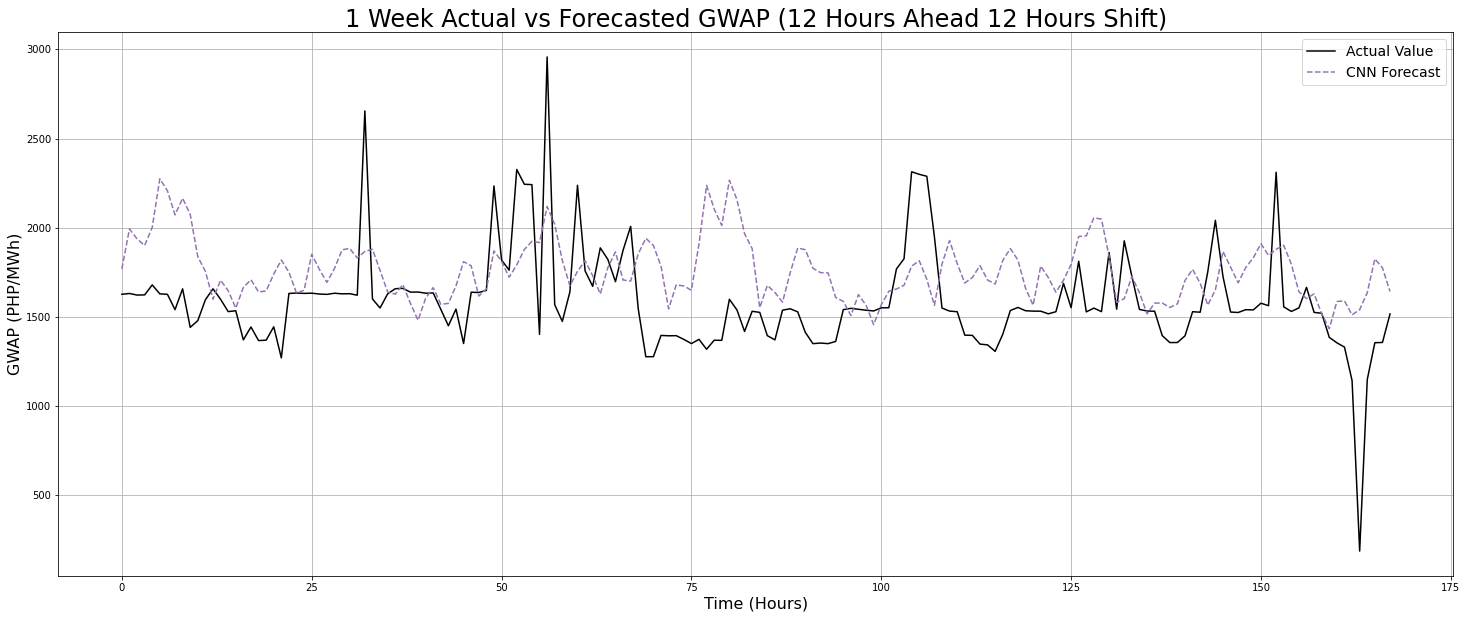

In [139]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:168], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:168], '-', color='#3274a1', label='Naive Forecast')
plt.plot(cnn_forecast_flat[:168], '--', color='#9372b2', label='CNN Forecast')
plt.title('1 Week Actual vs Forecasted GWAP (12 Hours Ahead 12 Hours Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

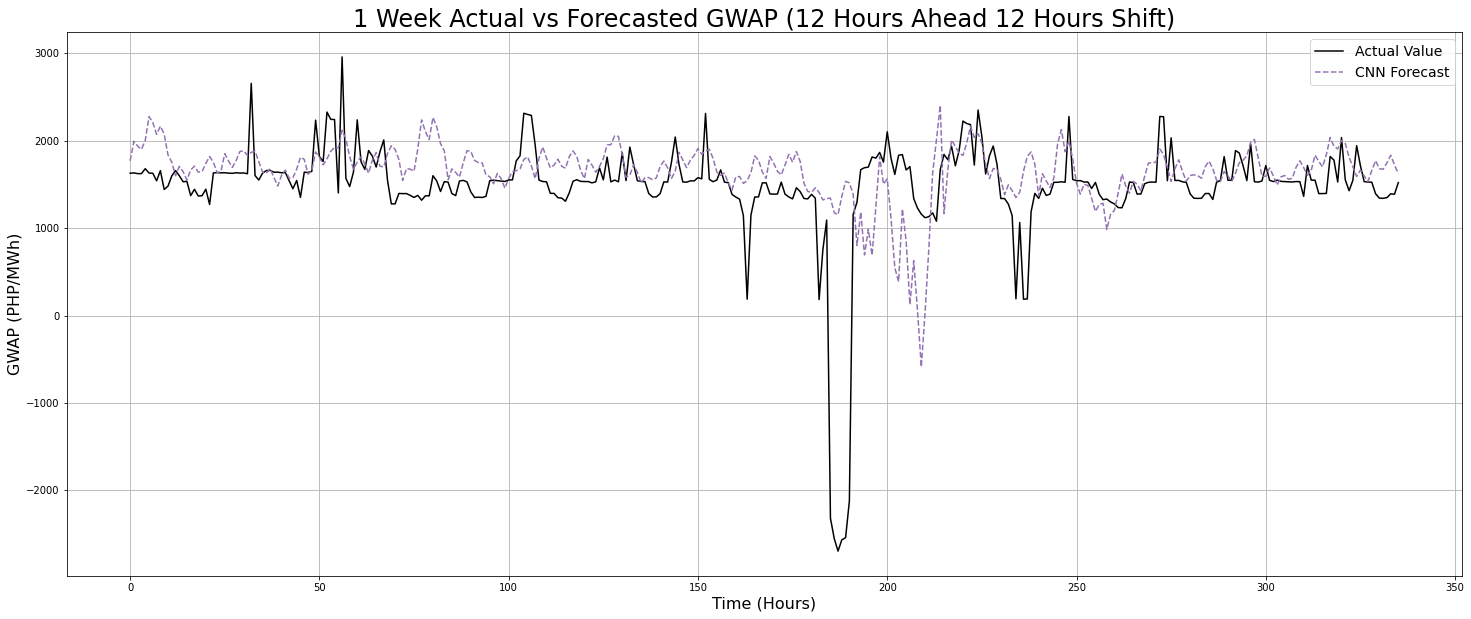

In [140]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:336], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:336], '-', color='#3274a1', label='Naive Forecast')
plt.plot(cnn_forecast_flat[:336], '--', color='#9372b2', label='CNN Forecast')
plt.title('1 Week Actual vs Forecasted GWAP (12 Hours Ahead 12 Hours Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

###**24 Hours Ahead Model**
The lowest MAE among the models in 12 hours ahead category is the CNN at experiment 6. Experiment 8 has `Effective GWAP` and `datetime` as a feature.

In [142]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex6_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex6_24hours_ahead.test], axis=0)

In [143]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1098.3518162532384

In [144]:
cnn = keras.models.load_model(path + '/models/ex6_cnn_24hours_ahead.h5')
cnn_forecast = cnn.predict(X_test)

mae_cnn = np.mean(keras.losses.mean_absolute_error(y_test, cnn_forecast))
mae_cnn

43.149265

In [145]:
# Flatten values for plotting

y_test_flat = y_test.reshape(-1, 1)
naive_forecast_flat = naive_forecast.reshape(-1, 1)
cnn_forecast_flat = cnn_forecast.reshape(-1, 1)

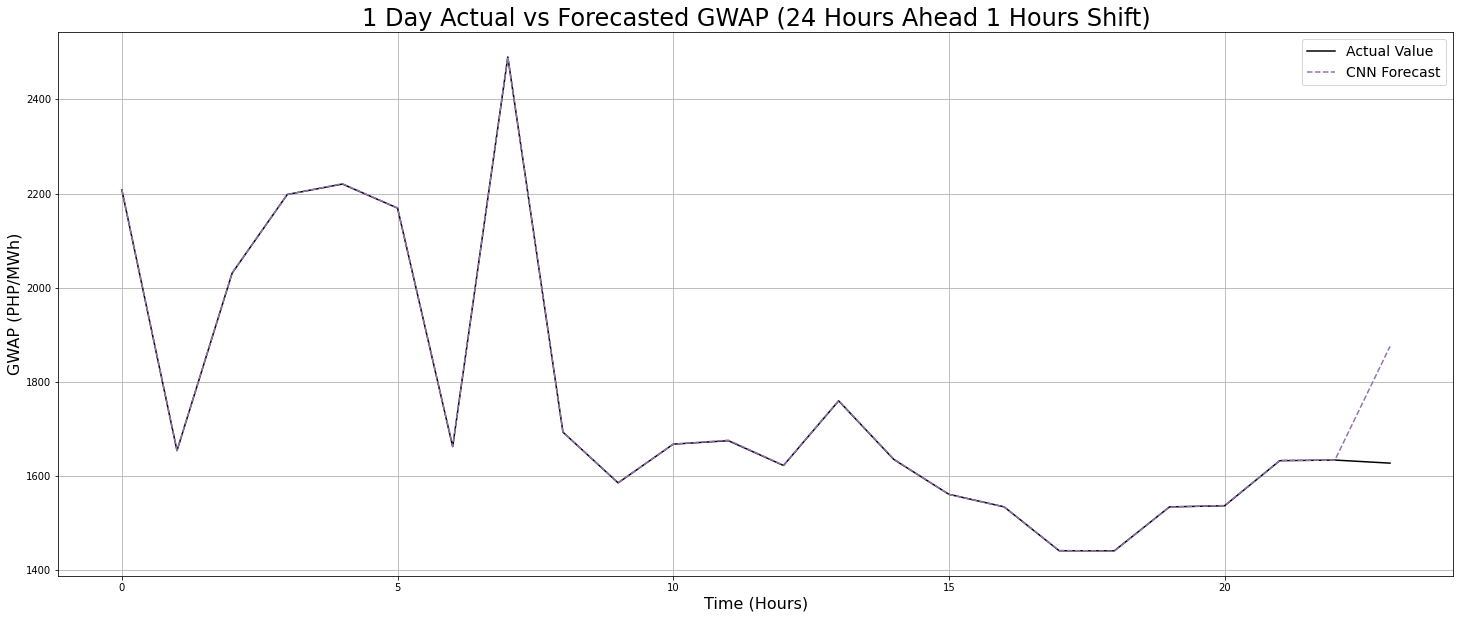

In [147]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:24], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:24], '-', color='#3274a1', label='Naive Forecast')
plt.plot(cnn_forecast_flat[:24], '--', color='#9372b2', label='CNN Forecast')
plt.title('1 Day Actual vs Forecasted GWAP (24 Hours Ahead 1 Hours Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

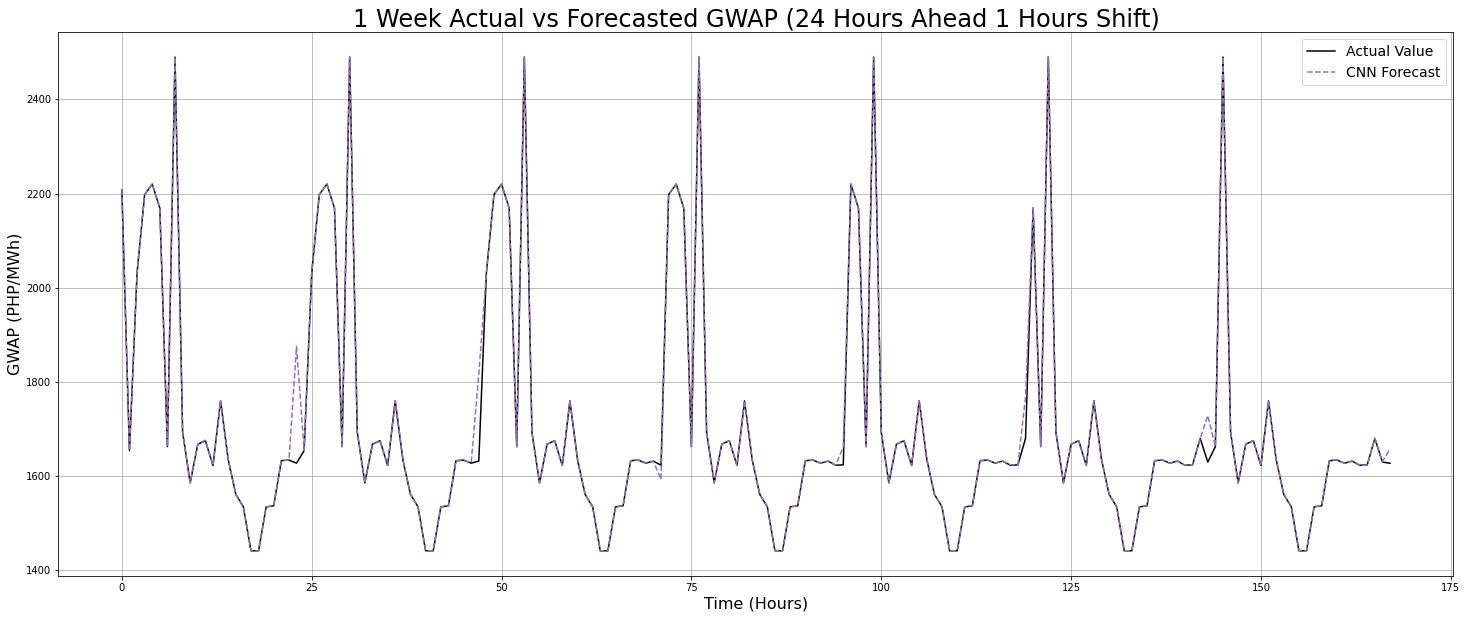

In [148]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:168], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:168], '-', color='#3274a1', label='Naive Forecast')
plt.plot(cnn_forecast_flat[:168], '--', color='#9372b2', label='CNN Forecast')
plt.title('1 Week Actual vs Forecasted GWAP (24 Hours Ahead 1 Hours Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

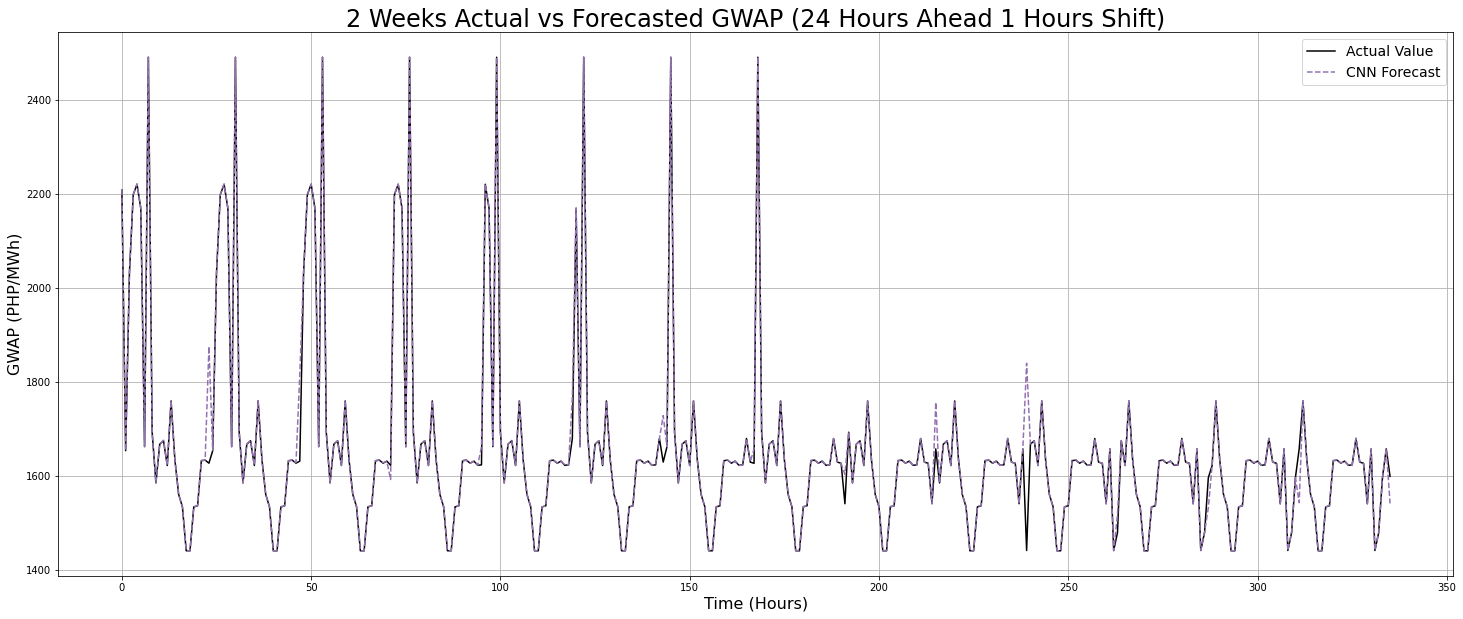

In [149]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:336], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:336], '-', color='#3274a1', label='Naive Forecast')
plt.plot(cnn_forecast_flat[:336], '--', color='#9372b2', label='CNN Forecast')
plt.title('2 Weeks Actual vs Forecasted GWAP (24 Hours Ahead 1 Hours Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

###**24 Hours Ahead Model 24 Hours Shift**
The lowest MAE among the models in 24 hours ahead with 24 hours shift category is the GRU at experiment 6. Experiment 6 has `Effective GWAP`, `Rolling Average` and `datetime` as a feature.

In [150]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex3_24hours_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex3_24hours_ahead.test], axis=0)

In [151]:
naive_forecast = X_test[:, -24:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1722.1445946783263

In [152]:
gru = keras.models.load_model(path + '/models/ex3_gru_24hours_ahead_24hour_shift.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

1925.6932

In [153]:
# Flatten values for plotting

y_test_flat = y_test.reshape(-1, 1)
naive_forecast_flat = naive_forecast.reshape(-1, 1)
gru_forecast_flat = gru_forecast.reshape(-1, 1)

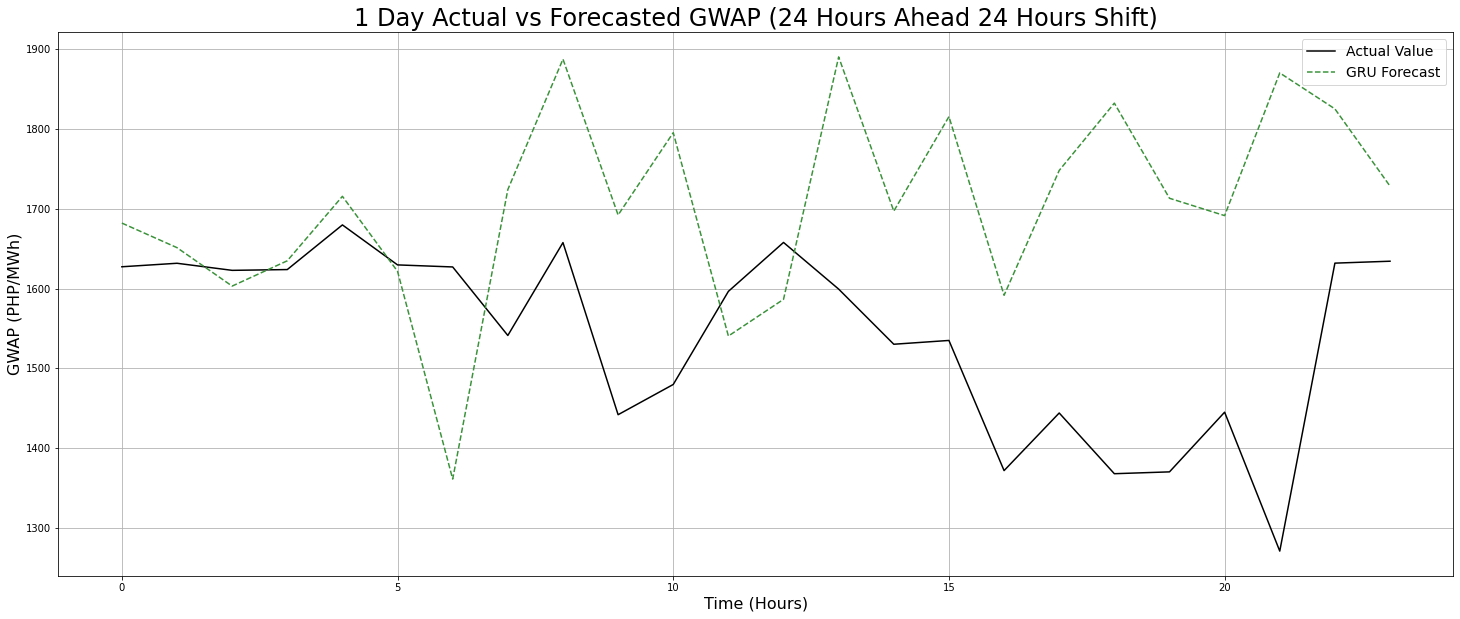

In [154]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:24], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:24], '-', color='#3274a1', label='Naive Forecast')
plt.plot(gru_forecast_flat[:24], '--', color='#3a923a', label='GRU Forecast')
plt.title('1 Day Actual vs Forecasted GWAP (24 Hours Ahead 24 Hours Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

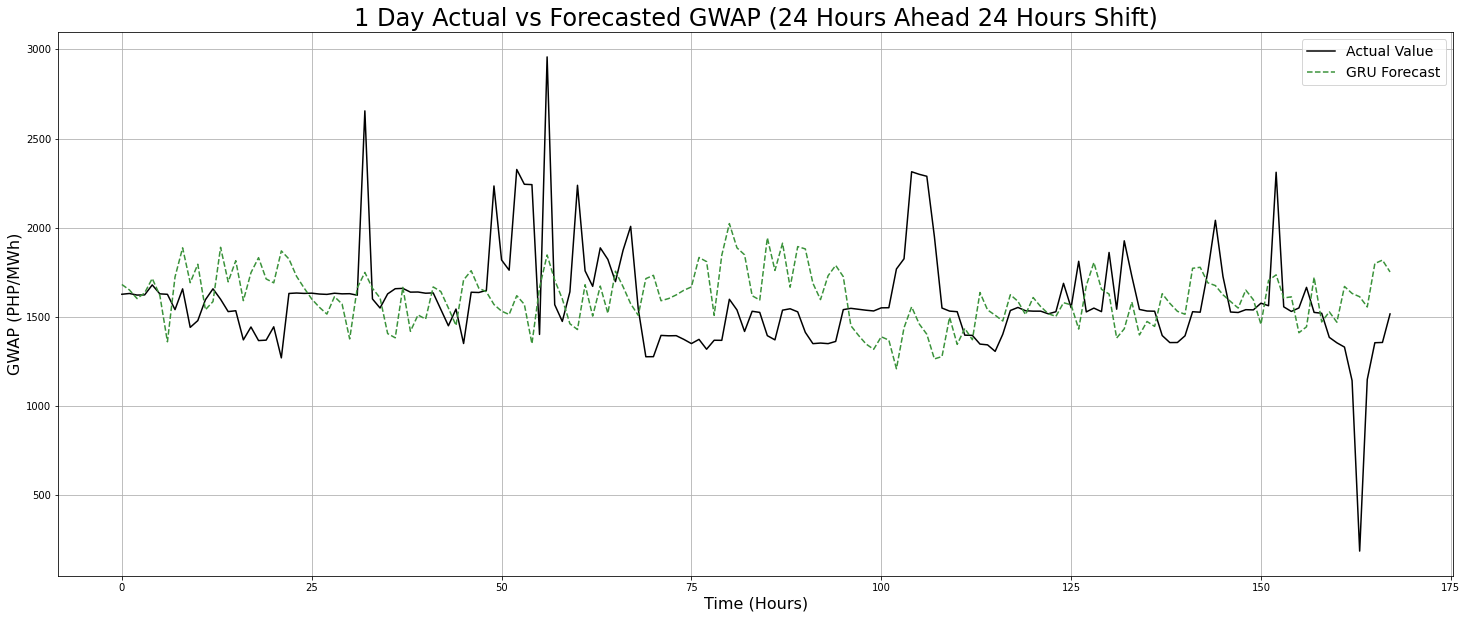

In [155]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:168], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:168], '-', color='#3274a1', label='Naive Forecast')
plt.plot(gru_forecast_flat[:168], '--', color='#3a923a', label='GRU Forecast')
plt.title('1 Day Actual vs Forecasted GWAP (24 Hours Ahead 24 Hours Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

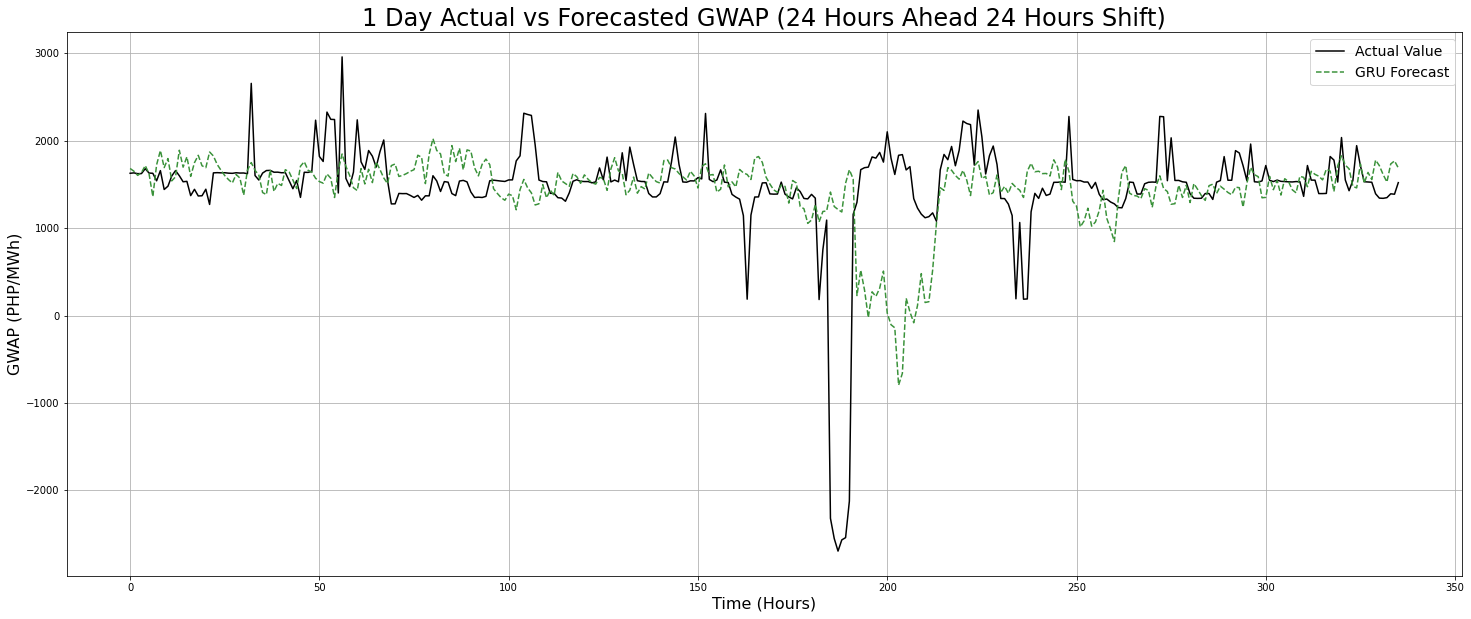

In [156]:
plt.figure(figsize=(25, 10))
plt.plot(y_test_flat[:336], 'k-', label='Actual Value')
# plt.plot(naive_forecast_flat[:336], '-', color='#3274a1', label='Naive Forecast')
plt.plot(gru_forecast_flat[:336], '--', color='#3a923a', label='GRU Forecast')
plt.title('1 Day Actual vs Forecasted GWAP (24 Hours Ahead 24 Hours Shift)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

###**Deeper layers**
The lowest MAE among the models in deeper layers is the GRU at experiment 5. Experiment 5 has `Effective GWAP`, `Rolling Average`, `datetime`, and `lagged` as features.

In [158]:
# Extract samples and labels from Dataset object

X_test = np.concatenate([X for X, y in ex5_1hour_ahead.test], axis=0)
y_test = np.concatenate([y for X, y in ex5_1hour_ahead.test], axis=0)

In [159]:
naive_forecast = X_test[:, -1:, 0]

mae_naive = np.mean(keras.losses.mean_absolute_error(y_test, naive_forecast))
mae_naive

1104.3529509169255

In [160]:
gru = keras.models.load_model(path + '/models/ex5_gru_3layers.h5')
gru_forecast = gru.predict(X_test)

mae_gru = np.mean(keras.losses.mean_absolute_error(y_test, gru_forecast))
mae_gru

940.3708

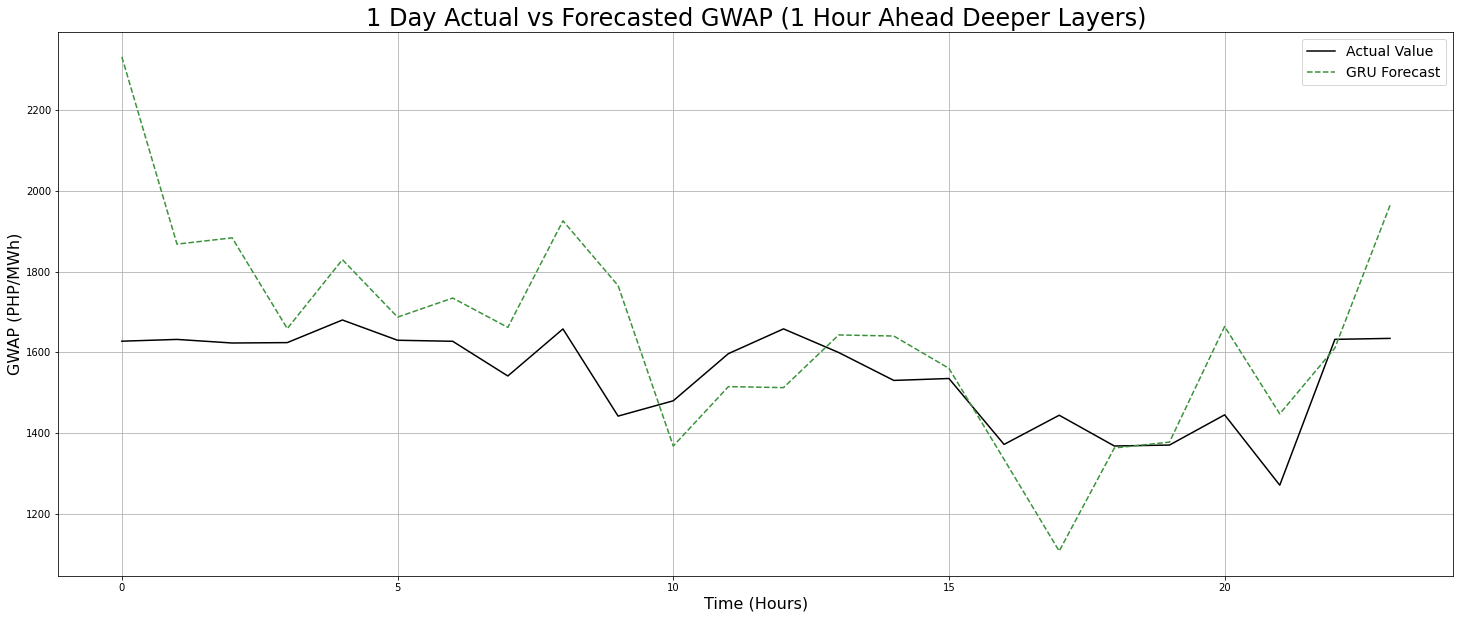

In [161]:
plt.figure(figsize=(25, 10))
plt.plot(y_test[:24], 'k-', label='Actual Value')
# plt.plot(naive_forecast[:24], '-', color='#3274a1', label='Naive Forecast')
plt.plot(gru_forecast[:24], '--', color='#3a923a', label='GRU Forecast')
plt.title('1 Day Actual vs Forecasted GWAP (1 Hour Ahead Deeper Layers)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

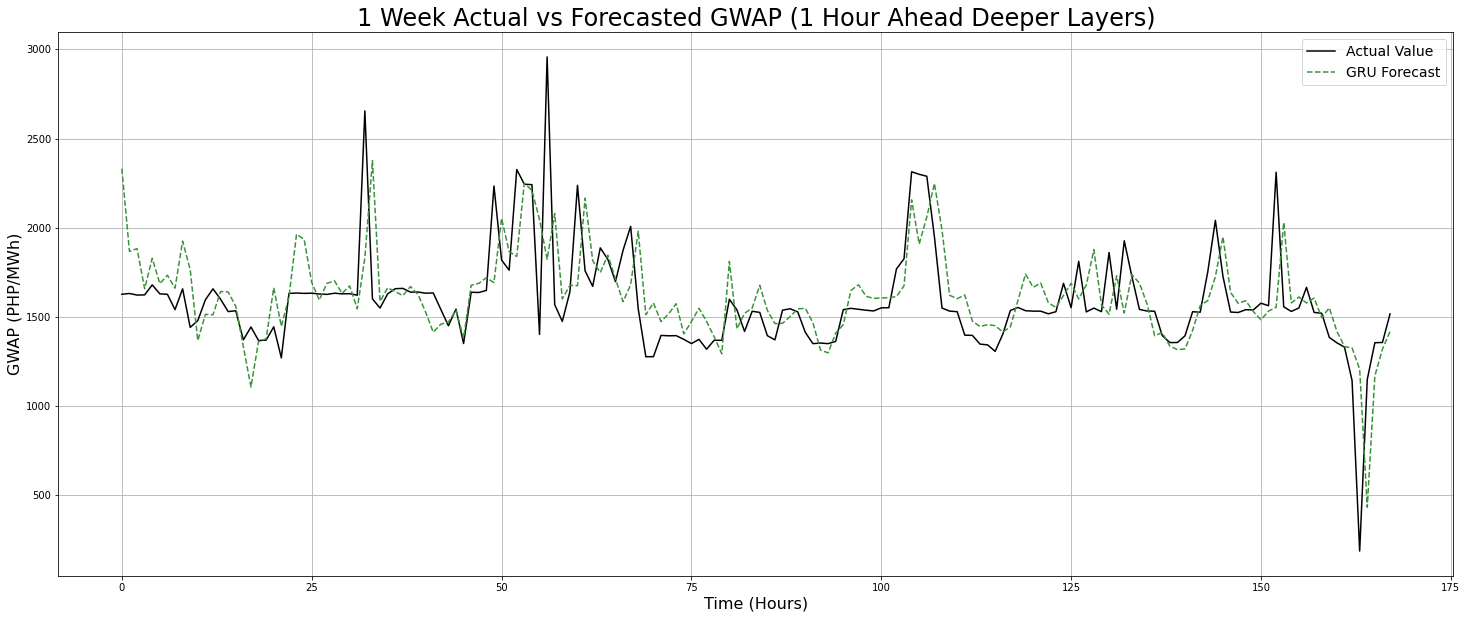

In [162]:
plt.figure(figsize=(25, 10))
plt.plot(y_test[:168], 'k-', label='Actual Value')
# plt.plot(naive_forecast[:168], '-', color='#3274a1', label='Naive Forecast')
plt.plot(gru_forecast[:168], '--', color='#3a923a', label='GRU Forecast')
plt.title('1 Week Actual vs Forecasted GWAP (1 Hour Ahead Deeper Layers)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()

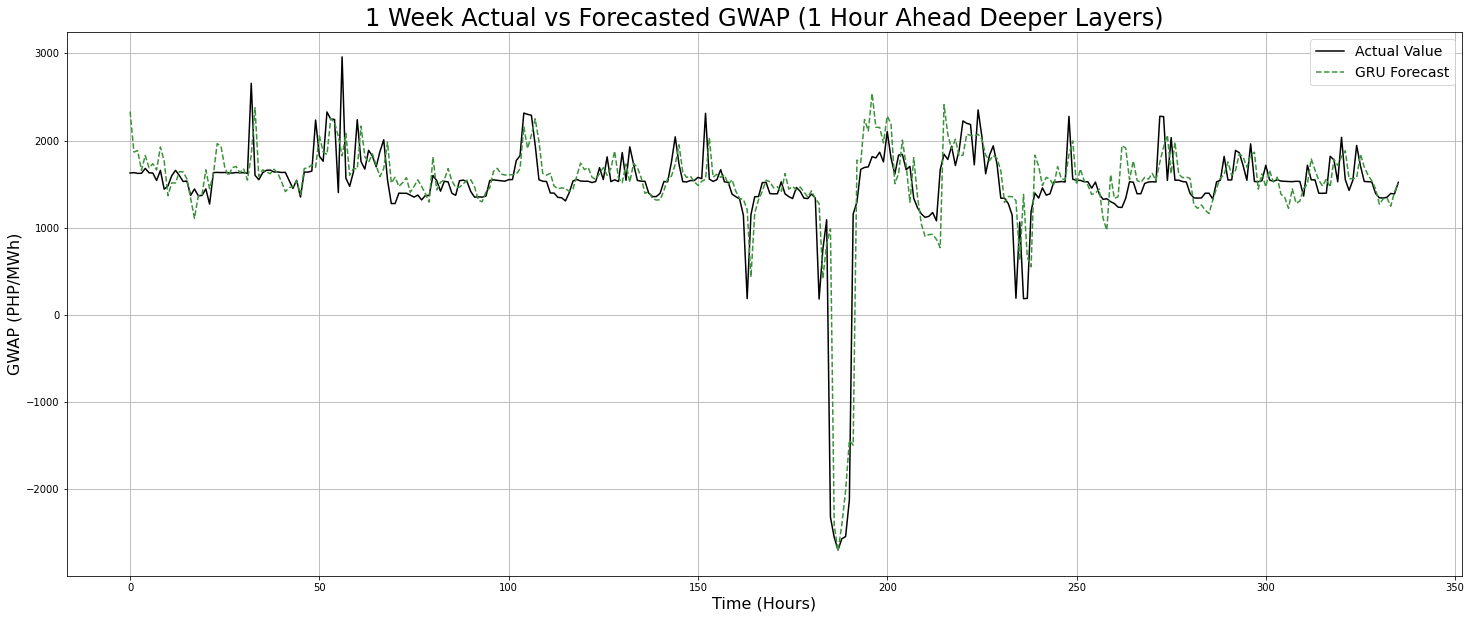

In [163]:
plt.figure(figsize=(25, 10))
plt.plot(y_test[:336], 'k-', label='Actual Value')
# plt.plot(naive_forecast[:336], '-', color='#3274a1', label='Naive Forecast')
plt.plot(gru_forecast[:336], '--', color='#3a923a', label='GRU Forecast')
plt.title('1 Week Actual vs Forecasted GWAP (1 Hour Ahead Deeper Layers)', fontsize=24)
plt.xlabel('Time (Hours)', fontsize=16)
plt.ylabel('GWAP (PHP/MWh)', fontsize=16)
plt.grid(True)
plt.legend(loc='best', prop={'size': 14})
plt.show()